In [1]:
# No DCSO

# CONNECTOME ANALYSIS OF PhN-SA PATHWAYS

## This code is moslty based on the analyses in Walker et al.

### The code is organized into sections focused on the aPhN_SAs and PhN-SAs, 2Ns, 3Ns, etc.,. with several types of analysis in each section.

This workflow is on the second set/cluster naming convention we cam up with for the aPhN_SAs and PhN-SAs

### First, import packages and set default plotting parameters

In [2]:
#from PhN_GRN_Activation import set_1
#%pip install statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from venn import venn
import seaborn as sns
from matplotlib.colors import LogNorm
import statsmodels.api as sm

In [4]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplot lib theme
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'axes.labelsize': 12,
              'axes.titlesize': 16,
              'figure.dpi': 100}

plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

In [5]:
# Load connections dataset
connections = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/connections.csv.gz')

# Neuropil synapses
neuropil_synapse = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/neuropil_synapse_table.csv.gz')[['root_id','input synapses','output synapses']]
neuropil_synapse.rename(columns={'input synapses': 'input_synapses','output synapses': 'output_synapses'}, inplace=True)

# Classification tables
classification = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz')[['root_id','side']]
classification_other = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz')[['root_id','super_class', 'class']]

# Neurons data
neurons = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/neurons.csv.gz')[['root_id','nt_type']]

# Merging additional data into one neuron dataset
neurons_data = pd.merge(neurons,
                        pd.merge(classification, neuropil_synapse, on='root_id', how='outer'),
                        on='root_id', how='outer')

# --- PhN-SA sets (v2) ---
set_1 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_1.csv')
set_2 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_2.csv')
set_3 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_3.csv')
set_4 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_4.csv')
set_5 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_5.csv')
set_6 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_6.csv')

# Combine all PhN-SAs
PhN_SAs = pd.concat([set_1, set_2, set_3, set_4, set_5, set_6], ignore_index=True)

# --- aPhN1-SA sets (v1) ---
aPhN1_set_1 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_v2/set_1.csv')
aPhN1_set_2 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_v2/set_2.csv')
aPhN1_set_3 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_v2/set_3.csv')

aPhN1_SAs = pd.concat([aPhN1_set_1, aPhN1_set_2, aPhN1_set_3], ignore_index=True)

# --- aPhN2-SA sets (v1) ---
aPhN2_set_1 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_v1/set_1.csv')
aPhN2_set_2 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_v1/set_2.csv')
aPhN2_set_3 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_v1/set_3.csv')

aPhN2_SAs = pd.concat([aPhN2_set_1, aPhN2_set_2, aPhN2_set_3], ignore_index=True)

# Verify shapes of the combined datasets
print(f"PhN-SAs combined shape: {PhN_SAs.shape}")
print(f'aPhN1-SAs combined shape: {aPhN1_SAs.shape}')
print(f'aPhN2-SAs combined shape: {aPhN2_SAs.shape}')

PhN-SAs combined shape: (71, 1)
aPhN1-SAs combined shape: (33, 1)
aPhN2-SAs combined shape: (51, 1)


## 1. FIRST ORDER ANALYSES

### Load the datasets with neurons and connections.

* This script assumes that the **CSV** files (`.csv.gz`) and **PhN-SAs lists** (`_new.csv` files) are in the same folder as this notebook or script.
* These files include four CSVs containing manually curated  PhN-SAs lists and four connectome datasets from FlyWire:
  1. **`classification.csv.gz`**
  2. **`connections.csv.gz`**
  3. **`neuropil_synapse_table.csv.gz`**
  4. **`neurons.csv.gz`**
* **Axon lists** were curated manually as described in the paper.
* **Connectome datasets** were downloaded from the FlyWire website using **snapshot 783** (previous snapshot 630).
* We focus on putative sensory axons from the Drosophila **pharyngeal nerves** in this analysis.


### Find downstream connections of aPhN_SAs and PhN-SAs
- includes all neurons downstream of aPhN_SAs and PhN-SAs - we will filter out set-set connections later
- minimum of 5 synapses between the two neurons

In [6]:
# Function to retrieve outputs for both PhN-SAs and aPhN-SAs
def neuronal_outputs(sets_dict):
    """
    Given a dictionary of neuron sets, get their downstream connections.
    Filters out weak connections (syn_count < 0).

    Parameters:
        sets_dict (dict): Dictionary where keys are names (e.g., 'PhN_SAs', 'aPhN1_SAs')
                          and values are DataFrames containing `root_id` neurons.

    Returns:
        dict: A dictionary where keys are names and values are output DataFrames.
    """
    outputs = {}  # Dictionary to store results

    # Define function to categorize location
    def projection(neuropil):
        SEZ_regions = ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN']
        return 'local' if neuropil in SEZ_regions else 'outside_SEZ'

    # Process each neuron set
    for set_name, neuron_set in sets_dict.items():
        if 'root_id' not in neuron_set.columns:
            raise KeyError(f"root_id column is missing from {set_name}")

        # Merge neuron set with connections
        connectivity = pd.merge(
            neuron_set[['root_id']],
            connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
            left_on='root_id',
            right_on='pre_root_id',
            how='inner'
        ).query("syn_count >= 0")  # Filter weak connections

        # Remove redundant column
        connectivity.drop(columns='root_id', inplace=True)

        # Apply location categorization
        connectivity['location_of_connection'] = connectivity['neuropil'].apply(projection)

        # Store results in dictionary
        outputs[set_name] = connectivity

    return outputs

# Define neuron sets
sets_dict = {
    "PhN_SAs": PhN_SAs,
    "aPhN1_SAs": aPhN1_SAs,
    "aPhN2_SAs": aPhN2_SAs
}


In [7]:
# Run function
outputs_dict = neuronal_outputs(sets_dict)

In [8]:
# Extract results for each group
PhN_SAs_outputs = outputs_dict["PhN_SAs"]
aPhN1_SAs_outputs = outputs_dict["aPhN1_SAs"]
aPhN2_SAs_outputs = outputs_dict["aPhN2_SAs"]

In [9]:
# Verify results
print(f"PhN_SAs_outputs shape: {PhN_SAs_outputs.shape}")
print(f"aPhN1_SAs_outputs shape: {aPhN1_SAs_outputs.shape}")
print(f"aPhN2_SAs_outputs shape: {aPhN2_SAs_outputs.shape}")

PhN_SAs_outputs shape: (2110, 6)
aPhN1_SAs_outputs shape: (2861, 6)
aPhN2_SAs_outputs shape: (1886, 6)


### Quantifying PhN-SA to PhN-SA communication
# This creates a heatmap showing the number of synapses between each set of pharyngeal sensory axons.

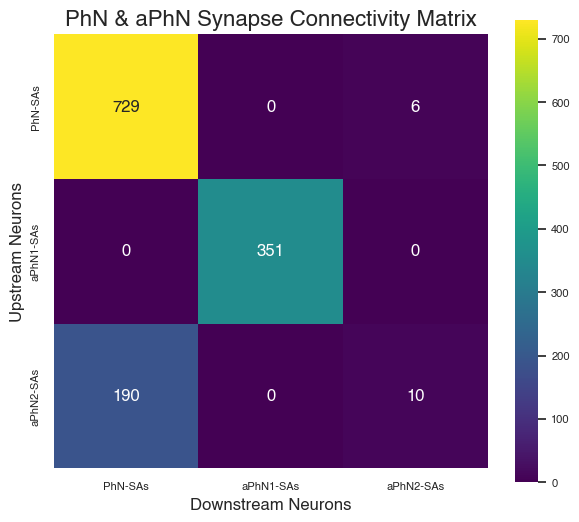

In [10]:
def sa_heatmap_matrix(upstream_outputs, downstream_sets):
    """
    Given lists of DataFrames representing outputs from upstream SA sets (PhN, aPhN1, aPhN2)
    and downstream SA sets, return an MxN matrix where each entry [i, j] is the sum
    of synapses from upstream set i to downstream set j.

    Parameters
    ----------
    upstream_outputs : list of pd.DataFrame
        [PhN_SAs_outputs, aPhN1_SAs_outputs, aPhN2_SAs_outputs]

    downstream_sets : list of pd.DataFrame
        [PhN_SAs, aPhN1_SAs, aPhN2_SAs]

    Returns
    -------
    np.ndarray
        An MxN integer matrix with synapse count sums.
    """
    m = len(upstream_outputs)
    n = len(downstream_sets)

    # Initialize an MxN matrix of zeros
    syn_matrix = np.zeros((m, n), dtype=int)

    # Iterate over upstream output sets
    for i, out_df in enumerate(upstream_outputs):
        # For each downstream set
        for j, set_df in enumerate(downstream_sets):
            # Merge on downstream neurons
            merged_df = pd.merge(
                out_df,
                set_df,
                left_on='post_root_id',    # connections downstream
                right_on='root_id',        # neuron IDs
                how='inner'
            )
            # Sum the synapse counts
            syn_matrix[i, j] = merged_df['syn_count'].sum()

    return syn_matrix

# Define lists for analysis
upstream_outputs = [PhN_SAs_outputs, aPhN1_SAs_outputs, aPhN2_SAs_outputs]
downstream_sets = [PhN_SAs, aPhN1_SAs, aPhN2_SAs]

# Compute the matrix
syn_matrix = sa_heatmap_matrix(upstream_outputs, downstream_sets)

# Label the axes accordingly
row_labels = ['PhN-SAs', 'aPhN1-SAs', 'aPhN2-SAs']  # Upstream
col_labels = ['PhN-SAs', 'aPhN1-SAs', 'aPhN2-SAs']  # Downstream

# Plot the heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(
    syn_matrix,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("PhN & aPhN Synapse Connectivity Matrix")
plt.ylabel("Upstream Neurons")
plt.xlabel("Downstream Neurons")
plt.show()


## 2. SECOND ORDER NEURON ANALYSES

## 2a. Identify 2Ns and their connections and organize the data

### Define and run a function to identify second order neurons (2Ns)
- neuron must be downstream of aPhN_SAs and PhN-SAs
- minimum of 5 synapses between the two neurons
- we will filter out aPhN_SAs and PhN-SAs from the list later

In [11]:
# Define function for second-order connectivity analysis
def second_order(neuron_set, set_label):
    """
    Given a summarized neuron set (PhN-SAs, aPhN1-SAs, or aPhN2-SAs) with a 'root_id' column,
    this function extracts second-order connectivity (neurons downstream of first-order connections).

    Parameters:
        neuron_set : pd.DataFrame
            DataFrame containing a column 'root_id' with neuron IDs.
        set_label : str
            A label used to annotate columns for each neuron set (e.g., 'PhN', 'aPhN1', 'aPhN2').

    Returns:
        connectivity : pd.DataFrame
            DataFrame containing direct connections from the input neurons.
        second_orders : pd.DataFrame
            Aggregated connectivity DataFrame containing:
              - 'root_id': post-synaptic neuron ID (2nd-order neurons),
              - 'upstream_<set_label>_neurons': count of unique upstream neurons,
              - '<set_label>_syn_count': total synapse count from the upstream neurons,
              - 'const': constant column for OLS regression.
    """
    if 'root_id' not in neuron_set.columns:
        raise KeyError(f"Missing 'root_id' column in {set_label} dataset.")

    # Extract first-order connectivity from `connections` dataset
    connectivity = pd.merge(
        neuron_set[['root_id']],
        connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id',
        right_on='pre_root_id',
        how='inner'
    ).query("syn_count >= 5")  # Filter for significant connections

    # Drop duplicate 'root_id' column
    connectivity.drop(columns=['root_id'], inplace=True)

    # Aggregate connectivity to get second-order connectivity (neurons downstream)
    second_orders = connectivity.groupby("post_root_id").agg({
        'pre_root_id': 'nunique',  # Count unique upstream neurons
        'syn_count': 'sum'  # Total synaptic count from upstream neurons
    }).reset_index()

    # Rename columns based on the analyzed neuron set
    second_orders.columns = ['root_id', f'upstream_{set_label}_neurons', f'{set_label}_syn_count']
    second_orders['const'] = 1  # For OLS regression later if needed

    return connectivity, second_orders


### **Run Second-Order Analysis on PhN, aPhN1, and aPhN2**
PhN_connectivity, PhN_second_order = second_order(PhN_SAs, 'PhN')
aPhN1_connectivity, aPhN1_second_order = second_order(aPhN1_SAs, 'aPhN1')
aPhN2_connectivity, aPhN2_second_order = second_order(aPhN2_SAs, 'aPhN2')

# Verify results
print(f"PhN second-order shape: {PhN_second_order.shape}")
print(f"aPhN1 second-order shape: {aPhN1_second_order.shape}")
print(f"aPhN2 second-order shape: {aPhN2_second_order.shape}")


PhN second-order shape: (344, 4)
aPhN1 second-order shape: (410, 4)
aPhN2 second-order shape: (258, 4)


In [12]:
# Run function to get second-order connectivity and list of second-order outputs (2Ns) for each neuron group
PhN_second_order_connectivity, PhN_2Ns = second_order(PhN_SAs, 'PhN')
aPhN1_second_order_connectivity, aPhN1_2Ns = second_order(aPhN1_SAs, 'aPhN1')
aPhN2_second_order_connectivity, aPhN2_2Ns = second_order(aPhN2_SAs, 'aPhN2')

# Print summaries
print(f"PhN second-order neurons shape: {PhN_2Ns.shape}")
print(f"aPhN1 second-order neurons shape: {aPhN1_2Ns.shape}")
print(f"aPhN2 second-order neurons shape: {aPhN2_2Ns.shape}")


PhN second-order neurons shape: (344, 4)
aPhN1 second-order neurons shape: (410, 4)
aPhN2 second-order neurons shape: (258, 4)


In [13]:
# Take a look at PhN_2Ns as an example
PhN_2Ns

,root_id,upstream_PhN_neurons,PhN_syn_count,const
0,720575940603944382,1,8,1
1,720575940604247985,1,6,1
2,720575940604782624,7,58,1
3,720575940604934502,5,36,1
4,720575940606388146,15,456,1
...,...,...,...,...
339,720575940648601988,1,6,1
340,720575940648654468,10,189,1
341,720575940648804217,8,60,1
342,720575940650760825,1,5,1


In [14]:
# Checking how many 2Ns we have for each neuron group
print("PhN 2Ns:", np.unique(PhN_2Ns.root_id.values).shape)
print("aPhN1 2Ns:", np.unique(aPhN1_2Ns.root_id.values).shape)
print("aPhN2 2Ns:", np.unique(aPhN2_2Ns.root_id.values).shape)

PhN 2Ns: (344,)
aPhN1 2Ns: (410,)
aPhN2 2Ns: (258,)


### Getting more information about 2Ns from flywire

In [15]:
# Select and merge rows from neurons_data for each set of 2Ns
# 'neurons_data' contains columns like nt_type, side, input_synapses, output_synapses

PhN_2Ns = pd.merge(PhN_2Ns, neurons_data, on='root_id', how='inner')
aPhN1_2Ns = pd.merge(aPhN1_2Ns, neurons_data, on='root_id', how='inner')
aPhN2_2Ns = pd.merge(aPhN2_2Ns, neurons_data, on='root_id', how='inner')

In [16]:
# Checking that we didn't drop neurons with the merge
print("PhN 2Ns (after merge):", np.unique(PhN_2Ns.root_id.values).shape)
print("aPhN1 2Ns (after merge):", np.unique(aPhN1_2Ns.root_id.values).shape)
print("aPhN2 2Ns (after merge):", np.unique(aPhN2_2Ns.root_id.values).shape)

PhN 2Ns (after merge): (344,)
aPhN1 2Ns (after merge): (410,)
aPhN2 2Ns (after merge): (258,)


### Remove a/PhN-SAs from 2N lists

In [17]:
# Concatenate all PhN-SAs into a single DataFrame
all_PhN_SAs = pd.concat([PhN_SAs, aPhN1_SAs, aPhN2_SAs], axis=0)

# Drop 2Ns that are actually in the PhN, aPhN1, or aPhN2 sets
PhN_2Ns = PhN_2Ns[~PhN_2Ns['root_id'].isin(all_PhN_SAs['root_id'])]
aPhN1_2Ns = aPhN1_2Ns[~aPhN1_2Ns['root_id'].isin(all_PhN_SAs['root_id'])]
aPhN2_2Ns = aPhN2_2Ns[~aPhN2_2Ns['root_id'].isin(all_PhN_SAs['root_id'])]

# Drop all second-order connections where post-synaptic neurons are also in the original sets
PhN_second_order_connectivity = PhN_second_order_connectivity[
    ~PhN_second_order_connectivity['post_root_id'].isin(all_PhN_SAs['root_id'])
]
aPhN1_second_order_connectivity = aPhN1_second_order_connectivity[
    ~aPhN1_second_order_connectivity['post_root_id'].isin(all_PhN_SAs['root_id'])
]
aPhN2_second_order_connectivity = aPhN2_second_order_connectivity[
    ~aPhN2_second_order_connectivity['post_root_id'].isin(all_PhN_SAs['root_id'])
]

In [18]:
# 1) Check how many 2Ns are left for each neuron group
print("PhN 2Ns:", np.unique(PhN_2Ns.root_id.values).shape)
print("aPhN1 2Ns:", np.unique(aPhN1_2Ns.root_id.values).shape)
print("aPhN2 2Ns:", np.unique(aPhN2_2Ns.root_id.values).shape)

PhN 2Ns: (331,)
aPhN1 2Ns: (397,)
aPhN2 2Ns: (252,)


### Add the data from the model simulations to the 2N dataframes

This will be necessary to analyze activated vs. non-activated 2Ns.

First, import the data and add the activation status

In [19]:
import os
import pandas as pd

# Define stimulation paths
stimulation_paths = {
    "PhN": "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2",
    "aPhN1": "/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_simulation_v1",
    "aPhN2": "/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_simulation_v1"
}

# Define the neuron groups and corresponding datasets
neuron_groups = {
    "PhN": PhN_SAs,
    "aPhN1": aPhN1_SAs,
    "aPhN2": aPhN2_SAs
}

# Define stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Define the sets inside each group (sets are named 'set_1', 'set_2', etc.)
set_labels = ["set_1", "set_2", "set_3"]  # Adjust based on available sets

# Loop through neuron groups (PhN, aPhN1, aPhN2)
for group_name, neuron_df in neuron_groups.items():
    simulation_path = stimulation_paths[group_name]  # Get the correct folder

    # Iterate over the set labels
    for set_label in set_labels:
        for rate in rates:
            # Construct the correct filename based on observed file format
            csv_file = os.path.join(simulation_path, f"{set_label}_{rate}Hz_rates.csv")

            # Check if the file exists
            if os.path.exists(csv_file):
                ids_activated = pd.read_csv(csv_file)['flyid'].values
                neuron_df[f'activation_{set_label}_{rate}Hz'] = neuron_df['root_id'].apply(
                    lambda x: 'activated' if x in ids_activated else 'non-activated'
                )
            else:
                print(f"Warning: {csv_file} not found. Skipping this rate.")

    # Assign a label column for easy identification
    neuron_df['label'] = group_name

# Final verification
print("Stimulation data successfully applied to PhN, aPhN1, and aPhN2 neuron groups.")


Stimulation data successfully applied to PhN, aPhN1, and aPhN2 neuron groups.


In [20]:
# Combine second-order neuron DataFrames from all three groups:
all_2N = pd.concat([PhN_2Ns, aPhN1_2Ns, aPhN2_2Ns], axis=0, ignore_index=True)

# Define the list of synapse count columns produced by second_order for each group
cols_merge_syn = ['PhN_syn_count', 'aPhN1_syn_count', 'aPhN2_syn_count']

# Create a new column that sums synapse counts (filling missing values with 0)
all_2N['total_syn_count'] = all_2N[cols_merge_syn].fillna(0).sum(axis=1)

# Remove the individual group-specific synapse count columns
all_2N.drop(columns=cols_merge_syn, inplace=True)

# Define the list of upstream neuron count columns produced by second_order for each group
cols_upstream = ['upstream_PhN_neurons', 'upstream_aPhN1_neurons', 'upstream_aPhN2_neurons']

# Create a new column that sums the upstream neuron counts (filling missing values with 0)
all_2N['total_upstream'] = all_2N[cols_upstream].fillna(0).sum(axis=1)

# Remove the individual group-specific upstream neuron count columns
all_2N.drop(columns=cols_upstream, inplace=True)

# all_2N now contains:
#   - 'root_id': the ID of each second-order neuron
#   - Activation columns (if present) for each stimulation rate
#   - 'total_syn_count': the sum of synapse counts from all groups
#   - 'total_upstream': the sum of unique upstream neuron counts from all groups
#   - 'label': a column indicating the original group (if previously assigned)

print("Combined second-order neurons shape:", all_2N.shape)


Combined second-order neurons shape: (980, 8)


In [21]:
# Inspecting the new data frame
all_2N

,root_id,const,nt_type,side,input_synapses,output_synapses,total_syn_count,total_upstream
0,720575940603944382,1,ACH,left,26.0,157.0,8.0,1.0
1,720575940604247985,1,NaN,right,73.0,124.0,6.0,1.0
2,720575940604782624,1,NaN,right,276.0,0.0,58.0,7.0
3,720575940604934502,1,NaN,left,243.0,0.0,36.0,5.0
4,720575940606388146,1,GLUT,left,1331.0,3317.0,456.0,15.0
...,...,...,...,...,...,...,...,...
975,720575940647030580,1,ACH,right,722.0,1565.0,38.0,4.0
976,720575940647036980,1,ACH,left,1830.0,2227.0,74.0,6.0
977,720575940649081465,1,ACH,right,1070.0,828.0,10.0,2.0
978,720575940651736566,1,GABA,right,487.0,955.0,5.0,1.0


## 2b. Quantify how many 2Ns were activated in the simulations

Note that this does not follow the order of analyses in the paper; this analysis is shown in Figure .....

### Prepare data for plotting

In [22]:
group_set_labels = {
    "PhN":   ["set_1", "set_2", "set_3", "set_4", "set_5", "set_6"],
    "aPhN1": ["set_1", "set_2", "set_3"],
    "aPhN2": ["set_1", "set_2", "set_3"]
}


In [23]:
for group_name, neuron_df in neuron_groups.items():
    simulation_path = stimulation_paths[group_name]
    for set_label in group_set_labels[group_name]:
        for rate in rates:
            csv_file = os.path.join(simulation_path, f"{set_label}_{rate}Hz_rates.csv")
            if os.path.exists(csv_file):
                ids_activated = pd.read_csv(csv_file)['flyid'].values
                neuron_df[f'activation_{set_label}_{rate}Hz'] = neuron_df['root_id'].apply(
                    lambda x: 'activated' if x in ids_activated else 'non-activated'
                )
            else:
                print(f"Warning: {csv_file} not found. Skipping this rate.")
    neuron_df['label'] = group_name  # Add a label for later identification


In [24]:
import os
import pandas as pd

# --- Define file paths for simulation data ---
stimulation_paths = {
    "PhN":   "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2",
    "aPhN1": "/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_simulation_v1",
    "aPhN2": "/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_simulation_v1"
}

# --- Assume these DataFrames are already loaded earlier in your script ---
# PhN_SAs, aPhN1_SAs, aPhN2_SAs
# For example:
# PhN_SAs = pd.read_csv('/path/to/PhN_SAs.csv')
# aPhN1_SAs = pd.read_csv('/path/to/aPhN1_SAs.csv')
# aPhN2_SAs = pd.read_csv('/path/to/aPhN2_SAs.csv')

neuron_groups = {
    "PhN":   PhN_SAs,
    "aPhN1": aPhN1_SAs,
    "aPhN2": aPhN2_SAs
}

# --- Define stimulation rates (Hz) ---
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# --- Map each group to its available simulation set labels ---
group_set_labels = {
    "PhN":   ["set_1", "set_2", "set_3", "set_4", "set_5", "set_6"],
    "aPhN1": ["set_1", "set_2", "set_3"],
    "aPhN2": ["set_1", "set_2", "set_3"]
}

# --- Loop through each group and update its DataFrame with activation status ---
for group_name, neuron_df in neuron_groups.items():
    simulation_path = stimulation_paths[group_name]
    print(f"\nProcessing group: {group_name}")
    # For each set available for this group:
    for set_label in group_set_labels[group_name]:
        for rate in rates:
            # Construct the filename for the simulation CSV file
            csv_filename = f"{set_label}_{rate}Hz_rates.csv"
            csv_file = os.path.join(simulation_path, csv_filename)

            # Check if the file exists
            if os.path.exists(csv_file):
                print(f"  Reading {csv_file}")
                # Read the activated neuron IDs from the file
                try:
                    ids_activated = pd.read_csv(csv_file)['flyid'].values
                except Exception as e:
                    print(f"    Error reading {csv_file}: {e}")
                    continue

                # Create a new column in the neuron DataFrame with the activation status
                col_name = f"activation_{set_label}_{rate}Hz"
                neuron_df[col_name] = neuron_df['root_id'].apply(
                    lambda x: 'activated' if x in ids_activated else 'non-activated'
                )
            else:
                print(f"  Warning: {csv_file} not found. Skipping this file.")

    # Optional: Add a label column to indicate the group identity
    neuron_df['label'] = group_name

# After this loop each neuron DataFrame in neuron_groups (PhN_SAs, aPhN1_SAs, aPhN2_SAs)
# will have new columns like 'activation_set_1_10Hz', 'activation_set_2_15Hz', etc.,
# based on the available simulation files for that group.



Processing group: PhN
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_10Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_15Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_20Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_25Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_50Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_75Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_100Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_125Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_150Hz_rates.csv
  Reading /Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2/set_1_175Hz_rat

In [27]:
import os
import pandas as pd

def add_activation_columns(base_df, simulation_path, set_label, rates):
    """
    Given a base DataFrame (containing neuron data with a 'root_id' column),
    this function reads each activation CSV (which contains a 'flyid' column)
    from the simulation folder and adds a corresponding activation column.

    Parameters:
      base_df (pd.DataFrame): Base neuron DataFrame.
      simulation_path (str): Folder containing the simulation activation files.
      set_label (str): Set identifier (e.g., "set_1").
      rates (list): List of stimulation rates.

    Returns:
      pd.DataFrame: The base DataFrame with additional activation columns.
    """
    df = base_df.copy().reset_index(drop=True)
    for rate in rates:
        act_file = os.path.join(simulation_path, f"{set_label}_{rate}Hz_rates.csv")
        if os.path.exists(act_file):
            act_data = pd.read_csv(act_file)
            # Assuming 'flyid' holds IDs of activated neurons and base_df has a column 'root_id'
            df[f'activation_{rate}Hz'] = df['root_id'].apply(
                lambda x: 'activated' if x in act_data['flyid'].values else 'non-activated'
            )
        else:
            print(f"Warning: {act_file} not found. Skipping activation column for {rate}Hz.")
    return df

def stack_activation_data(set_df, set_label, rates):
    """
    Given a DataFrame (set_df) with activation columns (e.g., 'activation_10Hz', etc.),
    this function stacks the data vertically for each stimulation rate.

    For each rate, it selects the first eight columns (adjust if needed) and the
    corresponding activation column, then adds helper columns: 'activation',
    'rate', 'set', and 'label'.

    Parameters:
      set_df (pd.DataFrame): DataFrame with activation columns.
      set_label (str): The set label (e.g., "set_1").
      rates (list): List of stimulation rates.

    Returns:
      pd.DataFrame: A vertically stacked DataFrame for the set.
    """
    # Ensure the DataFrame has a unique index
    set_df = set_df.reset_index(drop=True)
    activation_frames = []
    for rate in rates:
        col_name = f'activation_{rate}Hz'
        if col_name not in set_df.columns:
            print(f"Warning: {col_name} not found in {set_label}")
            continue

        # Use .copy() to avoid accidental modifications and extract the activation column as a Series.
        col_data = set_df[col_name].squeeze()

        # Select the first 8 columns (adjust this slice if needed) and make a copy.
        temp_df = set_df.iloc[:, 0:8].copy()

        # Add the activation data using its underlying NumPy array to avoid index misalignment.
        temp_df['activation'] = col_data.values
        temp_df['rate'] = rate
        temp_df['set'] = set_label
        temp_df['label'] = f'{set_label} {rate}Hz'
        activation_frames.append(temp_df)

    if activation_frames:
        return pd.concat(activation_frames, axis=0, ignore_index=True)
    else:
        return pd.DataFrame()

# ----- Parameters -----
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Simulation paths (update these paths as needed)
phn_simulation_path    = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2"
aPhN1_simulation_path  = "/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_simulation_v1"
aPhN2_simulation_path  = "/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_simulation_v1"

# ----- Load Base Data for Each Set -----
# These files should be your base CSV files containing the neuron data (with 'root_id' column).
# Adjust the file paths if needed.
phn_set_1_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_1.csv")
phn_set_2_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_2.csv")
phn_set_3_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_3.csv")
phn_set_4_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_4.csv")
phn_set_5_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_5.csv")
phn_set_6_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_6.csv")

aPhN1_set_1_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_v2/set_1.csv")
aPhN1_set_2_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_v2/set_2.csv")
aPhN1_set_3_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_v2/set_3.csv")

aPhN2_set_1_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_v1/set_1.csv")
aPhN2_set_2_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_v1/set_2.csv")
aPhN2_set_3_base = pd.read_csv("/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_v1/set_3.csv")

# ----- Add Activation Columns Using Simulation Files -----
phn_set_1_2Ns = add_activation_columns(phn_set_1_base, phn_simulation_path, "set_1", rates)
phn_set_2_2Ns = add_activation_columns(phn_set_2_base, phn_simulation_path, "set_2", rates)
phn_set_3_2Ns = add_activation_columns(phn_set_3_base, phn_simulation_path, "set_3", rates)
phn_set_4_2Ns = add_activation_columns(phn_set_4_base, phn_simulation_path, "set_4", rates)
phn_set_5_2Ns = add_activation_columns(phn_set_5_base, phn_simulation_path, "set_5", rates)
phn_set_6_2Ns = add_activation_columns(phn_set_6_base, phn_simulation_path, "set_6", rates)

aPhN1_set_1_2Ns = add_activation_columns(aPhN1_set_1_base, aPhN1_simulation_path, "set_1", rates)
aPhN1_set_2_2Ns = add_activation_columns(aPhN1_set_2_base, aPhN1_simulation_path, "set_2", rates)
aPhN1_set_3_2Ns = add_activation_columns(aPhN1_set_3_base, aPhN1_simulation_path, "set_3", rates)

aPhN2_set_1_2Ns = add_activation_columns(aPhN2_set_1_base, aPhN2_simulation_path, "set_1", rates)
aPhN2_set_2_2Ns = add_activation_columns(aPhN2_set_2_base, aPhN2_simulation_path, "set_2", rates)
aPhN2_set_3_2Ns = add_activation_columns(aPhN2_set_3_base, aPhN2_simulation_path, "set_3", rates)

# ----- Stack Activation Data Vertically for Each Group -----
PhN_activation_vertically_stacked = pd.concat([
    stack_activation_data(phn_set_1_2Ns, "set_1", rates),
    stack_activation_data(phn_set_2_2Ns, "set_2", rates),
    stack_activation_data(phn_set_3_2Ns, "set_3", rates),
    stack_activation_data(phn_set_4_2Ns, "set_4", rates),
    stack_activation_data(phn_set_5_2Ns, "set_5", rates),
    stack_activation_data(phn_set_6_2Ns, "set_6", rates)
], axis=0, ignore_index=True)

aPhN1_activation_vertically_stacked = pd.concat([
    stack_activation_data(aPhN1_set_1_2Ns, "set_1", rates),
    stack_activation_data(aPhN1_set_2_2Ns, "set_2", rates),
    stack_activation_data(aPhN1_set_3_2Ns, "set_3", rates)
], axis=0, ignore_index=True)

aPhN2_activation_vertically_stacked = pd.concat([
    stack_activation_data(aPhN2_set_1_2Ns, "set_1", rates),
    stack_activation_data(aPhN2_set_2_2Ns, "set_2", rates),
    stack_activation_data(aPhN2_set_3_2Ns, "set_3", rates)
], axis=0, ignore_index=True)

# ----- Display the Results -----
print("PhN activation data:")
print(PhN_activation_vertically_stacked.head())

print("\naPhN1 activation data:")
print(aPhN1_activation_vertically_stacked.head())

print("\naPhN2 activation data:")
print(aPhN2_activation_vertically_stacked.head())


PhN activation data:
              root_id activation_10Hz activation_15Hz activation_20Hz  \
0  720575940617034713       activated       activated       activated   
1  720575940604355872       activated       activated       activated   
2  720575940621106465       activated       activated       activated   
3  720575940632040749       activated       activated       activated   
4  720575940630434616       activated       activated       activated   

  activation_25Hz activation_50Hz activation_75Hz activation_100Hz activation  \
0       activated       activated       activated        activated  activated   
1       activated       activated       activated        activated  activated   
2       activated       activated       activated        activated  activated   
3       activated       activated       activated        activated  activated   
4       activated       activated       activated        activated  activated   

   rate    set       label  
0    10  set_1  set_1 10

In [28]:
# For set_1: Create activation DataFrames at each rate
set_1_activation_10Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_10Hz']], axis=1)
set_1_activation_10Hz['label'] = 'activation 10Hz'
set_1_activation_15Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_15Hz']], axis=1)
set_1_activation_15Hz['label'] = 'activation 15Hz'
set_1_activation_20Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_20Hz']], axis=1)
set_1_activation_20Hz['label'] = 'activation 20Hz'
set_1_activation_25Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_25Hz']], axis=1)
set_1_activation_25Hz['label'] = 'activation 25Hz'
set_1_activation_50Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_50Hz']], axis=1)
set_1_activation_50Hz['label'] = 'activation 50Hz'
set_1_activation_75Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_75Hz']], axis=1)
set_1_activation_75Hz['label'] = 'activation 75Hz'
set_1_activation_100Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_100Hz']], axis=1)
set_1_activation_100Hz['label'] = 'activation 100Hz'
set_1_activation_125Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_125Hz']], axis=1)
set_1_activation_125Hz['label'] = 'activation 125Hz'
set_1_activation_150Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_150Hz']], axis=1)
set_1_activation_150Hz['label'] = 'activation 150Hz'
set_1_activation_175Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_175Hz']], axis=1)
set_1_activation_175Hz['label'] = 'activation 175Hz'
set_1_activation_200Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_200Hz']], axis=1)
set_1_activation_200Hz['label'] = 'activation 200Hz'

# Vertically stack all set_1 activation DataFrames
set_1_activation_vertically_stacked = pd.concat([
    set_1_activation_10Hz,
    set_1_activation_15Hz,
    set_1_activation_20Hz,
    set_1_activation_25Hz,
    set_1_activation_50Hz,
    set_1_activation_75Hz,
    set_1_activation_100Hz,
    set_1_activation_125Hz,
    set_1_activation_150Hz,
    set_1_activation_175Hz,
    set_1_activation_200Hz
], axis=0)

# Merge activation columns into a single 'activation' column
cols_merge_activation_level = [
    'activation_10Hz', 'activation_15Hz', 'activation_20Hz',
    'activation_25Hz', 'activation_50Hz', 'activation_75Hz',
    'activation_100Hz', 'activation_125Hz', 'activation_150Hz',
    'activation_175Hz', 'activation_200Hz'
]
set_1_activation_vertically_stacked['activation'] = (
        set_1_activation_vertically_stacked['activation_10Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_15Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_20Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_25Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_50Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_75Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_100Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_125Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_150Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_175Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_200Hz'].fillna('')
)


NameError: name 'set_1_2Ns' is not defined

In [ ]:
# For set_2: Create activation DataFrames at each rate
set_2_activation_10Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_10Hz']], axis=1)
set_2_activation_10Hz['label'] = 'activation 10Hz'
set_2_activation_15Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_15Hz']], axis=1)
set_2_activation_15Hz['label'] = 'activation 15Hz'
set_2_activation_20Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_20Hz']], axis=1)
set_2_activation_20Hz['label'] = 'activation 20Hz'
set_2_activation_25Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_25Hz']], axis=1)
set_2_activation_25Hz['label'] = 'activation 25Hz'
set_2_activation_50Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_50Hz']], axis=1)
set_2_activation_50Hz['label'] = 'activation 50Hz'
set_2_activation_75Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_75Hz']], axis=1)
set_2_activation_75Hz['label'] = 'activation 75Hz'
set_2_activation_100Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_100Hz']], axis=1)
set_2_activation_100Hz['label'] = 'activation 100Hz'
set_2_activation_125Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_125Hz']], axis=1)
set_2_activation_125Hz['label'] = 'activation 125Hz'
set_2_activation_150Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_150Hz']], axis=1)
set_2_activation_150Hz['label'] = 'activation 150Hz'
set_2_activation_175Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_175Hz']], axis=1)
set_2_activation_175Hz['label'] = 'activation 175Hz'
set_2_activation_200Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_200Hz']], axis=1)
set_2_activation_200Hz['label'] = 'activation 200Hz'

# Vertically stack all set_2 activation DataFrames
set_2_activation_vertically_stacked = pd.concat([
    set_2_activation_10Hz,
    set_2_activation_15Hz,
    set_2_activation_20Hz,
    set_2_activation_25Hz,
    set_2_activation_50Hz,
    set_2_activation_75Hz,
    set_2_activation_100Hz,
    set_2_activation_125Hz,
    set_2_activation_150Hz,
    set_2_activation_175Hz,
    set_2_activation_200Hz
], axis=0)

# Merge activation columns into a single 'activation' column
set_2_activation_vertically_stacked['activation'] = (
        set_2_activation_vertically_stacked['activation_10Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_15Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_20Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_25Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_50Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_75Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_100Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_125Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_150Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_175Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_200Hz'].fillna('')
)


In [ ]:
# For set_3: Create activation DataFrames at each rate
set_3_activation_10Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_10Hz']], axis=1)
set_3_activation_10Hz['label'] = 'activation 10Hz'
set_3_activation_15Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_15Hz']], axis=1)
set_3_activation_15Hz['label'] = 'activation 15Hz'
set_3_activation_20Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_20Hz']], axis=1)
set_3_activation_20Hz['label'] = 'activation 20Hz'
set_3_activation_25Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_25Hz']], axis=1)
set_3_activation_25Hz['label'] = 'activation 25Hz'
set_3_activation_50Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_50Hz']], axis=1)
set_3_activation_50Hz['label'] = 'activation 50Hz'
set_3_activation_75Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_75Hz']], axis=1)
set_3_activation_75Hz['label'] = 'activation 75Hz'
set_3_activation_100Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_100Hz']], axis=1)
set_3_activation_100Hz['label'] = 'activation 100Hz'
set_3_activation_125Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_125Hz']], axis=1)
set_3_activation_125Hz['label'] = 'activation 125Hz'
set_3_activation_150Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_150Hz']], axis=1)
set_3_activation_150Hz['label'] = 'activation 150Hz'
set_3_activation_175Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_175Hz']], axis=1)
set_3_activation_175Hz['label'] = 'activation 175Hz'
set_3_activation_200Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_200Hz']], axis=1)
set_3_activation_200Hz['label'] = 'activation 200Hz'

# Vertically stack all set_3 activation DataFrames
set_3_activation_vertically_stacked = pd.concat([
    set_3_activation_10Hz,
    set_3_activation_15Hz,
    set_3_activation_20Hz,
    set_3_activation_25Hz,
    set_3_activation_50Hz,
    set_3_activation_75Hz,
    set_3_activation_100Hz,
    set_3_activation_125Hz,
    set_3_activation_150Hz,
    set_3_activation_175Hz,
    set_3_activation_200Hz
], axis=0)

# Merge activation columns into a single 'activation' column
set_3_activation_vertically_stacked['activation'] = (
        set_3_activation_vertically_stacked['activation_10Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_15Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_20Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_25Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_50Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_75Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_100Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_125Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_150Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_175Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_200Hz'].fillna('')
)


In [29]:
import os
import pandas as pd

# Define simulation paths for each group
stimulation_paths = {
    "PhN": "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2",
    "aPhN1": "/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_simulation_v2",
    "aPhN2": "/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_simulation_v1"
}

# Define stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Define a function to load activation data for a given neuron group.
def load_activation_data(neuron_df, simulation_path, group_name, file_prefix="set_1"):
    """
    For a given neuron DataFrame and simulation folder, load activation data at each rate.

    Parameters:
        neuron_df : pd.DataFrame
            DataFrame that contains a 'root_id' column.
        simulation_path : str
            Path to the simulation folder for this group.
        group_name : str
            Name of the group (e.g., "PhN", "aPhN1", "aPhN2").
        file_prefix : str, optional
            The prefix used in the filenames (default is "set_1").

    Returns:
        pd.DataFrame
            The input DataFrame with additional columns for each stimulation rate and a 'label' column.
    """
    for rate in rates:
        # Construct the file name (adjust the pattern if needed)
        csv_file = os.path.join(simulation_path, f"{file_prefix}_{rate}Hz_rates.csv")
        if os.path.exists(csv_file):
            ids_activated = pd.read_csv(csv_file)['flyid'].values
            neuron_df[f'activation_{rate}Hz'] = neuron_df['root_id'].apply(
                lambda x: 'activated' if x in ids_activated else 'non activated'
            )
        else:
            print(f"Warning: {csv_file} not found. Skipping this rate.")
    neuron_df['label'] = group_name
    return neuron_df

# Assume you already have the 2N DataFrames for each group:
# PhN_2Ns, aPhN1_2Ns, and aPhN2_2Ns

# Update each group with activation data:
PhN_2Ns = load_activation_data(PhN_2Ns, stimulation_paths["PhN"], "PhN", file_prefix="set_1")
aPhN1_2Ns = load_activation_data(aPhN1_2Ns, stimulation_paths["aPhN1"], "aPhN1", file_prefix="set_1")
aPhN2_2Ns = load_activation_data(aPhN2_2Ns, stimulation_paths["aPhN2"], "aPhN2", file_prefix="set_1")

# Optionally, verify by checking a few rows:
print(PhN_2Ns.head())
print(aPhN1_2Ns.head())
print(aPhN2_2Ns.head())


              root_id  upstream_PhN_neurons  PhN_syn_count  const nt_type  \
0  720575940603944382                     1              8      1     ACH   
1  720575940604247985                     1              6      1     NaN   
2  720575940604782624                     7             58      1     NaN   
3  720575940604934502                     5             36      1     NaN   
4  720575940606388146                    15            456      1    GLUT   

    side  input_synapses  output_synapses activation_10Hz activation_15Hz  \
0   left            26.0            157.0   non activated   non activated   
1  right            73.0            124.0   non activated   non activated   
2  right           276.0              0.0   non activated   non activated   
3   left           243.0              0.0   non activated   non activated   
4   left          1331.0           3317.0   non activated   non activated   

  activation_20Hz activation_25Hz activation_50Hz activation_75Hz  \
0   n

In [30]:
# Inspect the activation DataFrame for PhN, aPhN1, and aPhN2
print("PhN 2N activation dataset:")
display(PhN_2Ns)

print("aPhN1 2N activation dataset:")
display(aPhN1_2Ns)

print("aPhN2 2N activation dataset:")
display(aPhN2_2Ns)


PhN 2N activation dataset:


,root_id,upstream_PhN_neurons,PhN_syn_count,const,nt_type,side,input_synapses,output_synapses,activation_10Hz,activation_15Hz,activation_20Hz,activation_25Hz,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz,label
0,720575940603944382,1,8,1,ACH,left,26.0,157.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN
1,720575940604247985,1,6,1,NaN,right,73.0,124.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN
2,720575940604782624,7,58,1,NaN,right,276.0,0.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN
3,720575940604934502,5,36,1,NaN,left,243.0,0.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN
4,720575940606388146,15,456,1,GLUT,left,1331.0,3317.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,720575940647963513,5,45,1,NaN,right,319.0,0.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN
339,720575940648601988,1,6,1,NaN,right,76.0,225.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN
340,720575940648654468,10,189,1,ACH,right,678.0,77.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN
341,720575940648804217,8,60,1,NaN,left,295.0,0.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,PhN


aPhN1 2N activation dataset:


,root_id,upstream_aPhN1_neurons,aPhN1_syn_count,const,nt_type,side,input_synapses,output_synapses,activation_10Hz,activation_15Hz,activation_20Hz,activation_25Hz,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz,label
0,720575940603579616,1,5,1,ACH,right,40.0,180.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN1
1,720575940604030566,1,9,1,ACH,right,76.0,271.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN1
2,720575940604150560,1,22,1,GABA,right,816.0,994.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN1
3,720575940604459697,9,162,1,GABA,left,250.0,468.0,non activated,non activated,non activated,non activated,activated,activated,activated,activated,activated,activated,activated,aPhN1
4,720575940604891360,4,117,1,NaN,left,964.0,678.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,720575940649081465,5,62,1,ACH,right,1070.0,828.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN1
405,720575940654057889,7,301,1,GLUT,left,2269.0,1416.0,activated,activated,activated,activated,activated,activated,activated,activated,activated,activated,activated,aPhN1
407,720575940660123777,4,95,1,GLUT,right,410.0,211.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN1
408,720575940660223873,1,10,1,ACH,left,1407.0,2354.0,activated,activated,activated,activated,activated,activated,activated,activated,activated,activated,activated,aPhN1


aPhN2 2N activation dataset:


,root_id,upstream_aPhN2_neurons,aPhN2_syn_count,const,nt_type,side,input_synapses,output_synapses,activation_10Hz,activation_15Hz,activation_20Hz,activation_25Hz,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz,label
1,720575940605694240,8,76,1,ACH,right,247.0,425.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2
2,720575940605698080,5,58,1,ACH,right,509.0,227.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2
3,720575940605971330,2,24,1,ACH,left,364.0,399.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2
4,720575940606388146,10,119,1,GLUT,left,1331.0,3317.0,activated,activated,non activated,activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2
5,720575940607377586,6,85,1,ACH,right,3173.0,1746.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,720575940647030580,4,38,1,ACH,right,722.0,1565.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2
253,720575940647036980,6,74,1,ACH,left,1830.0,2227.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2
254,720575940649081465,2,10,1,ACH,right,1070.0,828.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2
255,720575940651736566,1,5,1,GABA,right,487.0,955.0,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,non activated,aPhN2


### Get basic stats on how many overall neurons and 2Ns were activated

First prepare the data by counting the number of neurons activated.

In [31]:
# Define the activation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Function to compute activation counts for a neuron group
def compute_activation_counts(neuron_group, label):
    """
    Compute activation counts for different rates and return a DataFrame.

    Parameters:
    - neuron_group (pd.DataFrame): The DataFrame of the neuron group (PhN, aPhN1, aPhN2)
    - label (str): The label for the neuron group (e.g., 'PhN', 'aPhN1', 'aPhN2')

    Returns:
    - pd.DataFrame: Activation counts at each rate
    """
    activation_dfs = []
    for rate in rates:
        activation_col = f'activation_{rate}Hz'
        if activation_col in neuron_group.columns:
            activation_counts = pd.DataFrame(neuron_group[activation_col].value_counts())
            activation_counts.columns = [f"{label}_{rate}Hz"]
            activation_dfs.append(activation_counts)

    return pd.concat(activation_dfs, axis=1)

# Compute activation counts for each neuron group
PhN_df_activation = compute_activation_counts(PhN_2Ns, 'PhN')
aPhN1_df_activation = compute_activation_counts(aPhN1_2Ns, 'aPhN1')
aPhN2_df_activation = compute_activation_counts(aPhN2_2Ns, 'aPhN2')

# Display the results
print("PhN Activation Counts:")
display(PhN_df_activation)

print("aPhN1 Activation Counts:")
display(aPhN1_df_activation)

print("aPhN2 Activation Counts:")
display(aPhN2_df_activation)


PhN Activation Counts:


,PhN_10Hz,PhN_15Hz,PhN_20Hz,PhN_25Hz,PhN_50Hz,PhN_75Hz,PhN_100Hz,PhN_125Hz,PhN_150Hz,PhN_175Hz,PhN_200Hz
non activated,330,330,329,328,327,307,294,277,274,272,273
activated,1,1,2,3,4,24,37,54,57,59,58


aPhN1 Activation Counts:


,aPhN1_10Hz,aPhN1_15Hz,aPhN1_20Hz,aPhN1_25Hz,aPhN1_50Hz,aPhN1_75Hz,aPhN1_100Hz,aPhN1_125Hz,aPhN1_150Hz,aPhN1_175Hz,aPhN1_200Hz
non activated,329,327,322,318,304,288,277,276,268,266,262
activated,68,70,75,79,93,109,120,121,129,131,135


aPhN2 Activation Counts:


,aPhN2_10Hz,aPhN2_15Hz,aPhN2_20Hz,aPhN2_25Hz,aPhN2_50Hz,aPhN2_75Hz,aPhN2_100Hz,aPhN2_125Hz,aPhN2_150Hz,aPhN2_175Hz,aPhN2_200Hz
non activated,192,193,189,189,189,185,182,182,181,179,177
activated,60,59,63,63,63,67,70,70,71,73,75


### Plot how many 2Ns were activated by SA stimulation

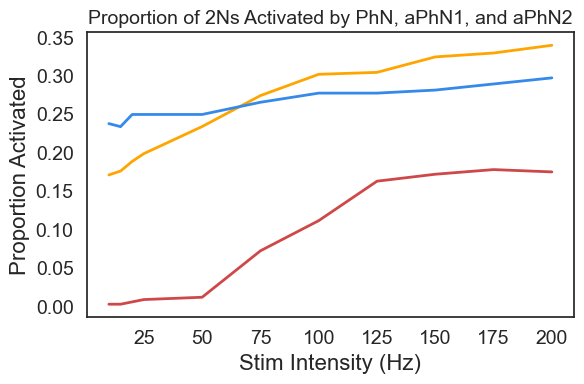

In [32]:
# Define the stimulation intensities
input_intensity = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Function to compute activation proportions
def compute_activation_proportions(df_activation):
    """
    Compute the proportion of activated neurons for different stimulation intensities.

    Parameters:
    - df_activation (pd.DataFrame): Activation DataFrame with "activated" and "non-activated" counts.

    Returns:
    - np.array: Proportions of activated neurons at each intensity.
    """
    # Ensure the DataFrame has both "activated" and "non-activated" rows
    if df_activation.shape[0] < 2:
        return np.zeros(len(input_intensity))  # Return zeros if no activation data

    # Compute activation proportion
    return df_activation.values[1, :] / (df_activation.values[0, :] + df_activation.values[1, :])

# Compute activation proportions for each neuron group
y_PhN = compute_activation_proportions(PhN_df_activation)
y_aPhN1 = compute_activation_proportions(aPhN1_df_activation)
y_aPhN2 = compute_activation_proportions(aPhN2_df_activation)

# Store results in a list for plotting
y_groups = [y_PhN, y_aPhN1, y_aPhN2]
labels = ["PhN", "aPhN1", "aPhN2"]

# Define colors for each neuron group
colors = ["#cf4848", "orange", "#3489eb"]  # Red (PhN), Orange (aPhN1), Blue (aPhN2)

# Initialize the figure
sns.set(style="white")
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each neuron group as a separate line
for i, label in enumerate(labels):
    ax.plot(
        input_intensity,
        y_groups[i],
        label=label,
        color=colors[i],
        linewidth=2
    )

# Configure axes and legend
ax.set_xlabel("Stim Intensity (Hz)", size=16)
ax.set_ylabel("Proportion Activated", size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.2))  # 0, 0.2, 0.4, 0.6, 0.8, 1.0
#ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1, 1))

plt.title("Proportion of 2Ns Activated by PhN, aPhN1, and aPhN2", fontsize=14)
plt.tight_layout()
plt.show()


In [33]:
# Print arrays for proportion of 2Ns activated in each neuron group
print("Proportion of 2Ns activated in PhN:", y_PhN)
print("Proportion of 2Ns activated in aPhN1:", y_aPhN1)
print("Proportion of 2Ns activated in aPhN2:", y_aPhN2)

Proportion of 2Ns activated in PhN: [0.00302115 0.00302115 0.0060423  0.00906344 0.01208459 0.07250755
 0.11178248 0.16314199 0.17220544 0.17824773 0.17522659]
Proportion of 2Ns activated in aPhN1: [0.17128463 0.17632242 0.18891688 0.19899244 0.23425693 0.27455919
 0.302267   0.30478589 0.32493703 0.32997481 0.34005038]
Proportion of 2Ns activated in aPhN2: [0.23809524 0.23412698 0.25       0.25       0.25       0.26587302
 0.27777778 0.27777778 0.28174603 0.28968254 0.29761905]


### Plot how many neurons in the entire brain were activated by SA stimulation

In [34]:
import os
import pandas as pd
import numpy as np


# --- Second-order connectivity analysis function (simplified version) ---
def second_order(neuron_set, set_label):
    """
    Given a neuron set DataFrame (with at least 'root_id'),
    extract second-order connectivity from the global connections dataset.
    (This is a simplified version; adjust as in your full analysis.)
    Returns:
      connectivity: first-order connectivity DataFrame.
      second_orders: aggregated second-order DataFrame with:
         'root_id', f'{set_label}_syn_count' (sum of synapses) and
         'upstream_{set_label}_neurons' (count of unique upstream neurons).
    """
    # Assume 'connections' is already defined globally.
    connectivity = pd.merge(
        neuron_set[['root_id']],
        connections[['pre_root_id', 'post_root_id', 'syn_count']],
        left_on='root_id',
        right_on='pre_root_id',
        how='inner'
    ).query("syn_count >= 5")
    connectivity.drop(columns=['root_id'], inplace=True)
    second_orders = connectivity.groupby("post_root_id").agg({
        'syn_count': 'sum',
        'pre_root_id': 'nunique'
    }).reset_index()
    # Rename columns
    second_orders.columns = ['root_id', f'{set_label}_syn_count', f'upstream_{set_label}_neurons']
    return connectivity, second_orders


# --- Function to add activation columns from simulation files to a 2N DataFrame ---
def load_activation_data_2N(base_df, simulation_path, set_label, rates):
    """
    For a given second-order neuron DataFrame (base_df) and simulation folder,
    add activation columns based on simulation files.

    Files are expected to be named like "{set_label}_{rate}Hz_rates.csv" and contain a column 'flyid'.
    """
    df = base_df.copy().reset_index(drop=True)
    for rate in rates:
        filename = f"{set_label}_{rate}Hz_rates.csv"
        csv_file = os.path.join(simulation_path, filename)
        if os.path.exists(csv_file):
            try:
                act_data = pd.read_csv(csv_file)
                df[f'activation_{rate}Hz'] = df['root_id'].apply(
                    lambda x: 'activated' if x in act_data['flyid'].values else 'non-activated'
                )
            except Exception as e:
                print(f"Error reading {csv_file}: {e}")
        else:
            print(f"Warning: {csv_file} not found. Skipping activation for {rate}Hz.")
    return df


# --- Modified stacking function that accepts a list of columns to keep ---
def stack_activation_data(set_df, set_label, rates, keep_cols):
    """
    Given a 2N DataFrame (set_df) that contains activation columns (e.g. 'activation_10Hz', etc.)
    and a list of columns to keep (e.g. ['root_id', 'PhN_syn_count']),
    stack the data vertically for each stimulation rate.

    It adds helper columns: 'activation', 'rate', 'set', and 'label' (combining set and rate).
    """
    set_df = set_df.reset_index(drop=True)
    activation_frames = []
    for rate in rates:
        col_name = f'activation_{rate}Hz'
        if col_name not in set_df.columns:
            print(f"Warning: {col_name} not found in {set_label}")
            continue
        try:
            temp_df = set_df[keep_cols].copy()
        except KeyError as e:
            print(f"Error: {e}. Check that {keep_cols} are in the DataFrame for {set_label}")
            continue
        col_data = set_df[col_name].squeeze()
        temp_df['activation'] = col_data.values
        temp_df['rate'] = rate
        temp_df['set'] = set_label
        temp_df['label'] = f'{set_label} {rate}Hz'
        activation_frames.append(temp_df)
    if activation_frames:
        return pd.concat(activation_frames, axis=0, ignore_index=True)
    else:
        return pd.DataFrame()


In [35]:
# Define stimulation rates (Hz)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Define file paths for base second-order neuron data.
# (These are the folders containing your SA lists, from which second_order() is run.)
phn_base_path = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2"
aphn1_base_path = "/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_v2"
aphn2_base_path = "/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_v1"

# Define simulation (activation) file paths:
stimulation_paths = {
    "PhN": "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2",
    "aPhN1": "/Users/yaolab/Downloads/taste-connectome-main/aPhN1-SA_simulation_v1",
    "aPhN2": "/Users/yaolab/Downloads/taste-connectome-main/aPhN2-SA_simulation_v1"
}


In [36]:
### Plot how many neurons in the entire brain were activated by PhN-SA, aPhN1-SA, and aPhN2-SA stimulation
PhN_total_activation = PhN_df_activation.iloc[1, :].sum()
aPhN1_total_activation = aPhN1_df_activation.iloc[1, :].sum()
aPhN2_total_activation = aPhN2_df_activation.iloc[1, :].sum()

In [37]:
# Get numbers for proportion of activated neurons in each group
print("PhN_total_activation:", PhN_total_activation)
print("aPhN1_total_activation:", aPhN1_total_activation)
print("aPhN2_total_activation:", aPhN2_total_activation)

PhN_total_activation: 300
aPhN1_total_activation: 1130
aPhN2_total_activation: 734


### Print out the median synapse values for activated vs. non-activated neurons in each modality

In [38]:
# Load the base file for PhN set_1.
phn_set_1_base = pd.read_csv(os.path.join(phn_base_path, "set_1.csv"))

# Run second_order() on this set to produce the 2N DataFrame.
# (second_order() returns (connectivity, second_orders); we use second_orders.)
_, phn_set_1_2Ns = second_order(phn_set_1_base, "PhN")
# At this point, phn_set_1_2Ns should have a column named "PhN_syn_count".

# Add activation columns from simulation files.
phn_set_1_2Ns = load_activation_data_2N(phn_set_1_2Ns, stimulation_paths["PhN"], "set_1", rates)

# Define columns to keep.
keep_columns_PhN = ['root_id', 'PhN_syn_count']

# Stack activation data.
PhN_set_1_activation = stack_activation_data(phn_set_1_2Ns, "set_1", rates, keep_columns_PhN)
print("PhN Set 1 activation columns:")
print(PhN_set_1_activation.columns)

# Compute median synapse counts.
median_synapse_PhN_set1 = PhN_set_1_activation.groupby(['label', 'activation'])['PhN_syn_count'].median()
print("Median synapse counts for PhN Set 1:")
print(median_synapse_PhN_set1)


PhN Set 1 activation columns:
Index(['root_id', 'PhN_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for PhN Set 1:
label        activation   
set_1 100Hz  activated         28.5
             non-activated      9.0
set_1 10Hz   activated        215.0
             non-activated     17.0
set_1 125Hz  activated         18.0
             non-activated      5.0
set_1 150Hz  activated         18.0
             non-activated      5.0
set_1 15Hz   activated        215.0
             non-activated     17.0
set_1 175Hz  activated         18.0
             non-activated      5.0
set_1 200Hz  activated         18.0
             non-activated      5.0
set_1 20Hz   activated        157.0
             non-activated     15.0
set_1 25Hz   activated         99.0
             non-activated     13.0
set_1 50Hz   activated         76.5
             non-activated     10.5
set_1 75Hz   activated         54.0
             non-activated      8.0
Name: PhN_syn_count, dty

In [39]:
phn_set_2_base = pd.read_csv(os.path.join(phn_base_path, "set_2.csv"))
_, phn_set_2_2Ns = second_order(phn_set_2_base, "PhN")
phn_set_2_2Ns = load_activation_data_2N(phn_set_2_2Ns, stimulation_paths["PhN"], "set_2", rates)
keep_columns_PhN = ['root_id', 'PhN_syn_count']
PhN_set_2_activation = stack_activation_data(phn_set_2_2Ns, "set_2", rates, keep_columns_PhN)
print("PhN Set 2 activation columns:")
print(PhN_set_2_activation.columns)
median_synapse_PhN_set2 = PhN_set_2_activation.groupby(['label', 'activation'])['PhN_syn_count'].median()
print("Median synapse counts for PhN Set 2:")
print(median_synapse_PhN_set2)


PhN Set 2 activation columns:
Index(['root_id', 'PhN_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for PhN Set 2:
label        activation   
set_2 100Hz  activated         38.0
             non-activated      7.0
set_2 10Hz   activated        126.0
             non-activated     16.0
set_2 125Hz  activated         35.0
             non-activated      7.0
set_2 150Hz  activated         35.0
             non-activated      7.0
set_2 15Hz   activated        126.0
             non-activated     16.0
set_2 175Hz  activated         35.0
             non-activated      7.0
set_2 200Hz  activated         34.0
             non-activated      7.0
set_2 20Hz   activated         82.0
             non-activated     15.0
set_2 25Hz   activated         80.5
             non-activated     15.0
set_2 50Hz   activated         57.0
             non-activated     12.0
set_2 75Hz   activated         41.0
             non-activated      8.0
Name: PhN_syn_count, dty

In [40]:
phn_set_3_base = pd.read_csv(os.path.join(phn_base_path, "set_3.csv"))
_, phn_set_3_2Ns = second_order(phn_set_3_base, "PhN")
phn_set_3_2Ns = load_activation_data_2N(phn_set_3_2Ns, stimulation_paths["PhN"], "set_3", rates)
keep_columns_PhN = ['root_id', 'PhN_syn_count']
PhN_set_3_activation = stack_activation_data(phn_set_3_2Ns, "set_3", rates, keep_columns_PhN)
print("PhN Set 3 activation columns:")
print(PhN_set_3_activation.columns)
median_synapse_PhN_set3 = PhN_set_3_activation.groupby(['label', 'activation'])['PhN_syn_count'].median()
print("Median synapse counts for PhN Set 3:")
print(median_synapse_PhN_set3)


PhN Set 3 activation columns:
Index(['root_id', 'PhN_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for PhN Set 3:
label        activation   
set_3 100Hz  activated         31.0
             non-activated      6.0
set_3 10Hz   activated        200.0
             non-activated     12.0
set_3 125Hz  activated         21.0
             non-activated      6.0
set_3 150Hz  activated         19.5
             non-activated      6.0
set_3 15Hz   activated        177.0
             non-activated     11.5
set_3 175Hz  activated         18.0
             non-activated      6.0
set_3 200Hz  activated         18.0
             non-activated      6.0
set_3 20Hz   activated        188.5
             non-activated     12.0
set_3 25Hz   activated         84.0
             non-activated     11.0
set_3 50Hz   activated         50.0
             non-activated      8.0
set_3 75Hz   activated         36.0
             non-activated      7.0
Name: PhN_syn_count, dty

In [41]:
phn_set_3_base = pd.read_csv(os.path.join(phn_base_path, "set_3.csv"))
_, phn_set_3_2Ns = second_order(phn_set_3_base, "PhN")
phn_set_3_2Ns = load_activation_data_2N(phn_set_3_2Ns, stimulation_paths["PhN"], "set_3", rates)
keep_columns_PhN = ['root_id', 'PhN_syn_count']
PhN_set_3_activation = stack_activation_data(phn_set_3_2Ns, "set_3", rates, keep_columns_PhN)
print("PhN Set 3 activation columns:")
print(PhN_set_3_activation.columns)
median_synapse_PhN_set3 = PhN_set_3_activation.groupby(['label', 'activation'])['PhN_syn_count'].median()
print("Median synapse counts for PhN Set 3:")
print(median_synapse_PhN_set3)


PhN Set 3 activation columns:
Index(['root_id', 'PhN_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for PhN Set 3:
label        activation   
set_3 100Hz  activated         31.0
             non-activated      6.0
set_3 10Hz   activated        200.0
             non-activated     12.0
set_3 125Hz  activated         21.0
             non-activated      6.0
set_3 150Hz  activated         19.5
             non-activated      6.0
set_3 15Hz   activated        177.0
             non-activated     11.5
set_3 175Hz  activated         18.0
             non-activated      6.0
set_3 200Hz  activated         18.0
             non-activated      6.0
set_3 20Hz   activated        188.5
             non-activated     12.0
set_3 25Hz   activated         84.0
             non-activated     11.0
set_3 50Hz   activated         50.0
             non-activated      8.0
set_3 75Hz   activated         36.0
             non-activated      7.0
Name: PhN_syn_count, dty

In [42]:
phn_set_4_base = pd.read_csv(os.path.join(phn_base_path, "set_4.csv"))
_, phn_set_4_2Ns = second_order(phn_set_4_base, "PhN")
phn_set_4_2Ns = load_activation_data_2N(phn_set_4_2Ns, stimulation_paths["PhN"], "set_4", rates)
keep_columns_PhN = ['root_id', 'PhN_syn_count']
PhN_set_4_activation = stack_activation_data(phn_set_4_2Ns, "set_4", rates, keep_columns_PhN)
print("PhN Set 4 activation columns:")
print(PhN_set_4_activation.columns)
median_synapse_PhN_set4 = PhN_set_4_activation.groupby(['label', 'activation'])['PhN_syn_count'].median()
print("Median synapse counts for PhN Set 4:")
print(median_synapse_PhN_set4)


PhN Set 4 activation columns:
Index(['root_id', 'PhN_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for PhN Set 4:
label        activation   
set_4 100Hz  activated        44.0
             non-activated    12.0
set_4 10Hz   activated        81.0
             non-activated    14.0
set_4 125Hz  activated        44.0
             non-activated    11.0
set_4 150Hz  activated        43.0
             non-activated    11.5
set_4 15Hz   activated        81.0
             non-activated    14.0
set_4 175Hz  activated        42.0
             non-activated    12.0
set_4 200Hz  activated        42.0
             non-activated    11.0
set_4 20Hz   activated        81.0
             non-activated    14.0
set_4 25Hz   activated        75.5
             non-activated    13.0
set_4 50Hz   activated        75.5
             non-activated    13.0
set_4 75Hz   activated        56.5
             non-activated    12.0
Name: PhN_syn_count, dtype: float64


In [43]:
phn_set_5_base = pd.read_csv(os.path.join(phn_base_path, "set_5.csv"))
_, phn_set_5_2Ns = second_order(phn_set_5_base, "PhN")
phn_set_5_2Ns = load_activation_data_2N(phn_set_5_2Ns, stimulation_paths["PhN"], "set_5", rates)
keep_columns_PhN = ['root_id', 'PhN_syn_count']
PhN_set_5_activation = stack_activation_data(phn_set_5_2Ns, "set_5", rates, keep_columns_PhN)
print("PhN Set 5 activation columns:")
print(PhN_set_5_activation.columns)
median_synapse_PhN_set5 = PhN_set_5_activation.groupby(['label', 'activation'])['PhN_syn_count'].median()
print("Median synapse counts for PhN Set 5:")
print(median_synapse_PhN_set5)


PhN Set 5 activation columns:
Index(['root_id', 'PhN_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for PhN Set 5:
label        activation   
set_5 100Hz  activated         46.5
             non-activated      5.5
set_5 10Hz   activated        130.0
             non-activated     15.0
set_5 125Hz  activated         46.5
             non-activated      5.5
set_5 150Hz  activated         31.0
             non-activated      5.0
set_5 15Hz   activated        127.5
             non-activated     15.0
set_5 175Hz  activated         28.0
             non-activated      5.0
set_5 200Hz  activated         27.0
             non-activated      5.0
set_5 20Hz   activated        125.0
             non-activated     15.0
set_5 25Hz   activated        115.0
             non-activated     15.0
set_5 50Hz   activated         94.0
             non-activated     14.0
set_5 75Hz   activated         80.0
             non-activated      8.0
Name: PhN_syn_count, dty

In [44]:
phn_set_6_base = pd.read_csv(os.path.join(phn_base_path, "set_6.csv"))
_, phn_set_6_2Ns = second_order(phn_set_6_base, "PhN")
phn_set_6_2Ns = load_activation_data_2N(phn_set_6_2Ns, stimulation_paths["PhN"], "set_6", rates)
keep_columns_PhN = ['root_id', 'PhN_syn_count']
PhN_set_6_activation = stack_activation_data(phn_set_6_2Ns, "set_6", rates, keep_columns_PhN)
print("PhN Set 6 activation columns:")
print(PhN_set_6_activation.columns)
median_synapse_PhN_set6 = PhN_set_6_activation.groupby(['label', 'activation'])['PhN_syn_count'].median()
print("Median synapse counts for PhN Set 6:")
print(median_synapse_PhN_set6)


PhN Set 6 activation columns:
Index(['root_id', 'PhN_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for PhN Set 6:
label        activation   
set_6 100Hz  activated        53.0
             non-activated    11.0
set_6 10Hz   activated        97.5
             non-activated    27.0
set_6 125Hz  activated        46.0
             non-activated     7.0
set_6 150Hz  activated        42.0
             non-activated     6.0
set_6 15Hz   activated        97.5
             non-activated    27.0
set_6 175Hz  activated        42.0
             non-activated     6.0
set_6 200Hz  activated        42.0
             non-activated     5.5
set_6 20Hz   activated        81.0
             non-activated    20.0
set_6 25Hz   activated        80.0
             non-activated    19.0
set_6 50Hz   activated        58.0
             non-activated    12.0
set_6 75Hz   activated        55.0
             non-activated    10.0
Name: PhN_syn_count, dtype: float64


In [45]:
aPhN1_set_1_base = pd.read_csv(os.path.join(aphn1_base_path, "set_1.csv"))
_, aPhN1_set_1_2Ns = second_order(aPhN1_set_1_base, "aPhN1")
aPhN1_set_1_2Ns = load_activation_data_2N(aPhN1_set_1_2Ns, stimulation_paths["aPhN1"], "set_1", rates)
keep_columns_aPhN1 = ['root_id', 'aPhN1_syn_count']
aPhN1_set_1_activation = stack_activation_data(aPhN1_set_1_2Ns, "set_1", rates, keep_columns_aPhN1)
print("aPhN1 Set 1 activation columns:")
print(aPhN1_set_1_activation.columns)
median_synapse_aPhN1_set1 = aPhN1_set_1_activation.groupby(['label', 'activation'])['aPhN1_syn_count'].median()
print("Median synapse counts for aPhN1 Set 1:")
print(median_synapse_aPhN1_set1)


aPhN1 Set 1 activation columns:
Index(['root_id', 'aPhN1_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for aPhN1 Set 1:
label        activation   
set_1 100Hz  activated        47.5
             non-activated    22.0
set_1 10Hz   activated        47.5
             non-activated    22.0
set_1 125Hz  activated        47.5
             non-activated    22.0
set_1 150Hz  activated        47.5
             non-activated    22.0
set_1 15Hz   activated        47.5
             non-activated    22.0
set_1 175Hz  activated        47.5
             non-activated    22.0
set_1 200Hz  activated        47.5
             non-activated    22.0
set_1 20Hz   activated        47.5
             non-activated    22.0
set_1 25Hz   activated        47.5
             non-activated    22.0
set_1 50Hz   activated        47.5
             non-activated    22.0
set_1 75Hz   activated        47.5
             non-activated    22.0
Name: aPhN1_syn_count, dtype: float64


In [46]:
aPhN1_set_2_base = pd.read_csv(os.path.join(aphn1_base_path, "set_2.csv"))
_, aPhN1_set_2_2Ns = second_order(aPhN1_set_2_base, "aPhN1")
aPhN1_set_2_2Ns = load_activation_data_2N(aPhN1_set_2_2Ns, stimulation_paths["aPhN1"], "set_2", rates)
keep_columns_aPhN1 = ['root_id', 'aPhN1_syn_count']
aPhN1_set_2_activation = stack_activation_data(aPhN1_set_2_2Ns, "set_2", rates, keep_columns_aPhN1)
print("aPhN1 Set 2 activation columns:")
print(aPhN1_set_2_activation.columns)
median_synapse_aPhN1_set2 = aPhN1_set_2_activation.groupby(['label', 'activation'])['aPhN1_syn_count'].median()
print("Median synapse counts for aPhN1 Set 2:")
print(median_synapse_aPhN1_set2)

aPhN1 Set 2 activation columns:
Index(['root_id', 'aPhN1_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for aPhN1 Set 2:
label        activation   
set_2 100Hz  activated         28.0
             non-activated     32.0
set_2 10Hz   activated        150.5
             non-activated     31.0
set_2 125Hz  activated         28.0
             non-activated     32.0
set_2 150Hz  activated         27.0
             non-activated     32.0
set_2 15Hz   activated        150.0
             non-activated     31.5
set_2 175Hz  activated         27.0
             non-activated     32.0
set_2 200Hz  activated         28.0
             non-activated     32.0
set_2 20Hz   activated         88.5
             non-activated     32.0
set_2 25Hz   activated        150.5
             non-activated     31.0
set_2 50Hz   activated         41.0
             non-activated     32.0
set_2 75Hz   activated         28.0
             non-activated     32.0
Name: aPhN1_syn_co

In [47]:
aPhN1_set_3_base = pd.read_csv(os.path.join(aphn1_base_path, "set_3.csv"))
_, aPhN1_set_3_2Ns = second_order(aPhN1_set_3_base, "aPhN1")
aPhN1_set_3_2Ns = load_activation_data_2N(aPhN1_set_3_2Ns, stimulation_paths["aPhN1"], "set_3", rates)
keep_columns_aPhN1 = ['root_id', 'aPhN1_syn_count']
aPhN1_set_3_activation = stack_activation_data(aPhN1_set_3_2Ns, "set_3", rates, keep_columns_aPhN1)
print("aPhN1 Set 3 activation columns:")
print(aPhN1_set_3_activation.columns)
median_synapse_aPhN1_set3 = aPhN1_set_3_activation.groupby(['label', 'activation'])['aPhN1_syn_count'].median()
print("Median synapse counts for aPhN1 Set 3:")
print(median_synapse_aPhN1_set3)


aPhN1 Set 3 activation columns:
Index(['root_id', 'aPhN1_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for aPhN1 Set 3:
label        activation   
set_3 100Hz  activated        12.5
             non-activated    19.0
set_3 10Hz   non-activated    19.0
set_3 125Hz  activated        10.0
             non-activated    19.0
set_3 150Hz  activated        10.0
             non-activated    19.0
set_3 15Hz   non-activated    19.0
set_3 175Hz  activated        10.0
             non-activated    19.0
set_3 200Hz  activated         8.5
             non-activated    19.0
set_3 20Hz   activated        20.0
             non-activated    19.0
set_3 25Hz   activated        20.0
             non-activated    19.0
set_3 50Hz   activated        20.0
             non-activated    19.0
set_3 75Hz   activated        12.5
             non-activated    19.0
Name: aPhN1_syn_count, dtype: float64


In [48]:
aPhN2_set_1_base = pd.read_csv(os.path.join(aphn2_base_path, "set_1.csv"))
_, aPhN2_set_1_2Ns = second_order(aPhN2_set_1_base, "aPhN2")
aPhN2_set_1_2Ns = load_activation_data_2N(aPhN2_set_1_2Ns, stimulation_paths["aPhN2"], "set_1", rates)
keep_columns_aPhN2 = ['root_id', 'aPhN2_syn_count']
aPhN2_set_1_activation = stack_activation_data(aPhN2_set_1_2Ns, "set_1", rates, keep_columns_aPhN2)
print("aPhN2 Set 1 activation columns:")
print(aPhN2_set_1_activation.columns)
median_synapse_aPhN2_set1 = aPhN2_set_1_activation.groupby(['label', 'activation'])['aPhN2_syn_count'].median()
print("Median synapse counts for aPhN2 Set 1:")
print(median_synapse_aPhN2_set1)


aPhN2 Set 1 activation columns:
Index(['root_id', 'aPhN2_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for aPhN2 Set 1:
label        activation   
set_1 100Hz  activated        14.0
             non-activated     7.0
set_1 10Hz   activated         5.0
             non-activated     9.0
set_1 125Hz  activated        14.0
             non-activated     7.0
set_1 150Hz  activated        14.0
             non-activated     7.0
set_1 15Hz   activated         5.0
             non-activated     9.0
set_1 175Hz  activated        14.0
             non-activated     7.0
set_1 200Hz  activated        14.0
             non-activated     7.0
set_1 20Hz   activated         9.5
             non-activated     8.0
set_1 25Hz   activated         9.5
             non-activated     8.0
set_1 50Hz   activated        14.0
             non-activated     7.0
set_1 75Hz   activated        14.0
             non-activated     7.0
Name: aPhN2_syn_count, dtype: float64


In [49]:
aPhN2_set_2_base = pd.read_csv(os.path.join(aphn2_base_path, "set_2.csv"))
_, aPhN2_set_2_2Ns = second_order(aPhN2_set_2_base, "aPhN2")
aPhN2_set_2_2Ns = load_activation_data_2N(aPhN2_set_2_2Ns, stimulation_paths["aPhN2"], "set_2", rates)
keep_columns_aPhN2 = ['root_id', 'aPhN2_syn_count']
aPhN2_set_2_activation = stack_activation_data(aPhN2_set_2_2Ns, "set_2", rates, keep_columns_aPhN2)
print("aPhN2 Set 2 activation columns:")
print(aPhN2_set_2_activation.columns)
median_synapse_aPhN2_set2 = aPhN2_set_2_activation.groupby(['label', 'activation'])['aPhN2_syn_count'].median()
print("Median synapse counts for aPhN2 Set 2:")
print(median_synapse_aPhN2_set2)


aPhN2 Set 2 activation columns:
Index(['root_id', 'aPhN2_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for aPhN2 Set 2:
label        activation   
set_2 100Hz  activated        31.0
             non-activated    48.0
set_2 10Hz   activated        25.0
             non-activated    49.0
set_2 125Hz  activated        28.0
             non-activated    49.5
set_2 150Hz  activated        29.5
             non-activated    48.5
set_2 15Hz   activated        24.5
             non-activated    49.5
set_2 175Hz  activated        42.5
             non-activated    46.5
set_2 200Hz  activated        43.0
             non-activated    46.0
set_2 20Hz   activated        39.0
             non-activated    47.5
set_2 25Hz   activated        38.0
             non-activated    48.0
set_2 50Hz   activated        34.5
             non-activated    48.0
set_2 75Hz   activated        28.0
             non-activated    48.5
Name: aPhN2_syn_count, dtype: float64


In [50]:
aPhN2_set_3_base = pd.read_csv(os.path.join(aphn2_base_path, "set_3.csv"))
_, aPhN2_set_3_2Ns = second_order(aPhN2_set_3_base, "aPhN2")
aPhN2_set_3_2Ns = load_activation_data_2N(aPhN2_set_3_2Ns, stimulation_paths["aPhN2"], "set_3", rates)
keep_columns_aPhN2 = ['root_id', 'aPhN2_syn_count']
aPhN2_set_3_activation = stack_activation_data(aPhN2_set_3_2Ns, "set_3", rates, keep_columns_aPhN2)
print("aPhN2 Set 3 activation columns:")
print(aPhN2_set_3_activation.columns)
median_synapse_aPhN2_set3 = aPhN2_set_3_activation.groupby(['label', 'activation'])['aPhN2_syn_count'].median()
print("Median synapse counts for aPhN2 Set 3:")
print(median_synapse_aPhN2_set3)


aPhN2 Set 3 activation columns:
Index(['root_id', 'aPhN2_syn_count', 'activation', 'rate', 'set', 'label'], dtype='object')
Median synapse counts for aPhN2 Set 3:
label        activation   
set_3 100Hz  activated        24.0
             non-activated    39.0
set_3 10Hz   activated        22.0
             non-activated    32.0
set_3 125Hz  activated        21.0
             non-activated    41.0
set_3 150Hz  activated        25.0
             non-activated    34.0
set_3 15Hz   activated        10.0
             non-activated    35.0
set_3 175Hz  activated        25.0
             non-activated    34.0
set_3 200Hz  activated        25.0
             non-activated    34.0
set_3 20Hz   activated        18.0
             non-activated    35.0
set_3 25Hz   activated        21.0
             non-activated    37.0
set_3 50Hz   activated        25.0
             non-activated    41.0
set_3 75Hz   activated        25.0
             non-activated    41.0
Name: aPhN2_syn_count, dtype: float64


### Make boxplots of activation vs. synapse count for each modality

For each modality and each stimulation rate, we are separating the 2Ns into 2 groups: those that were activated and those that weren't. We are then plotting the median number of input PhN-SA synapses for each of those groups.

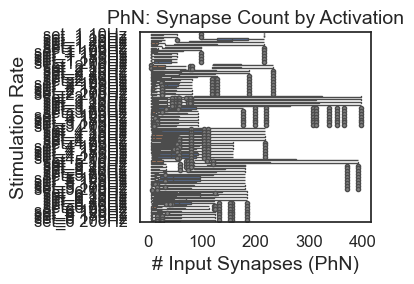

In [51]:

# Combine all PhN per-set activation DataFrames into one.
PhN_activation_combined = pd.concat([
    PhN_set_1_activation,
    PhN_set_2_activation,
    PhN_set_3_activation,
    PhN_set_4_activation,
    PhN_set_5_activation,
    PhN_set_6_activation
], axis=0, ignore_index=True)

# Create a boxplot using the synapse count column.
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
plt.figure(figsize=(4, 3))
ax = sns.boxplot(
    data=PhN_activation_combined,
    x="PhN_syn_count",  # Column with synapse count for PhN
    y="label",  # This column encodes the stimulation rate (e.g. "set_1 10Hz", etc.)
    hue="activation",  # Activation status: "activated" or "non-activated"
    hue_order=["activated", "non-activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (PhN)", fontsize=14)
ax.set_ylabel("Stimulation Rate", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("PhN: Synapse Count by Activation", fontsize=14)
plt.tight_layout()
plt.show()


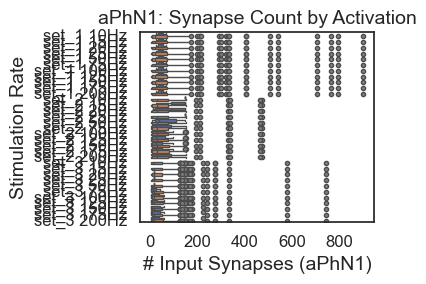

In [52]:

# Combine all aPhN1 per-set activation DataFrames into one.
aPhN1_activation_combined = pd.concat([
    aPhN1_set_1_activation,
    aPhN1_set_2_activation,
    aPhN1_set_3_activation
], axis=0, ignore_index=True)

sns.set(style="white")
plt.figure(figsize=(4, 3))
ax = sns.boxplot(
    data=aPhN1_activation_combined,
    x="aPhN1_syn_count",  # Synapse count column for aPhN1
    y="label",  # e.g., "set_1 10Hz", etc.
    hue="activation",
    hue_order=["activated", "non-activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (aPhN1)", fontsize=14)
ax.set_ylabel("Stimulation Rate", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("aPhN1: Synapse Count by Activation", fontsize=14)
plt.tight_layout()
plt.show()


NameError: name 'set_2_activation_vertically_stacked' is not defined

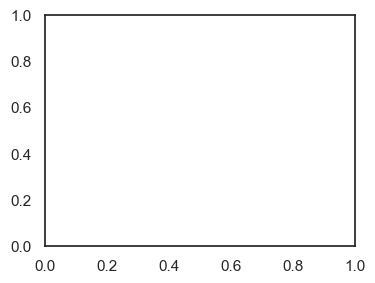

In [53]:
###############################################################################
# Set 2 Boxplot
###############################################################################
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked,
    x="set_2_syn_count",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (Set 2)", fontsize=14)
ax.set_ylabel("Activation Intensity", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
###############################################################################
# Set 3 Boxplot
###############################################################################
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked,
    x="set_3_syn_count",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (Set 3)", fontsize=14)
ax.set_ylabel("Activation Intensity", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

NameError: name 'set_4_activation_vertically_stacked' is not defined

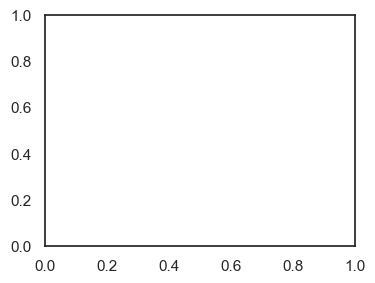

In [54]:
###############################################################################
# Set 4 Boxplot
###############################################################################
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_4_activation_vertically_stacked,
    x="set_4_syn_count",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (Set 4)", fontsize=14)
ax.set_ylabel("Activation Intensity", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

NameError: name 'set_5_activation_vertically_stacked' is not defined

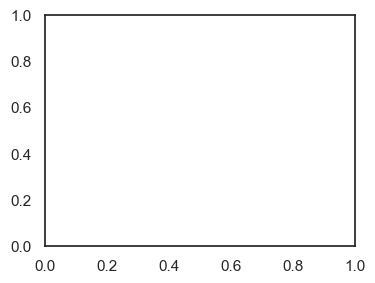

In [55]:
###############################################################################
# Set 5 Boxplot
###############################################################################
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_5_activation_vertically_stacked,
    x="set_5_syn_count",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (Set 5)", fontsize=14)
ax.set_ylabel("Activation Intensity", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

NameError: name 'set_6_activation_vertically_stacked' is not defined

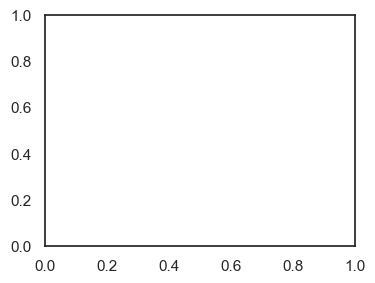

In [56]:
###############################################################################
# Set 6 Boxplot
###############################################################################
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_6_activation_vertically_stacked,
    x="set_6_syn_count",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (Set 6)", fontsize=14)
ax.set_ylabel("Activation Intensity", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 2c. Analyze 2N inputs/outputs and convergence/interactions across modalities

<Figure size 800x800 with 0 Axes>

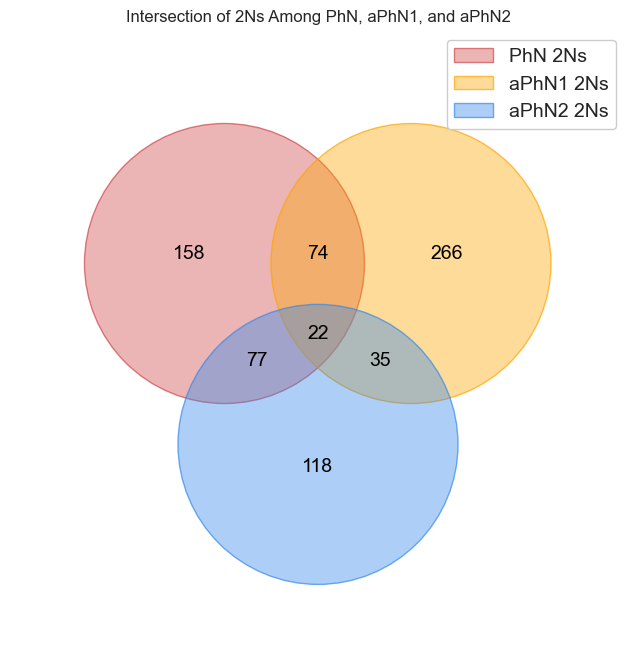

In [57]:
# Convert each group of 2Ns to a Python set of strings
PhN_set = {str(value) for value in PhN_2Ns['root_id'].unique()}
aphn1_set = {str(value) for value in aPhN1_2Ns['root_id'].unique()}
aphn2_set = {str(value) for value in aPhN2_2Ns['root_id'].unique()}

# Combine them into one dictionary
crossover = {
    'PhN 2Ns': PhN_set,
    'aPhN1 2Ns': aphn1_set,
    'aPhN2 2Ns': aphn2_set
}

# Define a color palette for three sets
colors = ['#cf4848', 'orange', '#3489eb']  # adjust colors as desired

plt.figure(figsize=(8, 8))
venn(crossover, cmap=ListedColormap(colors), fontsize=14)
plt.title("Intersection of 2Ns Among PhN, aPhN1, and aPhN2")
plt.show()

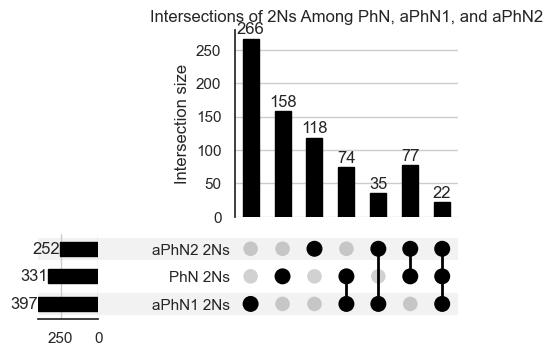

In [58]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings from upsetplot
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt

# Build dictionary from your three groups of 2Ns
contents = {
    'PhN 2Ns': {str(x) for x in PhN_2Ns['root_id'].unique()},
    'aPhN1 2Ns': {str(x) for x in aPhN1_2Ns['root_id'].unique()},
    'aPhN2 2Ns': {str(x) for x in aPhN2_2Ns['root_id'].unique()},
}

# Convert the dictionary into an UpSet-compatible data structure
upset_data = from_contents(contents)

# Create and plot the UpSet plot
upset = UpSet(upset_data, subset_size='count', show_counts=True, element_size=30)
upset.plot()  # No 'style' keyword here
plt.title("Intersections of 2Ns Among PhN, aPhN1, and aPhN2")
plt.show()


### Get downstream connections of 2Ns in order to assess 2N-2N and 2N-PhN-SA connectivity
- minimum of 5 synapses for a connection
- all connections are counted, even if they are connections to PhN-SA or other 2Ns

### Make a Venn diagram to analyze convergence of different PhN-SA sets onto 2Ns

In [60]:
# First, update the neuronal_outputs function to ensure its input is a DataFrame
def neuronal_outputs(neuron_set):
    """
    Given a DataFrame of neurons (with a 'root_id' column), this function merges
    with the connections DataFrame to retrieve downstream outputs that have at least 5 synapses.
    """
    if not isinstance(neuron_set, pd.DataFrame):
        raise TypeError(f"Expected a DataFrame, but got {type(neuron_set)} instead.")

    if 'root_id' not in neuron_set.columns:
        raise KeyError("The input DataFrame is missing the 'root_id' column.")

    # Merge the neuron_set (using its 'root_id') with the connections data.
    connectivity = pd.merge(
        neuron_set[['root_id']],
        connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id',
        right_on='pre_root_id',
        how='inner'
    ).query("syn_count >= 5")  # filter for significant connections

    # Drop the extra 'root_id' column from neuron_set
    connectivity.drop(columns='root_id', inplace=True)

    # Define a function to label connections as local or outside_SEZ
    def projection(neuropil):
        SEZ_regions = ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN']
        return 'local' if neuropil in SEZ_regions else 'outside_SEZ'

    connectivity['location_of_connection'] = connectivity['neuropil'].apply(projection)
    return connectivity

# Get outputs of each 2N population using the neuronal_outputs function
PhN_2N_outputs    = neuronal_outputs(PhN_2Ns)
aPhN1_2N_outputs  = neuronal_outputs(aPhN1_2Ns)
aPhN2_2N_outputs  = neuronal_outputs(aPhN2_2Ns)

# Put the outputs in a list for downstream analysis (e.g., heatmap)
outputs_list = [
    PhN_2N_outputs,
    aPhN1_2N_outputs,
    aPhN2_2N_outputs
]

# Also, put the original neuron sets in a list (if needed later)
sets_list = [
    PhN_2Ns,
    aPhN1_2Ns,
    aPhN2_2Ns
]

print("PhN_2N_outputs shape:", PhN_2N_outputs.shape)
print("aPhN1_2N_outputs shape:", aPhN1_2N_outputs.shape)
print("aPhN2_2N_outputs shape:", aPhN2_2N_outputs.shape)


PhN_2N_outputs shape: (16487, 6)
aPhN1_2N_outputs shape: (16586, 6)
aPhN2_2N_outputs shape: (14084, 6)


### Plot heatmap of all 2N to 2N synapses

In [61]:
# Define function to get data for heatmaps
def _2N_heatmap(twone_outputs, sets_list):
    """
    Given a DataFrame 'twone_outputs' containing 2N connectivity (e.g. from neuronal_outputs),
    merge with each set in 'sets_list' to find connections that end in that set's 2Ns.
    Returns the sum of 'syn_count' for each intersection.
    """
    sums = []
    for target_set in sets_list:
        merged = pd.merge(
            twone_outputs,
            target_set,
            left_on='post_root_id',
            right_on='root_id',
            how='inner'
        )
        sums.append(merged['syn_count'].sum())
    return sums

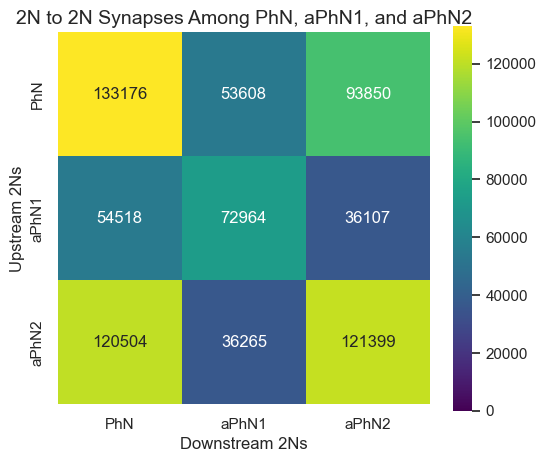

In [62]:
# Build the connectivity matrix for the three groups
matrix_2Ns = []
for outputs_df in outputs_list:
    row_sums = _2N_heatmap(outputs_df, sets_list)
    matrix_2Ns.append(row_sums)

# Convert to a 2D array
matrix_2Ns = np.array(matrix_2Ns)

# Create labels for three groups
row_labels = ["PhN", "aPhN1", "aPhN2"]
col_labels = ["PhN", "aPhN1", "aPhN2"]

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    matrix_2Ns,
    cmap="viridis",
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("2N to 2N Synapses Among PhN, aPhN1, and aPhN2", fontsize=14)
plt.ylabel("Upstream 2Ns", fontsize=12)
plt.xlabel("Downstream 2Ns", fontsize=12)
plt.show()

### Plot heatmap of excitatory 2N to 2N synapses

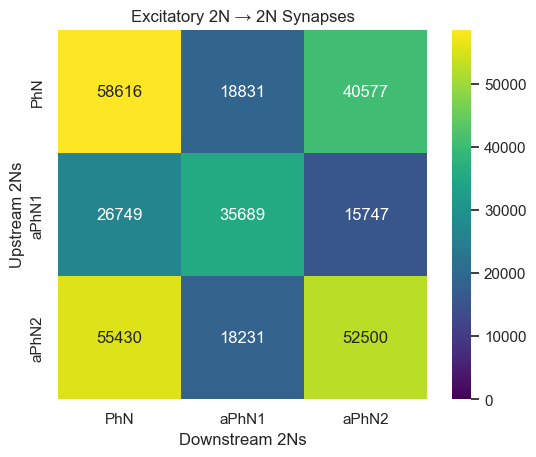

In [63]:
# For excitatory synapses, select only those with nt_type == 'ACH'
# df is a list of all three 2N DataFrames
### Heatmap of Excitatory 2N → 2N Synapses
df = [PhN_2Ns, aPhN1_2Ns, aPhN2_2Ns]

heatmap_exc = [
    _2N_heatmap(PhN_2N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(aPhN1_2N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(aPhN2_2N_outputs.query("nt_type == 'ACH'"), df)
]

labels = ['PhN', 'aPhN1', 'aPhN2']

sns.heatmap(heatmap_exc, cmap='viridis', annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels,
            square=True, vmin=0)
plt.title("Excitatory 2N → 2N Synapses")
plt.ylabel("Upstream 2Ns")
plt.xlabel("Downstream 2Ns")
plt.show()

### Plot heatmap of inhibitory 2N to 2N synapses

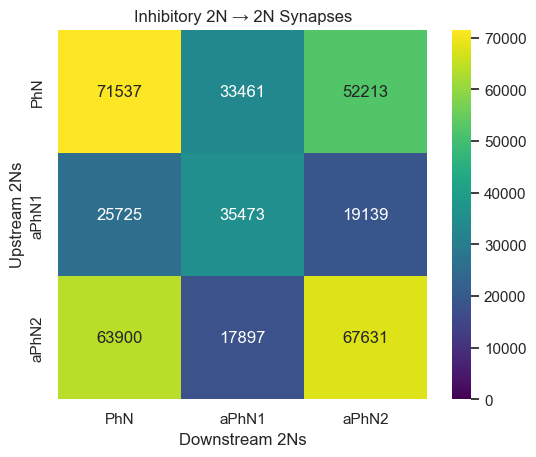

In [64]:
### Heatmap of Inhibitory 2N → 2N Synapses
heatmap_inh = [
    _2N_heatmap(PhN_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(aPhN1_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(aPhN2_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df)
]

sns.heatmap(heatmap_inh, cmap='viridis', annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels,
            square=True, vmin=0)
plt.title("Inhibitory 2N → 2N Synapses")
plt.ylabel("Upstream 2Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


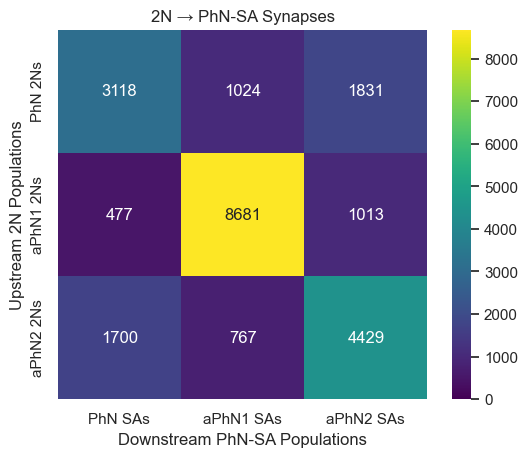

In [65]:
# Define downstream sensory afferent sets explicitly
downstream_SA_sets = [PhN_SAs, aPhN1_SAs, aPhN2_SAs]

# Compute synapse counts from each upstream 2N population to downstream SAs
heatmap_2Ns_PhNSA = [
    _2N_heatmap(PhN_2N_outputs, downstream_SA_sets),
    _2N_heatmap(aPhN1_2N_outputs, downstream_SA_sets),
    _2N_heatmap(aPhN2_2N_outputs, downstream_SA_sets)
]

# Define labels explicitly
row_labels = ["PhN 2Ns", "aPhN1 2Ns", "aPhN2 2Ns"]
col_labels = ["PhN SAs", "aPhN1 SAs", "aPhN2 SAs"]

# Plot the heatmap
sns.heatmap(
    heatmap_2Ns_PhNSA,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("2N → PhN-SA Synapses")
plt.ylabel("Upstream 2N Populations")
plt.xlabel("Downstream PhN-SA Populations")
plt.show()


### Plot heatmap of all 2N to PhN-SA synapses

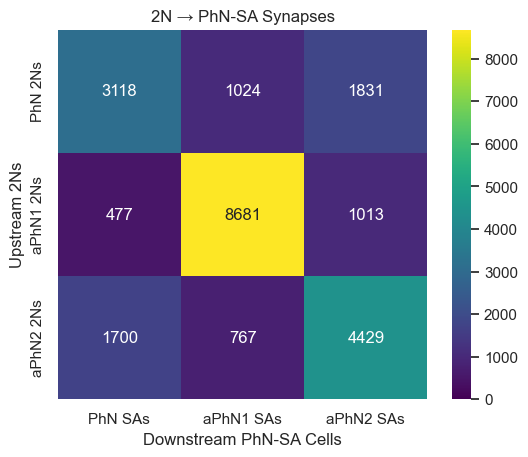

In [66]:
# List of downstream PhN-SA populations
downstream_PhNSA_sets = [PhN_SAs, aPhN1_SAs, aPhN2_SAs]

# Compute total synapses from each upstream 2N population to each downstream PhN-SA population
heatmap_2Ns_PhNSA = [
    _2N_heatmap(PhN_2N_outputs, downstream_SA_sets),
    _2N_heatmap(aPhN1_2N_outputs, downstream_SA_sets),
    _2N_heatmap(aPhN2_2N_outputs, downstream_SA_sets)
]

row_labels = ['PhN 2Ns', 'aPhN1 2Ns', 'aPhN2 2Ns']
col_labels = ['PhN SAs', 'aPhN1 SAs', 'aPhN2 SAs']

sns.heatmap(
    heatmap_2Ns_PhNSA,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("2N → PhN-SA Synapses")
plt.ylabel("Upstream 2Ns")
plt.xlabel("Downstream PhN-SA Cells")
plt.show()

### Plot heatmap of excitatory 2N to PhN-SAs synapses

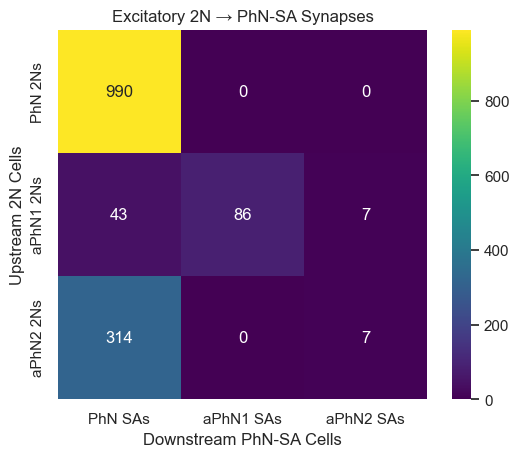

In [67]:
### Heatmap of Excitatory (ACH) 2Ns → PhN-SA Synapses
# For excitatory synapses, select nt_type == 'ACH'
heatmap_2Ns_PhNSA_exc = [
    _2N_heatmap(PhN_2N_outputs.query("nt_type == 'ACH'"), downstream_SA_sets),
    _2N_heatmap(aPhN1_2N_outputs.query("nt_type == 'ACH'"), downstream_SA_sets),
    _2N_heatmap(aPhN2_2N_outputs.query("nt_type == 'ACH'"), downstream_SA_sets)
]

sns.heatmap(
    heatmap_2Ns_PhNSA_exc,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("Excitatory 2N → PhN-SA Synapses")
plt.ylabel("Upstream 2N Cells")
plt.xlabel("Downstream PhN-SA Cells")
plt.show()


### Plot heatmap of inhibitory 2N to PhN-SAs synapses

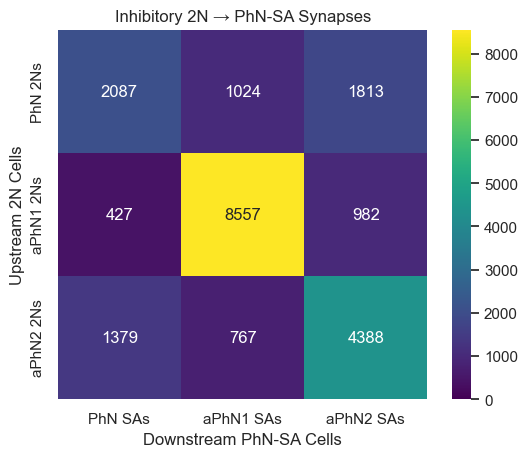

In [68]:
### Heatmap of Inhibitory 2Ns → PhN-SA Synapses (GABA/GLUT)
# For inhibitory synapses, select nt_type in ['GABA','GLUT']
heatmap_2Ns_PhNSA_inh = [
    _2N_heatmap(PhN_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), downstream_SA_sets),
    _2N_heatmap(aPhN1_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), downstream_SA_sets),
    _2N_heatmap(aPhN2_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), downstream_SA_sets)
]

sns.heatmap(
    heatmap_2Ns_PhNSA_inh,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("Inhibitory 2N → PhN-SA Synapses")
plt.ylabel("Upstream 2N Cells")
plt.xlabel("Downstream PhN-SA Cells")
plt.show()

### Make a heatmap to see connectivity from PhN-SA to individual 2Ns

We will plot each individual 2N as a different column and each PhN-SA modality as a different row, then make a heatmap where the color indicates the number of input synapses from each set of PhN-SA onto each 2N.

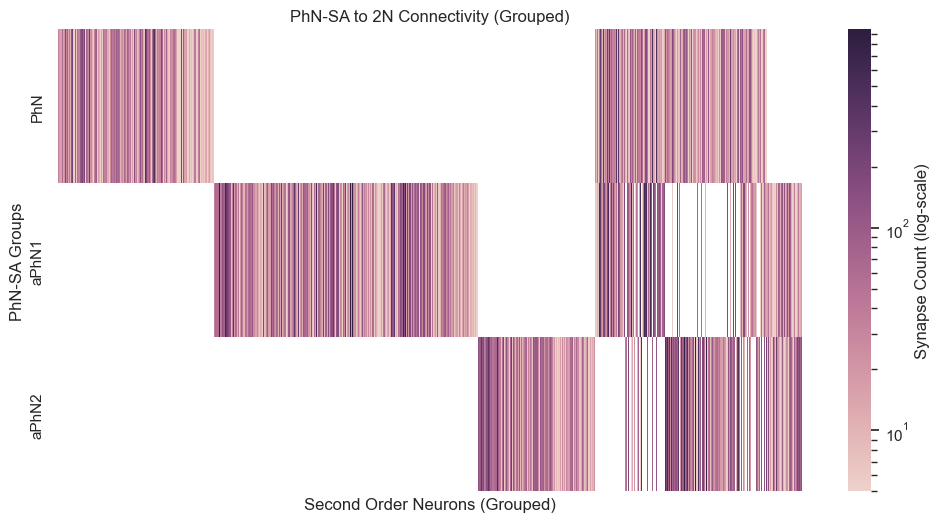

In [69]:
# Concatenate connectivity data from all PhN-SA sets
heatmap_data = pd.concat([
    PhN_second_order_connectivity,
    aPhN1_second_order_connectivity,
    aPhN2_second_order_connectivity
], axis=0)

# Assign postsynaptic neurons (2Ns) to groups based on their original set
heatmap_data['post_root_id_group'] = ''
for entry in heatmap_data['post_root_id']:
    group = ''
    if entry in PhN_2Ns['root_id'].values:
        group += 'PhN'
    if entry in aPhN1_2Ns['root_id'].values:
        group += 'aPhN1'
    if entry in aPhN2_2Ns['root_id'].values:
        group += 'aPhN2'
    if group:
        heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = group

# Assign presynaptic neurons (PhN-SA cells) to groups based on original sets
heatmap_data['pre_root_id_group'] = ''
for entry in heatmap_data['pre_root_id']:
    if entry in PhN_SAs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'PhN'
    elif entry in aPhN1_SAs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'aPhN1'
    elif entry in aPhN2_SAs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'aPhN2'
    else:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'other'

# Define the custom order for PhN-SA and 2N groups
custom_order = ['PhN', 'aPhN1', 'aPhN2']
heatmap_data['post_root_id_group'] = pd.Categorical(heatmap_data['post_root_id_group'], categories=custom_order, ordered=True)
heatmap_data['pre_root_id_group'] = pd.Categorical(heatmap_data['pre_root_id_group'], categories=custom_order, ordered=True)

# Sort by the postsynaptic group for structured visualization
df_sorted = heatmap_data.sort_values(by='post_root_id_group')

# Pivot the DataFrame: Show total synapses from PhN-SA (pre) to each unique 2N (post)
heatmap_matrix = df_sorted.pivot_table(index='pre_root_id_group',
                                       columns='post_root_id',
                                       values='syn_count',
                                       aggfunc='sum',
                                       fill_value=0)

# Sort columns by post-root group
desired_column_order = df_sorted['post_root_id'].unique()
heatmap_matrix = heatmap_matrix[desired_column_order]

# Plot heatmap **without displaying individual neuron root IDs**
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_matrix,
    norm=LogNorm(),
    cmap=sns.cubehelix_palette(as_cmap=True),
    cbar_kws={'label': 'Synapse Count (log-scale)'},
    xticklabels=False  # This removes root ID labels from the x-axis
)

plt.title("PhN-SA to 2N Connectivity (Grouped)")
plt.xlabel("Second Order Neurons (Grouped)")
plt.ylabel("PhN-SA Groups")
plt.show()


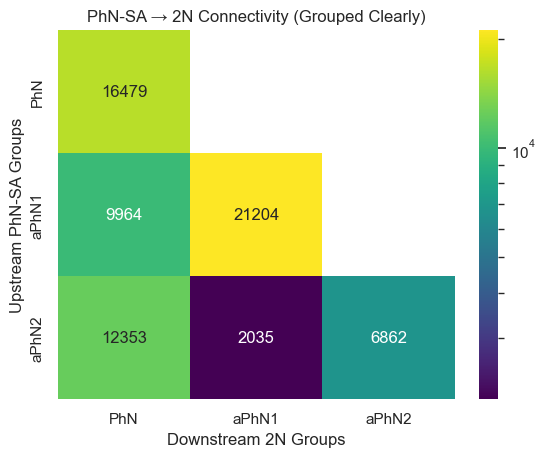

In [70]:
### Heatmap of PhN-SA → Individual 2N Connectivity (Grouped Clearly)

# Concatenate connectivity data from all three PhN-SA groups
heatmap_data = pd.concat([
    PhN_second_order_connectivity,
    aPhN1_second_order_connectivity,
    aPhN2_second_order_connectivity
])


# Assign postsynaptic neuron groups clearly
def assign_post_group(post_id):
    if post_id in set(PhN_2Ns['root_id']):
        return "PhN"
    elif post_id in set(aPhN1_2Ns['root_id']):
        return "aPhN1"
    elif post_id in set(aPhN2_2Ns['root_id']):
        return "aPhN2"
    else:
        return "unknown"


# Assign presynaptic neuron groups (PhN-SA)
def assign_pre_group(pre_id):
    if pre_id in set(PhN_SAs['root_id']):
        return "PhN"
    elif pre_id in set(aPhN1_SAs['root_id']):
        return "aPhN1"
    elif pre_id in set(aPhN2_SAs['root_id']):
        return "aPhN2"
    else:
        return "unknown"


# Apply group assignments
heatmap_data['post_group'] = heatmap_data['post_root_id'].apply(assign_post_group)
heatmap_data['pre_group'] = heatmap_data['pre_root_id'].apply(assign_pre_group)

# Filter out unknown groups
heatmap_data = heatmap_data.query("post_group != 'unknown' and pre_group != 'unknown'")

# Sort by predefined order of post_group and pre_group clearly (but don't explicitly sort by root_ids)
group_order = ['PhN', 'aPhN1', 'aPhN2']
heatmap_data['post_group'] = pd.Categorical(heatmap_data['post_group'], categories=group_order, ordered=True)
heatmap_data['pre_group'] = pd.Categorical(heatmap_data['pre_group'], categories=group_order, ordered=True)

# Pivot the data to make the heatmap
heatmap_matrix = heatmap_data.pivot_table(index='pre_group',
                                          columns='post_group',
                                          values='syn_count',
                                          aggfunc='sum',
                                          fill_value=0)

# Plot the heatmap with Log scale normalization
sns.heatmap(heatmap_matrix, cmap='viridis', annot=True, fmt="d",
            norm=LogNorm(), square=False)

plt.title("PhN-SA → 2N Connectivity (Grouped Clearly)")
plt.xlabel("Downstream 2N Groups")
plt.ylabel("Upstream PhN-SA Groups")
plt.show()


 PhN-SAs## 2d. Analyze 2N inputs within a modality

### First, add columns with % input coming from  PhN-SAs and average of upstream synapses from  PhN-SAs.

In [71]:
# Compute % input to each 2N from its respective PhN-SA group (as % of total input the 2N receives)
PhN_2Ns['%_PhN_input']    = (PhN_2Ns['PhN_syn_count'] / PhN_2Ns['input_synapses']) * 100
aPhN1_2Ns['%_aPhN1_input'] = (aPhN1_2Ns['aPhN1_syn_count'] / aPhN1_2Ns['input_synapses']) * 100
aPhN2_2Ns['%_aPhN2_input'] = (aPhN2_2Ns['aPhN2_syn_count'] / aPhN2_2Ns['input_synapses']) * 100

In [72]:
# Compute the average number of synapses each 2N receives per PhN-SA input cell
PhN_2Ns['avg_upstream_synapses']    = PhN_2Ns['PhN_syn_count'] / PhN_2Ns['upstream_PhN_neurons']
aPhN1_2Ns['avg_upstream_synapses']  = aPhN1_2Ns['aPhN1_syn_count'] / aPhN1_2Ns['upstream_aPhN1_neurons']
aPhN2_2Ns['avg_upstream_synapses']  = aPhN2_2Ns['aPhN2_syn_count'] / aPhN2_2Ns['upstream_aPhN2_neurons']

### Compare the # PhN-SA input cells and the average # synapses per input cell for each 2N

    # First we will make scatter plots comparing these variables for each set.
    # Then we will use ordinary least squares (OLS) regression to determine the r-squared value and p-value.
    # We will also report the median number of input PhN-SAs and the median number of synapses provided.


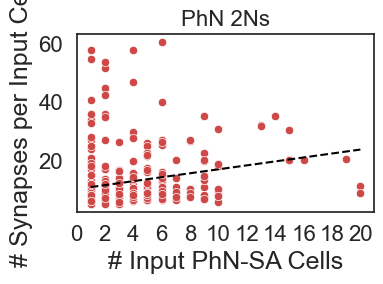

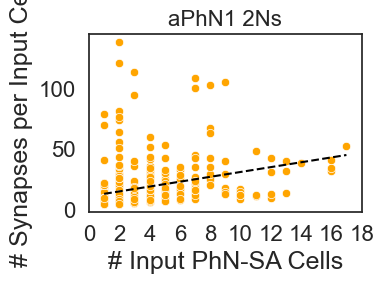

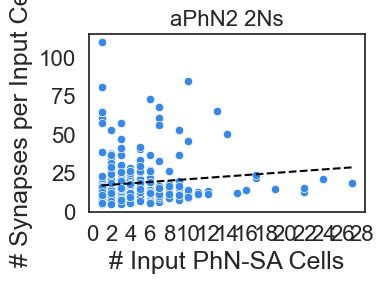

y = 0.68036 * x + 10.19036
y = 1.99547 * x + 11.49806
y = 0.45281 * x + 16.68727


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

def synapse_scatter_2Ns(phnsa_2Ns, group_label, color, title):
    """
    Plot scatter of number of upstream PhN-SA inputs vs. average synapses per input,
    and fit a linear model.

    Parameters:
      - phnsa_2Ns: DataFrame for one 2N population (e.g. PhN_2Ns, aPhN1_2Ns, or aPhN2_2Ns)
      - group_label: a string indicating the group ("PhN", "aPhN1", or "aPhN2")
      - color: color for plotting
      - title: title for the plot

    Returns:
      - fig, ax, and the fitted formula as a string.
    """
    # Construct the column names based on the group label.
    upstream_col = f"upstream_{group_label}_neurons"
    # x = number of upstream PhN-SA inputs (convert to int if needed)
    x = phnsa_2Ns[upstream_col].astype('int')
    # y = average synapses per input cell
    y = phnsa_2Ns['avg_upstream_synapses']

    # Define a linear model for fitting
    def objective(x, a, b):
        return a * x + b

    # Fit the model (ensure there is enough data for curve_fit)
    if len(x) > 1 and len(y) > 1:
        popt, _ = curve_fit(objective, x, y)
        a, b = popt
    else:
        a, b = np.nan, np.nan

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.scatterplot(data=phnsa_2Ns, x=upstream_col, y="avg_upstream_synapses", color=color, ax=ax)
    # Generate line for fitted model
    if not np.isnan(a):
        x_line = np.arange(1, max(x)+1, 1)
        y_line = objective(x_line, a, b)
        ax.plot(x_line, y_line, '--', color='black')
    ax.set_xticks(np.arange(0, max(x)+2, step=2))
    ax.set_xlabel('# Input PhN-SA Cells', size=18)
    ax.set_ylabel('# Synapses per Input Cell', size=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    formula = f'y = {a:.5f} * x + {b:.5f}'
    return fig, ax, formula

# Example usage for each group:
fig1, ax1, formula1 = synapse_scatter_2Ns(PhN_2Ns, "PhN", "#cf4848", "PhN 2Ns")
fig2, ax2, formula2 = synapse_scatter_2Ns(aPhN1_2Ns, "aPhN1", "orange", "aPhN1 2Ns")
fig3, ax3, formula3 = synapse_scatter_2Ns(aPhN2_2Ns, "aPhN2", "#3489eb", "aPhN2 2Ns")

print(formula1)
print(formula2)
print(formula3)


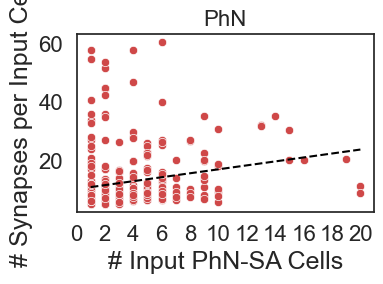

In [74]:
# For PhN:
fig, ax, formula = synapse_scatter_2Ns(PhN_2Ns, 'PhN', '#cf4848', 'PhN')

In [75]:
# OLS regression for PhN
PhN_model = sm.OLS(PhN_2Ns['avg_upstream_synapses'], PhN_2Ns[['const','upstream_PhN_neurons']]).fit()
#the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0
print(PhN_model.summary())

                              OLS Regression Results                             
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.045
Model:                               OLS   Adj. R-squared:                  0.042
Method:                    Least Squares   F-statistic:                     15.44
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):           0.000104
Time:                           01:32:04   Log-Likelihood:                -1233.7
No. Observations:                    331   AIC:                             2471.
Df Residuals:                        329   BIC:                             2479.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

In [76]:
print("PhN slope p-value:", PhN_model.pvalues[1])
print("Median # of input PhN-SAs (PhN):", np.median(PhN_2Ns['upstream_PhN_neurons']))
print("Median # of synapses (PhN):", np.median(PhN_2Ns['PhN_syn_count']))

PhN slope p-value: 0.00010367416038749239
Median # of input PhN-SAs (PhN): 2.0
Median # of synapses (PhN): 23.0


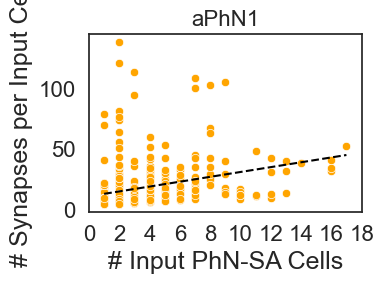

In [77]:
# For aPhN1:
fig, ax, formula = synapse_scatter_2Ns(aPhN1_2Ns, 'aPhN1', 'orange', 'aPhN1')

In [78]:
# OLS regression for aPhN1
aPhN1_model = sm.OLS(aPhN1_2Ns['avg_upstream_synapses'], aPhN1_2Ns[['const','upstream_aPhN1_neurons']]).fit()
print(aPhN1_model.summary())

                              OLS Regression Results                             
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.096
Model:                               OLS   Adj. R-squared:                  0.093
Method:                    Least Squares   F-statistic:                     41.84
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):           2.93e-10
Time:                           01:32:05   Log-Likelihood:                -1711.7
No. Observations:                    397   AIC:                             3427.
Df Residuals:                        395   BIC:                             3435.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [79]:
print("aPhN1 slope p-value:", aPhN1_model.pvalues[1])
print("Median # of input aPhN1-SAs (aPhN1):", np.median(aPhN1_2Ns['upstream_aPhN1_neurons']))
print("Median # of synapses (aPhN1):", np.median(aPhN1_2Ns['aPhN1_syn_count']))

aPhN1 slope p-value: 2.9281149605156916e-10
Median # of input aPhN1-SAs (aPhN1): 2.0
Median # of synapses (aPhN1): 30.0


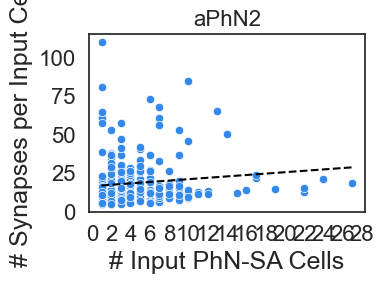

In [80]:
# For aPhN2:
fig, ax, formula = synapse_scatter_2Ns(aPhN2_2Ns, 'aPhN2', '#3489eb', 'aPhN2')

In [81]:
# OLS regression for aPhN2
aPhN2_model = sm.OLS(aPhN2_2Ns['avg_upstream_synapses'], aPhN2_2Ns[['const','upstream_aPhN2_neurons']]).fit()
print(aPhN2_model.summary())

                              OLS Regression Results                             
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.014
Model:                               OLS   Adj. R-squared:                  0.010
Method:                    Least Squares   F-statistic:                     3.480
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):             0.0633
Time:                           01:32:07   Log-Likelihood:                -1056.9
No. Observations:                    252   AIC:                             2118.
Df Residuals:                        250   BIC:                             2125.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [82]:
print("aPhN2 slope p-value:", aPhN2_model.pvalues[1])
print("Median # of input aPhN2-SAs (aPhN2):", np.median(aPhN2_2Ns['upstream_aPhN2_neurons']))
print("Median # of synapses (aPhN2):", np.median(aPhN2_2Ns['aPhN2_syn_count']))

aPhN2 slope p-value: 0.06329965512727233
Median # of input aPhN2-SAs (aPhN2): 3.0
Median # of synapses (aPhN2): 47.5


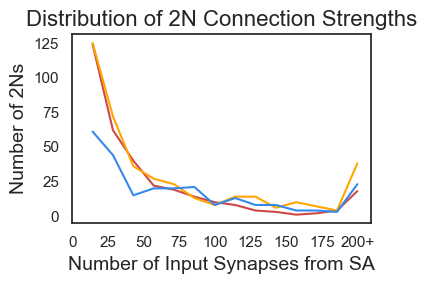

In [83]:
# Define bins (0 to 200, 15 intervals)
bins = np.linspace(0, 200, 15)

def synapse_distribution_2Ns(group_df, group_label):
    """
    Calculate the histogram (distribution) of synapse counts for a given 2N group.

    Parameters:
        group_df: DataFrame containing the 2N data for a given group.
        group_label: string used as a prefix for the synapse count column.
                     Expected to be 'PhN', 'aPhN1', or 'aPhN2'.

    Returns:
        A DataFrame with columns 'labels' (bin upper edges) and 'frequencies'.
    """
    # Get synapse counts for the group (e.g. "PhN_syn_count")
    data = group_df[group_label + '_syn_count']
    # Clip data at 200 and compute histogram
    frequencies, bin_edges = np.histogram(np.clip(data, 0, 200), bins)
    bin_labels = bins[1:]
    df_dist = pd.DataFrame({'labels': bin_labels, 'frequencies': frequencies})
    return df_dist

# Calculate synapse distribution for each group
PhN_synapse_distribution    = synapse_distribution_2Ns(PhN_2Ns, 'PhN')
aPhN1_synapse_distribution  = synapse_distribution_2Ns(aPhN1_2Ns, 'aPhN1')
aPhN2_synapse_distribution  = synapse_distribution_2Ns(aPhN2_2Ns, 'aPhN2')

# Organize data and parameters for plotting
dataframes = [PhN_synapse_distribution, aPhN1_synapse_distribution, aPhN2_synapse_distribution]
labels = ['PhN', 'aPhN1', 'aPhN2']
colors = ['#cf4848', 'orange', '#3489eb']

plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

# Set x-axis ticks and labels
xticks = [0, 25, 50, 75, 100, 125, 150, 175, 200]
xlabels = ['0', '25', '50', '75', '100', '125', '150', '175', '200+']
plt.xticks(xticks, xlabels)
plt.xlabel('Number of Input Synapses from SA', fontsize=14)
plt.ylabel('Number of 2Ns', fontsize=14)
plt.title('Distribution of 2N Connection Strengths', fontsize=16)
#plt.legend(frameon=False, bbox_to_anchor=(1.5, 1), fontsize=12)
plt.tight_layout()
plt.show()


## 2e. Classifying 2Ns by their anatomical and functional properties

### First, we will define 2Ns as local vs. projection neurons.
- Local neurons have output connections only in the SEZ (defined as including GNG, PRW, SAD, FLA, CAN)
- Projection neurons have at least one output connection (comprising at least 5 synapses) in another brain region

In [84]:
def classify_neurons(neurons):
    # Merge with connections to get connectivity data for neurons (2Ns)
    neurons_classified = pd.merge(neurons[['root_id']],
                                  connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
                                  left_on='root_id',
                                  right_on='pre_root_id',
                                  how='inner').query("syn_count >= 5")

    # Function to determine if a connection is local (in SEZ) or not
    def projection(neuropil):
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN']:
            return 'local'
        else:
            return 'outside_SEZ'

    neurons_classified['location_of_connection'] = neurons_classified['neuropil'].apply(projection)

    classifications = []
    # Loop over unique presynaptic IDs (from the connectivity data)
    for entry in neurons_classified['pre_root_id'].unique():
        # If there is at least one non-local connection, classify as 'projection'
        if entry in neurons_classified.query("location_of_connection != 'local'")['pre_root_id'].unique():
            classification = pd.DataFrame({
                'root_id': [entry],
                'neuron_type': ['projection'],
                '#_projection_synapses': [neurons_classified.query(f"pre_root_id == {entry} & location_of_connection != 'local'")['syn_count'].sum()]
            })
        else:
            classification = pd.DataFrame({
                'root_id': [entry],
                'neuron_type': ['local'],
                '#_projection_synapses': [neurons_classified.query(f"pre_root_id == {entry} & location_of_connection != 'local'")['syn_count'].sum()]
            })
        classifications.append(classification)

    result = pd.concat(classifications, ignore_index=True)
    return result


In [85]:
# Merge classification results into each 2N group and save CSVs
PhN_2Ns = pd.merge(PhN_2Ns, classify_neurons(PhN_2Ns), on='root_id')
aPhN1_2Ns = pd.merge(aPhN1_2Ns, classify_neurons(aPhN1_2Ns), on='root_id')
aPhN2_2Ns = pd.merge(aPhN2_2Ns, classify_neurons(aPhN2_2Ns), on='root_id')

In [86]:
PhN_2Ns.to_csv('PhN_2Ns.csv', index=False)
aPhN1_2Ns.to_csv('aPhN1_2Ns.csv', index=False)
aPhN2_2Ns.to_csv('aPhN2_2Ns.csv', index=False)

### Comparing the number of local vs. projection 2Ns across modalities

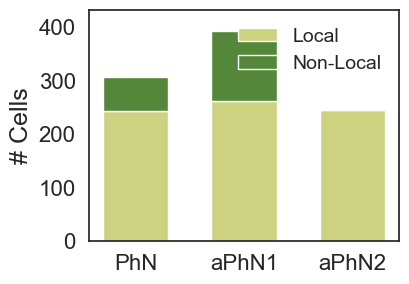

In [87]:
# Define groups and organize datasets for the three 2N populations
categories = ['PhN', 'aPhN1', 'aPhN2']
datasets = [PhN_2Ns, aPhN1_2Ns, aPhN2_2Ns]

local_neurons = []
projection_neurons = []
for dataset in datasets:
    local_neurons.append(len(dataset.query("neuron_type == 'local'")))
    projection_neurons.append(len(dataset.query("neuron_type == 'projection'")))

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, len(categories) + 1)
bar_width = 0.6

ax1 = ax.bar(bar_l, local_neurons, width=bar_width, color='#CCD27F')
ax2 = ax.bar(bar_l, projection_neurons, bottom=local_neurons, width=bar_width, color='#54873A')

ax.set_ylabel('# Cells', fontsize=18)
ax.legend(['Local', 'Non-Local'], frameon=False, fontsize=14)
plt.ylim(0, max(np.array(local_neurons) + np.array(projection_neurons)) * 1.1)
plt.xticks(bar_l, categories, fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [89]:
# Show numbers of local and projection neurons
print("Local neurons per group:", local_neurons)
print("Projection neurons per group:", projection_neurons)

Local neurons per group: [242, 262, 244]
Projection neurons per group: [65, 131, 3]


In [90]:
# Compute % input and average synapses per input cell for each 2N group.
# (Make sure the appropriate column names exist in each DataFrame.)

PhN_2Ns['%_PhN_input']    = (PhN_2Ns['PhN_syn_count'] / PhN_2Ns['input_synapses']) * 100
aPhN1_2Ns['%_aPhN1_input'] = (aPhN1_2Ns['aPhN1_syn_count'] / aPhN1_2Ns['input_synapses']) * 100
aPhN2_2Ns['%_aPhN2_input'] = (aPhN2_2Ns['aPhN2_syn_count'] / aPhN2_2Ns['input_synapses']) * 100

PhN_2Ns['avg_upstream_synapses']    = PhN_2Ns['PhN_syn_count'] / PhN_2Ns['upstream_PhN_neurons']
aPhN1_2Ns['avg_upstream_synapses']  = aPhN1_2Ns['aPhN1_syn_count'] / aPhN1_2Ns['upstream_aPhN1_neurons']
aPhN2_2Ns['avg_upstream_synapses']  = aPhN2_2Ns['aPhN2_syn_count'] / aPhN2_2Ns['upstream_aPhN2_neurons']

### Comparing the number of 2N output synapses within versus outside the SEZ across modalities

We are using the "2N_outputs" lists that were defined earlier, which could include synapses to PhN-SA or other 2Ns.

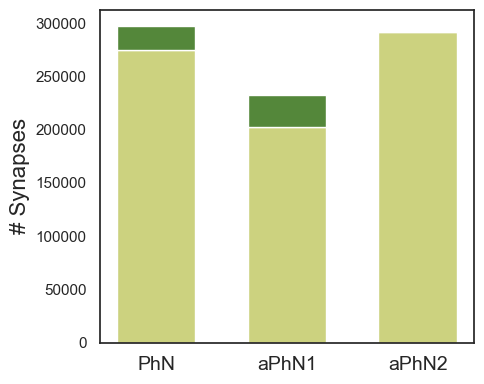

In [91]:
### Compare the number of local vs. projection synapses in each 2N population (using three groups)

# Define categories and corresponding datasets (using three groups)
categories = ['PhN', 'aPhN1', 'aPhN2']
datasets = [PhN_2N_outputs, aPhN1_2N_outputs, aPhN2_2N_outputs]

local_synapses = []
projection_synapses = []

# For each dataset (group), compute the total synapse count for "local" connections (SEZ)
# and then compute projection (Non-SEZ) synapses as the remainder.
for dataset in datasets:
    local_count = dataset.query("neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN']")['syn_count'].sum()
    total = dataset['syn_count'].sum()
    projection_count = total - local_count
    local_synapses.append(local_count)
    projection_synapses.append(projection_count)

# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
# Use np.arange with length equal to number of groups (0, 1, 2)
bar_l = np.arange(len(categories))
bar_width = 0.6

# Plot the stacked bars: local (SEZ) on bottom, projection (Non-SEZ) on top
ax.bar(bar_l, local_synapses, width=bar_width, color='#CCD27F', label='SEZ')
ax.bar(bar_l, projection_synapses, bottom=local_synapses, width=bar_width, color='#54873A', label='Non-SEZ')

ax.set_ylabel('# Synapses', fontsize=16)
ax.set_xticks(bar_l)
ax.set_xticklabels(categories, fontsize=14)
#ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.5, 1.1))
plt.tight_layout()
plt.show()


In [92]:
# Show numbers of local and projection outputs
print(local_synapses)
print(projection_synapses)

[np.int64(275142), np.int64(201991), np.int64(291338)]
[np.int64(22207), np.int64(30133), np.int64(185)]


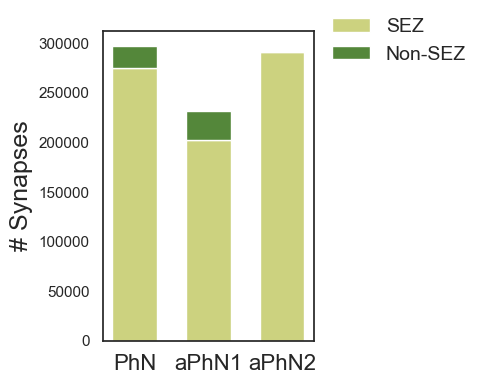

In [93]:
# Define categories and datasets clearly
categories = ['PhN', 'aPhN1', 'aPhN2']
datasets = [PhN_2N_outputs, aPhN1_2N_outputs, aPhN2_2N_outputs]

local_synapses = []
projection_synapses = []

# Calculate local (SEZ) and projection (Non-SEZ) synapses
for dataset in datasets:
    local_synapses.append(dataset.query("location_of_connection == 'local'")['syn_count'].sum())
    projection_synapses.append(dataset.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum())

# Plot the synapse distribution
fig, ax = plt.subplots(figsize=(5, 4))
bar_l = np.arange(len(categories))
bar_width = 0.6

ax.bar(bar_l, local_synapses, width=bar_width, color='#CCD27F', label='SEZ')
ax.bar(bar_l, projection_synapses, bottom=local_synapses, width=bar_width, color='#54873A', label='Non-SEZ')

ax.set_ylabel('# Synapses', fontsize=18)
ax.set_xticks(bar_l)
ax.set_xticklabels(categories, fontsize=16)
ax.legend(frameon=False, fontsize=14, bbox_to_anchor=(1, 1.1))

plt.tight_layout()
plt.show()

### Identify 2N superclasses

There are 9 superclasses defined in the connectome, based on gross anatomy. These include neurons that are intrinsic to the brain (central brain neurons, optic lobe neurons, and neurons connecting the optic lobes and central brain), neurons that have connections outside the brain (sensory, motor, ascending, descending), and endocrine neurons. See connectome papers (Dorkenwald et al. and Schlegel et al., 2024) for specific definitions.

In [94]:
### Merging 2N root IDs with classification data for each group

# Merge unique 2N root_ids from each group with classification_other

PhN_2Ns_classified = pd.merge(
    pd.DataFrame({'root_id': PhN_2Ns['root_id'].unique()}),
    classification_other,
    on='root_id',
    how='left'
)

aPhN1_2Ns_classified = pd.merge(
    pd.DataFrame({'root_id': aPhN1_2Ns['root_id'].unique()}),
    classification_other,
    on='root_id',
    how='left'
)

aPhN2_2Ns_classified = pd.merge(
    pd.DataFrame({'root_id': aPhN2_2Ns['root_id'].unique()}),
    classification_other,
    on='root_id',
    how='left'
)

# Optionally check how many classified vs. not classified
print("PhN_2Ns_classified shape:", PhN_2Ns_classified.shape)
print("aPhN1_2Ns_classified shape:", aPhN1_2Ns_classified.shape)
print("aPhN2_2Ns_classified shape:", aPhN2_2Ns_classified.shape)

# Each *_classified DataFrame should now contain 'root_id', 'class', and 'super_class' columns (if they exist in classification_other).


PhN_2Ns_classified shape: (307, 3)
aPhN1_2Ns_classified shape: (393, 3)
aPhN2_2Ns_classified shape: (247, 3)


In [95]:
# Get unique superclass categories from the classification_other dataset
categories = classification_other.super_class.dropna().unique()
print("Superclasses found:", categories)

Superclasses found: ['optic' 'central' 'descending' 'visual_projection' 'sensory' 'ascending'
 'visual_centrifugal' 'motor' 'endocrine']


In [96]:
# Reorder the superclasses in the desired order.
categories = ['sensory', 'ascending', 'central',
              'descending', 'motor', 'endocrine',
              'optic', 'visual_projection', 'visual_centrifugal']
print("Ordered superclasses:", categories)

Ordered superclasses: ['sensory', 'ascending', 'central', 'descending', 'motor', 'endocrine', 'optic', 'visual_projection', 'visual_centrifugal']


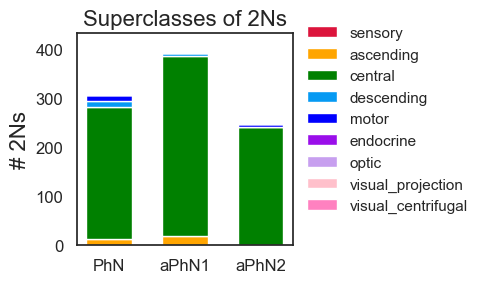

In [97]:
### Plot graph of superclasses for 2Ns in PhN, aPhN1, aPhN2

# Define the datasets
datasets = [
    PhN_2Ns_classified,
    aPhN1_2Ns_classified,
    aPhN2_2Ns_classified
]

# Count superclasses for each dataset
datasets_counts = [
    ds['super_class'].dropna().value_counts() for ds in datasets
]

# Define the desired order of superclasses
categories = [
    'sensory',
    'ascending',
    'central',
    'descending',
    'motor',
    'endocrine',
    'optic',
    'visual_projection',
    'visual_centrifugal'
]

# Store counts for each superclass across datasets
array_plot = []
for superclass in categories:
    row_counts = [ds_count.get(superclass, 0) for ds_count in datasets_counts]
    array_plot.append(np.array(row_counts))

# Convert list to NumPy array (shape: 9 superclasses × 3 datasets)
array_plot = np.array(array_plot)

# Define labels for PhN, aPhN1, aPhN2
set_labels = ["PhN", "aPhN1", "aPhN2"]

# Plot settings
fig, ax = plt.subplots(figsize=(5, 3))
bar_positions = np.arange(len(set_labels)) + 1  # [1,2,3]
bar_width = 0.6

# Define a color palette for the 9 superclasses
palette = [
    '#dc143c',  # sensory
    '#ffa500',  # ascending
    'green',  # central
    '#069af3',  # descending
    '#0000ff',  # motor
    '#9a0eea',  # endocrine
    '#c79fef',  # optic
    '#ffc0cb',  # visual_projection
    '#ff81c0'  # visual_centrifugal
]

# Create stacked bar plot
stack_totals = np.zeros(len(set_labels))  # Track cumulative heights

for i, superclass in enumerate(categories):
    ax.bar(
        bar_positions,
        array_plot[i],  # Counts for the current superclass
        bottom=stack_totals,
        width=bar_width,
        color=palette[i],
        label=superclass  # Add labels for legend
    )
    stack_totals += array_plot[i]  # Update stack

# Axis labels and title
ax.set_title('Superclasses of 2Ns', fontsize=16)
ax.set_ylabel('# 2Ns', fontsize=16)

# Create a legend with the categories
ax.legend(
    categories,
    loc='upper left',
    bbox_to_anchor=(1, 1.1),
    frameon=False,
    fontsize=11
)

# X-axis labels and formatting
plt.xticks(bar_positions, set_labels, fontsize=12)
plt.yticks(fontsize=12)

# Adjust y-limit
plt.ylim(0, np.max(stack_totals) * 1.1)

plt.tight_layout()
plt.show()


In [98]:
# Convert raw counts to proportions (column-wise)
# array_plot has shape (9,6) => 9 superclasses, 6 sets
col_sums = array_plot.sum(axis=0)  # sum over rows => shape (6,)
array_plot_prop = (array_plot / col_sums) * 100.0  # percentage

print("Proportions (as %):")
print(array_plot_prop)

# Then you can plot array_plot_prop the same way you plotted array_plot,
# just changing the bar heights and the y-axis label to "% 2Ns".


Proportions (as %):
[[ 0.          0.          0.        ]
 [ 3.58306189  4.8346056   0.        ]
 [87.94788274 93.12977099 97.1659919 ]
 [ 3.90879479  2.03562341  0.4048583 ]
 [ 4.56026059  0.          2.4291498 ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [99]:
# Once you have array_plot (counts) or array_plot_prop (percentages),
# you can look at them directly:

print("array_plot (raw counts)\n", array_plot)
print("\narray_plot_prop (percent):\n", array_plot_prop)


array_plot (raw counts)
 [[  0   0   0]
 [ 11  19   0]
 [270 366 240]
 [ 12   8   1]
 [ 14   0   6]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]]

array_plot_prop (percent):
 [[ 0.          0.          0.        ]
 [ 3.58306189  4.8346056   0.        ]
 [87.94788274 93.12977099 97.1659919 ]
 [ 3.90879479  2.03562341  0.4048583 ]
 [ 4.56026059  0.          2.4291498 ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [100]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

array([[0.        , 0.        , 0.        ],
       [0.03583062, 0.04834606, 0.        ],
       [0.87947883, 0.93129771, 0.97165992],
       [0.03908795, 0.02035623, 0.00404858],
       [0.04560261, 0.        , 0.0242915 ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

### Plot proportions of ascending and descending neurons

This figure is not included in the paper as it is redundant with the superclass figure above.

In [101]:
### Identify ascending and descending neurons for PhN, aPhN1, and aPhN2

# Define datasets for PhN, aPhN1, and aPhN2
datasets = [
    PhN_2Ns_classified,
    aPhN1_2Ns_classified,
    aPhN2_2Ns_classified
]

# Labels for groups
categories = ["PhN", "aPhN1", "aPhN2"]

# Lists to store results
num_ANs_2Ns = []
num_DNs_2Ns = []
perc_ANs_2Ns = []
perc_DNs_2Ns = []

# Loop through datasets and compute counts and percentages
for ds in datasets:
    num_ANs = (ds['super_class'] == 'ascending').sum()  # Count ascending neurons
    num_DNs = (ds['super_class'] == 'descending').sum()  # Count descending neurons

    num_ANs_2Ns.append(num_ANs)
    num_DNs_2Ns.append(num_DNs)

    total_2Ns = len(ds)
    perc_ANs_2Ns.append(num_ANs / total_2Ns if total_2Ns > 0 else 0)
    perc_DNs_2Ns.append(num_DNs / total_2Ns if total_2Ns > 0 else 0)

# Print results
print('# Ascending neurons (ANs):', num_ANs_2Ns)
print('# Descending neurons (DNs):', num_DNs_2Ns)
print('% Ascending neurons:', perc_ANs_2Ns)
print('% Descending neurons:', perc_DNs_2Ns)

# Ascending neurons (ANs): [np.int64(11), np.int64(19), np.int64(0)]
# Descending neurons (DNs): [np.int64(12), np.int64(8), np.int64(1)]
% Ascending neurons: [np.float64(0.035830618892508145), np.float64(0.04834605597964377), np.float64(0.0)]
% Descending neurons: [np.float64(0.03908794788273615), np.float64(0.020356234096692113), np.float64(0.004048582995951417)]


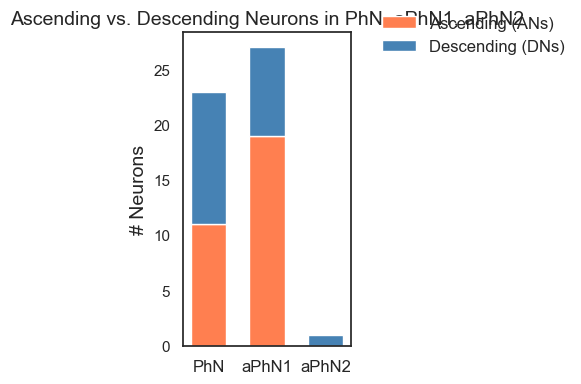

In [102]:
### Plot bar graph for ANs and DNs in PhN, aPhN1, and aPhN2

# Plot bar chart
fig, ax = plt.subplots(figsize=(5, 4))
bar_positions = np.arange(len(categories)) + 1
bar_width = 0.6

# Plot bars
ax.bar(bar_positions, num_ANs_2Ns, width=bar_width, color='#ff7f50', label='Ascending (ANs)')
ax.bar(bar_positions, num_DNs_2Ns, width=bar_width, bottom=num_ANs_2Ns, color='#4682b4', label='Descending (DNs)')

# Labels and formatting
ax.set_ylabel('# Neurons', fontsize=14)
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.1, 1.1))
plt.title("Ascending vs. Descending Neurons in PhN, aPhN1, aPhN2", fontsize=14)
plt.tight_layout()
plt.show()

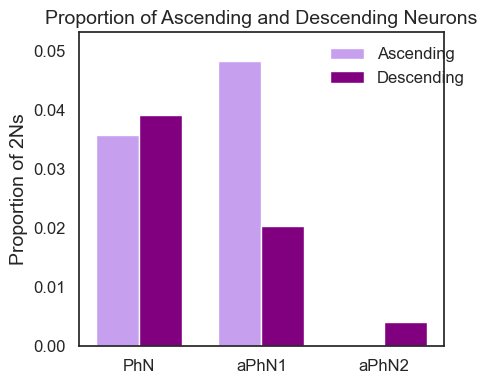

In [103]:
### Plot proportions of Ascending (ANs) and Descending (DNs) neurons for PhN, aPhN1, and aPhN2

# Define categories and x-axis positions
categories = ['PhN', 'aPhN1', 'aPhN2']
x = np.arange(len(categories))  # Positions for bars
bar_width = 0.35

plt.figure(figsize=(5, 4))

# Plot ascending proportions
plt.bar(x, perc_ANs_2Ns, width=bar_width, label="Ascending", color='#c79fef')

# Plot descending proportions, side-by-side
plt.bar(x + bar_width, perc_DNs_2Ns, width=bar_width, label="Descending", color='#800080')

# Labels and formatting
plt.ylabel('Proportion of 2Ns', fontsize=14)
plt.xticks(x + bar_width / 2, categories, fontsize=12)  # Centered xticks
plt.yticks(fontsize=12)
plt.ylim(0, max(max(perc_ANs_2Ns), max(perc_DNs_2Ns)) * 1.1)  # Set y-limit dynamically
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.1, 1))

plt.title("Proportion of Ascending and Descending Neurons", fontsize=14)
plt.tight_layout()
plt.show()


### Identify 2N classes

"Class" is a much more specific category than "superclass" and refers to groupings of neurons that have been characterized in the literature. Less than 50% of all central neurons have been assigned a class, so many neurons will not be represented in these analyses.

See Schlegel et al. (2024) for more information about classes. Be aware that some of the class annotations have changed in newer versions of the connectome dataset.

In [104]:
### Extract class distributions for PhN, aPhN1, and aPhN2

# 1. Construct a master list of all unique classes found across PhN, aPhN1, and aPhN2
categories = np.unique([
    *PhN_2Ns_classified['class'].dropna().unique(),
    *aPhN1_2Ns_classified['class'].dropna().unique(),
    *aPhN2_2Ns_classified['class'].dropna().unique()
])

# 2. Compute class distributions for each dataset
datasets = [PhN_2Ns_classified, aPhN1_2Ns_classified, aPhN2_2Ns_classified]
datasets_counts = [ds['class'].dropna().value_counts() for ds in datasets]

# 3. Compile data into a list of arrays, one array per class (length = 3 for each group)
array_plot = []
for class_name in categories:
    counts_per_dataset = []
    for ds_count in datasets_counts:
        counts_per_dataset.append(ds_count.get(class_name, 0))  # Get count or default to 0
    array_plot.append(np.array(counts_per_dataset))

# 4. Filter out rare classes (optional)
thresh = 1  # Keep classes appearing at least once
filtered_classes = [arr for arr in array_plot if np.count_nonzero(arr >= thresh) > 0]
categories_filtered = [categories[i] for i, arr in enumerate(array_plot) if np.count_nonzero(arr >= thresh) > 0]

# 5. Compute summary statistics
total_inputs_per_group = np.sum(array_plot, axis=0)
covered_inputs_per_group = np.sum(filtered_classes, axis=0)

# Compute fraction of covered inputs, avoiding division by zero
fraction_covered = np.divide(
    covered_inputs_per_group, total_inputs_per_group,
    out=np.zeros_like(covered_inputs_per_group, dtype=float),
    where=(total_inputs_per_group != 0)
)

# Print results
print('Number of classes after filtering:', len(categories_filtered))
print('Total inputs per group:', total_inputs_per_group)
print('Covered inputs per group:', covered_inputs_per_group)
print('Fraction of inputs covered by group:', fraction_covered)
print('Classes kept:', categories_filtered)


Number of classes after filtering: 4
Total inputs per group: [12 68  1]
Covered inputs per group: [12 68  1]
Fraction of inputs covered by group: [1. 1. 1.]
Classes kept: [np.str_('ALON'), np.str_('ALPN'), np.str_('AN'), np.str_('mAL')]


In [105]:
### Reorder & Process Classes for PhN, aPhN1, and aPhN2

# 1. Define the sorted order of neuron classes
categories_sorted = ['gustatory', 'AN', 'DN', 'ALPN']  # Modify based on actual categories

# 2. Compute class distributions for each dataset
datasets = [PhN_2Ns_classified, aPhN1_2Ns_classified, aPhN2_2Ns_classified]
datasets_counts = [ds['class'].dropna().value_counts() for ds in datasets]

# 3. Rebuild sorted class distributions using categories_sorted
array_plot_sorted = []
for class_name in categories_sorted:
    arr_counts = [ds_count.get(class_name, 0) for ds_count in datasets_counts]
    array_plot_sorted.append(np.array(arr_counts))

# 4. Count total 2Ns per dataset
num_2Ns = [len(ds) for ds in datasets]

# 5. Compute unknown class as: Total 2Ns - Sum of known classes
sum_known = np.sum(array_plot_sorted, axis=0)  # Sum over known categories
num_unknown = np.array(num_2Ns) - sum_known  # Compute unknown class
array_plot_sorted.append(num_unknown)

# 6. Append "unknown" to categories_sorted
categories_sorted.append('unknown')

# Print summary statistics
print("Final Categories:", categories_sorted)
print("Class Distribution per Group:")
for class_name, counts in zip(categories_sorted, array_plot_sorted):
    print(f"{class_name}: {counts}")


Final Categories: ['gustatory', 'AN', 'DN', 'ALPN', 'unknown']
Class Distribution per Group:
gustatory: [0 0 0]
AN: [11 19  0]
DN: [0 0 0]
ALPN: [1 3 0]
unknown: [295 371 247]


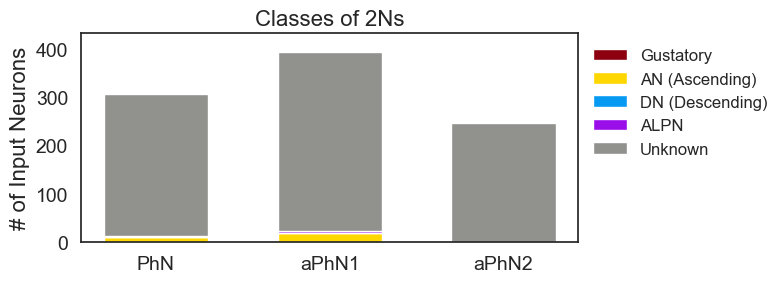

In [106]:
### Plot Stacked Bar Graph of 2N Classes (PhN, aPhN1, aPhN2)

# Define labels for PhN groups instead of six sets
set_labels = ['PhN', 'aPhN1', 'aPhN2']
bar_l = np.arange(1, len(set_labels) + 1)  # Adjust based on 3 groups
bar_width = 0.6

fig, ax = plt.subplots(figsize=(8, 3))

# Define a color palette for known classes + "unknown"
palette = ['#8c000f', '#ffd700', '#069af3', '#9a0eea', '#91928E']  # Ensure enough colors
cat_legend = ['Gustatory', 'AN (Ascending)', 'DN (Descending)', 'ALPN', 'Unknown']

# Plot the first class (gustatory)
ax.bar(bar_l, array_plot_sorted[0], width=bar_width, color=palette[0])
stack_tot = array_plot_sorted[0].copy()

# Plot remaining classes (stacked)
for i in range(1, len(array_plot_sorted)):
    ax.bar(
        bar_l,
        array_plot_sorted[i],
        bottom=stack_tot,
        width=bar_width,
        color=palette[i]
    )
    stack_tot += array_plot_sorted[i]

# Axis labels and title
ax.set_title('Classes of 2Ns', fontsize=16)
ax.set_ylabel('# of Input Neurons', fontsize=16)

# Set x-axis labels for PhN, aPhN1, aPhN2
ax.set_xticks(bar_l)
ax.set_xticklabels(set_labels, fontsize=14)

# Adjust legend
ax.legend(cat_legend, loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=12)

# Adjust y-axis scaling
plt.ylim(0, np.max(stack_tot) * 1.1)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


In [107]:
# Get values for proportion of each type
proportions = array_plot_sorted/np.sum(array_plot_sorted, axis=0)
proportions

array([[0.        , 0.        , 0.        ],
       [0.03583062, 0.04834606, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.00325733, 0.00763359, 0.        ],
       [0.96091205, 0.94402036, 1.        ]])

In [108]:
# Define column names explicitly for PhN, aPhN1, aPhN2 groups
modalities = ['PhN', 'aPhN1', 'aPhN2']

# Define your categories legend clearly (4 known classes plus "unknown")
categories_legend = ['gustatory', 'AN (ascending)', 'DN (descending)', 'ALPN', 'unknown']

# Create proportions dataframe
_2N_classes = pd.DataFrame(array_plot_sorted / np.sum(array_plot_sorted, axis=0),
                           columns=modalities,
                           index=categories_legend)

# Create raw counts dataframe
_2N_classes_raw = pd.DataFrame(array_plot_sorted,
                               columns=modalities,
                               index=categories_legend)

# Save DataFrames to CSV files
_2N_classes.to_csv('PhN_aPhN1_aPhN2_class_proportions.csv', index=True)
_2N_classes_raw.to_csv('PhN_aPhN1_aPhN2_class_numbers.csv', index=True)

# Confirm DataFrames by printing clearly
print("\nProportions (PhN, aPhN1, aPhN2):\n", _2N_classes)
print("\nRaw Counts (PhN, aPhN1, aPhN2):\n", _2N_classes_raw)



Proportions (PhN, aPhN1, aPhN2):
                       PhN     aPhN1  aPhN2
gustatory        0.000000  0.000000    0.0
AN (ascending)   0.035831  0.048346    0.0
DN (descending)  0.000000  0.000000    0.0
ALPN             0.003257  0.007634    0.0
unknown          0.960912  0.944020    1.0

Raw Counts (PhN, aPhN1, aPhN2):
                  PhN  aPhN1  aPhN2
gustatory          0      0      0
AN (ascending)    11     19      0
DN (descending)    0      0      0
ALPN               1      3      0
unknown          295    371    247


### Quantify the neurotransmitter types for local and projection 2N outputs across modalities

We are only including ACH, GABA, GLUT neurotransmitter types here, which represent the vast majority of 2N synapses.

Note that this analysis quantifies 2N outputs by the number of connections, not synapses.

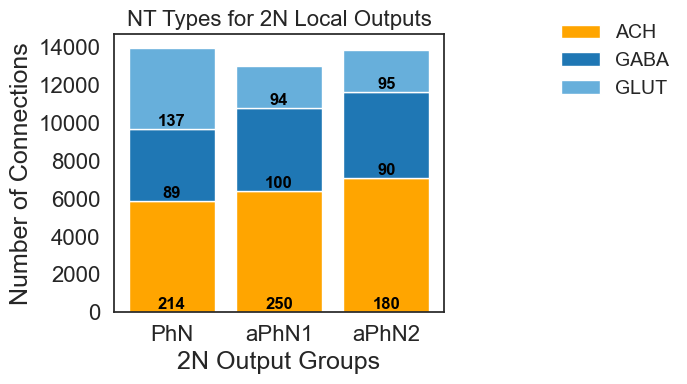

In [109]:

def count_NTs_local(datasets_array, NTs_array):
    """
    Count the number of local connections for each NT type in each dataset.

    Parameters
    ----------
    datasets_array : list of DataFrames
        Each DataFrame should contain a 'location_of_connection' and 'nt_type' column.
    NTs_array : list
        List of NT types in order, e.g. ['ACH', 'GABA', 'GLUT'].

    Returns
    -------
    tuple of np.arrays: (ACH_counts, GABA_counts, GLUT_counts)
    """
    ACH_list = []
    GABA_list = []
    GLUT_list = []
    for dataset in datasets_array:
        ACH_list.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[0]")))
        GABA_list.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[1]")))
        GLUT_list.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[2]")))
    return np.array(ACH_list), np.array(GABA_list), np.array(GLUT_list)


def count_neurons_local(datasets_array, NTs_array):
    """
    Count the number of unique presynaptic neurons (2Ns) contributing local connections for each NT type.

    Parameters
    ----------
    datasets_array : list of DataFrames
        Each DataFrame should contain a 'location_of_connection', 'nt_type', and 'pre_root_id' column.
    NTs_array : list
        List of NT types in order, e.g. ['ACH', 'GABA', 'GLUT'].

    Returns
    -------
    tuple of np.arrays: (ACH_neurons, GABA_neurons, GLUT_neurons)
    """
    ACH_list = []
    GABA_list = []
    GLUT_list = []
    for dataset in datasets_array:
        ACH_list.append(
            dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[0]")['pre_root_id'].nunique())
        GABA_list.append(
            dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[1]")['pre_root_id'].nunique())
        GLUT_list.append(
            dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[2]")['pre_root_id'].nunique())
    return np.array(ACH_list), np.array(GABA_list), np.array(GLUT_list)


# We assume that PhN_2N_outputs, aPhN1_2N_outputs, and aPhN2_2N_outputs are defined DataFrames
# containing the 2N outputs with local connections (and that they include the columns
# 'location_of_connection', 'nt_type', and 'pre_root_id').

NTs = ['ACH', 'GABA', 'GLUT']
modalities = ['PhN', 'aPhN1', 'aPhN2']
datasets = [PhN_2N_outputs, aPhN1_2N_outputs, aPhN2_2N_outputs]

# Get counts for each NT type (number of connections) and for unique neurons.
variables = count_NTs_local(datasets, NTs)  # Returns three arrays of counts
neurons = count_neurons_local(datasets, NTs)  # Returns three arrays of unique presynaptic neurons

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 4))
bar_l = np.arange(len(modalities)) + 1  # Positions: [1, 2, 3]
bar_width = 0.8

# Plot stacked bars: first for ACH, then GABA, then GLUT.
ax1 = ax.bar(bar_l, variables[0], width=bar_width, color='orange')
ax2 = ax.bar(bar_l, variables[1], bottom=variables[0], width=bar_width, color='#1f77b4')
ax3 = ax.bar(bar_l, variables[2], bottom=variables[0] + variables[1], width=bar_width, color='#67afdb')

ax.set_ylabel('Number of Connections', fontsize=18)
ax.set_xlabel('2N Output Groups', fontsize=18)
ax.set_title('NT Types for 2N Local Outputs', fontsize=16)
ax.legend(NTs, fontsize=14, frameon=False, bbox_to_anchor=(1.3, 1.1))
plt.xticks(bar_l, modalities, fontsize=16)
plt.yticks(fontsize=16)

# Annotate each bar with the number of unique neurons contributing for each NT type.
for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    # Place annotation at the bottom of each segment.
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2, n3, ha="center", va="bottom", color="black", fontweight="bold")

plt.tight_layout()
plt.show()


# NT types
NTs = ['ACH', 'GABA', 'GLUT']

# Six sets as x-axis labels
categories = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']

# 'variables' contains three arrays:
# variables[0] = ACH counts per set
# variables[1] = GABA counts per set
# variables[2] = GLUT counts per set
# Each array should have length 6.

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# We have 6 sets => positions 1..6
bar_l = np.arange(1, 7)
bar_width = 0.6

# Plot stacked bars for the three NT types
ax1 = ax.bar(bar_l, variables[0], width=bar_width, color='orange')                # ACH
ax2 = ax.bar(bar_l, variables[1], width=bar_width, bottom=variables[0], color='#1f77b4')   # GABA
ax3 = ax.bar(bar_l, variables[2], width=bar_width,
             bottom=variables[0] + variables[1], color='#67afdb')               # GLUT

# Adjust axes, labels, formatting
ax.set_ylabel('# Outputs', fontsize=18)
plt.ylim(0, 6500)  # Adjust as needed for your data range
ax.set_title('NT Types for 2N Local Outputs', fontsize=16)

plt.xticks(bar_l, categories, fontsize=12)
plt.yticks(fontsize=16)

# If you want a legend, uncomment:
# ax.legend(NTs, frameon=False, fontsize=14)

plt.tight_layout()
plt.show()


In [110]:
# Show numbers of outputs for each NT type
variables

(array([5859, 6405, 7098]),
 array([3844, 4403, 4561]),
 array([4288, 2235, 2223]))

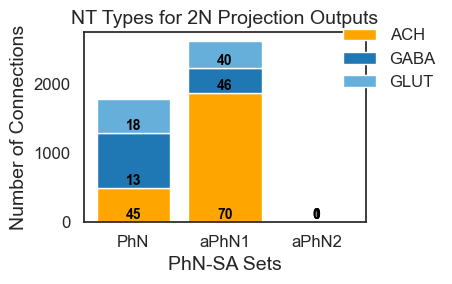

In [111]:
# Define NT types
NTs = ['ACH','GABA','GLUT']

# Replace categories explicitly with your neuron sets
categories = ['PhN','aPhN1','aPhN2']

# Replace datasets explicitly with your new datasets
datasets = [PhN_2N_outputs, aPhN1_2N_outputs, aPhN2_2N_outputs]

# Function to count the number of projection 2N outputs (connections) for each NT type
def count_NTs_proj(datasets_array, NTs_array):
    ach_list, gaba_list, glut_list = [], [], []
    for ds in datasets_array:
        ach_list.append(len(ds.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs_array[0]")))
        gaba_list.append(len(ds.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs_array[1]")))
        glut_list.append(len(ds.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs_array[2]")))
    return np.array(ach_list), np.array(gaba_list), np.array(glut_list)

# Function to count the number of unique projection 2Ns for each NT type
def count_neurons_proj(datasets_array, NTs_array):
    ach_list, gaba_list, glut_list = [], [], []
    for ds in datasets_array:
        ach_list.append(ds.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs_array[0]")['pre_root_id'].nunique())
        gaba_list.append(ds.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs_array[1]")['pre_root_id'].nunique())
        glut_list.append(ds.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs_array[2]")['pre_root_id'].nunique())
    return np.array(ach_list), np.array(gaba_list), np.array(glut_list)

# Run the functions for your datasets
variables = count_NTs_proj(datasets, NTs)
neurons = count_neurons_proj(datasets, NTs)

# Make a stacked bar plot
fig, ax = plt.subplots(figsize=(5,3))
bar_positions = np.arange(1, len(categories)+1)
bar_width = 0.8

# Plot ACH, GABA, GLUT as stacked bars
bars_ach = ax.bar(bar_positions, variables[0], width=bar_width, color='orange') # ACH
bars_gaba = ax.bar(bar_positions, variables[1], bottom=variables[0], width=bar_width, color='#1f77b4') # GABA
bars_glut = ax.bar(bar_positions, variables[2], bottom=variables[0]+variables[1], width=bar_width, color='#67afdb') # GLUT

# Label the plot
ax.set_ylabel('Number of Connections', fontsize=14)
ax.set_xlabel('PhN-SA Sets', fontsize=14)
ax.legend(NTs, frameon=False, fontsize=12, bbox_to_anchor=(1.3, 1.1))
ax.set_title('NT Types for 2N Projection Outputs', fontsize=14)
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Annotate bars with the number of unique neurons
for bar_ach, bar_gaba, bar_glut, n_ach, n_gaba, n_glut in zip(bars_ach, bars_gaba, bars_glut, neurons[0], neurons[1], neurons[2]):
    h_ach = bar_ach.get_height()
    h_gaba = bar_gaba.get_height()
    # ACH neuron count annotation
    ax.text(bar_ach.get_x() + bar_ach.get_width()/2., 0, n_ach, ha="center", va="bottom",
            color="black", fontsize=10, fontweight="bold")
    # GABA neuron count annotation
    ax.text(bar_gaba.get_x() + bar_gaba.get_width()/2., h_ach, n_gaba, ha="center", va="bottom",
            color="black", fontsize=10, fontweight="bold")
    # GLUT neuron count annotation
    ax.text(bar_glut.get_x() + bar_glut.get_width()/2., h_ach+h_gaba, n_glut, ha="center", va="bottom",
            color="black", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()


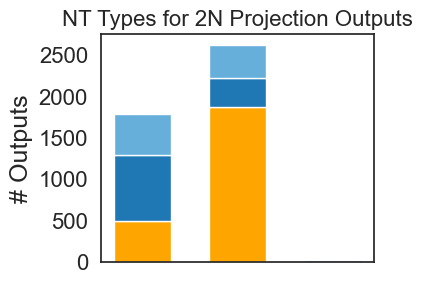

In [112]:
sns.set(style="white")

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)

# Adjust for 6 PhN-SA sets
bar_l = np.arange(1, 4)
bar_width = 0.6

# Draw the stacked bar chart:
# variables is assumed to be a list (or array) with three elements,
# where variables[0] corresponds to ACH, variables[1] to GABA, and variables[2] to GLUT.
ax.bar(bar_l, variables[0], width=bar_width, color='orange')  # ACH
ax.bar(bar_l, variables[1], bottom=variables[0], width=bar_width, color='#1f77b4')  # GABA
ax.bar(bar_l, variables[2], bottom=variables[0] + variables[1], width=bar_width, color='#67afdb')  # GLUT

# Formatting: remove x-axis tick labels (i.e., no text on the x-axis)
ax.set_ylabel('# Outputs', fontsize=18)
ax.set_title('NT Types for 2N Projection Outputs', fontsize=16)
plt.xticks([])  # Remove x-tick labels
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()


In [113]:
# Show numbers of outputs for each NT type
variables

(array([ 492, 1877,    0]), array([802, 355,   0]), array([494, 390,  19]))

### Quantifying ipsilateral vs. contralateral 2N outputs across modalities

In [114]:
# Define left vs. right sides as ipsilateral vs. contralateral
def bilateral(neuropil):
    if neuropil.endswith('_L'):
        return 'ipsilateral'
    elif neuropil.endswith('_R'):
        return 'contralateral'
    else:
        return 'central'

In [115]:
# Classify ipsilateral vs. contralateral side for each output in PhN-SA sets
PhN_2N_outputs['hemisphere'] = PhN_2N_outputs['neuropil'].apply(bilateral)
aPhN1_2N_outputs['hemisphere'] = aPhN1_2N_outputs['neuropil'].apply(bilateral)
aPhN2_2N_outputs['hemisphere'] = aPhN2_2N_outputs['neuropil'].apply(bilateral)


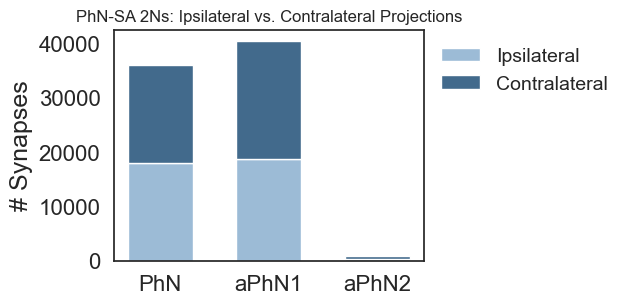

In [116]:
# Plot number of ipsilateral vs. contralateral output synapses for PhN-SAs
second_order_outputs = [PhN_2N_outputs, aPhN1_2N_outputs, aPhN2_2N_outputs]
ipsilateral = []
contralateral = []

for entry in second_order_outputs:
    ipsilateral.append(entry.query("hemisphere == 'ipsilateral'")['syn_count'].sum())
    contralateral.append(entry.query("hemisphere == 'contralateral'")['syn_count'].sum())

# Updated categories to reflect new PhN-SA sets
categories = ['PhN', 'aPhN1', 'aPhN2']
brain_hemisphere = ['Ipsilateral', 'Contralateral']

# Plot stacked bar chart
bar_width = 0.6
plt.figure(figsize=(4,3))
plt.bar(categories, ipsilateral, color='#9cbbd6', width=bar_width, label='Ipsilateral')
plt.bar(categories, contralateral, bottom=ipsilateral, color='#426a8c', width=bar_width, label='Contralateral')

plt.title('PhN-SA 2Ns: Ipsilateral vs. Contralateral Projections')
plt.ylabel('# Synapses', fontsize=18)
plt.legend(frameon=False, fontsize=14, bbox_to_anchor=(1, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


In [117]:
# Show numbers of ipsi vs. contra synapses
print(ipsilateral)
print(contralateral)

[np.int64(18050), np.int64(18768), np.int64(361)]
[np.int64(17847), np.int64(21667), np.int64(585)]


### Quantify 2N projections to each brain region

Start by consolidating bilateral brain regions for second order outputs.

In [118]:
# Creates a new column with region names excluding side
original_neuropil_list = connections['neuropil'].unique()
region_mapping = {}
for neuropil in original_neuropil_list:
    if neuropil.endswith('_L') or neuropil.endswith('_R'):
        prefix = neuropil[:-2]
        region_mapping[neuropil] = prefix
    else:
        region_mapping[neuropil] = neuropil

In [119]:
# Apply the function above for neuropil remapping in PhN-SA sets
PhN_2N_outputs['neuropil_remap'] = PhN_2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
aPhN1_2N_outputs['neuropil_remap'] = aPhN1_2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
aPhN2_2N_outputs['neuropil_remap'] = aPhN2_2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))

### Create bar graphs of non-SEZ brain regions with 2N outputs

In [120]:
# First, determine the top 12 non-SEZ brain regions for 2N outputs for each PhN-SA set
def get_top12_regions(outputs):
    # Sum over neuropil remap
    synapses_by_region = outputs.groupby('neuropil_remap')['syn_count'].sum()

    # Exclude SEZ regions
    synapses_by_region = synapses_by_region.drop(['GNG', 'PRW', 'SAD', 'FLA', 'CAN'], errors='ignore')

    # Take the top 12 regions with the highest synaptic counts
    top12 = list(synapses_by_region.sort_values().index[-12:])

    return top12

# Apply the function to each PhN-SA set
PhN_top12 = get_top12_regions(PhN_2N_outputs)
aPhN1_top12 = get_top12_regions(aPhN1_2N_outputs)
aPhN2_top12 = get_top12_regions(aPhN2_2N_outputs)

# Print results
print("PhN Top 12 Regions:", PhN_top12)
print("aPhN1 Top 12 Regions:", aPhN1_top12)
print("aPhN2 Top 12 Regions:", aPhN2_top12)


PhN Top 12 Regions: ['LH', 'AL', 'SCL', 'IB', 'PVLP', 'PLP', 'AVLP', 'GOR', 'SPS', 'SLP', 'ICL', 'SMP']
aPhN1 Top 12 Regions: ['AOTU', 'PVLP', 'AVLP', 'PLP', 'VES', 'SIP', 'MB_CA', 'SCL', 'AL', 'LH', 'SMP', 'SLP']
aPhN2 Top 12 Regions: ['SMP', 'SLP']


In [121]:
# Make a list of regions in the top 6 for any PhN-SA set, capturing >95% of outputs for each set

all_regions_PhNSA = list(
    set(PhN_top12[-6:]) |
    set(aPhN1_top12[-6:]) |
    set(aPhN2_top12[-6:])
)

all_regions_PhNSA


['SPS', 'SLP', 'ICL', 'AVLP', 'SCL', 'MB_CA', 'SMP', 'AL', 'LH', 'GOR']

In [122]:
# Define custom order for PhN-SA brain regions
categories_PhNSA = ['AVLP', 'SPS', 'SMP', 'AL', 'GOR', 'LH', 'MB_CA', 'SCL', 'ICL', 'SLP']

# Define NT types to plot separately
NTs_PhNSA = ['ACH', 'GABA', 'GLUT', 'DA', 'SER']


In [123]:
# Define function to count output synapses by NT type in each PhN-SA brain region
def count_NTs_PhNSA_brainregions(datasets_array, NTs_array):
    ACH_connections = []
    GABA_connections = []
    GLUT_connections = []
    Other_connections = []  # for DA + SER combined

    # Create a temporary variable for NT types that should be grouped as "Other"
    others = NTs_array[3:]

    for dataset in datasets_array:
        # Sum synapses for each NT type
        ach_sum = dataset.query("nt_type == @NTs_array[0]")['syn_count'].sum()
        gaba_sum = dataset.query("nt_type == @NTs_array[1]")['syn_count'].sum()
        glut_sum = dataset.query("nt_type == @NTs_array[2]")['syn_count'].sum()
        other_sum = dataset.query("nt_type in @others")['syn_count'].sum()

        ACH_connections.append(ach_sum)
        GABA_connections.append(gaba_sum)
        GLUT_connections.append(glut_sum)
        Other_connections.append(other_sum)

    return (
        np.array(ACH_connections),
        np.array(GABA_connections),
        np.array(GLUT_connections),
        np.array(Other_connections)
    )


In [124]:
# Example NT types for PhN-SA outputs:
NTs_PhNSA = ['ACH', 'GABA', 'GLUT', 'DA', 'SER']

# Suppose you already have a region mapping (e.g. from previous cells) and your combined outputs DataFrame.
# For example, assume PhN_2N_outputs has a column 'neuropil_remap'.
# And suppose we define the categories (brain regions) of interest:
categories_PhNSA = ['AVLP', 'SPS', 'SMP', 'AL', 'GOR', 'LH', 'MB_CA', 'SCL', 'ICL', 'SLP']
# (Adjust the list to match your regions of interest)

# Now, create lists of DataFrames (one per brain region) for each nerve group.
# This uses a list comprehension that filters the combined outputs DataFrame by each region.
datasets_PhN = [PhN_2N_outputs[PhN_2N_outputs['neuropil_remap'] == region] for region in categories_PhNSA]
datasets_aPhN1 = [aPhN1_2N_outputs[aPhN1_2N_outputs['neuropil_remap'] == region] for region in categories_PhNSA]
datasets_aPhN2 = [aPhN2_2N_outputs[aPhN2_2N_outputs['neuropil_remap'] == region] for region in categories_PhNSA]

# Define the function to count NT outputs by brain region.
def count_NTs_PhNSA_brainregions(datasets, NTs_array):
    """
    Given a list of DataFrames (each corresponding to one brain region)
    and a list of NT types, compute the sum of synapse counts for each NT type.

    NTs_array[0] is ACH, NTs_array[1] is GABA, NTs_array[2] is GLUT, and NTs_array[3:]
    are grouped as "Other".

    Returns:
      A tuple of 4 numpy arrays: (ACH, GABA, GLUT, Other).
    """
    ACH_connections = []
    GABA_connections = []
    GLUT_connections = []
    Other_connections = []  # for NT types in NTs_array[3:]
    others = NTs_array[3:]

    for dataset in datasets:
        ach_sum = dataset.query("nt_type == @NTs_array[0]")['syn_count'].sum()
        gaba_sum = dataset.query("nt_type == @NTs_array[1]")['syn_count'].sum()
        glut_sum = dataset.query("nt_type == @NTs_array[2]")['syn_count'].sum()
        other_sum = dataset.query("nt_type in @others")['syn_count'].sum()
        ACH_connections.append(ach_sum)
        GABA_connections.append(gaba_sum)
        GLUT_connections.append(glut_sum)
        Other_connections.append(other_sum)
    return (
        np.array(ACH_connections),
        np.array(GABA_connections),
        np.array(GLUT_connections),
        np.array(Other_connections)
    )

# Compute NT counts for each nerve group:
variables_PhN = count_NTs_PhNSA_brainregions(datasets_PhN, NTs_PhNSA)
variables_aPhN1 = count_NTs_PhNSA_brainregions(datasets_aPhN1, NTs_PhNSA)
variables_aPhN2 = count_NTs_PhNSA_brainregions(datasets_aPhN2, NTs_PhNSA)

# Display the results:
print("PhN NT counts by region (ACH, GABA, GLUT, Other):")
print(variables_PhN)

print("aPhN1 NT counts by region (ACH, GABA, GLUT, Other):")
print(variables_aPhN1)

print("aPhN2 NT counts by region (ACH, GABA, GLUT, Other):")
print(variables_aPhN2)


PhN NT counts by region (ACH, GABA, GLUT, Other):
(array([   0,    0, 3606,   76,   14,  132,    0,   12,   10, 1098]), array([ 344, 1068, 2266,    0, 1003,    6,    0,  146, 2293,  537]), array([  30,   12, 7075,   64,    5,    0,    0,    0,    0,   16]), array([   0,    0, 1052,    5,    0,    0,    0,   17,    0,    0]))
aPhN1 NT counts by region (ACH, GABA, GLUT, Other):
(array([   31,     0,  2392,   115,     0,  3708,   938,  1300,     0,
       10050]), array([  76,    0,  183,   48,    0,  203,    0,   11,    0, 2055]), array([   8,    0, 2992,   36,    0,  248,    0,    0,    0, 1746]), array([  0,   0, 543,  20,   0,  14,   0,   0,   0,  85]))
aPhN2 NT counts by region (ACH, GABA, GLUT, Other):
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 156]), array([ 0,  0, 29,  0,  0,  0,  0,  0,  0,  0]))


PhN shape: (5, 10)
aPhN1 shape: (5, 10)
aPhN2 shape: (5, 10)


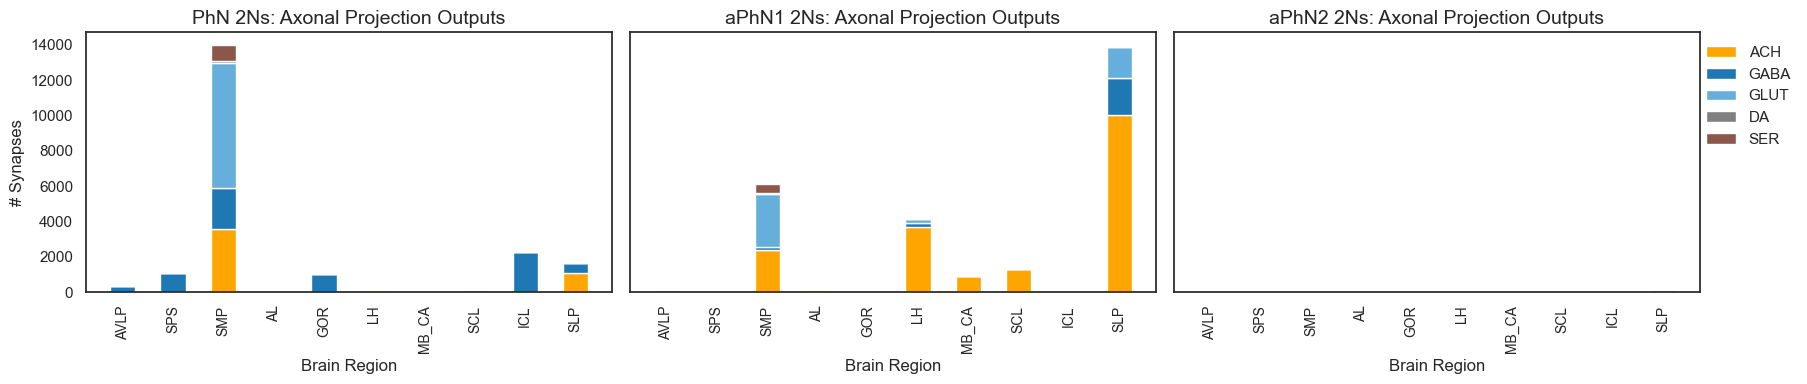

In [125]:
# Define function to count output synapses by NT type in each PhN-SA brain region
def count_NTs_PhNSA_brainregions(datasets_array, NTs_array):
    synapse_counts = {nt: [] for nt in NTs_array}

    for dataset in datasets_array:
        for nt in NTs_array:
            if nt in dataset['nt_type'].values:
                count = dataset.query("nt_type == @nt")['syn_count'].sum()
            else:
                count = 0  # If NT is missing, set to 0
            synapse_counts[nt].append(count)

    return tuple(np.array(synapse_counts[nt]) for nt in NTs_array)

# Compute NT synapse counts for each PhN-SA set
variables_PhN = count_NTs_PhNSA_brainregions(datasets_PhN, NTs_PhNSA)
variables_aPhN1 = count_NTs_PhNSA_brainregions(datasets_aPhN1, NTs_PhNSA)
variables_aPhN2 = count_NTs_PhNSA_brainregions(datasets_aPhN2, NTs_PhNSA)

# Print shapes to debug
print(f"PhN shape: {np.shape(variables_PhN)}")
print(f"aPhN1 shape: {np.shape(variables_aPhN1)}")
print(f"aPhN2 shape: {np.shape(variables_aPhN2)}")

# Ensure all arrays have the correct shape before plotting
if any(len(v) != len(NTs_PhNSA) for v in [variables_PhN, variables_aPhN1, variables_aPhN2]):
    raise ValueError("Mismatch in NT count arrays. Ensure all NTs are accounted for.")

# Define colors for NT types
nt_colors = {
    'ACH': 'orange',
    'GABA': '#1f77b4',
    'GLUT': '#67afdb',
    'DA': 'gray',
    'SER': '#8c564b'
}

# Plotting the NT distributions across brain regions for each PhN-SA set
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# Define set names for labeling
PhN_sets = ['PhN', 'aPhN1', 'aPhN2']
variables_list = [variables_PhN, variables_aPhN1, variables_aPhN2]

for ax, set_name, variables in zip(axes, PhN_sets, variables_list):
    bottom_values = np.zeros(len(categories_PhNSA))

    for i, nt in enumerate(NTs_PhNSA):
        ax.bar(categories_PhNSA, variables[i], bottom=bottom_values, color=nt_colors[nt], width=0.5, label=nt)
        bottom_values += np.array(variables[i])

    ax.set_title(f'{set_name} 2Ns: Axonal Projection Outputs', fontsize=14)
    ax.set_xlabel('Brain Region', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)

# Shared y-label
axes[0].set_ylabel('# Synapses', fontsize=12)

# Add legend to the last subplot
axes[-1].legend(NTs_PhNSA, frameon=False, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()


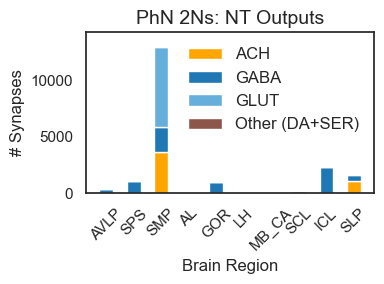

In [126]:
sns.set(style="white")

# Example: using your previously computed variables for PhN
# variables_PhN = (ach_array, gaba_array, glut_array, other_array)
# categories_PhNSA is the list of brain regions (e.g., ['AL','ICL','SCL','MB_CA','SPS','SMP','AVLP','LH','SLP','GOR'])
# nt_colors is a dictionary mapping NT types to colors

fig, ax = plt.subplots(figsize=(4, 3))

# x positions for each region:
bar_l = np.arange(len(categories_PhNSA))

# Start with bottom=0 for each region:
bottom_values = np.zeros(len(categories_PhNSA))

# Plot ACH, GABA, and GLUT from variables_PhN (indices 0, 1, 2)
for i, nt in enumerate(['ACH', 'GABA', 'GLUT']):
    ax.bar(categories_PhNSA, variables_PhN[i], bottom=bottom_values, width=0.5,
           color=nt_colors[nt], label=nt)
    bottom_values += np.array(variables_PhN[i])

# Plot Other (assumed at index 3)
ax.bar(categories_PhNSA, variables_PhN[3], bottom=bottom_values, width=0.5,
       color=nt_colors['SER'], label='Other (DA+SER)')

ax.set_title('PhN 2Ns: NT Outputs', fontsize=14)
ax.set_xlabel('Brain Region', fontsize=12)
ax.set_ylabel('# Synapses', fontsize=12)
ax.tick_params(axis='x', rotation=45)
# Optionally, adjust the y-axis limits manually (or let matplotlib choose automatically):
ax.set_ylim(0, (bottom_values.max() * 1.1))
ax.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()


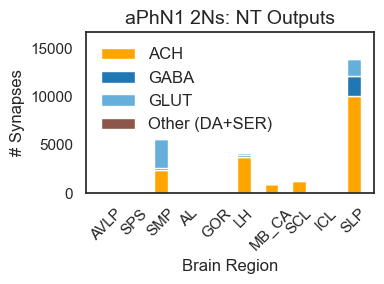

In [127]:
fig, ax = plt.subplots(figsize=(4, 3))

bar_l = np.arange(len(categories_PhNSA))
bottom_values = np.zeros(len(categories_PhNSA))

# For aPhN1, use variables_aPhN1 (assumed structure same as above)
for i, nt in enumerate(['ACH', 'GABA', 'GLUT']):
    ax.bar(categories_PhNSA, variables_aPhN1[i], bottom=bottom_values, width=0.5,
           color=nt_colors[nt], label=nt)
    bottom_values += np.array(variables_aPhN1[i])

ax.bar(categories_PhNSA, variables_aPhN1[3], bottom=bottom_values, width=0.5,
       color=nt_colors['SER'], label='Other (DA+SER)')

ax.set_title('aPhN1 2Ns: NT Outputs', fontsize=14)
ax.set_xlabel('Brain Region', fontsize=12)
ax.set_ylabel('# Synapses', fontsize=12)
ax.tick_params(axis='x', rotation=45)
# Here you might want a smaller y-axis range if aPhN1 has lower counts:
ax.set_ylim(0, (bottom_values.max() * 1.2))
ax.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()


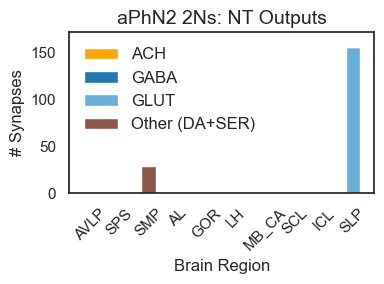

In [128]:
fig, ax = plt.subplots(figsize=(4, 3))

bar_l = np.arange(len(categories_PhNSA))
bottom_values = np.zeros(len(categories_PhNSA))

# For aPhN2, use variables_aPhN2 (assumed structure same as above)
for i, nt in enumerate(['ACH', 'GABA', 'GLUT']):
    ax.bar(categories_PhNSA, variables_aPhN2[i], bottom=bottom_values, width=0.5,
           color=nt_colors[nt], label=nt)
    bottom_values += np.array(variables_aPhN2[i])

ax.bar(categories_PhNSA, variables_aPhN2[3], bottom=bottom_values, width=0.5,
       color=nt_colors['SER'], label='Other (DA+SER)')

ax.set_title('aPhN2 2Ns: NT Outputs', fontsize=14)
ax.set_xlabel('Brain Region', fontsize=12)
ax.set_ylabel('# Synapses', fontsize=12)
ax.tick_params(axis='x', rotation=45)
# Set y-axis limit specific for aPhN2:
ax.set_ylim(0, (bottom_values.max() * 1.1))
ax.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()

In [129]:
# Quantify how many of the projection synapses we're capturing in PhN, aPhN1, and aPhN2

# Compute the total synapses captured for each set
numerator_PhN = sum(variables_PhN)
numerator_aPhN1 = sum(variables_aPhN1)
numerator_aPhN2 = sum(variables_aPhN2)

# Compute the denominator: total synapses for projections outside SEZ for each dataset
denom_PhN = PhN_2N_outputs[PhN_2N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()
denom_aPhN1 = aPhN1_2N_outputs[aPhN1_2N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()
denom_aPhN2 = aPhN2_2N_outputs[aPhN2_2N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

# Compute captured projection synapses ratio
captured_projection_synapses_PhN = numerator_PhN / denom_PhN
captured_projection_synapses_aPhN1 = numerator_aPhN1 / denom_aPhN1
captured_projection_synapses_aPhN2 = numerator_aPhN2 / denom_aPhN2

# Print results
print("Captured projection synapses (PhN):", captured_projection_synapses_PhN)
print("Captured projection synapses (aPhN1):", captured_projection_synapses_aPhN1)
print("Captured projection synapses (aPhN2):", captured_projection_synapses_aPhN2)


Captured projection synapses (PhN): [0.01684154 0.04863331 0.63038681 0.00652947 0.04602152 0.00621426
 0.         0.0078804  0.10370604 0.07434593]
Captured projection synapses (aPhN1): [0.00381641 0.         0.20276773 0.00726778 0.         0.13848605
 0.03112866 0.04350712 0.         0.46248299]
Captured projection synapses (aPhN2): [0.         0.         0.15675676 0.         0.         0.
 0.         0.         0.         0.84324324]


## 3. THIRD ORDER NEURON ANALYSES

PhN-SA## 3a. Identify 3Ns and their connections and organize the data

### Define a function to identify third order neurons (3Ns)
- must be downstream of 2Ns and not a
- minimum of 10 synapses from PhN-SA to 2N
- minimum of 10 synapses from 2N to 3N

Note that these criteria use a more stringent threshold (10 synapses) than for 2Ns.

In [130]:
def third_order(second_order_connectivity, set_name, second_orders):
    """
    Defines third order connectivity from second-order connectivity for a given sensory nerve group.

    Parameters:
      second_order_connectivity (pd.DataFrame): A DataFrame containing the second-order connections,
          with 'post_root_id' as the neuron receiving input.
      set_name (str): A string identifier for the sensory nerve set (e.g., "set_1", "set_2", etc.).
      second_orders (pd.DataFrame): Aggregated second-order connectivity DataFrame containing
          at least a 'root_id' column (list of 2Ns to exclude as 3Ns).

    Returns:
      connectivity (pd.DataFrame): The filtered third-order connectivity DataFrame.
      third_orders (pd.DataFrame): Aggregated third-order connectivity with:
          - 'root_id': the third-order neuron ID,
          - 'upstream_{set_name}_2Ns': count of unique 2Ns providing inputs,
          - '{set_name}_syn_count': total synapse count from these 2Ns,
          - 'const': constant column (for regression, if needed).
    """
    # Filter second-order connectivity by synapse count threshold (>= 10 synapses).
    filtered_2nd = second_order_connectivity.query("syn_count >= 10")['post_root_id']

    # Merge with the complete connections dataset to extract the 3Ns.
    connectivity = pd.merge(
        filtered_2nd,
        connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='post_root_id',
        right_on='pre_root_id',
        how='inner'
    ).query("syn_count >= 10")

    # Remove redundant columns from merging.
    connectivity = connectivity.drop(columns='post_root_id_x')
    connectivity.rename(columns={'post_root_id_y': 'post_root_id'}, inplace=True)

    # Drop connections where the postsynaptic neuron is already a second-order neuron.
    connectivity = connectivity[~connectivity['post_root_id'].isin(second_orders['root_id'])]

    # Remove duplicates.
    connectivity = connectivity.drop_duplicates()

    # Aggregate third-order connectivity.
    third_orders = connectivity.groupby("post_root_id").agg({
        'pre_root_id': 'nunique',  # Count unique upstream 2Ns.
        'syn_count': 'sum'         # Total synapse count.
    }).reset_index()

    # Rename columns to match nerve set name.
    third_orders.columns = ['root_id', 'upstream_' + set_name + '_2Ns', set_name + '_syn_count']
    third_orders['const'] = 1  # For regression modeling if needed.

    return connectivity, third_orders


In [131]:
# — make sure these are defined above —
# phn_set_1_base = pd.read_csv(...PhN-SA_v2/set_1.csv)
# phn_set_2_base = pd.read_csv(...PhN-SA_v2/set_2.csv)
# …
# aPhN1_set_1_base = pd.read_csv(...aPhN1-SA_v2/set_1.csv)
# …
# aPhN2_set_1_base = pd.read_csv(...aPhN2-SA_v1/set_1.csv)
# …

# Compute second-order connectivity for PhN
PhN_set_1_second_order_connectivity, PhN_set_1_2Ns = second_order(phn_set_1_base,  "PhN_set_1")
PhN_set_2_second_order_connectivity, PhN_set_2_2Ns = second_order(phn_set_2_base,  "PhN_set_2")
PhN_set_3_second_order_connectivity, PhN_set_3_2Ns = second_order(phn_set_3_base,  "PhN_set_3")
PhN_set_4_second_order_connectivity, PhN_set_4_2Ns = second_order(phn_set_4_base,  "PhN_set_4")
PhN_set_5_second_order_connectivity, PhN_set_5_2Ns = second_order(phn_set_5_base,  "PhN_set_5")
PhN_set_6_second_order_connectivity, PhN_set_6_2Ns = second_order(phn_set_6_base,  "PhN_set_6")

# Compute second-order connectivity for aPhN1
aPhN1_set_1_second_order_connectivity, aPhN1_set_1_2Ns = second_order(aPhN1_set_1_base, "aPhN1_set_1")
aPhN1_set_2_second_order_connectivity, aPhN1_set_2_2Ns = second_order(aPhN1_set_2_base, "aPhN1_set_2")
aPhN1_set_3_second_order_connectivity, aPhN1_set_3_2Ns = second_order(aPhN1_set_3_base, "aPhN1_set_3")

# Compute second-order connectivity for aPhN2
aPhN2_set_1_second_order_connectivity, aPhN2_set_1_2Ns = second_order(aPhN2_set_1_base, "aPhN2_set_1")
aPhN2_set_2_second_order_connectivity, aPhN2_set_2_2Ns = second_order(aPhN2_set_2_base, "aPhN2_set_2")
aPhN2_set_3_second_order_connectivity, aPhN2_set_3_2Ns = second_order(aPhN2_set_3_base, "aPhN2_set_3")

# Now compute third-order connectivity for PhN
PhN_set_1_third_order_connectivity, PhN_set_1_3Ns = third_order(PhN_set_1_second_order_connectivity, 'PhN_set_1', PhN_set_1_2Ns)
PhN_set_2_third_order_connectivity, PhN_set_2_3Ns = third_order(PhN_set_2_second_order_connectivity, 'PhN_set_2', PhN_set_2_2Ns)
PhN_set_3_third_order_connectivity, PhN_set_3_3Ns = third_order(PhN_set_3_second_order_connectivity, 'PhN_set_3', PhN_set_3_2Ns)
PhN_set_4_third_order_connectivity, PhN_set_4_3Ns = third_order(PhN_set_4_second_order_connectivity, 'PhN_set_4', PhN_set_4_2Ns)
PhN_set_5_third_order_connectivity, PhN_set_5_3Ns = third_order(PhN_set_5_second_order_connectivity, 'PhN_set_5', PhN_set_5_2Ns)
PhN_set_6_third_order_connectivity, PhN_set_6_3Ns = third_order(PhN_set_6_second_order_connectivity, 'PhN_set_6', PhN_set_6_2Ns)

# Third-order for aPhN1
aPhN1_set_1_third_order_connectivity, aPhN1_set_1_3Ns = third_order(aPhN1_set_1_second_order_connectivity, 'aPhN1_set_1', aPhN1_set_1_2Ns)
aPhN1_set_2_third_order_connectivity, aPhN1_set_2_3Ns = third_order(aPhN1_set_2_second_order_connectivity, 'aPhN1_set_2', aPhN1_set_2_2Ns)
aPhN1_set_3_third_order_connectivity, aPhN1_set_3_3Ns = third_order(aPhN1_set_3_second_order_connectivity, 'aPhN1_set_3', aPhN1_set_3_2Ns)

# Third-order for aPhN2
aPhN2_set_1_third_order_connectivity, aPhN2_set_1_3Ns = third_order(aPhN2_set_1_second_order_connectivity, 'aPhN2_set_1', aPhN2_set_1_2Ns)
aPhN2_set_2_third_order_connectivity, aPhN2_set_2_3Ns = third_order(aPhN2_set_2_second_order_connectivity, 'aPhN2_set_2', aPhN2_set_2_2Ns)
aPhN2_set_3_third_order_connectivity, aPhN2_set_3_3Ns = third_order(aPhN2_set_3_second_order_connectivity, 'aPhN2_set_3', aPhN2_set_3_2Ns)


In [132]:
# inspect connectivity dataframe
PhN_set_6_third_order_connectivity

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
24,720575940613747734,720575940631829279,PRW,12,ACH
26,720575940613747734,720575940613120721,PRW,18,ACH
30,720575940613747734,720575940624176312,PRW,19,ACH
37,720575940613747734,720575940622515895,PRW,14,ACH
47,720575940613747734,720575940628070419,PRW,10,ACH
...,...,...,...,...,...
4106,720575940639339829,720575940627828296,GNG,11,SER
4110,720575940639339829,720575940626243428,PRW,21,ACH
4111,720575940639339829,720575940621047632,GNG,12,ACH
4112,720575940639339829,720575940619900507,GNG,11,ACH


In [134]:
# List how many 3Ns we have
print(np.unique(PhN_set_1_3Ns.root_id.values).shape)
print(np.unique(PhN_set_2_3Ns.root_id.values).shape)
print(np.unique(PhN_set_3_3Ns.root_id.values).shape)
print(np.unique(PhN_set_4_3Ns.root_id.values).shape)
print(np.unique(PhN_set_5_3Ns.root_id.values).shape)
print(np.unique(PhN_set_6_3Ns.root_id.values).shape)

# Inspect list of 3Ns for set_1
PhN_set_1_3Ns


(31,)
(369,)
(526,)
(427,)
(355,)
(216,)


,root_id,upstream_PhN_set_1_2Ns,PhN_set_1_syn_count,const
0,720575940609592270,1,11,1
1,720575940609993284,2,32,1
2,720575940611812050,1,17,1
3,720575940612423922,1,36,1
4,720575940612572131,1,30,1
5,720575940612692633,1,31,1
6,720575940615406590,1,57,1
7,720575940615799308,1,11,1
8,720575940615811670,1,26,1
9,720575940616217403,1,12,1


### Getting more information about 3Ns from Flywire's data repository
Again we are using files from snapshot 783.

In [135]:
# ### Getting more information about 3Ns from FlyWire's snapshot 783 data repository
# Merge in neuron attributes (nt_type, side, input/output synapses) from the snapshot-783 neuron tables.

# Merge metadata into each PhN third-order set using a loop to reduce repetition
for n in range(1, 7):
    df_name = f"PhN_set_{n}_3Ns"
    if df_name in globals():
        globals()[df_name] = globals()[df_name].merge(
            neurons_data,
            on='root_id',
            how='inner'
        )
    else:
        print(f"Warning: {df_name} not found in namespace, skipping.")

# Inspect the 6th PhN third-order neuron set as an example
PhN_set_6_3Ns.head()


,root_id,upstream_PhN_set_6_2Ns,PhN_set_6_syn_count,const,nt_type,side,input_synapses,output_synapses
0,720575940605682790,1,155,1,ACH,right,294.0,991.0
1,720575940605694240,1,10,1,ACH,right,247.0,425.0
2,720575940607162754,2,76,1,GABA,right,3361.0,3018.0
3,720575940607166731,1,16,1,NaN,left,16.0,299.0
4,720575940607472988,2,72,1,GABA,right,968.0,761.0


In [136]:
# ### Getting more information about 3Ns from FlyWire's snapshot 783 data repository
# Merge in neuron attributes (nt_type, side, input/output synapses) from snapshot-783 neuron tables.

# Merge metadata into each third-order neuron set for PhN, aPhN1, and aPhN2 using loops
groups = {
    "PhN": 6,
    "aPhN1": 3,
    "aPhN2": 3
}
for group, max_set in groups.items():
    for n in range(1, max_set + 1):
        df_name = f"{group}_set_{n}_3Ns"
        if df_name in globals():
            globals()[df_name] = globals()[df_name].merge(
                neurons_data,
                on='root_id',
                how='inner'
            )
        else:
            print(f"Warning: {df_name} not found, skipping merge for this set.")

# Inspect example sets to confirm metadata merge
PhN_set_6_3Ns.head()
aPhN1_set_3_3Ns.head()
aPhN2_set_3_3Ns.head()


,root_id,upstream_aPhN2_set_3_2Ns,aPhN2_set_3_syn_count,const,nt_type,side,input_synapses,output_synapses
0,720575940605682790,1,155,1,ACH,right,294.0,991.0
1,720575940605694240,1,10,1,ACH,right,247.0,425.0
2,720575940605698080,1,29,1,ACH,right,509.0,227.0
3,720575940606867145,1,11,1,ACH,right,248.0,199.0
4,720575940607152476,1,43,1,NaN,left,66.0,180.0


In [137]:
# Select and merge rows from neurons_data for each set of 3Ns
set_1_3Ns = pd.merge(set_1_3Ns, neurons_data, on='root_id', how='inner')
set_2_3Ns = pd.merge(set_2_3Ns, neurons_data, on='root_id', how='inner')
set_3_3Ns = pd.merge(set_3_3Ns, neurons_data, on='root_id', how='inner')
set_4_3Ns = pd.merge(set_4_3Ns, neurons_data, on='root_id', how='inner')
set_5_3Ns = pd.merge(set_5_3Ns, neurons_data, on='root_id', how='inner')
set_6_3Ns = pd.merge(set_6_3Ns, neurons_data, on='root_id', how='inner')


NameError: name 'set_1_3Ns' is not defined

In [ ]:
# inspect dataframe
set_6_3Ns

## 3b. Analyzing convergence of excitatory vs. inhibitory 2N inputs onto 3Ns

We are comparing the observed proportion of excitatory or inhibitory convergence to the proportion expected by chance.

### Transform the 2N-3N connectivity data so that each row is a unique 2N-3N pair

This is necessary because the 2N-3N connectivity data may include the same 2N-3N pair multiple times if they connect in multiple regions.

We also want to label NT type for each 2N-3N synapse using the "neurons" dataset; otherwise the synapse labels for the same 2N-3N pair sometimes conflict. Note that this is different from other analyses that just use synapse labels.

In [ ]:
# Define a function that transforms 2N-3N connectivity as described above
def get_3N_inputs(third_order_connectivity):
    """
    Given a third-order connectivity DataFrame, collapse duplicate 2N-3N pairs,
    assign a consistent NT label (E vs I), and sum synapse counts.
    """
    # Drop neuropil and original nt_type columns
    toc = third_order_connectivity.drop(['neuropil', 'nt_type'], axis=1)

    # Join nt_type from neurons_data on the presynaptic 2N (pre_root_id)
    toc = toc.join(
        neurons_data.set_index('root_id')['nt_type'],
        on='pre_root_id'
    )

    # Remove rows without an NT label
    toc = toc[~toc['nt_type'].isnull()]

    # Keep only GABA, ACH, GLUT
    toc = toc[toc['nt_type'].isin(['GABA', 'ACH', 'GLUT'])]

    # Map NT to excitatory (E) or inhibitory (I)
    toc['nt_type'] = toc['nt_type'].replace({'GABA': 'I', 'ACH': 'E', 'GLUT': 'I'})

    # Aggregate duplicate connections by summing syn_count
    toc = (
        toc.groupby(['pre_root_id', 'post_root_id', 'nt_type'])
           ['syn_count']
           .sum()
           .reset_index()
    )

    return toc

# Run the transformation for each PhN third-order set
toc_sets = {}
for n in range(1, 7):
    df_name = f"PhN_set_{n}_third_order_connectivity"
    toc_name = f"PhN_set_{n}_toc"
    if df_name in globals():
        toc_sets[toc_name] = get_3N_inputs(globals()[df_name])
    else:
        print(f"Warning: {df_name} not found, skipping.")

# Similarly for aPhN1 and aPhN2 (3 sets each)
for group in ['aPhN1', 'aPhN2']:
    max_sets = 3
    for n in range(1, max_sets + 1):
        df_name = f"{group}_set_{n}_third_order_connectivity"
        toc_name = f"{group}_set_{n}_toc"
        if df_name in globals():
            toc_sets[toc_name] = get_3N_inputs(globals()[df_name])
        else:
            print(f"Warning: {df_name} not found, skipping.")


In [ ]:
# Show the new connectivity dataframe - has fewer connections than original because of drops
# Inspect one example transformed table
toc_sets['PhN_set_6_toc'].head()

### First, analyze 3Ns with exactly two 2N inputs

Consider 3Ns with exactly two 2N inputs. We calculate the rate of inputs being both excitatory (EE), both inhibitory (II), or different (EI or IE) by probability rules, based on knowing the frequency of excitatory and inhibitory inputs for that dataset.

Ex: If 2N inputs to this set of 3Ns are 70% inhibitory and 30% inhibitory:

Chance of both inputs being excitatory (EE) is 0.3\*0.3

Chance of both inputs being inhibitory (II) is 0.7\*0.7

Chance of having one excitatory and one inhibitory input (EI or IE) is (0.3\*0.7) + (0.7\*0.3) = 2\*(0.3\*0.7).

Then, we compare this chance rate for congruent vs. incongruent inputs to the actual rates.

In [138]:
# Quantify the expected and actual number of 3Ns in each category above
# (Note that in the code below, EI refers to either EI or IE)

def get_probs_connectivity_2input (toc):

    # calculate number of 3Ns receiving EE, EI, or II inputs
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_neurons_for_each_EI = n_inputs.groupby(['E', 'I']).size().unstack().fillna(0).astype(int)
    number_EE = n_neurons_for_each_EI.loc[2].loc[0]
    number_II = n_neurons_for_each_EI.loc[0].loc[2]
    number_EI = n_neurons_for_each_EI.loc[1].loc[1]

    # calculate the number of excitatory, inhibitory, and total 2N input connections for 3Ns in this dataset
    number_excit = number_EE*2 + number_EI
    number_inhib = number_II*2 + number_EI
    number_tot  = number_excit + number_inhib

    # calculate the probabilities expected by random chance
    prob_EE_chance = (number_excit/number_tot)**2
    prob_II_chance = (number_inhib/number_tot)**2
    prob_EI_chance = 2*(number_excit/number_tot)*(number_inhib/number_tot)

    # calculate the actual proportions of EE, EI, or II in the dataset
    # note that dividing number_tot by 2 gives you the number of 3Ns since each 3N gets two input connections
    prob_EE_actual = number_EE/ (number_tot/2)
    prob_EI_actual = number_EI/ (number_tot/2)
    prob_II_actual = number_II/ (number_tot/2)

    # make sure the proportions sum to 1
    tot_chance = prob_EE_chance + prob_EI_chance + prob_II_chance
    tot_actual = prob_EE_actual + prob_EI_actual + prob_II_actual
    if round(tot_chance,6) != 1.0 or round(tot_actual,6) != 1.0:
        print ('probs not summ 1')
        print(tot_chance )

    # print comparison
    print ('''probability of two excitatory synapses by random chance is {} while the found frequency is {}
    probability of two inhibitory synapses by random chance is {} while the found frequency is {}
    probability of one inhibitory synapses and one excitatory synapse by random chance is {} while the found frequency is {}
                                              '''.format(round(prob_EE_chance,3), round(prob_EE_actual,3) , round(prob_II_chance,3),round(prob_II_actual,3),round(prob_EI_chance,3),round(prob_EI_actual,3)))

    # print values
    print('probability EE:', prob_EE_chance)
    print('probability II:', prob_II_chance)
    print('probability EI:', prob_EI_chance)
    print('actual number EE:', number_EE)
    print('actual number II:', number_II)
    print('actual number EI:', number_EI)

In [139]:
def get_probs_connectivity_2input(toc):
    # Calculate number of 3Ns receiving EE, EI, or II inputs
    n_inputs = toc.groupby(['post_root_id', 'nt_type']).size().unstack().fillna(0).astype(int)
    n_inputs = n_inputs.reset_index(drop=True)
    # Create tuples (E, I) for each 3N
    combos = n_inputs.apply(lambda row: (row.get('E', 0), row.get('I', 0)), axis=1)
    from collections import Counter
    combo_counts = Counter(combos)
    n_neurons_for_each_EI = pd.DataFrame.from_dict(combo_counts, orient='index', columns=['count'])
    n_neurons_for_each_EI.index = pd.MultiIndex.from_tuples(n_neurons_for_each_EI.index, names=['E', 'I'])

    # Safely extract counts for each combination
    number_EE = n_neurons_for_each_EI.loc[(2, 0), 'count'] if (2, 0) in n_neurons_for_each_EI.index else 0
    number_II = n_neurons_for_each_EI.loc[(0, 2), 'count'] if (0, 2) in n_neurons_for_each_EI.index else 0
    number_EI = n_neurons_for_each_EI.loc[(1, 1), 'count'] if (1, 1) in n_neurons_for_each_EI.index else 0

    # Calculate total excitatory and inhibitory inputs
    number_excit = number_EE * 2 + number_EI
    number_inhib = number_II * 2 + number_EI
    number_tot = number_excit + number_inhib

    # Check for division by zero
    if number_tot == 0:
        print("Total synaptic inputs is zero; cannot compute probabilities.")
        return None

    # Expected probabilities by chance
    prob_EE_chance = (number_excit / number_tot) ** 2
    prob_II_chance = (number_inhib / number_tot) ** 2
    prob_EI_chance = 2 * (number_excit / number_tot) * (number_inhib / number_tot)

    # Actual observed frequencies (each 3N gets two inputs)
    prob_EE_actual = number_EE / (number_tot / 2)
    prob_EI_actual = number_EI / (number_tot / 2)
    prob_II_actual = number_II / (number_tot / 2)

    tot_chance = prob_EE_chance + prob_EI_chance + prob_II_chance
    tot_actual = prob_EE_actual + prob_EI_actual + prob_II_actual
    if round(tot_chance, 6) != 1.0 or round(tot_actual, 6) != 1.0:
        print('Probs do not sum to 1; tot_chance:', tot_chance)

    print(f'''Probability of two excitatory synapses by random chance: {round(prob_EE_chance,3)}; found frequency: {round(prob_EE_actual,3)}
Probability of two inhibitory synapses by random chance: {round(prob_II_chance,3)}; found frequency: {round(prob_II_actual,3)}
Probability of one inhibitory and one excitatory synapse by random chance: {round(prob_EI_chance,3)}; found frequency: {round(prob_EI_actual,3)}
    ''')
    print('probability EE:', prob_EE_chance)
    print('probability II:', prob_II_chance)
    print('probability EI:', prob_EI_chance)
    print('actual number EE:', number_EE)
    print('actual number II:', number_II)
    print('actual number EI:', number_EI)

# Example usage:
get_probs_connectivity_2input(set_1_toc)
get_probs_connectivity_2input(set_2_toc)
get_probs_connectivity_2input(set_3_toc)
get_probs_connectivity_2input(set_4_toc)


NameError: name 'set_1_toc' is not defined

In [140]:
## 3b. Analyzing convergence of excitatory vs. inhibitory 2N inputs onto 3Ns

from collections import Counter
import pandas as pd


def get_probs_connectivity_2input(toc):
    """
    For 3Ns receiving exactly two 2N inputs, compute:
      - expected probabilities EE, II, EI by chance
      - actual frequencies EE, II, EI in the data
    """
    # Count number of E/I inputs per 3N
    n_inputs = (
        toc.groupby(['post_root_id', 'nt_type'])
        .size()
        .unstack(fill_value=0)
        .astype(int)
    )
    # Build list of (E_count, I_count) for each 3N
    combos = [(row.get('E', 0), row.get('I', 0)) for _, row in n_inputs.iterrows()]
    combo_counts = Counter(combos)

    # Safely extract counts
    number_EE = combo_counts.get((2, 0), 0)
    number_II = combo_counts.get((0, 2), 0)
    number_EI = combo_counts.get((1, 1), 0)

    # Total excitatory/inhibitory inputs
    number_excit = number_EE * 2 + number_EI
    number_inhib = number_II * 2 + number_EI
    number_tot = number_excit + number_inhib

    if number_tot == 0:
        print("No synaptic inputs found; skipping.")
        return

    # Expected by chance
    pE = number_excit / number_tot
    pI = number_inhib / number_tot
    prob_EE_chance = pE ** 2
    prob_II_chance = pI ** 2
    prob_EI_chance = 2 * pE * pI

    # Actual frequencies (each 3N has two inputs)
    n_3Ns = number_tot / 2
    prob_EE_actual = number_EE / n_3Ns
    prob_II_actual = number_II / n_3Ns
    prob_EI_actual = number_EI / n_3Ns

    # Print results
    print(f"Expected EE: {prob_EE_chance:.3f}, Observed EE: {prob_EE_actual:.3f}")
    print(f"Expected II: {prob_II_chance:.3f}, Observed II: {prob_II_actual:.3f}")
    print(f"Expected EI: {prob_EI_chance:.3f}, Observed EI: {prob_EI_actual:.3f}")
    print(f"Counts → EE: {number_EE}, II: {number_II}, EI: {number_EI}")
    print("-" * 40)


# Build toc DataFrames for all sets:
PhN_set_1_toc = get_3N_inputs(PhN_set_1_third_order_connectivity)
PhN_set_2_toc = get_3N_inputs(PhN_set_2_third_order_connectivity)
PhN_set_3_toc = get_3N_inputs(PhN_set_3_third_order_connectivity)
PhN_set_4_toc = get_3N_inputs(PhN_set_4_third_order_connectivity)
PhN_set_5_toc = get_3N_inputs(PhN_set_5_third_order_connectivity)
PhN_set_6_toc = get_3N_inputs(PhN_set_6_third_order_connectivity)

aPhN1_set_1_toc = get_3N_inputs(aPhN1_set_1_third_order_connectivity)
aPhN1_set_2_toc = get_3N_inputs(aPhN1_set_2_third_order_connectivity)
aPhN1_set_3_toc = get_3N_inputs(aPhN1_set_3_third_order_connectivity)

aPhN2_set_1_toc = get_3N_inputs(aPhN2_set_1_third_order_connectivity)
aPhN2_set_2_toc = get_3N_inputs(aPhN2_set_2_third_order_connectivity)
aPhN2_set_3_toc = get_3N_inputs(aPhN2_set_3_third_order_connectivity)

# Assemble and run for each group
toc_sets = {
    'PhN_set_1': PhN_set_1_toc,
    'PhN_set_2': PhN_set_2_toc,
    'PhN_set_3': PhN_set_3_toc,
    'PhN_set_4': PhN_set_4_toc,
    'PhN_set_5': PhN_set_5_toc,
    'PhN_set_6': PhN_set_6_toc,
    'aPhN1_set_1': aPhN1_set_1_toc,
    'aPhN1_set_2': aPhN1_set_2_toc,
    'aPhN1_set_3': aPhN1_set_3_toc,
    'aPhN2_set_1': aPhN2_set_1_toc,
    'aPhN2_set_2': aPhN2_set_2_toc,
    'aPhN2_set_3': aPhN2_set_3_toc,
}

for name, toc in toc_sets.items():
    print(f"=== {name} ===")
    get_probs_connectivity_2input(toc)


NameError: name 'get_3N_inputs' is not defined

In [141]:
## 3b. Analyzing convergence of excitatory vs. inhibitory 2N inputs onto 3Ns

from collections import Counter
import pandas as pd

# --- assume get_3N_inputs and get_probs_connectivity_2input are already defined above ---

# Build the "toc" DataFrames for each third‑order set:

# PhN
PhN_set_1_toc = get_3N_inputs(PhN_set_1_third_order_connectivity)
PhN_set_2_toc = get_3N_inputs(PhN_set_2_third_order_connectivity)
PhN_set_3_toc = get_3N_inputs(PhN_set_3_third_order_connectivity)
PhN_set_4_toc = get_3N_inputs(PhN_set_4_third_order_connectivity)
PhN_set_5_toc = get_3N_inputs(PhN_set_5_third_order_connectivity)
PhN_set_6_toc = get_3N_inputs(PhN_set_6_third_order_connectivity)

# aPhN1
aPhN1_set_1_toc = get_3N_inputs(aPhN1_set_1_third_order_connectivity)
aPhN1_set_2_toc = get_3N_inputs(aPhN1_set_2_third_order_connectivity)
aPhN1_set_3_toc = get_3N_inputs(aPhN1_set_3_third_order_connectivity)

# aPhN2
aPhN2_set_1_toc = get_3N_inputs(aPhN2_set_1_third_order_connectivity)
aPhN2_set_2_toc = get_3N_inputs(aPhN2_set_2_third_order_connectivity)
aPhN2_set_3_toc = get_3N_inputs(aPhN2_set_3_third_order_connectivity)

# Assemble all into a single dictionary and run the probability analysis
toc_sets = {
    'PhN_set_1_toc': PhN_set_1_toc,
    'PhN_set_2_toc': PhN_set_2_toc,
    'PhN_set_3_toc': PhN_set_3_toc,
    'PhN_set_4_toc': PhN_set_4_toc,
    'PhN_set_5_toc': PhN_set_5_toc,
    'PhN_set_6_toc': PhN_set_6_toc,
    'aPhN1_set_1_toc': aPhN1_set_1_toc,
    'aPhN1_set_2_toc': aPhN1_set_2_toc,
    'aPhN1_set_3_toc': aPhN1_set_3_toc,
    'aPhN2_set_1_toc': aPhN2_set_1_toc,
    'aPhN2_set_2_toc': aPhN2_set_2_toc,
    'aPhN2_set_3_toc': aPhN2_set_3_toc,
}

for name, toc in toc_sets.items():
    print(f"=== {name} ===")
    get_probs_connectivity_2input(toc)


NameError: name 'get_3N_inputs' is not defined

In [142]:
# run function for PhN_set_1_toc
get_probs_connectivity_2input(PhN_set_1_toc)

NameError: name 'PhN_set_1_toc' is not defined

In [143]:
# run function for PhN_set_2_toc
get_probs_connectivity_2input(PhN_set_2_toc)

NameError: name 'PhN_set_2_toc' is not defined

### Analyze 3Ns with exactly three 2N inputs

Consider 3Ns with exactly three 2N inputs. We use probability rules to calculate the rate of inputs being all excitatory (EEE), all inhibitory (III), 2 excitatory 1 inhibitory (EEI, EIE, IEE), or 2 inhibitory 1 excitatory (IIE, IEI, EII), based on knowing the frequency of excitatory and inhibitory inputs for that dataset.

Ex: If 2N inputs to this set of 3Ns are 70% inhibitory and 30% inhibitory:

Chance of all inputs being excitatory (EEE) is 0.3\*0.3\*0.3.

Chance of all inputs being inhibitory (III) is 0.7\*0.7\*0.7.

Chance of two excitatory inputs and one inhibitory input (EEI, EIE, IEE) is 3\*(0.3\*0.3\*0.7) because there are 3 ways to get it.

Chance of two inhibitory inputs and one excitatory input (IIE, IEI, EII) is 3\*(0.7\*0.7\*0.3) because there are 3 ways to get it.

Again, compare the chance rate for congruent vs. incongruent inputs to the actual rates.

In [144]:
# Quantify the expected and actual number of 3Ns in each category above
# (Note that here by EEI we also mean EIE or IEE, and by EII we also mean IEI and IIE)

def get_probs_connectivity_3input (toc):

    # calculate number of 3Ns receiving EE, EI, or II inputs
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_neurons_for_each_EI = n_inputs.groupby(['E', 'I']).size().unstack()
    n_neurons_for_each_EI = n_neurons_for_each_EI.reindex(range(4)).reindex(range(4), axis=1)
    n_neurons_for_each_EI = n_neurons_for_each_EI.fillna(0).astype(int)
    number_EEE = n_neurons_for_each_EI.loc[3].loc[0]
    number_III = n_neurons_for_each_EI.loc[0].loc[3]
    number_EEI = n_neurons_for_each_EI.loc[2].loc[1]
    number_EII = n_neurons_for_each_EI.loc[1].loc[2]

    # calculate the number of excitatory, inhibitory, and total input connections for 3Ns in this dataset
    number_excit = number_EEE*3 + number_EEI*2 + number_EII
    number_inhib = number_III*3 + number_EII*2 + number_EEI
    number_tot  = number_excit + number_inhib

    # calculate the probabilities expected by random chance
    prob_EEE_chance = (number_excit/number_tot)**3
    prob_EEI_chance = 3*(number_inhib/number_tot)*((number_excit/number_tot)**2)
    prob_EII_chance = 3*(number_excit/number_tot)*((number_inhib/number_tot)**2)
    prob_III_chance = (number_inhib/number_tot)**3

    # calculate the actual proportions of each category in the dataset
    # note that dividing number_tot by 3 gives you the number of 3Ns since each 3N gets 3 input connections
    prob_EEE_actual = number_EEE/ (number_tot/3)
    prob_EEI_actual = number_EEI/ (number_tot/3)
    prob_EII_actual = number_EII/ (number_tot/3)
    prob_III_actual = number_III/ (number_tot/3)

    # make sure the proportions/probabilities sum to 1
    tot_chance = prob_EEE_chance + prob_EEI_chance + prob_EII_chance + prob_III_chance
    tot_actual = prob_EEE_actual + prob_EEI_actual + prob_EII_actual + prob_III_actual
    if round(tot_chance,6) != 1.0 or round(tot_actual,6) != 1.0:
        print ('probs not summ 1')
        print(tot_chance)

    # print comparison
    print ('''probability of three excitatory synapses by random chance is {} while the found frequency is {}
probability of three inhibitory synapses by random chance is {} while the found frequency is {}
probability of two excitatory synapse and one inhibitory synapse by random chance is {} while the found frequency is {}
probability of one excitatory synapse and two inhibitory synapse by random chance is {} while the found frequency is {}
                                              '''.format(round(prob_EEE_chance,4), round(prob_EEE_actual,4) , round(prob_III_chance,4),round(prob_III_actual,4),round(prob_EEI_chance,4),round(prob_EEI_actual,4),round(prob_EII_chance,4),round(prob_EII_actual,4)))

    # print values
    print('probability EEE:', prob_EEE_chance)
    print('probability III:', prob_III_chance)
    print('probability EEI:', prob_EEI_chance)
    print('probability EII:', prob_EII_chance)
    print('actual number EEE:', number_EEE)
    print('actual number III:', number_III)
    print('actual number EEI:', number_EEI)
    print('actual number EII:', number_EII)

In [145]:
def get_probs_connectivity_3input(toc):
    # Calculate number of 3Ns receiving each combination of inputs
    n_inputs = toc.groupby(['post_root_id', 'nt_type']).size().unstack().fillna(0).astype(int)
    n_inputs = n_inputs.reset_index(drop=True)

    # Create a Counter of (E, I) combinations for each 3N
    combos = n_inputs.apply(lambda row: (row.get('E', 0), row.get('I', 0)), axis=1)
    from collections import Counter
    combo_counts = Counter(combos)

    # Safely extract counts for each combination using dict.get with default 0
    number_EEE = combo_counts.get((3, 0), 0)
    number_III = combo_counts.get((0, 3), 0)
    number_EEI = combo_counts.get((2, 1), 0)
    number_EII = combo_counts.get((1, 2), 0)

    # Calculate the total number of excitatory and inhibitory inputs across all 3Ns
    number_excit = number_EEE * 3 + number_EEI * 2 + number_EII * 1
    number_inhib = number_III * 3 + number_EII * 2 + number_EEI * 1
    number_tot = number_excit + number_inhib

    # Check if total is zero to avoid division by zero
    if number_tot == 0:
        print("Total synaptic inputs is zero; cannot compute probabilities.")
        return

    # Expected probabilities by random chance (each 3N gets 3 inputs)
    prob_EEE_chance = (number_excit / number_tot) ** 3
    prob_III_chance = (number_inhib / number_tot) ** 3
    prob_EEI_chance = 3 * (number_inhib / number_tot) * ((number_excit / number_tot) ** 2)
    prob_EII_chance = 3 * (number_excit / number_tot) * ((number_inhib / number_tot) ** 2)

    # Actual proportions: each 3N receives 3 inputs, so total number of 3Ns = number_tot/3
    prob_EEE_actual = number_EEE / (number_tot / 3)
    prob_EEI_actual = number_EEI / (number_tot / 3)
    prob_EII_actual = number_EII / (number_tot / 3)
    prob_III_actual = number_III / (number_tot / 3)

    tot_chance = prob_EEE_chance + prob_EEI_chance + prob_EII_chance + prob_III_chance
    tot_actual = prob_EEE_actual + prob_EEI_actual + prob_EII_actual + prob_III_actual
    if round(tot_chance, 6) != 1.0 or round(tot_actual, 6) != 1.0:
        print('Probabilities do not sum to 1; tot_chance:', tot_chance)

    print(f'''Probability of three excitatory synapses by random chance: {round(prob_EEE_chance,4)}; found frequency: {round(prob_EEE_actual,4)}
Probability of three inhibitory synapses by random chance: {round(prob_III_chance,4)}; found frequency: {round(prob_III_actual,4)}
Probability of two excitatory and one inhibitory synapse by random chance: {round(prob_EEI_chance,4)}; found frequency: {round(prob_EEI_actual,4)}
Probability of one excitatory and two inhibitory synapses by random chance: {round(prob_EII_chance,4)}; found frequency: {round(prob_EII_actual,4)}
''')
    print('probability EEE:', prob_EEE_chance)
    print('probability III:', prob_III_chance)
    print('probability EEI:', prob_EEI_chance)
    print('probability EII:', prob_EII_chance)
    print('actual number EEE:', number_EEE)
    print('actual number III:', number_III)
    print('actual number EEI:', number_EEI)
    print('actual number EII:', number_EII)


In [146]:
### Analyze 3Ns with exactly three 2N inputs

from collections import Counter

# Assume get_probs_connectivity_3input is already defined above

# Build the “toc” DataFrames for third-order sets if not already:
# (These were created in the previous cell.)
# PhN:
#   PhN_set_1_toc, …, PhN_set_6_toc
# aPhN1:
#   aPhN1_set_1_toc, aPhN1_set_2_toc, aPhN1_set_3_toc
# aPhN2:
#   aPhN2_set_1_toc, aPhN2_set_2_toc, aPhN2_set_3_toc

# Assemble only the sets that have exactly three inputs (all third-order)
toc_3input_sets = {
    'PhN_set_1': PhN_set_1_toc,
    'PhN_set_2': PhN_set_2_toc,
    'PhN_set_3': PhN_set_3_toc,
    'PhN_set_4': PhN_set_4_toc,
    'PhN_set_5': PhN_set_5_toc,
    'PhN_set_6': PhN_set_6_toc,
    'aPhN1_set_1': aPhN1_set_1_toc,
    'aPhN1_set_2': aPhN1_set_2_toc,
    'aPhN1_set_3': aPhN1_set_3_toc,
    'aPhN2_set_1': aPhN2_set_1_toc,
    'aPhN2_set_2': aPhN2_set_2_toc,
    'aPhN2_set_3': aPhN2_set_3_toc,
}

# Run the 3‑input probability analysis for each
for name, toc in toc_3input_sets.items():
    print(f"=== {name} (3‑input convergence) ===")
    get_probs_connectivity_3input(toc)
    print()


NameError: name 'PhN_set_1_toc' is not defined

Only a small proportion of 3Ns receive more than three 2N inputs from the same modality, and in many of those cases the expected number of 3Ns receiving certain types of input (e.g., all excitatory) are zero, so we did not include analyses of these neurons.

## 3c. Quantify how many 3Ns were activated in the simulations

Note that this does not follow the order of analyses in the paper; this analysis is shown in Figure .....

### Calculate number of excitatory and inhibitory 2Ns and 2N synapses onto each 3N

In [147]:
# First, calculate number of excitatory and inhibitory 2Ns and 2N synapses onto each 3N
# Add these columns to the 3N neuron dataframes

def get_number_exc_inh(_3Ns, toc):

    new_3Ns = _3Ns.copy()

    # Calculate number of excitatory and inhibitory input cells for each 3N
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_inputs = n_inputs.rename(columns={'E': 'excitatory_number_upstream_neurons', 'I': 'inhibitory_number_upstream_neurons'})

    # Calculate the total number of excitatory and inhibitory input synapses onto each 3N
    n_synapses = toc.groupby(['post_root_id','nt_type'])['syn_count'].sum().unstack('nt_type').fillna(0).astype(int)
    n_synapses = n_synapses.rename(columns={'E': 'excitatory_number_input_synapse', 'I': 'inhibitory_number_input_synapse'})

    # join on the 3N dataframe
    new_3Ns = new_3Ns.join(n_inputs, on='root_id')
    new_3Ns = new_3Ns.join(n_synapses, on='root_id')

    # Fill nulls with zeros (presumably 3Ns that get inputs that are not Ach, GABA, Glut)
    new_3Ns['excitatory_number_upstream_neurons'] = new_3Ns['excitatory_number_upstream_neurons'].fillna(0).astype(int)
    new_3Ns['inhibitory_number_upstream_neurons'] = new_3Ns['inhibitory_number_upstream_neurons'].fillna(0).astype(int)
    new_3Ns['excitatory_number_input_synapse'] = new_3Ns['excitatory_number_input_synapse'].fillna(0).astype(int)
    new_3Ns['inhibitory_number_input_synapse'] = new_3Ns['inhibitory_number_input_synapse'].fillna(0).astype(int)

    new_3Ns['excitatory - inhibitory_number_input_synapse'] = (
        new_3Ns['excitatory_number_input_synapse'] - new_3Ns['inhibitory_number_input_synapse'])

    return new_3Ns

In [148]:
### Calculate number of excitatory and inhibitory 2Ns and 2N synapses onto each 3N

# Apply the existing get_number_exc_inh() to each third‑order DataFrame,
# using the correct variable names for each set:

# PhN third‑order sets
PhN_set_1_3Ns = get_number_exc_inh(PhN_set_1_3Ns, PhN_set_1_toc)
PhN_set_2_3Ns = get_number_exc_inh(PhN_set_2_3Ns, PhN_set_2_toc)
PhN_set_3_3Ns = get_number_exc_inh(PhN_set_3_3Ns, PhN_set_3_toc)
PhN_set_4_3Ns = get_number_exc_inh(PhN_set_4_3Ns, PhN_set_4_toc)
PhN_set_5_3Ns = get_number_exc_inh(PhN_set_5_3Ns, PhN_set_5_toc)
PhN_set_6_3Ns = get_number_exc_inh(PhN_set_6_3Ns, PhN_set_6_toc)

# aPhN1 third‑order sets
aPhN1_set_1_3Ns = get_number_exc_inh(aPhN1_set_1_3Ns, aPhN1_set_1_toc)
aPhN1_set_2_3Ns = get_number_exc_inh(aPhN1_set_2_3Ns, aPhN1_set_2_toc)
aPhN1_set_3_3Ns = get_number_exc_inh(aPhN1_set_3_3Ns, aPhN1_set_3_toc)

# aPhN2 third‑order sets
aPhN2_set_1_3Ns = get_number_exc_inh(aPhN2_set_1_3Ns, aPhN2_set_1_toc)
aPhN2_set_2_3Ns = get_number_exc_inh(aPhN2_set_2_3Ns, aPhN2_set_2_toc)
aPhN2_set_3_3Ns = get_number_exc_inh(aPhN2_set_3_3Ns, aPhN2_set_3_toc)

# Inspect one example to confirm
PhN_set_1_3Ns.head()


NameError: name 'PhN_set_1_toc' is not defined


### Add data from the simulations to the 3N dataframes

In [149]:
# Absolute path to the "simulation" folder
simulation_path = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_simulation_v2"

# Define the sets of stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

###############################################################################
# set_1 (3Ns)
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_1_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_1_3Ns[f'activation_{i}Hz'] = set_1_3Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_1_3Ns['label'] = 'set_1'

###############################################################################
# set_2 (3Ns)
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_2_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_2_3Ns[f'activation_{i}Hz'] = set_2_3Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_2_3Ns['label'] = 'set_2'

###############################################################################
# set_3 (3Ns)
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_3_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_3_3Ns[f'activation_{i}Hz'] = set_3_3Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_3_3Ns['label'] = 'set_3'

###############################################################################
# set_4 (3Ns)
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_4_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_4_3Ns[f'activation_{i}Hz'] = set_4_3Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_4_3Ns['label'] = 'set_4'

###############################################################################
# set_5 (3Ns)
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_5_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_5_3Ns[f'activation_{i}Hz'] = set_5_3Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_5_3Ns['label'] = 'set_5'

###############################################################################
# set_6 (3Ns)
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_6_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_6_3Ns[f'activation_{i}Hz'] = set_6_3Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_6_3Ns['label'] = 'set_6'


NameError: name 'set_1_3Ns' is not defined

### Make a dataframe for all modalities

In [150]:
# Concatenate all 3Ns into a single DataFrame
all_3N = pd.concat([
    set_1_3Ns,
    set_2_3Ns,
    set_3_3Ns,
    set_4_3Ns,
    set_5_3Ns,
    set_6_3Ns
])

# Columns for synapse counts from each set
cols_merge_syn_2N_input = [
    'set_1_syn_count',
    'set_2_syn_count',
    'set_3_syn_count',
    'set_4_syn_count',
    'set_5_syn_count',
    'set_6_syn_count'
]

# Sum all 2N syn counts into one column (_2N_syn_count),
# then drop the individual columns
all_3N = all_3N.assign(
    _2N_syn_count=all_3N[cols_merge_syn_2N_input].sum(axis=1)
).drop(columns=cols_merge_syn_2N_input)

# Columns for the number of upstream 2Ns from each set
cols_2_merge_upstream_2N = [
    'upstream_set_1_2Ns',
    'upstream_set_2_2Ns',
    'upstream_set_3_2Ns',
    'upstream_set_4_2Ns',
    'upstream_set_5_2Ns',
    'upstream_set_6_2Ns'
]

# Sum all upstream 2N counts into one column (upstream_2N),
# then drop the individual columns
all_3N = all_3N.assign(
    upstream_2N=all_3N[cols_2_merge_upstream_2N].sum(axis=1)
).drop(columns=cols_2_merge_upstream_2N)

all_3N


NameError: name 'set_1_3Ns' is not defined

In [ ]:
# inspect the dataframe
all_3N

In [ ]:
# List how many unique 3Ns we have in each set
print(f"Set 1 3Ns: {np.unique(set_1_3Ns.root_id.values).shape}")
print(f"Set 2 3Ns: {np.unique(set_2_3Ns.root_id.values).shape}")
print(f"Set 3 3Ns: {np.unique(set_3_3Ns.root_id.values).shape}")
print(f"Set 4 3Ns: {np.unique(set_4_3Ns.root_id.values).shape}")
print(f"Set 5 3Ns: {np.unique(set_5_3Ns.root_id.values).shape}")
print(f"Set 6 3Ns: {np.unique(set_6_3Ns.root_id.values).shape}")

# Inspect one of the sets to ensure it looks correct
set_1_3Ns.head()


### Make boxplots comparing number of 2N inputs for activated vs. non-activated 3Ns
There are 6 plots per modality, quantifying the following metrics for activated vs. nonactivated 3Ns at each stimulation intensity:
* number of total 2N synapses
* number of excitatory 2N neurons
* number of inhibitory 2N neurons
* number of excitatory 2N synapses
* number of inhibitory 2N synapses
* net 2N excitation (# excitatory - # inhibitory synapses)

Only plots of total synapses, excitatory synapses, and net excitation are shown in the paper.

### Plots

In [151]:
import pandas as pd

# Define stimulation rates to include (10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Dictionary mapping set labels to their corresponding 3N DataFrame
sets_3Ns = {
    'set_1': set_1_3Ns,
    'set_2': set_2_3Ns,
    'set_3': set_3_3Ns,
    'set_4': set_4_3Ns,
    'set_5': set_5_3Ns,
    'set_6': set_6_3Ns
}

# Create a list to hold the activation DataFrames for each set and each rate
all_activation_3Ns_list = []

# For each PhN-SA set and each stimulation rate, create a temporary DataFrame
# containing the base columns, the activation column, and the difference column.
for set_label, df in sets_3Ns.items():
    for rate in rates:
        temp = pd.concat([
            df.iloc[:, 0:12],
            df[f'activation_{rate}Hz'],
            df['excitatory - inhibitory_number_input_synapse']
        ], axis=1)
        temp['label'] = f'{set_label} activation {rate}Hz'
        all_activation_3Ns_list.append(temp)

# Concatenate all the temporary DataFrames vertically
all_activation_vertically_stacked_3N = pd.concat(all_activation_3Ns_list, axis=0)

# Optionally, combine the individual activation columns into a single 'activation' column.
# This example concatenates the strings (if that’s what you intended).
# (If you want to use a different aggregation, adjust as needed.)
# Here we assume that each row has only one non-empty activation column.
cols_merge_activation_level = [f'activation_{r}Hz' for r in rates]

# We create a new column 'activation' by concatenating the activation columns across the row.
# This assumes that for a given row only one activation column is non-empty.
all_activation_vertically_stacked_3N['activation'] = (
    all_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the final vertically stacked DataFrame
all_activation_vertically_stacked_3N.head()


NameError: name 'set_1_3Ns' is not defined

In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_1 3Ns
set_1_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_1_3Ns.iloc[:, 0:12],
        set_1_3Ns[f'activation_{rate}Hz'],
        set_1_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_1_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_1_activation_vertically_stacked_3N = pd.concat(set_1_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_1_activation_vertically_stacked_3N['activation'] = (
    set_1_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_1_activation_vertically_stacked_3N.head()


In [ ]:
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="set_1_syn_count",      # use the appropriate column name for Set 1
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For excitatory upstream neurons (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For inhibitory upstream neurons (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For excitatory input synapses (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For inhibitory input synapses (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For net excitatory input (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

### Set_2 plots

In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_2 3Ns
set_2_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_2_3Ns.iloc[:, 0:12],
        set_2_3Ns[f'activation_{rate}Hz'],
        set_2_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_2_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_2_activation_vertically_stacked_3N = pd.concat(set_2_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_2_activation_vertically_stacked_3N['activation'] = (
    set_2_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_2_activation_vertically_stacked_3N.head()


In [ ]:
# For Set 2: Plot boxplot for total 2N inputs
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="set_2_syn_count",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 2: Plot boxplot for excitatory upstream 2N input cells
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 2: Plot boxplot for inhibitory upstream 2N input cells
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For Set 2: Plot boxplot for excitatory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 2: Plot boxplot for inhibitory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 2: Plot boxplot for net excitatory inputs (excitatory minus inhibitory)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("Net Excitatory Inputs", fontsize=18)
ax.set_ylabel("Activation intensity", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


### Set_3 plots

In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_3 3Ns
set_3_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_3_3Ns.iloc[:, 0:12],
        set_3_3Ns[f'activation_{rate}Hz'],
        set_3_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_3_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_3_activation_vertically_stacked_3N = pd.concat(set_3_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_3_activation_vertically_stacked_3N['activation'] = (
    set_3_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_3_activation_vertically_stacked_3N.head()


In [ ]:
# For Set 3: Plot boxplot for total 2N inputs
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="set_3_syn_count",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 3: Plot boxplot for excitatory upstream 2N input cells
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 3: Plot boxplot for inhibitory upstream 2N input cells
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For Set 3: Plot boxplot for excitatory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 3: Plot boxplot for inhibitory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 3: Plot boxplot for net excitatory inputs (excitatory minus inhibitory)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

### Set_4 plots

In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_4 3Ns
set_4_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_4_3Ns.iloc[:, 0:12],
        set_4_3Ns[f'activation_{rate}Hz'],
        set_4_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_4_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_4_activation_vertically_stacked_3N = pd.concat(set_4_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_4_activation_vertically_stacked_3N['activation'] = (
    set_4_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_4_activation_vertically_stacked_3N.head()

In [ ]:
# For Set 4: Plot boxplot for total 2N inputs
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_4_activation_vertically_stacked_3N,
    x="set_4_syn_count",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 4: Plot boxplot for excitatory upstream 2N input cells
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_4_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 4: Plot boxplot for inhibitory upstream 2N input cells
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_4_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For Set 4: Plot boxplot for excitatory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_4_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 4: Plot boxplot for inhibitory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_4_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 4: Plot boxplot for net excitatory inputs (excitatory minus inhibitory)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_4_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

### Set_5 plots

In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_5 3Ns
set_5_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_5_3Ns.iloc[:, 0:12],
        set_5_3Ns[f'activation_{rate}Hz'],
        set_5_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_5_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_5_activation_vertically_stacked_3N = pd.concat(set_5_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_5_activation_vertically_stacked_3N['activation'] = (
    set_5_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_5_activation_vertically_stacked_3N.head()

In [ ]:
# For Set 5: Plot boxplot for total 2N inputs
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_5_activation_vertically_stacked_3N,
    x="set_5_syn_count",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 5: Plot boxplot for excitatory upstream 2N input cells
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_5_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 5: Plot boxplot for inhibitory upstream 2N input cells
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_5_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For Set 5: Plot boxplot for excitatory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_5_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 5: Plot boxplot for inhibitory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_5_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 5: Plot boxplot for net excitatory inputs (excitatory minus inhibitory)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_5_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_5_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("Net Excitatory Inputs", fontsize=18)
ax.set_ylabel("Activation intensity", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

### Set_6 plots

In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_6 3Ns
set_6_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_6_3Ns.iloc[:, 0:12],
        set_6_3Ns[f'activation_{rate}Hz'],
        set_6_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_6_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_6_activation_vertically_stacked_3N = pd.concat(set_6_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_6_activation_vertically_stacked_3N['activation'] = (
    set_6_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_6_activation_vertically_stacked_3N.head()


In [ ]:
# For Set 6: Plot boxplot for total 2N inputs
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_6_activation_vertically_stacked_3N,
    x="set_6_syn_count",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 6: Plot boxplot for excitatory upstream 2N input cells
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_6_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 6: Plot boxplot for inhibitory upstream 2N input cells
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_6_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 6: Plot boxplot for excitatory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_6_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 6: Plot boxplot for inhibitory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_6_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 6: Plot boxplot for net excitatory inputs (excitatory minus inhibitory)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_6_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_6_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("Net Excitatory Inputs", fontsize=18)
ax.set_ylabel("Activation intensity", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

### Print median excitatory synapse values

In [ ]:
print('Set 1:', set_1_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('Set 2:', set_2_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('Set 3:', set_3_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('Set 4:', set_4_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('Set 5:', set_5_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('Set 6:', set_6_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())


### Print median net excitation values

In [ ]:
print('Set 1:', set_1_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('Set 2:', set_2_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('Set 3:', set_3_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('Set 4:', set_4_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('Set 5:', set_5_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('Set 6:', set_6_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())


### Plot how many 3Ns were activated by PhN-SAs stimulation

In [ ]:
import pandas as pd

# Define the stimulation rates (including 10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# For each set, create a DataFrame of activation counts across all stimulation rates.
set_1_df_activation_3N = pd.concat([
    pd.DataFrame(set_1_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

set_2_df_activation_3N = pd.concat([
    pd.DataFrame(set_2_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

set_4_df_activation_3N = pd.concat([
    pd.DataFrame(set_4_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

set_5_df_activation_3N = pd.concat([
    pd.DataFrame(set_5_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

set_6_df_activation_3N = pd.concat([
    pd.DataFrame(set_6_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

# Optionally, display one for verification
print(set_1_df_activation_3N.head())


In [ ]:
import pandas as pd

# Define the stimulation rates (including 10, 15, 20 Hz)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a DataFrame for activation counts across all stimulation rates for Set 3
set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

# Optionally, rename the columns to indicate the stimulation rate
set_3_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# Display the head of the final DataFrame for verification
set_3_df_activation_3N.head()


In [ ]:
import pandas as pd

# Define the stimulation rates (including 10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200 Hz)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# For Set 1: create a DataFrame of activation counts across all stimulation rates.
set_1_df_activation_3N = pd.concat([
    pd.DataFrame(set_1_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_1_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# For Set 2:
set_2_df_activation_3N = pd.concat([
    pd.DataFrame(set_2_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_2_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# For Set 3:
set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_3_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# For Set 4:
set_4_df_activation_3N = pd.concat([
    pd.DataFrame(set_4_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_4_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# For Set 5:
set_5_df_activation_3N = pd.concat([
    pd.DataFrame(set_5_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_5_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# For Set 6:
set_6_df_activation_3N = pd.concat([
    pd.DataFrame(set_6_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_6_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# Optionally, display the head of one DataFrame for verification:
print(set_1_df_activation_3N.head())


In [ ]:
import pandas as pd

# Define the stimulation rates (including 10, 15, and 20 Hz)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# For Set 1:
set_1_df_activation_3N = pd.concat([
    pd.DataFrame(set_1_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_1_df_activation_3N.columns = [f'{r}Hz' for r in rates]

# For Set 2:
set_2_df_activation_3N = pd.concat([
    pd.DataFrame(set_2_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_2_df_activation_3N.columns = [f'{r}Hz' for r in rates]

# For Set 3:
set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_3_df_activation_3N.columns = [f'{r}Hz' for r in rates]

# For Set 4:
set_4_df_activation_3N = pd.concat([
    pd.DataFrame(set_4_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_4_df_activation_3N.columns = [f'{r}Hz' for r in rates]

# For Set 5:
set_5_df_activation_3N = pd.concat([
    pd.DataFrame(set_5_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_5_df_activation_3N.columns = [f'{r}Hz' for r in rates]

# For Set 6:
set_6_df_activation_3N = pd.concat([
    pd.DataFrame(set_6_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_6_df_activation_3N.columns = [f'{r}Hz' for r in rates]

# Display the head of one DataFrame for verification
print(set_1_df_activation_3N.head())


In [ ]:
# Create DataFrames for activation counts across all stimulation rates

set_1_df_activation_3N = pd.concat([
    pd.DataFrame(set_1_activation_10Hz_3N.activation_10Hz.value_counts()),
    pd.DataFrame(set_1_activation_15Hz_3N.activation_15Hz.value_counts()),
    pd.DataFrame(set_1_activation_20Hz_3N.activation_20Hz.value_counts()),
    pd.DataFrame(set_1_activation_25Hz_3N.activation_25Hz.value_counts()),
    pd.DataFrame(set_1_activation_50Hz_3N.activation_50Hz.value_counts()),
    pd.DataFrame(set_1_activation_75Hz_3N.activation_75Hz.value_counts()),
    pd.DataFrame(set_1_activation_100Hz_3N.activation_100Hz.value_counts()),
    pd.DataFrame(set_1_activation_125Hz_3N.activation_125Hz.value_counts()),
    pd.DataFrame(set_1_activation_150Hz_3N.activation_150Hz.value_counts()),
    pd.DataFrame(set_1_activation_175Hz_3N.activation_175Hz.value_counts()),
    pd.DataFrame(set_1_activation_200Hz_3N.activation_200Hz.value_counts())
], axis=1)

set_2_df_activation_3N = pd.concat([
    pd.DataFrame(set_2_activation_10Hz_3N.activation_10Hz.value_counts()),
    pd.DataFrame(set_2_activation_15Hz_3N.activation_15Hz.value_counts()),
    pd.DataFrame(set_2_activation_20Hz_3N.activation_20Hz.value_counts()),
    pd.DataFrame(set_2_activation_25Hz_3N.activation_25Hz.value_counts()),
    pd.DataFrame(set_2_activation_50Hz_3N.activation_50Hz.value_counts()),
    pd.DataFrame(set_2_activation_75Hz_3N.activation_75Hz.value_counts()),
    pd.DataFrame(set_2_activation_100Hz_3N.activation_100Hz.value_counts()),
    pd.DataFrame(set_2_activation_125Hz_3N.activation_125Hz.value_counts()),
    pd.DataFrame(set_2_activation_150Hz_3N.activation_150Hz.value_counts()),
    pd.DataFrame(set_2_activation_175Hz_3N.activation_175Hz.value_counts()),
    pd.DataFrame(set_2_activation_200Hz_3N.activation_200Hz.value_counts())
], axis=1)

set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_10Hz_3N.activation_10Hz.value_counts()),
    pd.DataFrame(set_3_activation_15Hz_3N.activation_15Hz.value_counts()),
    pd.DataFrame(set_3_activation_20Hz_3N.activation_20Hz.value_counts()),
    pd.DataFrame(set_3_activation_25Hz_3N.activation_25Hz.value_counts()),
    pd.DataFrame(set_3_activation_50Hz_3N.activation_50Hz.value_counts()),
    pd.DataFrame(set_3_activation_75Hz_3N.activation_75Hz.value_counts()),
    pd.DataFrame(set_3_activation_100Hz_3N.activation_100Hz.value_counts()),
    pd.DataFrame(set_3_activation_125Hz_3N.activation_125Hz.value_counts()),
    pd.DataFrame(set_3_activation_150Hz_3N.activation_150Hz.value_counts()),
    pd.DataFrame(set_3_activation_175Hz_3N.activation_175Hz.value_counts()),
    pd.DataFrame(set_3_activation_200Hz_3N.activation_200Hz.value_counts())
], axis=1)

set_4_df_activation_3N = pd.concat([
    pd.DataFrame(set_4_activation_10Hz_3N.activation_10Hz.value_counts()),
    pd.DataFrame(set_4_activation_15Hz_3N.activation_15Hz.value_counts()),
    pd.DataFrame(set_4_activation_20Hz_3N.activation_20Hz.value_counts()),
    pd.DataFrame(set_4_activation_25Hz_3N.activation_25Hz.value_counts()),
    pd.DataFrame(set_4_activation_50Hz_3N.activation_50Hz.value_counts()),
    pd.DataFrame(set_4_activation_75Hz_3N.activation_75Hz.value_counts()),
    pd.DataFrame(set_4_activation_100Hz_3N.activation_100Hz.value_counts()),
    pd.DataFrame(set_4_activation_125Hz_3N.activation_125Hz.value_counts()),
    pd.DataFrame(set_4_activation_150Hz_3N.activation_150Hz.value_counts()),
    pd.DataFrame(set_4_activation_175Hz_3N.activation_175Hz.value_counts()),
    pd.DataFrame(set_4_activation_200Hz_3N.activation_200Hz.value_counts())
], axis=1)

set_5_df_activation_3N = pd.concat([
    pd.DataFrame(set_5_activation_10Hz_3N.activation_10Hz.value_counts()),
    pd.DataFrame(set_5_activation_15Hz_3N.activation_15Hz.value_counts()),
    pd.DataFrame(set_5_activation_20Hz_3N.activation_20Hz.value_counts()),
    pd.DataFrame(set_5_activation_25Hz_3N.activation_25Hz.value_counts()),
    pd.DataFrame(set_5_activation_50Hz_3N.activation_50Hz.value_counts()),
    pd.DataFrame(set_5_activation_75Hz_3N.activation_75Hz.value_counts()),
    pd.DataFrame(set_5_activation_100Hz_3N.activation_100Hz.value_counts()),
    pd.DataFrame(set_5_activation_125Hz_3N.activation_125Hz.value_counts()),
    pd.DataFrame(set_5_activation_150Hz_3N.activation_150Hz.value_counts()),
    pd.DataFrame(set_5_activation_175Hz_3N.activation_175Hz.value_counts()),
    pd.DataFrame(set_5_activation_200Hz_3N.activation_200Hz.value_counts())
], axis=1)

set_6_df_activation_3N = pd.concat([
    pd.DataFrame(set_6_activation_10Hz_3N.activation_10Hz.value_counts()),
    pd.DataFrame(set_6_activation_15Hz_3N.activation_15Hz.value_counts()),
    pd.DataFrame(set_6_activation_20Hz_3N.activation_20Hz.value_counts()),
    pd.DataFrame(set_6_activation_25Hz_3N.activation_25Hz.value_counts()),
    pd.DataFrame(set_6_activation_50Hz_3N.activation_50Hz.value_counts()),
    pd.DataFrame(set_6_activation_75Hz_3N.activation_75Hz.value_counts()),
    pd.DataFrame(set_6_activation_100Hz_3N.activation_100Hz.value_counts()),
    pd.DataFrame(set_6_activation_125Hz_3N.activation_125Hz.value_counts()),
    pd.DataFrame(set_6_activation_150Hz_3N.activation_150Hz.value_counts()),
    pd.DataFrame(set_6_activation_175Hz_3N.activation_175Hz.value_counts()),
    pd.DataFrame(set_6_activation_200Hz_3N.activation_200Hz.value_counts())
], axis=1)


In [ ]:
# Define input intensity levels
input_intensity = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Calculate proportions for each set
y_set_1_3N = set_1_df_activation_3N.values[1, :] / (set_1_df_activation_3N.values[0, :] + set_1_df_activation_3N.values[1, :])
y_set_2_3N = set_2_df_activation_3N.values[1, :] / (set_2_df_activation_3N.values[0, :] + set_2_df_activation_3N.values[1, :])
y_set_3_3N = set_3_df_activation_3N.values[1, :] / (set_3_df_activation_3N.values[0, :] + set_3_df_activation_3N.values[1, :])
y_set_4_3N = set_4_df_activation_3N.values[1, :] / (set_4_df_activation_3N.values[0, :] + set_4_df_activation_3N.values[1, :])
y_set_5_3N = set_5_df_activation_3N.values[1, :] / (set_5_df_activation_3N.values[0, :] + set_5_df_activation_3N.values[1, :])
y_set_6_3N = set_6_df_activation_3N.values[1, :] / (set_6_df_activation_3N.values[0, :] + set_6_df_activation_3N.values[1, :])

# Combine into a list
y_modalities_3N = [y_set_1_3N, y_set_2_3N, y_set_3_3N, y_set_4_3N, y_set_5_3N, y_set_6_3N]

# Labels for each set
labels_3N = ["Set 1", "Set 2", "Set 3", "Set 4", "Set 5", "Set 6"]

# Create plot
fig, ax = plt.subplots(figsize=(4, 3))

# Define a color palette
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#33a02c', '#6a3d9a']

# Plot each set
for i, label in enumerate(labels_3N):
    ax.plot(input_intensity, np.nan_to_num(y_modalities_3N[i]), label=label, color=colors[i], linewidth=2)

# Labels and formatting
ax.set_xlabel("Stim Intensity (Hz)", size=18)
ax.set_ylabel("Proportion", size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_yticks(np.arange(0, 0.6, step=0.2))
# ax.legend(frameon=False, fontsize=14, loc='upper left')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
# Display plot
plt.show()


In [ ]:
# Print proportion values for each set
print("Set 1 Activation Proportions:", np.nan_to_num(y_set_1_3N))
print("Set 2 Activation Proportions:", np.nan_to_num(y_set_2_3N))
print("Set 3 Activation Proportions:", np.nan_to_num(y_set_3_3N))
print("Set 4 Activation Proportions:", np.nan_to_num(y_set_4_3N))
print("Set 5 Activation Proportions:", np.nan_to_num(y_set_5_3N))
print("Set 6 Activation Proportions:", np.nan_to_num(y_set_6_3N))

## 3d. Analyze 3N inputs and convergence across modalities


### Venn diagram to visualize convergence of 2N modalities onto 3Ns

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings from upsetplot
from upsetplot import UpSet, from_contents

# Build dictionary from your six sets of 3Ns
contents = {
    'Set_1 3Ns': {str(x) for x in set_1_3Ns['root_id'].unique()},
    'Set_2 3Ns': {str(x) for x in set_2_3Ns['root_id'].unique()},
    'Set_3 3Ns': {str(x) for x in set_3_3Ns['root_id'].unique()},
    'Set_4 3Ns': {str(x) for x in set_4_3Ns['root_id'].unique()},
    'Set_5 3Ns': {str(x) for x in set_5_3Ns['root_id'].unique()},
    'Set_6 3Ns': {str(x) for x in set_6_3Ns['root_id'].unique()},
}

# Convert the dictionary into an UpSet-compatible data structure
upset_data = from_contents(contents)

# Create and plot the UpSet plot
upset = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    element_size=30
)
upset.plot()
plt.title("Intersections of 3Ns Across 6 Sets")

# Get the current figure (plt.gcf() returns the current Figure)
fig = plt.gcf()

# Define your palette for the six sets (from previous messages)
palette = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# In the UpSet plot, the intersection bars are drawn on one of the axes.
# Often, the first axis in the figure is used for intersections.
# We'll loop over its patches and assign colors cyclically from our palette.
if fig.axes:
    intersection_ax = fig.axes[0]  # Adjust if necessary
    for i, patch in enumerate(intersection_ax.patches):
        # Use modulo to cycle through the palette
        patch.set_facecolor(palette[i % len(palette)])

plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings from upsetplot
from upsetplot import UpSet, from_contents

# Build dictionary from your six sets of 3Ns
contents = {
    'Set_1 3Ns': {str(x) for x in set_1_3Ns['root_id'].unique()},
    'Set_2 3Ns': {str(x) for x in set_2_3Ns['root_id'].unique()},
    'Set_3 3Ns': {str(x) for x in set_3_3Ns['root_id'].unique()},
    'Set_4 3Ns': {str(x) for x in set_4_3Ns['root_id'].unique()},
    'Set_5 3Ns': {str(x) for x in set_5_3Ns['root_id'].unique()},
    'Set_6 3Ns': {str(x) for x in set_6_3Ns['root_id'].unique()},
}

# Convert the dictionary into an UpSet-compatible data structure
upset_data = from_contents(contents)

# Create and plot the UpSet plot
upset = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    element_size=30
)
upset.plot()
plt.title("Intersections of 3Ns Across 6 Sets")
plt.show()


### Make heatmap to see 2N-3N connectivity to individual 3Ns

We will plot each individual 3N as a different column and each 2N modality as a different row, then make a heatmap where the color indicates the number of input synapses from each set of 2Ns onto each 3N. Note that the same 2N cells may be represented in multiple categories (rows).

In [ ]:
# Concatenate 2N→3N connectivity matrices from six sets
heatmap_data = pd.concat(
    [
        set_1_third_order_connectivity,
        set_2_third_order_connectivity,
        set_3_third_order_connectivity,
        set_4_third_order_connectivity,
        set_5_third_order_connectivity,
        set_6_third_order_connectivity,
    ],
    keys=["set_1", "set_2", "set_3", "set_4", "set_5", "set_6"],  # each key corresponds to a set
    names=["set_name", "row_id"],  # multi-index level names
    axis=0
)

# Aggregate synaptic counts over set_name and post_root_id
# Then unstack to pivot columns by post_root_id, fill nulls with zeros, convert to int
syn_count_by_set = (
    heatmap_data.groupby(["set_name", "post_root_id"])["syn_count"]
    .sum()
    .unstack()
    .fillna(0)
    .astype(int)
)

# Define an order for displaying columns (the 3Ns).
# The snippet below sorts columns by the presence of zero vs nonzero in each set,
# from right to left (reverse).
isnonzero = syn_count_by_set == 0

# Sort columns by set_6, set_5, ..., set_1 in descending order of zeros vs nonzeros
# so columns with more nonzeros appear first.
# (You can omit or change this step if you have a different desired ordering.)
isnonzero = syn_count_by_set == 0
display_order_3Ns = isnonzero.T.sort_values(
    by=["set_1", "set_2", "set_3", "set_4", "set_5", "set_6"][::-1],
    ascending=False
).index


# Reorder rows and columns
syn_count_by_set = syn_count_by_set.loc[
    ["set_1", "set_2", "set_3", "set_4", "set_5", "set_6"], display_order_3Ns
]

# Display heatmap
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(
    syn_count_by_set,
    norm=LogNorm(),  # log-scale color normalization
    cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=False  # hide 3N labels to reduce clutter
)
plt.title("2N → 3N Connectivity", size=16)
plt.xlabel("3Ns", size=16)
plt.ylabel("Set Name", size=16)
plt.show()


## 3e. Analyze 2N-3N inputs within a modality

### Add a column for # 2N input synapses and % of total input coming from 2Ns

In [ ]:
# % input to each 3N from 2Ns (as a % of total input the 3N receives)

set_1_3Ns['%_set_1_input'] = set_1_3Ns['set_1_syn_count'] / set_1_3Ns['input_synapses'] * 100
set_2_3Ns['%_set_2_input'] = set_2_3Ns['set_2_syn_count'] / set_2_3Ns['input_synapses'] * 100
set_3_3Ns['%_set_3_input'] = set_3_3Ns['set_3_syn_count'] / set_3_3Ns['input_synapses'] * 100
set_4_3Ns['%_set_4_input'] = set_4_3Ns['set_4_syn_count'] / set_4_3Ns['input_synapses'] * 100
set_5_3Ns['%_set_5_input'] = set_5_3Ns['set_5_syn_count'] / set_5_3Ns['input_synapses'] * 100
set_6_3Ns['%_set_6_input'] = set_6_3Ns['set_6_syn_count'] / set_6_3Ns['input_synapses'] * 100


In [ ]:
# Average number of synapses each 3N receives per 2N, considering only 2Ns of the same set
# This is used in the scatter plots below

set_1_3Ns['avg_upstream_synapses'] = set_1_3Ns['set_1_syn_count'] / set_1_3Ns['upstream_set_1_2Ns']
set_2_3Ns['avg_upstream_synapses'] = set_2_3Ns['set_2_syn_count'] / set_2_3Ns['upstream_set_2_2Ns']
set_3_3Ns['avg_upstream_synapses'] = set_3_3Ns['set_3_syn_count'] / set_3_3Ns['upstream_set_3_2Ns']
set_4_3Ns['avg_upstream_synapses'] = set_4_3Ns['set_4_syn_count'] / set_4_3Ns['upstream_set_4_2Ns']
set_5_3Ns['avg_upstream_synapses'] = set_5_3Ns['set_5_syn_count'] / set_5_3Ns['upstream_set_5_2Ns']
set_6_3Ns['avg_upstream_synapses'] = set_6_3Ns['set_6_syn_count'] / set_6_3Ns['upstream_set_6_2Ns']


In [ ]:
# inspect dataframe
set_1_3Ns

### Comparing the # input cells and the # synapses per input cell for each 3N (within a modality)

First we will make scatter plots comparing these variables for each modality.

Then we will use ordinary least squares (OLS) regression to determine the r-squared value and p-value.

We will also report the median number of 2N input synapses and 2N input cells per 3N.

In [152]:
# define a function to plot a scatter plot of # input 2Ns versus # synapses per 2N
# the function also fits a line to the data
def synapse_scatter_3Ns(threeN_df, set_label, color, title):
    """
    Plots a scatter plot of # input 2Ns (x) vs. # synapses per 2N (y).
    Also fits a line to the data using curve_fit.

    Parameters:
        threeN_df (pd.DataFrame): DataFrame containing 3Ns with columns:
            - 'upstream_<set_label>_2Ns': number of input 2Ns from this set
            - 'avg_upstream_synapses': average synapses per input 2N
        set_label (str): e.g. "set_1", "set_2", etc.
        color (str): color for the scatter points.
        title (str): optional title or descriptor for plotting.

    Returns:
        formula (str): The best-fit line in the form "y = a * x + b"
    """

    # Define x and y data
    x = threeN_df[f'upstream_{set_label}_2Ns']
    y = threeN_df['avg_upstream_synapses']

    # Define line to be fit
    def objective(x, a, b):
        return a * x + b

    # Fit the curve
    popt, _ = curve_fit(objective, x, y, maxfev=10000)  # maxfev to prevent early termination on bigger data
    a, b = popt

    # Create plot
    fig, ax = plt.subplots(figsize=(4, 3))

    # Scatter
    sns.scatterplot(
        data=threeN_df,
        x=f'upstream_{set_label}_2Ns',
        y="avg_upstream_synapses",
        color=color
    )

    # Best-fit line
    x_line = np.arange(0, max(x) + 1, 1)
    y_line = objective(x_line, a, b)
    ax.plot(x_line, y_line, '--', color='black')

    # Axis ticks and labels
    ax.set_xticks(np.arange(0, max(x) + 1.5, step=1))
    ax.set_yticks(np.arange(0, max(y) + 5, step=50))
    ax.set_xlabel('# Input 2Ns', fontsize=18)
    ax.set_ylabel('# Synapses per 2N', fontsize=18)
    # Optionally add a title:
    # ax.set_title(f'{title} (Set: {set_label})')

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # Create the formula text
    formula = f'y = {a:.5f} * x + {b:.5f}'
    return formula


In [153]:
### 1) Add `avg_upstream_synapses` to all of your 3N DataFrames

import numpy as np

# collect all of your third‐order sets into one list
third_order_sets = [
    ("PhN_set_1", PhN_set_1_3Ns),
    ("PhN_set_2", PhN_set_2_3Ns),
    ("PhN_set_3", PhN_set_3_3Ns),
    ("PhN_set_4", PhN_set_4_3Ns),
    ("PhN_set_5", PhN_set_5_3Ns),
    ("PhN_set_6", PhN_set_6_3Ns),
    ("aPhN1_set_1", aPhN1_set_1_3Ns),
    ("aPhN1_set_2", aPhN1_set_2_3Ns),
    ("aPhN1_set_3", aPhN1_set_3_3Ns),
    ("aPhN2_set_1", aPhN2_set_1_3Ns),
    ("aPhN2_set_2", aPhN2_set_2_3Ns),
    ("aPhN2_set_3", aPhN2_set_3_3Ns),
]

for label, df in third_order_sets:
    up_col = f"upstream_{label}_2Ns"
    syn_col = f"{label}_syn_count"
    # avoid divide‐by‐zero
    df['avg_upstream_synapses'] = df[syn_col] / df[up_col].replace({0: np.nan})


In [154]:
### 2) A new scatter‐plot helper that auto‐detects the upstream column

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import statsmodels.api as sm


def synapse_scatter_3Ns(df, color, title):
    """
    df: a third‐order DataFrame with
      - exactly one column matching upstream_*_2Ns
      - an 'avg_upstream_synapses' column
    color: matplotlib color for scatter
    title: plot title
    """
    # find the upstream column automatically
    up_cols = [c for c in df.columns if c.startswith('upstream_') and c.endswith('_2Ns')]
    if not up_cols:
        raise KeyError("No upstream_*_2Ns column found in DataFrame")
    xcol = up_cols[0]
    ycol = 'avg_upstream_synapses'

    # drop missing
    sub = df[[xcol, ycol]].dropna()
    x = sub[xcol]
    y = sub[ycol]
    if x.empty:
        print(f"{title}: no data, skipping.")
        return

    # fit a line
    def lin(x, a, b):
        return a * x + b

    popt, _ = curve_fit(lin, x, y, maxfev=10000)
    a, b = popt

    # scatter + fit line
    plt.figure(figsize=(4, 3))
    sns.scatterplot(x=x, y=y, color=color)
    xs = np.arange(0, x.max() + 1)
    plt.plot(xs, lin(xs, a, b), '--', color='black')
    plt.xlabel('# Input 2Ns', fontsize=14)
    plt.ylabel('# Synapses per 2N', fontsize=14)
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

    # OLS for stats
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    print(title)
    print(f"  fit: y = {a:.5f}·x + {b:.5f}")
    print(f"  R² = {model.rsquared:.3f}, slope p = {model.pvalues[1]:.3g}")
    print(f"  median # input 2Ns = {np.median(x):.1f}, median synapses/2N = {np.median(y):.1f}")
    print("-" * 40)


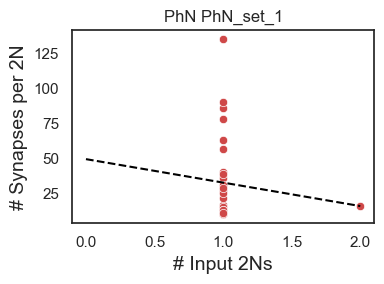

PhN PhN_set_1
  fit: y = -16.73333·x + 49.46667
  R² = 0.010, slope p = 0.591
  median # input 2Ns = 1.0, median synapses/2N = 22.0
----------------------------------------


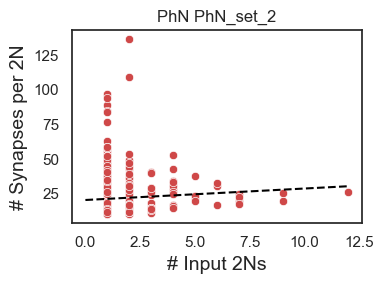

PhN PhN_set_2
  fit: y = 0.82784·x + 20.45868
  R² = 0.005, slope p = 0.186
  median # input 2Ns = 1.0, median synapses/2N = 16.0
----------------------------------------


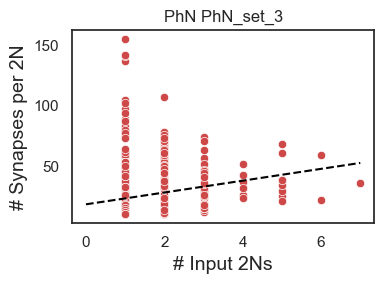

PhN PhN_set_3
  fit: y = 4.88919·x + 18.41297
  R² = 0.041, slope p = 3.01e-06
  median # input 2Ns = 1.0, median synapses/2N = 17.0
----------------------------------------


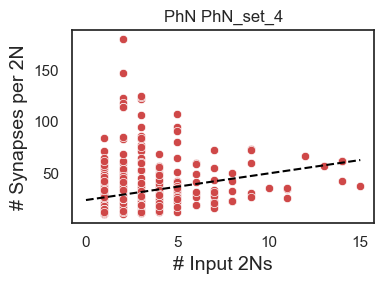

PhN PhN_set_4
  fit: y = 2.59334·x + 24.05812
  R² = 0.067, slope p = 5.76e-08
  median # input 2Ns = 2.0, median synapses/2N = 24.0
----------------------------------------


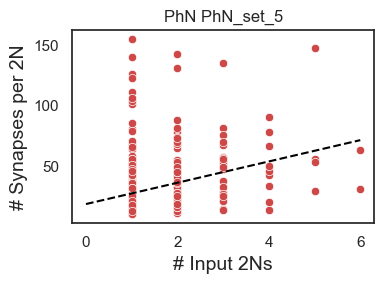

PhN PhN_set_5
  fit: y = 8.80900·x + 18.63474
  R² = 0.096, slope p = 2.24e-09
  median # input 2Ns = 1.0, median synapses/2N = 22.0
----------------------------------------


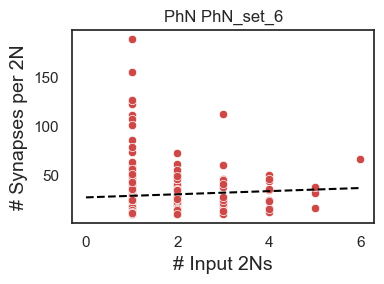

PhN PhN_set_6
  fit: y = 1.59307·x + 27.46779
  R² = 0.003, slope p = 0.387
  median # input 2Ns = 1.0, median synapses/2N = 21.5
----------------------------------------


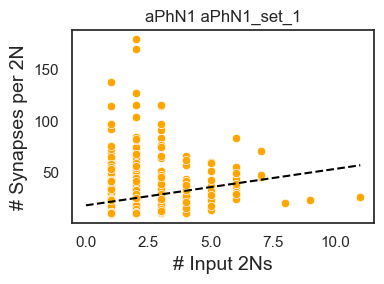

aPhN1 aPhN1_set_1
  fit: y = 3.51385·x + 18.81128
  R² = 0.050, slope p = 8.13e-11
  median # input 2Ns = 1.0, median synapses/2N = 19.0
----------------------------------------


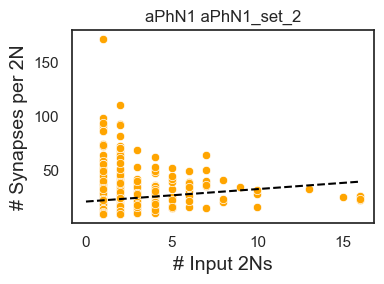

aPhN1 aPhN1_set_2
  fit: y = 1.14472·x + 21.86915
  R² = 0.017, slope p = 0.00159
  median # input 2Ns = 1.0, median synapses/2N = 18.3
----------------------------------------


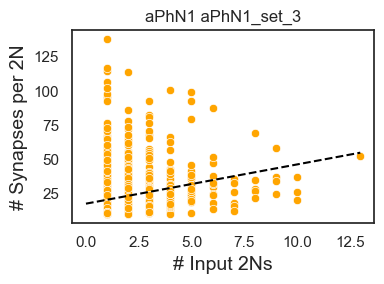

aPhN1 aPhN1_set_3
  fit: y = 2.86301·x + 17.90832
  R² = 0.058, slope p = 1.39e-14
  median # input 2Ns = 1.0, median synapses/2N = 17.0
----------------------------------------


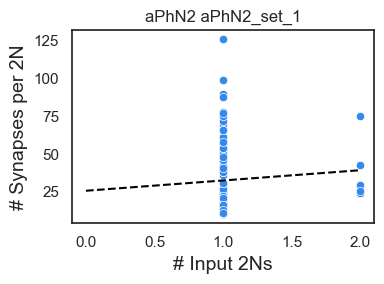

aPhN2 aPhN2_set_1
  fit: y = 6.79515·x + 25.70971
  R² = 0.003, slope p = 0.549
  median # input 2Ns = 1.0, median synapses/2N = 21.0
----------------------------------------


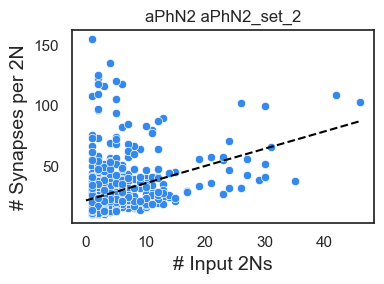

aPhN2 aPhN2_set_2
  fit: y = 1.42696·x + 21.62292
  R² = 0.142, slope p = 6.43e-24
  median # input 2Ns = 2.0, median synapses/2N = 21.0
----------------------------------------


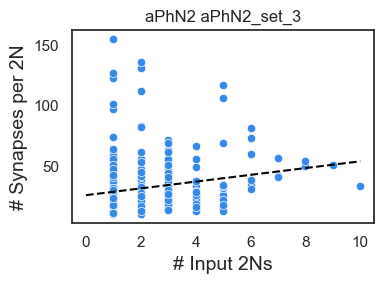

aPhN2 aPhN2_set_3
  fit: y = 2.80065·x + 25.97459
  R² = 0.036, slope p = 0.00138
  median # input 2Ns = 2.0, median synapses/2N = 25.0
----------------------------------------


In [155]:
### 3) Now run it on each of your PhN, aPhN1, and aPhN2 third‐order sets

colors = {'PhN': '#cf4848', 'aPhN1': 'orange', 'aPhN2': '#3489eb'}

for modality, sets in [
    ('PhN', [('PhN_set_1', PhN_set_1_3Ns),
             ('PhN_set_2', PhN_set_2_3Ns),
             ('PhN_set_3', PhN_set_3_3Ns),
             ('PhN_set_4', PhN_set_4_3Ns),
             ('PhN_set_5', PhN_set_5_3Ns),
             ('PhN_set_6', PhN_set_6_3Ns)]),
    ('aPhN1', [('aPhN1_set_1', aPhN1_set_1_3Ns),
               ('aPhN1_set_2', aPhN1_set_2_3Ns),
               ('aPhN1_set_3', aPhN1_set_3_3Ns)]),
    ('aPhN2', [('aPhN2_set_1', aPhN2_set_1_3Ns),
               ('aPhN2_set_2', aPhN2_set_2_3Ns),
               ('aPhN2_set_3', aPhN2_set_3_3Ns)]),
]:
    for label, df in sets:
        title = f"{modality} {label}"
        synapse_scatter_3Ns(df, colors[modality], title)


In [156]:
### OLS regression & medians for your 3N DataFrames

import numpy as np
import statsmodels.api as sm
from IPython.display import display


def ols_3N(df, label):
    """
    df:     your 3N DataFrame, must have:
              - 'avg_upstream_synapses'
              - 'upstream_<label>_2Ns'
              - '<label>_syn_count'
    label:  string exactly matching that suffix (e.g. 'PhN_set_1')
    """
    up_col = f"upstream_{label}_2Ns"
    syn_col = f"{label}_syn_count"

    # build design matrix and fit
    X = sm.add_constant(df[up_col], has_constant='add')
    y = df['avg_upstream_synapses']
    model = sm.OLS(y, X, missing='drop').fit()

    # medians
    med_inputs = np.median(df[up_col].dropna())
    med_synapses = np.median(df[syn_col].dropna())

    # slope p‑value
    pval = model.pvalues.get(up_col, np.nan)

    # print summary
    print(f"\n=== {label} ===")
    print(f"Median # input 2Ns:           {med_inputs:.1f}")
    print(f"Median # total 2N synapses:   {med_synapses:.1f}")
    print(f"Slope p‑value:                {pval:.3g}\n")
    display(model.summary())
    print("-" * 60)


# run for all your sets:

for label in [
    'PhN_set_1', 'PhN_set_2', 'PhN_set_3', 'PhN_set_4', 'PhN_set_5', 'PhN_set_6',
    'aPhN1_set_1', 'aPhN1_set_2', 'aPhN1_set_3',
    'aPhN2_set_1', 'aPhN2_set_2', 'aPhN2_set_3'
]:
    # assume your variables are named exactly: <label>_3Ns
    df_name = f"{label}_3Ns"
    if df_name in globals():
        ols_3N(globals()[df_name], label)
    else:
        print(f"Warning: DataFrame {df_name} not found, skipping.")




=== PhN_set_1 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   25.0
Slope p‑value:                0.591



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.010
Model:                               OLS   Adj. R-squared:                 -0.024
Method:                    Least Squares   F-statistic:                    0.2956
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):              0.591
Time:                           01:37:48   Log-Likelihood:                -148.67
No. Observations:                     31   AIC:                             301.3
Df Residuals:                         29   BIC:                             304.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     49.4667     32.230      1.535      0.136     -16.450     115.384
upstream_PhN_set_1_2Ns   -16.7333     30.775     -0.544      0.591     -79.675      46.209
==============================================================================
Omnibus:                       21.238   Durbin-Watson:                   2.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.526
Skew:                           1.816   Prob(JB):                     6.39e-07
Kurtosis:                       5.981   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== PhN_set_2 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   20.0
Slope p‑value:                0.186



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.005
Model:                               OLS   Adj. R-squared:                  0.002
Method:                    Least Squares   F-statistic:                     1.754
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):              0.186
Time:                           01:37:48   Log-Likelihood:                -1550.1
No. Observations:                    369   AIC:                             3104.
Df Residuals:                        367   BIC:                             3112.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     20.4587      1.317     15.539      0.000      17.870      23.048
upstream_PhN_set_2_2Ns     0.8278      0.625      1.324      0.186      -0.401       2.057
==============================================================================
Omnibus:                      262.874   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2815.081
Skew:                           2.992   Prob(JB):                         0.00
Kurtosis:                      15.136   Cond. No.                         3.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== PhN_set_3 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   20.0
Slope p‑value:                3.01e-06



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.041
Model:                               OLS   Adj. R-squared:                  0.039
Method:                    Least Squares   F-statistic:                     22.29
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):           3.01e-06
Time:                           01:37:49   Log-Likelihood:                -2346.1
No. Observations:                    526   AIC:                             4696.
Df Residuals:                        524   BIC:                             4705.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     18.4130      1.758     10.471      0.000      14.958      21.868
upstream_PhN_set_3_2Ns     4.8892      1.035      4.722      0.000       2.855       6.923
==============================================================================
Omnibus:                      322.649   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2563.387
Skew:                           2.679   Prob(JB):                         0.00
Kurtosis:                      12.394   Cond. No.                         4.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== PhN_set_4 ===
Median # input 2Ns:           2.0
Median # total 2N synapses:   46.0
Slope p‑value:                5.76e-08



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.067
Model:                               OLS   Adj. R-squared:                  0.065
Method:                    Least Squares   F-statistic:                     30.52
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):           5.76e-08
Time:                           01:37:49   Log-Likelihood:                -1943.4
No. Observations:                    427   AIC:                             3891.
Df Residuals:                        425   BIC:                             3899.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     24.0581      1.689     14.247      0.000      20.739      27.377
upstream_PhN_set_4_2Ns     2.5933      0.469      5.525      0.000       1.671       3.516
==============================================================================
Omnibus:                      254.634   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1834.842
Skew:                           2.561   Prob(JB):                         0.00
Kurtosis:                      11.768   Cond. No.                         5.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== PhN_set_5 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   28.0
Slope p‑value:                2.24e-09



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.096
Model:                               OLS   Adj. R-squared:                  0.094
Method:                    Least Squares   F-statistic:                     37.68
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):           2.24e-09
Time:                           01:37:49   Log-Likelihood:                -1638.9
No. Observations:                    355   AIC:                             3282.
Df Residuals:                        353   BIC:                             3290.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     18.6347      2.487      7.493      0.000      13.744      23.526
upstream_PhN_set_5_2Ns     8.8090      1.435      6.138      0.000       5.987      11.631
==============================================================================
Omnibus:                      181.782   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.253
Skew:                           2.231   Prob(JB):                    1.95e-191
Kurtosis:                       9.282   Cond. No.                         4.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== PhN_set_6 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   32.0
Slope p‑value:                0.387



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.003
Model:                               OLS   Adj. R-squared:                 -0.001
Method:                    Least Squares   F-statistic:                    0.7505
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):              0.387
Time:                           01:37:49   Log-Likelihood:                -1012.2
No. Observations:                    216   AIC:                             2028.
Df Residuals:                        214   BIC:                             2035.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     27.4678      3.515      7.815      0.000      20.540      34.395
upstream_PhN_set_6_2Ns     1.5931      1.839      0.866      0.387      -2.032       5.218
==============================================================================
Omnibus:                      154.601   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1245.349
Skew:                           2.847   Prob(JB):                    3.77e-271
Kurtosis:                      13.293   Cond. No.                         4.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== aPhN1_set_1 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   28.0
Slope p‑value:                8.13e-11



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.050
Model:                               OLS   Adj. R-squared:                  0.048
Method:                    Least Squares   F-statistic:                     43.34
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):           8.13e-11
Time:                           01:37:49   Log-Likelihood:                -3638.4
No. Observations:                    833   AIC:                             7281.
Df Residuals:                        831   BIC:                             7290.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       18.8113      1.185     15.881      0.000      16.486      21.136
upstream_aPhN1_set_1_2Ns     3.5138      0.534      6.584      0.000       2.466       4.561
==============================================================================
Omnibus:                      579.560   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7910.887
Skew:                           3.050   Prob(JB):                         0.00
Kurtosis:                      16.810   Cond. No.                         4.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== aPhN1_set_2 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   28.0
Slope p‑value:                0.00159



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.017
Model:                               OLS   Adj. R-squared:                  0.015
Method:                    Least Squares   F-statistic:                     10.06
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):            0.00159
Time:                           01:37:49   Log-Likelihood:                -2563.6
No. Observations:                    600   AIC:                             5131.
Df Residuals:                        598   BIC:                             5140.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       21.8691      1.021     21.422      0.000      19.864      23.874
upstream_aPhN1_set_2_2Ns     1.1447      0.361      3.172      0.002       0.436       1.854
==============================================================================
Omnibus:                      397.791   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4699.983
Skew:                           2.826   Prob(JB):                         0.00
Kurtosis:                      15.492   Cond. No.                         4.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== aPhN1_set_3 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   26.0
Slope p‑value:                1.39e-14



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.058
Model:                               OLS   Adj. R-squared:                  0.057
Method:                    Least Squares   F-statistic:                     61.10
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):           1.39e-14
Time:                           01:37:49   Log-Likelihood:                -4176.4
No. Observations:                    988   AIC:                             8357.
Df Residuals:                        986   BIC:                             8367.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       17.9083      0.871     20.558      0.000      16.199      19.618
upstream_aPhN1_set_3_2Ns     2.8630      0.366      7.817      0.000       2.144       3.582
==============================================================================
Omnibus:                      577.737   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4616.943
Skew:                           2.640   Prob(JB):                         0.00
Kurtosis:                      12.180   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== aPhN2_set_1 ===
Median # input 2Ns:           1.0
Median # total 2N synapses:   21.0
Slope p‑value:                0.549



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.003
Model:                               OLS   Adj. R-squared:                 -0.006
Method:                    Least Squares   F-statistic:                    0.3616
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):              0.549
Time:                           01:37:49   Log-Likelihood:                -498.47
No. Observations:                    108   AIC:                             1001.
Df Residuals:                        106   BIC:                             1006.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       25.7097     12.060      2.132      0.035       1.800      49.619
upstream_aPhN2_set_1_2Ns     6.7951     11.300      0.601      0.549     -15.609      29.199
==============================================================================
Omnibus:                       24.082   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.352
Skew:                           1.216   Prob(JB):                     1.56e-07
Kurtosis:                       4.026   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== aPhN2_set_2 ===
Median # input 2Ns:           2.0
Median # total 2N synapses:   46.0
Slope p‑value:                6.43e-24



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.142
Model:                               OLS   Adj. R-squared:                  0.140
Method:                    Least Squares   F-statistic:                     110.0
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):           6.43e-24
Time:                           01:37:49   Log-Likelihood:                -2927.0
No. Observations:                    669   AIC:                             5858.
Df Residuals:                        667   BIC:                             5867.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       21.6229      0.931     23.214      0.000      19.794      23.452
upstream_aPhN2_set_2_2Ns     1.4270      0.136     10.486      0.000       1.160       1.694
==============================================================================
Omnibus:                      424.801   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3988.103
Skew:                           2.793   Prob(JB):                         0.00
Kurtosis:                      13.577   Cond. No.                         8.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------

=== aPhN2_set_3 ===
Median # input 2Ns:           2.0
Median # total 2N synapses:   42.0
Slope p‑value:                0.00138



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.036
Model:                               OLS   Adj. R-squared:                  0.033
Method:                    Least Squares   F-statistic:                     10.44
Date:                   Sat, 26 Apr 2025   Prob (F-statistic):            0.00138
Time:                           01:37:49   Log-Likelihood:                -1280.0
No. Observations:                    281   AIC:                             2564.
Df Residuals:                        279   BIC:                             2571.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       25.9746      2.335     11.126      0.000      21.379      30.570
upstream_aPhN2_set_3_2Ns     2.8006      0.867      3.232      0.001       1.095       4.507
==============================================================================
Omnibus:                      164.950   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              965.986
Skew:                           2.452   Prob(JB):                    1.73e-210
Kurtosis:                      10.646   Cond. No.                         4.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------------------------------------------------


### Plot distribution of 2N-3N connection strength

We are quantifying the total number of 2N input synapses that each 3N receives, and looking at the distribution across all 3Ns.

In [157]:
# Assuming you've already computed your third_order outputs:
# PhN
set_1_3Ns  = pd.merge(PhN_set_1_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
set_2_3Ns  = pd.merge(PhN_set_2_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
set_3_3Ns  = pd.merge(PhN_set_3_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
set_4_3Ns  = pd.merge(PhN_set_4_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
set_5_3Ns  = pd.merge(PhN_set_5_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
set_6_3Ns  = pd.merge(PhN_set_6_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')

# aPhN1
aPhN1_set_1_3Ns = pd.merge(aPhN1_set_1_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
aPhN1_set_2_3Ns = pd.merge(aPhN1_set_2_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
aPhN1_set_3_3Ns = pd.merge(aPhN1_set_3_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')

# aPhN2
aPhN2_set_1_3Ns = pd.merge(aPhN2_set_1_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
aPhN2_set_2_3Ns = pd.merge(aPhN2_set_2_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')
aPhN2_set_3_3Ns = pd.merge(aPhN2_set_3_third_order_connectivity, neurons_data, left_on='post_root_id', right_on='root_id', how='inner')


In [158]:
### 3c. Distribution of total 2N→3N synapses

import numpy as np
import matplotlib.pyplot as plt

# 1) bins from 0 to 200 so the last bin is “200+”
bins = np.linspace(0, 200, 15)


# 2) helper that builds the histogram for one toc table
def synapse_distribution_from_toc(toc):
    # total synapses per 3N
    total_syn = toc.groupby('post_root_id')['syn_count'].sum()
    # clip at 200
    clipped = total_syn.clip(upper=200)
    freqs, _ = np.histogram(clipped, bins=bins)
    return freqs


# 3) collect all your workflows in one dict
workflows = {
    'PhN Set 1': PhN_set_1_toc,
    'PhN Set 2': PhN_set_2_toc,
    'PhN Set 3': PhN_set_3_toc,
    'PhN Set 4': PhN_set_4_toc,
    'PhN Set 5': PhN_set_5_toc,
    'PhN Set 6': PhN_set_6_toc,
    'aPhN1 Set 1': aPhN1_set_1_toc,
    'aPhN1 Set 2': aPhN1_set_2_toc,
    'aPhN1 Set 3': aPhN1_set_3_toc,
    'aPhN2 Set 1': aPhN2_set_1_toc,
    'aPhN2 Set 2': aPhN2_set_2_toc,
    'aPhN2 Set 3': aPhN2_set_3_toc,
}

plt.figure(figsize=(10, 6))

for label, toc in workflows.items():
    freqs = synapse_distribution_from_toc(toc)
    # choose line style by modality prefix
    if label.startswith('PhN '):
        ls = '-'
    elif label.startswith('aPhN1'):
        ls = '--'
    else:
        ls = ':'
    plt.plot(bins[1:], freqs, linestyle=ls, linewidth=1.5, label=label)

#plt.xticks(bins[1:], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Total 2N→3N synapses (clipped at 200)', fontsize=14)
plt.ylabel('Number of 3Ns', fontsize=14)
plt.title('Distribution of 2N→3N Connection Strengths', fontsize=16)
plt.legend(frameon=False, fontsize=9, ncol=2)
plt.tight_layout()
plt.show()


NameError: name 'PhN_set_1_toc' is not defined

In [159]:
# 1) Same bins so the last bin is “200+”
bins = np.linspace(0, 200, 15)

# 2) Helper to get the histogram for one toc table
def synapse_distribution_from_toc(toc):
    total_syn = toc.groupby('post_root_id')['syn_count'].sum()
    clipped   = total_syn.clip(upper=200)
    freqs, _  = np.histogram(clipped, bins=bins)
    return freqs

# 3) Group your toc tables by modality
groups = {
    'PhN':   [
        PhN_set_1_toc, PhN_set_2_toc, PhN_set_3_toc,
        PhN_set_4_toc, PhN_set_5_toc, PhN_set_6_toc
    ],
    'aPhN1': [aPhN1_set_1_toc, aPhN1_set_2_toc, aPhN1_set_3_toc],
    'aPhN2': [aPhN2_set_1_toc, aPhN2_set_2_toc, aPhN2_set_3_toc],
}

# 4) Sum histograms within each group
group_freqs = {}
for name, tocs in groups.items():
    # start with zeros
    acc = np.zeros(len(bins)-1, dtype=int)
    for toc in tocs:
        acc += synapse_distribution_from_toc(toc)
    group_freqs[name] = acc

# 5) Plot all three
plt.figure(figsize=(6,4))
styles = {'PhN':'-', 'aPhN1':'--', 'aPhN2':':'}
for name, freqs in group_freqs.items():
    plt.plot(bins[1:], freqs,
             linestyle=styles[name],
             lw=2,
             label=name)

plt.xlabel('Total 2N→3N synapses (clipped at 200)', fontsize=12)
plt.ylabel('Number of 3Ns',                          fontsize=12)
plt.title ('Connection–strength distribution by modality', fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


NameError: name 'PhN_set_1_toc' is not defined

## 3f. Classifying 3Ns by their anatomical and functional properties

### Defining 3Ns as local vs. non-local neurons

Local refers to 3Ns whose output connections are entirely within the SEZ; non-local refers to 3Ns with at least one connection outside the SEZ. The code refers to non-local neurons as "projection neurons" but we changed the terminology in the paper because some non-local neurons may reside entirely outside of the SEZ rather than projecting from the SEZ to other regions.

In [160]:
# ——— Apply classification to each of your PhN sets ———
set_1_3Ns_categorized = pd.merge(set_1_3Ns,   classify_neurons(set_1_3Ns),   on='root_id')
set_2_3Ns_categorized = pd.merge(set_2_3Ns,   classify_neurons(set_2_3Ns),   on='root_id')
set_3_3Ns_categorized = pd.merge(set_3_3Ns,   classify_neurons(set_3_3Ns),   on='root_id')
set_4_3Ns_categorized = pd.merge(set_4_3Ns,   classify_neurons(set_4_3Ns),   on='root_id')
set_5_3Ns_categorized = pd.merge(set_5_3Ns,   classify_neurons(set_5_3Ns),   on='root_id')
set_6_3Ns_categorized = pd.merge(set_6_3Ns,   classify_neurons(set_6_3Ns),   on='root_id')

# ——— Apply classification to your aPhN1 sets ———
aPhN1_set_1_3Ns_categorized = pd.merge(aPhN1_set_1_3Ns, classify_neurons(aPhN1_set_1_3Ns), on='root_id')
aPhN1_set_2_3Ns_categorized = pd.merge(aPhN1_set_2_3Ns, classify_neurons(aPhN1_set_2_3Ns), on='root_id')
aPhN1_set_3_3Ns_categorized = pd.merge(aPhN1_set_3_3Ns, classify_neurons(aPhN1_set_3_3Ns), on='root_id')

# ——— Apply classification to your aPhN2 sets ———
aPhN2_set_1_3Ns_categorized = pd.merge(aPhN2_set_1_3Ns, classify_neurons(aPhN2_set_1_3Ns), on='root_id')
aPhN2_set_2_3Ns_categorized = pd.merge(aPhN2_set_2_3Ns, classify_neurons(aPhN2_set_2_3Ns), on='root_id')
aPhN2_set_3_3Ns_categorized = pd.merge(aPhN2_set_3_3Ns, classify_neurons(aPhN2_set_3_3Ns), on='root_id')

In [161]:
# Print how many unique 3Ns remain in each categorized table
for name, df in [
    ("PhN Set 1", set_1_3Ns_categorized),
    ("PhN Set 2", set_2_3Ns_categorized),
    ("PhN Set 3", set_3_3Ns_categorized),
    ("PhN Set 4", set_4_3Ns_categorized),
    ("PhN Set 5", set_5_3Ns_categorized),
    ("PhN Set 6", set_6_3Ns_categorized),
    ("aPhN1 Set 1", aPhN1_set_1_3Ns_categorized),
    ("aPhN1 Set 2", aPhN1_set_2_3Ns_categorized),
    ("aPhN1 Set 3", aPhN1_set_3_3Ns_categorized),
    ("aPhN2 Set 1", aPhN2_set_1_3Ns_categorized),
    ("aPhN2 Set 2", aPhN2_set_2_3Ns_categorized),
    ("aPhN2 Set 3", aPhN2_set_3_3Ns_categorized),
]:
    print(f"{name}: {df['root_id'].nunique()} neurons")


PhN Set 1: 30 neurons
PhN Set 2: 332 neurons
PhN Set 3: 514 neurons
PhN Set 4: 402 neurons
PhN Set 5: 346 neurons
PhN Set 6: 211 neurons
aPhN1 Set 1: 804 neurons
aPhN1 Set 2: 587 neurons
aPhN1 Set 3: 971 neurons
aPhN2 Set 1: 106 neurons
aPhN2 Set 2: 625 neurons
aPhN2 Set 3: 274 neurons


In [162]:
# Save full 3N lists
set_1_3Ns.to_csv('set_1_3Ns.csv', index=False)
set_2_3Ns.to_csv('set_2_3Ns.csv', index=False)
set_3_3Ns.to_csv('set_3_3Ns.csv', index=False)
set_4_3Ns.to_csv('set_4_3Ns.csv', index=False)
set_5_3Ns.to_csv('set_5_3Ns.csv', index=False)
set_6_3Ns.to_csv('set_6_3Ns.csv', index=False)

aPhN1_set_1_3Ns.to_csv('aPhN1_set_1_3Ns.csv', index=False)
aPhN1_set_2_3Ns.to_csv('aPhN1_set_2_3Ns.csv', index=False)
aPhN1_set_3_3Ns.to_csv('aPhN1_set_3_3Ns.csv', index=False)

aPhN2_set_1_3Ns.to_csv('aPhN2_set_1_3Ns.csv', index=False)
aPhN2_set_2_3Ns.to_csv('aPhN2_set_2_3Ns.csv', index=False)
aPhN2_set_3_3Ns.to_csv('aPhN2_set_3_3Ns.csv', index=False)

# Save only the categorized (SEZ‑local vs non‑local) subsets
set_1_3Ns_categorized.to_csv('set_1_3Ns_categorized.csv', index=False)
set_2_3Ns_categorized.to_csv('set_2_3Ns_categorized.csv', index=False)
set_3_3Ns_categorized.to_csv('set_3_3Ns_categorized.csv', index=False)
set_4_3Ns_categorized.to_csv('set_4_3Ns_categorized.csv', index=False)
set_5_3Ns_categorized.to_csv('set_5_3Ns_categorized.csv', index=False)
set_6_3Ns_categorized.to_csv('set_6_3Ns_categorized.csv', index=False)

aPhN1_set_1_3Ns_categorized.to_csv('aPhN1_set_1_3Ns_categorized.csv', index=False)
aPhN1_set_2_3Ns_categorized.to_csv('aPhN1_set_2_3Ns_categorized.csv', index=False)
aPhN1_set_3_3Ns_categorized.to_csv('aPhN1_set_3_3Ns_categorized.csv', index=False)

aPhN2_set_1_3Ns_categorized.to_csv('aPhN2_set_1_3Ns_categorized.csv', index=False)
aPhN2_set_2_3Ns_categorized.to_csv('aPhN2_set_2_3Ns_categorized.csv', index=False)
aPhN2_set_3_3Ns_categorized.to_csv('aPhN2_set_3_3Ns_categorized.csv', index=False)

### Comparing the number of local vs. non-local 3Ns across modalities

/Users/yaolab/.pyenv/versions/scanpyenv-3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


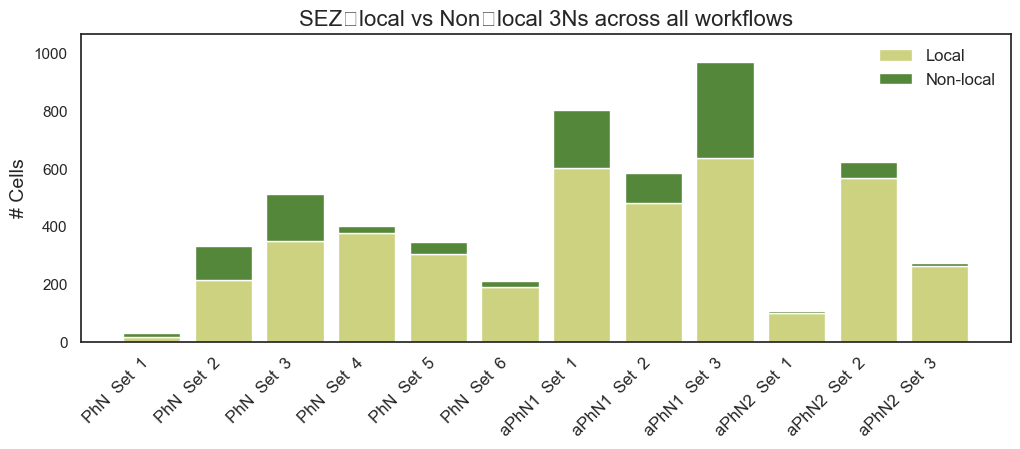

In [163]:
# 1) Define the categories and corresponding DataFrames
categories = [
    'PhN  Set  1', 'PhN  Set  2', 'PhN  Set  3', 'PhN  Set  4', 'PhN  Set  5', 'PhN  Set  6',
    'aPhN1  Set  1', 'aPhN1  Set  2', 'aPhN1  Set  3',
    'aPhN2  Set  1', 'aPhN2  Set  2', 'aPhN2  Set  3'
]
datasets = [
    set_1_3Ns_categorized, set_2_3Ns_categorized, set_3_3Ns_categorized,
    set_4_3Ns_categorized, set_5_3Ns_categorized, set_6_3Ns_categorized,
    aPhN1_set_1_3Ns_categorized, aPhN1_set_2_3Ns_categorized, aPhN1_set_3_3Ns_categorized,
    aPhN2_set_1_3Ns_categorized, aPhN2_set_2_3Ns_categorized, aPhN2_set_3_3Ns_categorized
]

# 2) Tally local vs non‑local for each
local_counts = []
nonlocal_counts = []
for df in datasets:
    local_counts.append(df.query("neuron_type == 'local'")['root_id'].nunique())
    nonlocal_counts.append(df.query("neuron_type == 'projection'")['root_id'].nunique())

# 3) Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 4))

x = np.arange(len(categories))
width = 0.8

ax.bar(x, local_counts, width, label='Local', color='#CCD27F')
ax.bar(x, nonlocal_counts, width, bottom=local_counts, label='Non-local', color='#54873A')

ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('# Cells', fontsize=14)
ax.set_title('SEZ‑local vs Non‑local 3Ns across all workflows', fontsize=16)
ax.legend(frameon=False, fontsize=12, loc='upper right')

# y‑limit just a bit above your tallest stack
ax.set_ylim(0, max(np.array(local_counts) + np.array(nonlocal_counts)) * 1.1)

#plt.tight_layout()
plt.show()


In [164]:
# Show numbers of local and projection neurons
print(local_neurons)
print(projection_neurons)

[242, 262, 244]
[65, 131, 3]


### Get output synapses of 3Ns to analyze location and NT types
- includes any outputs of a 3N
- minimum of 5 synapses
- we are not filtering out postsynaptic targets that are also PhN-SAs, 2Ns, or 3Ns

In [165]:
### Get output synapses of 3Ns to analyze location and NT types

# PhN 3N outputs (keep only edges with ≥5 synapses)
set_1_3N_outputs = neuronal_outputs(set_1_3Ns)
set_1_3N_outputs = set_1_3N_outputs[set_1_3N_outputs['syn_count'] >= 5]

set_2_3N_outputs = neuronal_outputs(set_2_3Ns)
set_2_3N_outputs = set_2_3N_outputs[set_2_3N_outputs['syn_count'] >= 5]

set_3_3N_outputs = neuronal_outputs(set_3_3Ns)
set_3_3N_outputs = set_3_3N_outputs[set_3_3N_outputs['syn_count'] >= 5]

set_4_3N_outputs = neuronal_outputs(set_4_3Ns)
set_4_3N_outputs = set_4_3N_outputs[set_4_3N_outputs['syn_count'] >= 5]

set_5_3N_outputs = neuronal_outputs(set_5_3Ns)
set_5_3N_outputs = set_5_3N_outputs[set_5_3N_outputs['syn_count'] >= 5]

set_6_3N_outputs = neuronal_outputs(set_6_3Ns)
set_6_3N_outputs = set_6_3N_outputs[set_6_3N_outputs['syn_count'] >= 5]

# aPhN1 3N outputs (keep only edges with ≥5 synapses)
aPhN1_set_1_3N_outputs = neuronal_outputs(aPhN1_set_1_3Ns)
aPhN1_set_1_3N_outputs = aPhN1_set_1_3N_outputs[aPhN1_set_1_3N_outputs['syn_count'] >= 5]

aPhN1_set_2_3N_outputs = neuronal_outputs(aPhN1_set_2_3Ns)
aPhN1_set_2_3N_outputs = aPhN1_set_2_3N_outputs[aPhN1_set_2_3N_outputs['syn_count'] >= 5]

aPhN1_set_3_3N_outputs = neuronal_outputs(aPhN1_set_3_3Ns)
aPhN1_set_3_3N_outputs = aPhN1_set_3_3N_outputs[aPhN1_set_3_3N_outputs['syn_count'] >= 5]

# aPhN2 3N outputs (keep only edges with ≥5 synapses)
aPhN2_set_1_3N_outputs = neuronal_outputs(aPhN2_set_1_3Ns)
aPhN2_set_1_3N_outputs = aPhN2_set_1_3N_outputs[aPhN2_set_1_3N_outputs['syn_count'] >= 5]

aPhN2_set_2_3N_outputs = neuronal_outputs(aPhN2_set_2_3Ns)
aPhN2_set_2_3N_outputs = aPhN2_set_2_3N_outputs[aPhN2_set_2_3N_outputs['syn_count'] >= 5]

aPhN2_set_3_3N_outputs = neuronal_outputs(aPhN2_set_3_3Ns)
aPhN2_set_3_3N_outputs = aPhN2_set_3_3N_outputs[aPhN2_set_3_3N_outputs['syn_count'] >= 5]


### Comparing the number of 3N output synapses within vs. outside the SEZ across modalities

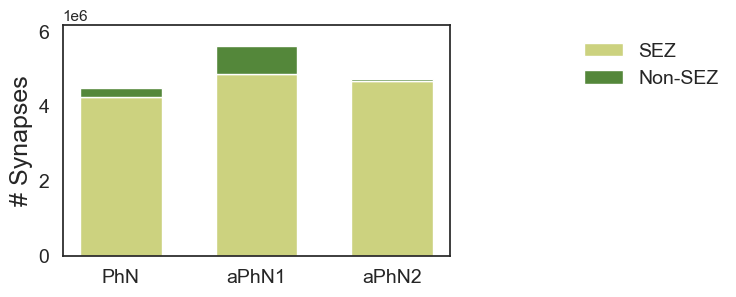

In [166]:
### Comparing the number of 3N output synapses within vs. outside the SEZ across modalities

# 1) list your 3N → output tables by modality
phn_outputs = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs,
               set_4_3N_outputs, set_5_3N_outputs, set_6_3N_outputs]
aphn1_outputs = [aPhN1_set_1_3N_outputs, aPhN1_set_2_3N_outputs, aPhN1_set_3_3N_outputs]
aphn2_outputs = [aPhN2_set_1_3N_outputs, aPhN2_set_2_3N_outputs, aPhN2_set_3_3N_outputs]


# 2) helper that sums 'syn_count' for a given location across a list of dataframes
def sum_synapses(dfs, location_tag):
    total = 0
    for df in dfs:
        # use boolean indexing instead of .query()
        total += df.loc[
            df['location_of_connection'] == location_tag,
            'syn_count'
        ].sum()
    return total


# 3) compute for each modality
categories = ['PhN', 'aPhN1', 'aPhN2']
local_synapses = [
    sum_synapses(phn_outputs, 'local'),
    sum_synapses(aphn1_outputs, 'local'),
    sum_synapses(aphn2_outputs, 'local'),
]
non_sez_synapses = [
    sum_synapses(phn_outputs, 'outside_SEZ'),
    sum_synapses(aphn1_outputs, 'outside_SEZ'),
    sum_synapses(aphn2_outputs, 'outside_SEZ'),
]

# 4) plot
fig, ax = plt.subplots(figsize=(5, 3))
x = np.arange(len(categories)) + 1
width = 0.6

ax.bar(x, local_synapses, width, label='SEZ', color='#CCD27F')
ax.bar(x, non_sez_synapses, width,
       bottom=local_synapses, label='Non-SEZ', color='#54873A')

ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=14)
ax.set_ylabel('# Synapses', fontsize=18)
ax.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.3, 1))
ax.set_ylim(0, max(np.array(local_synapses) + np.array(non_sez_synapses)) * 1.1)
ax.tick_params(axis='y', labelsize=14)

#plt.tight_layout()
plt.show()


In [167]:
# Show numbers of local and non-local synapses
print(local_synapses)
print(projection_synapses)

[np.int64(4239507), np.int64(4867156), np.int64(4658099)]
[np.int64(22207), np.int64(30133), np.int64(185)]


### Identify 3N superclasses

In [168]:
### Identify 3N superclasses

# 1) Put all of your 3N‑DataFrames into a dict
sets_3Ns = {
    'set_1': set_1_3Ns,
    'set_2': set_2_3Ns,
    'set_3': set_3_3Ns,
    'set_4': set_4_3Ns,
    'set_5': set_5_3Ns,
    'set_6': set_6_3Ns,
    'aPhN1_set_1': aPhN1_set_1_3Ns,
    'aPhN1_set_2': aPhN1_set_2_3Ns,
    'aPhN1_set_3': aPhN1_set_3_3Ns,
    'aPhN2_set_1': aPhN2_set_1_3Ns,
    'aPhN2_set_2': aPhN2_set_2_3Ns,
    'aPhN2_set_3': aPhN2_set_3_3Ns,
}

# 2) Merge each unique root_id list with classification_other
classified_3Ns = {}
for name, df in sets_3Ns.items():
    unique_ids = pd.DataFrame({'root_id': df['root_id'].unique()})
    classified_3Ns[name] = pd.merge(
        unique_ids,
        classification_other,
        on='root_id',
        how='left'
    )

# 3) If you still want individual variables, you can unpack:
set_1_3Ns_classified = classified_3Ns['set_1']
set_2_3Ns_classified = classified_3Ns['set_2']
set_3_3Ns_classified = classified_3Ns['set_3']
set_4_3Ns_classified = classified_3Ns['set_4']
set_5_3Ns_classified = classified_3Ns['set_5']
set_6_3Ns_classified = classified_3Ns['set_6']
aPhN1_set_1_3Ns_classified = classified_3Ns['aPhN1_set_1']
aPhN1_set_2_3Ns_classified = classified_3Ns['aPhN1_set_2']
aPhN1_set_3_3Ns_classified = classified_3Ns['aPhN1_set_3']
aPhN2_set_1_3Ns_classified = classified_3Ns['aPhN2_set_1']
aPhN2_set_2_3Ns_classified = classified_3Ns['aPhN2_set_2']
aPhN2_set_3_3Ns_classified = classified_3Ns['aPhN2_set_3']


In [169]:
# reorder the superclasses in desired order
categories = ['sensory', 'ascending', 'central',
              'descending', 'motor', 'endocrine',
              'optic', 'visual_projection', 'visual_centrifugal']
categories

['sensory',
 'ascending',
 'central',
 'descending',
 'motor',
 'endocrine',
 'optic',
 'visual_projection',
 'visual_centrifugal']

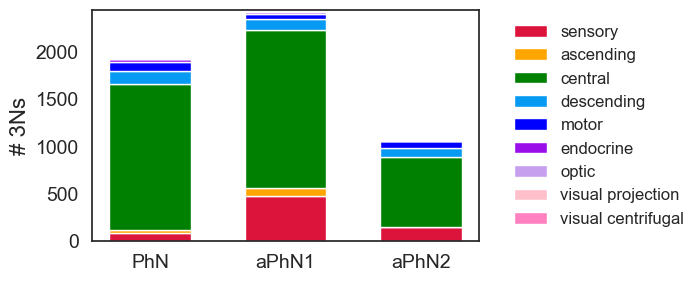

In [170]:
### Plot graph of 3N superclasses for three combined modalities: PhN, aPhN1, aPhN2

import matplotlib.pyplot as plt
import numpy as np

# Define the superclass categories (in fixed order for consistent plotting)
categories = ['sensory', 'ascending', 'central',
              'descending', 'motor', 'endocrine',
              'optic', 'visual projection', 'visual centrifugal']

# Group the classified datasets
phn_sets = [set_1_3Ns_classified, set_2_3Ns_classified, set_3_3Ns_classified,
            set_4_3Ns_classified, set_5_3Ns_classified, set_6_3Ns_classified]
aphn1_sets = [aPhN1_set_1_3Ns_classified, aPhN1_set_2_3Ns_classified, aPhN1_set_3_3Ns_classified]
aphn2_sets = [aPhN2_set_1_3Ns_classified, aPhN2_set_2_3Ns_classified, aPhN2_set_3_3Ns_classified]


# Helper function to count superclasses across a group of sets
def count_superclasses(dataset_group):
    combined = pd.concat(dataset_group, ignore_index=True)
    return combined['super_class'].dropna().value_counts()


# Compute superclass counts per modality group
phn_counts = count_superclasses(phn_sets)
aphn1_counts = count_superclasses(aphn1_sets)
aphn2_counts = count_superclasses(aphn2_sets)

# Combine counts into an array suitable for stacking
datasets_counts = [phn_counts, aphn1_counts, aphn2_counts]
array_plot = []

for category in categories:
    counts = []
    for counts_dict in datasets_counts:
        counts.append(counts_dict.get(category, 0))  # Use .get to insert 0 if missing
    array_plot.append(np.array(counts))

# Set plot parameters
modalities = ['PhN', 'aPhN1', 'aPhN2']
bar_l = np.arange(1, 4)
bar_width = 0.6
tick_pos = [i for i in bar_l]
palette = ['#dc143c', '#ffa500', 'green', '#069af3', '#0000ff', '#9a0eea',
           '#c79fef', '#ffc0cb', '#ff81c0']  # Colors per superclass

# Plotting
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)

# Plot first superclass
ax1 = ax.bar(bar_l, array_plot[0], width=bar_width, color=palette[0])
tot = array_plot[0]

# Stack remaining categories
for i in range(1, len(categories)):
    ax_i = ax.bar(bar_l, array_plot[i], bottom=tot, width=bar_width, color=palette[i])
    tot = tot + array_plot[i]

# Labels
ax.set_ylabel('# 3Ns', fontsize=16)
ax.legend(categories, loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False, fontsize=12)
plt.xticks(tick_pos, modalities, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, max(tot) + 25)
#plt.tight_layout()
plt.show()


In [171]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

array([[0.04375   , 0.19413466, 0.13327032],
       [0.01822917, 0.03758777, 0.00661626],
       [0.80104167, 0.69103676, 0.69943289],
       [0.0734375 , 0.04915324, 0.09168242],
       [0.05104167, 0.02065262, 0.06899811],
       [0.0125    , 0.00743494, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

### Plot proportions of ascending and descending neurons

This figure is not included in the paper as it is redundant with the superclass figure.

In [172]:
### Identify ascending and descending neurons in PhN, aPhN1, and aPhN2 sets combined

# Group the classified 3N datasets
phn_sets = [set_1_3Ns_classified, set_2_3Ns_classified, set_3_3Ns_classified,
            set_4_3Ns_classified, set_5_3Ns_classified, set_6_3Ns_classified]
aphn1_sets = [aPhN1_set_1_3Ns_classified, aPhN1_set_2_3Ns_classified, aPhN1_set_3_3Ns_classified]
aphn2_sets = [aPhN2_set_1_3Ns_classified, aPhN2_set_2_3Ns_classified, aPhN2_set_3_3Ns_classified]

modalities = ['PhN', 'aPhN1', 'aPhN2']
modality_sets = [phn_sets, aphn1_sets, aphn2_sets]

num_ANs_3Ns = []
num_DNs_3Ns = []
perc_ANs_3Ns = []
perc_DNs_3Ns = []

# Loop through modality groupings
for group in modality_sets:
    combined = pd.concat(group, ignore_index=True)
    total = len(combined)

    num_ANs = (combined['super_class'] == 'ascending').sum()
    num_DNs = (combined['super_class'] == 'descending').sum()

    num_ANs_3Ns.append(num_ANs)
    num_DNs_3Ns.append(num_DNs)
    perc_ANs_3Ns.append(num_ANs / total if total > 0 else 0)
    perc_DNs_3Ns.append(num_DNs / total if total > 0 else 0)

# Display results
for i, modality in enumerate(modalities):
    print(f"--- {modality} ---")
    print(f"# Ascending neurons: {num_ANs_3Ns[i]}")
    print(f"# Descending neurons: {num_DNs_3Ns[i]}")
    print(f"% Ascending neurons: {perc_ANs_3Ns[i] * 100:.2f}%")
    print(f"% Descending neurons: {perc_DNs_3Ns[i] * 100:.2f}%\n")


--- PhN ---
# Ascending neurons: 35
# Descending neurons: 141
% Ascending neurons: 1.82%
% Descending neurons: 7.33%

--- aPhN1 ---
# Ascending neurons: 91
# Descending neurons: 119
% Ascending neurons: 3.76%
% Descending neurons: 4.92%

--- aPhN2 ---
# Ascending neurons: 7
# Descending neurons: 97
% Ascending neurons: 0.66%
% Descending neurons: 9.17%



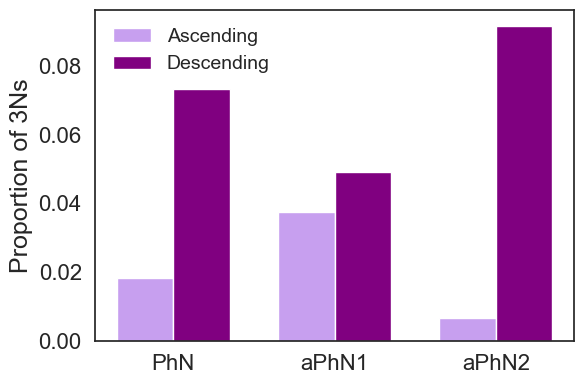

In [173]:
# Define the categories for PhN, aPhN1, and aPhN2
modalities = ['PhN', 'aPhN1', 'aPhN2']

# Data for the proportions of ascending and descending neurons (assuming 'perc_ANs_3Ns' and 'perc_DNs_3Ns' are computed)
# These lists should now contain proportions for PhN, aPhN1, and aPhN2

# Adjust bar positions
x = range(len(modalities))
bar_width = 0.35

# Create the bar plot
plt.figure(figsize=(6, 4))
plt.bar(x, perc_ANs_3Ns, width=bar_width, label="Ascending", color='#c79fef')
plt.bar([i + bar_width for i in x], perc_DNs_3Ns, width=bar_width, label="Descending", color='#800080')

# Labels and formatting
plt.ylabel('Proportion of 3Ns', size=18)
plt.xticks([i + bar_width / 2 for i in x], modalities, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, fontsize=14, loc='upper left')

plt.tight_layout()
plt.show()


### Identify 3N classes

In [174]:
# 1) Collect all classes across the three modalities (PhN, aPhN1, aPhN2)
categories = np.unique([
    *set_1_3Ns_classified['class'].dropna().unique(),
    *set_2_3Ns_classified['class'].dropna().unique(),
    *set_3_3Ns_classified['class'].dropna().unique(),
    *set_4_3Ns_classified['class'].dropna().unique(),
    *set_5_3Ns_classified['class'].dropna().unique(),
    *set_6_3Ns_classified['class'].dropna().unique(),
    *aPhN1_set_1_3Ns_classified['class'].dropna().unique(),
    *aPhN1_set_2_3Ns_classified['class'].dropna().unique(),
    *aPhN1_set_3_3Ns_classified['class'].dropna().unique(),
    *aPhN2_set_1_3Ns_classified['class'].dropna().unique(),
    *aPhN2_set_2_3Ns_classified['class'].dropna().unique(),
    *aPhN2_set_3_3Ns_classified['class'].dropna().unique()
])

# 2) Create a list of DataFrames for each set, including PhN, aPhN1, and aPhN2 sets
datasets = [
    set_1_3Ns_classified,
    set_2_3Ns_classified,
    set_3_3Ns_classified,
    set_4_3Ns_classified,
    set_5_3Ns_classified,
    set_6_3Ns_classified,
    aPhN1_set_1_3Ns_classified,
    aPhN1_set_2_3Ns_classified,
    aPhN1_set_3_3Ns_classified,
    aPhN2_set_1_3Ns_classified,
    aPhN2_set_2_3Ns_classified,
    aPhN2_set_3_3Ns_classified
]

# 3) For each set, get the value counts for the 'class' column (excluding NaNs)
datasets_counts = [df['class'].dropna().value_counts() for df in datasets]

# 4) Build a list of arrays of class counts for each unique class, filling missing ones with 0
array_plot = []
for class_name in categories:
    row_counts = []
    for val_counts in datasets_counts:
        row_counts.append(val_counts.get(class_name, 0))
    array_plot.append(np.array(row_counts))

# 5) (Optional) Filter out classes with very small counts (here thresh = 1)
thresh = 1
array_plot_2 = [arr for arr in array_plot if np.count_nonzero(arr >= thresh) > 0]
categories_2 = [categories[i] for i in range(len(array_plot)) if np.count_nonzero(array_plot[i] >= thresh) > 0]

# 6) Print summary information
print("Number of classes:", len(categories_2))
print("Fraction of inputs covered (total):", np.concatenate(array_plot_2).sum() / np.concatenate(array_plot).sum())

total_per_set = np.sum(array_plot, axis=0)
sum_array_plot_2 = np.sum(array_plot_2, axis=0)

# Use np.errstate to suppress divide warnings and assign nan where total is 0.
with np.errstate(divide='ignore', invalid='ignore'):
    fraction_per_set = np.where(total_per_set == 0, np.nan, sum_array_plot_2 / total_per_set)

print("Fraction of inputs covered by set:", fraction_per_set)
print("Classes:", categories_2)


Number of classes: 18
Fraction of inputs covered (total): 1.0
Fraction of inputs covered by set: [nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Classes: [np.str_('ALIN'), np.str_('ALLN'), np.str_('ALON'), np.str_('ALPN'), np.str_('AN'), np.str_('CX'), np.str_('DAN'), np.str_('LHCENT'), np.str_('LHLN'), np.str_('MBIN'), np.str_('MBON'), np.str_('TPN'), np.str_('gustatory'), np.str_('mAL'), np.str_('mechanosensory'), np.str_('pars_intercerebralis'), np.str_('pars_lateralis'), np.str_('unknown_sensory')]


In [175]:
# Define the desired order of categories
categories_sorted = ['gustatory', 'mechanosensory',
                     'AN', 'DN', 'motor', 'pars_intercerebralis',
                     'ALPN', 'ALIN', 'mAL', 'LHCENT', 'Kenyon_Cell']

# Initialize an empty list for sorted data
array_plot_sorted = []

# Add datasets for PhN, aPhN1, and aPhN2 to the existing datasets list
datasets = [
    set_1_3Ns_classified,
    set_2_3Ns_classified,
    set_3_3Ns_classified,
    set_4_3Ns_classified,
    set_5_3Ns_classified,
    set_6_3Ns_classified,
    aPhN1_set_1_3Ns_classified,
    aPhN1_set_2_3Ns_classified,
    aPhN1_set_3_3Ns_classified,
    aPhN2_set_1_3Ns_classified,
    aPhN2_set_2_3Ns_classified,
    aPhN2_set_3_3Ns_classified
]

# Get class counts for all sets including PhN, aPhN1, and aPhN2
datasets_counts = [df['class'].dropna().value_counts() for df in datasets]

# Loop through the sorted categories and extract counts from each dataset
for class_name in categories_sorted:
    row_counts = []
    for dataset_counts in datasets_counts:  # datasets_counts contains the class counts per set
        row_counts.append(dataset_counts.get(class_name, 0))  # Get the count, default to 0 if missing
    array_plot_sorted.append(np.array(row_counts))

# Calculate the number of 3Ns per set
num_3Ns = [
    len(set_1_3Ns),
    len(set_2_3Ns),
    len(set_3_3Ns),
    len(set_4_3Ns),
    len(set_5_3Ns),
    len(set_6_3Ns),
    len(aPhN1_set_1_3Ns),
    len(aPhN1_set_2_3Ns),
    len(aPhN1_set_3_3Ns),
    len(aPhN2_set_1_3Ns),
    len(aPhN2_set_2_3Ns),
    len(aPhN2_set_3_3Ns)
]

# Compute the number of neurons without a class and append it as a separate category
num_unknown = np.array(num_3Ns) - np.sum(array_plot_sorted, axis=0)
array_plot_sorted.append(num_unknown)

# Add 'Unknown' category at the end
categories_sorted.append('Unknown')

# Print summary
print("Final Categories:", categories_sorted)
print("Neurons without a class:", num_unknown)


Final Categories: ['gustatory', 'mechanosensory', 'AN', 'DN', 'motor', 'pars_intercerebralis', 'ALPN', 'ALIN', 'mAL', 'LHCENT', 'Kenyon_Cell', 'Unknown']
Neurons without a class: [  46  623  821 1305  630  453 1631 1267 1969  153 3010  779]


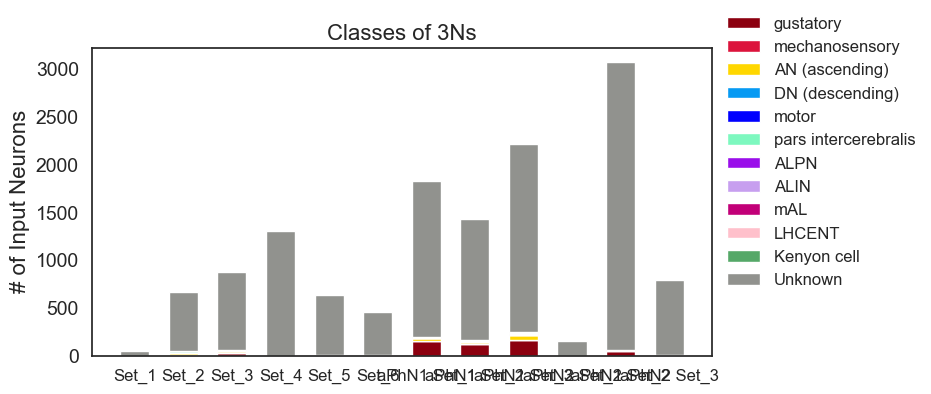

In [176]:
# Define modalities for all sets including PhN, aPhN1, and aPhN2
modalities = ['Set_1', 'Set_2', 'Set_3', 'Set_4', 'Set_5', 'Set_6',
              'aPhN1 Set_1', 'aPhN1 Set_2', 'aPhN1 Set_3',
              'aPhN2 Set_1', 'aPhN2 Set_2', 'aPhN2 Set_3']

# Create figure and axis for the plot
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 13)  # Adjust for twelve sets now
bar_width = 0.6
tick_pos = [i for i in bar_l]

# Define color palette
palette = ['#8c000f', '#dc143c', '#ffd700', '#069af3', '#0000ff', '#7DF8BF',
           '#9a0eea', '#c79fef', '#c20078', '#ffc0cb', 'g', '#91928E']

# Plot first category separately to initialize stacking
ax1 = ax.bar(bar_l, array_plot_sorted[0], width=bar_width, color=palette[0])
tot = array_plot_sorted[0]  # Track total inputs plotted so far

# Plot remaining categories stacked on top
for w in range(1, len(categories_sorted)):
    ax_i = ax.bar(bar_l, array_plot_sorted[w], bottom=tot, width=bar_width, color=palette[w])
    tot += array_plot_sorted[w]

# Add labels and legend
ax.set_title('Classes of 3Ns', fontsize=16)
ax.set_ylabel('# of Input Neurons', fontsize=16)

categories_legend = ['gustatory', 'mechanosensory',
                     'AN (ascending)', 'DN (descending)', 'motor', 'pars intercerebralis',
                     'ALPN', 'ALIN', 'mAL', 'LHCENT', 'Kenyon cell', 'Unknown']

ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
plt.xticks(tick_pos, modalities, fontsize=12)
plt.yticks(fontsize=14)

# Show plot
#plt.tight_layout()
plt.show()


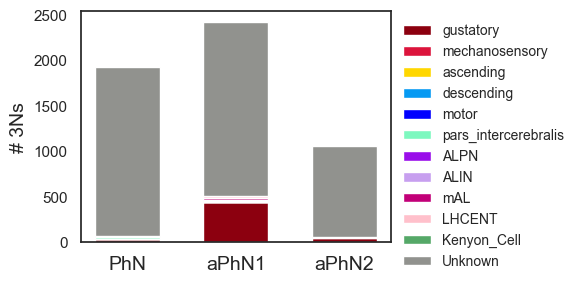

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 1) Define your three groups of DataFrames
phn_sets = [
    set_1_3Ns_classified, set_2_3Ns_classified, set_3_3Ns_classified,
    set_4_3Ns_classified, set_5_3Ns_classified, set_6_3Ns_classified
]
aphn1_sets = [
    aPhN1_set_1_3Ns_classified,
    aPhN1_set_2_3Ns_classified,
    aPhN1_set_3_3Ns_classified
]
aphn2_sets = [
    aPhN2_set_1_3Ns_classified,
    aPhN2_set_2_3Ns_classified,
    aPhN2_set_3_3Ns_classified
]

# 2) Define the ordered list of classes (make sure to include 'Unknown' if you want it)
categories = [
    'gustatory', 'mechanosensory', 'ascending', 'descending',
    'motor', 'pars_intercerebralis', 'ALPN', 'ALIN', 'mAL', 'LHCENT',
    'Kenyon_Cell', 'Unknown'
]

# 3) Helper to aggregate across a list of DataFrames
def aggregate_group(df_list):
    cnt = Counter()
    for df in df_list:
        # count only non-null classes
        cnt.update(df['class'].dropna().tolist())
    # compute Unknown = total neurons – those assigned a known class
    total = sum(len(df) for df in df_list)
    known = sum(cnt[c] for c in categories if c != 'Unknown')
    cnt['Unknown'] = total - known
    return [cnt[c] for c in categories]

# 4) Build the 3×len(categories) array
phn_counts   = aggregate_group(phn_sets)
aphn1_counts = aggregate_group(aphn1_sets)
aphn2_counts = aggregate_group(aphn2_sets)

# 5) Plot
groups = ['PhN', 'aPhN1', 'aPhN2']
x = np.arange(len(groups))
width = 0.6

palette = [
    '#8c000f', '#dc143c', '#ffd700', '#069af3', '#0000ff', '#7DF8BF',
    '#9a0eea', '#c79fef', '#c20078', '#ffc0cb', 'g', '#91928E'
]

fig, ax = plt.subplots(figsize=(4,3))
bottom = np.zeros(len(groups))

for i, cat in enumerate(categories):
    vals = [phn_counts[i], aphn1_counts[i], aphn2_counts[i]]
    ax.bar(x, vals, width, bottom=bottom, color=palette[i], label=cat)
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=14)
ax.set_ylabel('# 3Ns', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, fontsize=10)
#plt.tight_layout()
plt.show()


In [178]:
# Get values for proportion of each type
proportions = array_plot_sorted/np.sum(array_plot_sorted, axis=0)
proportions

array([[5.00000000e-01, 5.02625656e-01, 5.09016870e-01, 5.00000000e-01,
        5.00000000e-01, 5.00000000e-01, 5.22362385e-01, 5.21595900e-01,
        5.19577960e-01, 5.00000000e-01, 5.03691550e-01, 5.02236422e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.91139241e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.20344545e-04, 0.00000000e+00],
       [0.00000000e+00, 1.12528132e-02, 8.14426992e-03, 0.00000000e+00,
        7.91139241e-04, 5.45851528e-03, 6.59403670e-03, 7.32064422e-03,
        1.12543962e-02, 0.00000000e+00, 1.14848236e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00

In [179]:
# Save grouped class numbers and proportions to CSV for PhN, aPhN1, and aPhN2

# 1) Define the three modalities
modalities = ['PhN', 'aPhN1', 'aPhN2']

# 2) Build a DataFrame of raw counts (array_plot_grouped should be a list of three lists:
#    [phn_counts, aphn1_counts, aphn2_counts], each of length = number of classes)
_3N_class_numbers = pd.DataFrame(
    {mod: counts for mod, counts in zip(modalities, [phn_counts, aphn1_counts, aphn2_counts])},
    index=categories_legend
)
_3N_class_numbers.to_csv('3N_class_numbers_grouped.csv')

# 3) Compute proportions per group (each column sums to 1)
_3N_class_proportions = _3N_class_numbers.divide(_3N_class_numbers.sum(axis=0), axis=1)
_3N_class_proportions.to_csv('3N_class_proportions_grouped.csv')


### Quantify the neurotransmitter types for local and projection 3N outputs across modalities

We are only including ACH, GABA, GLUT neurotransmitter types here, which represent the vast majority of 3N synapses.

Note that this analysis quantifies 3N outputs by the number of connections, not synapses.

In [180]:
import numpy as np
import matplotlib.pyplot as plt


# helper functions (unchanged)
def count_NTs(dfs):
    """
    For each DataFrame in dfs,
    count total synapse counts for ACH, GABA, and GLUT.
    """
    counts = {'ACH': [], 'GABA': [], 'GLUT': []}
    for df in dfs:
        sub = df.query("location_of_connection=='local' and nt_type in ['ACH','GABA','GLUT']")
        for nt in counts:
            counts[nt].append(sub.query(f"nt_type=='{nt}'")['syn_count'].sum())
    return counts


def count_neurons(dfs):
    """
    For each DataFrame in dfs,
    count unique pre_root_id neurons for each NT.
    """
    neurons = {'ACH': [], 'GABA': [], 'GLUT': []}
    for df in dfs:
        sub = df.query("location_of_connection=='local' and nt_type in ['ACH','GABA','GLUT']")
        for nt in neurons:
            neurons[nt].append(sub.query(f"nt_type=='{nt}'")['pre_root_id'].nunique())
    return neurons

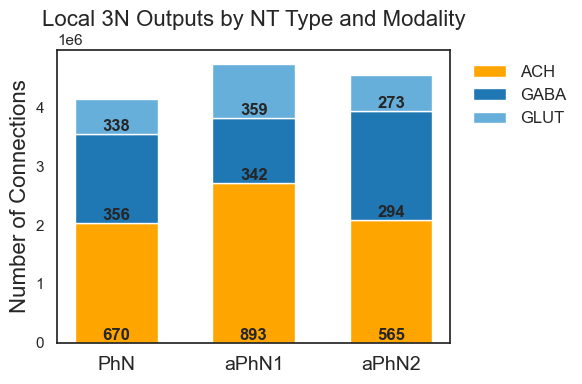

In [181]:
# 1) concatenate outputs into three modality‐level DataFrames
phn_outputs   = pd.concat([set_1_3N_outputs,
                           set_2_3N_outputs,
                           set_3_3N_outputs,
                           set_4_3N_outputs,
                           set_5_3N_outputs,
                           set_6_3N_outputs],
                          ignore_index=True)

aphn1_outputs = pd.concat([aPhN1_set_1_3N_outputs,
                           aPhN1_set_2_3N_outputs,
                           aPhN1_set_3_3N_outputs],
                          ignore_index=True)

aphn2_outputs = pd.concat([aPhN2_set_1_3N_outputs,
                           aPhN2_set_2_3N_outputs,
                           aPhN2_set_3_3N_outputs],
                          ignore_index=True)

# 2) run counts
modalities = ['PhN', 'aPhN1', 'aPhN2']
syn_counts = count_NTs([phn_outputs, aphn1_outputs, aphn2_outputs])
neuron_counts = count_neurons([phn_outputs, aphn1_outputs, aphn2_outputs])

# 3) plot
bar_l = np.arange(len(modalities)) + 1
width = 0.6

fig, ax = plt.subplots(figsize=(6,4))

# stack ACH, GABA, GLUT
h1 = ax.bar(bar_l, syn_counts['ACH'],    width, label='ACH',    color='orange')
h2 = ax.bar(bar_l, syn_counts['GABA'],   width, bottom=syn_counts['ACH'],   label='GABA',   color='#1f77b4')
bottom2 = np.array(syn_counts['ACH']) + np.array(syn_counts['GABA'])
h3 = ax.bar(bar_l, syn_counts['GLUT'],   width, bottom=bottom2,                   label='GLUT',   color='#67afdb')

# labels
ax.set_xticks(bar_l)
ax.set_xticklabels(modalities, fontsize=14)
ax.set_ylabel('Number of Connections', fontsize=16)
ax.set_title('Local 3N Outputs by NT Type and Modality', fontsize=16)
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.02,1))

# annotate neuron counts atop each segment
for i, mod in enumerate(modalities):
    x = bar_l[i]
    a, g, l = neuron_counts['ACH'][i], neuron_counts['GABA'][i], neuron_counts['GLUT'][i]
    # ACH label at base
    ax.text(x, 0, str(a), ha='center', va='bottom', fontweight='bold')
    # GABA label
    ax.text(x, syn_counts['ACH'][i], str(g), ha='center', va='bottom', fontweight='bold')
    # GLUT label
    ax.text(x, syn_counts['ACH'][i]+syn_counts['GABA'][i], str(l),
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [182]:
# Show numbers of outputs for each NT type
variables

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 156]),
 array([ 0,  0, 29,  0,  0,  0,  0,  0,  0,  0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (10,).

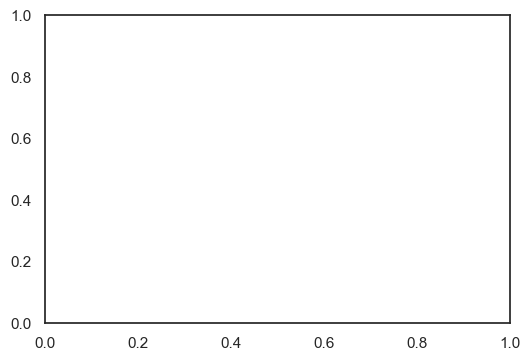

In [184]:
# Make same figure as above but without labels
fig = plt.figure(figsize=(6, 4))  # Adjusted figure size for six sets
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 3)  # Adjusted for six sets
bar_width = 0.6
tick_pos = [i for i in bar_l]

# Stacked bar plot for neurotransmitter types
ax1 = ax.bar(bar_l, variables[0], width=bar_width, color='orange')
ax2 = ax.bar(bar_l, variables[1], bottom=variables[0], width=bar_width, color='#1f77b4')
ax3 = ax.bar(bar_l, variables[2], bottom=variables[0] + variables[1], width=bar_width, color='#67afdb')

# Titles and axis labels
ax.set_ylabel('# Outputs', fontsize=18)
ax.set_title('NT Types for 3N Local Outputs', fontsize=16)

# Adjust x and y ticks
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

# Remove legend
# ax.legend(NTs, frameon=False, loc='upper right')  # Commented out to remove labels

# Show plot
plt.show()


In [185]:
def count_NTs_proj(datasets, categories):
    """
    For each dataset (representing a set of 3N outputs),
    filter to projection outputs (i.e. where location_of_connection is 'outside_SEZ')
    and count the total synapse counts for each NT type (ACH, GABA, GLUT).
    """
    counts_ACH = []
    counts_GABA = []
    counts_GLUT = []
    for dataset in datasets:
        # Filter to projection outputs and NT types
        proj_subset = dataset.query("location_of_connection == 'outside_SEZ' and nt_type in ['ACH', 'GABA', 'GLUT']")
        counts_ACH.append(proj_subset.query("nt_type == 'ACH'")['syn_count'].sum())
        counts_GABA.append(proj_subset.query("nt_type == 'GABA'")['syn_count'].sum())
        counts_GLUT.append(proj_subset.query("nt_type == 'GLUT'")['syn_count'].sum())
    return [np.array(counts_ACH), np.array(counts_GABA), np.array(counts_GLUT)]

def count_neurons_proj(datasets, categories):
    """
    For each dataset, filter to projection outputs (where location_of_connection is 'outside_SEZ')
    and count the number of unique neurons (using 'pre_root_id') for each NT type.
    """
    neurons_ACH = []
    neurons_GABA = []
    neurons_GLUT = []
    for dataset in datasets:
        proj_subset = dataset.query("location_of_connection == 'outside_SEZ' and nt_type in ['ACH', 'GABA', 'GLUT']")
        neurons_ACH.append(proj_subset.query("nt_type == 'ACH'")['pre_root_id'].nunique())
        neurons_GABA.append(proj_subset.query("nt_type == 'GABA'")['pre_root_id'].nunique())
        neurons_GLUT.append(proj_subset.query("nt_type == 'GLUT'")['pre_root_id'].nunique())
    return [np.array(neurons_ACH), np.array(neurons_GABA), np.array(neurons_GLUT)]


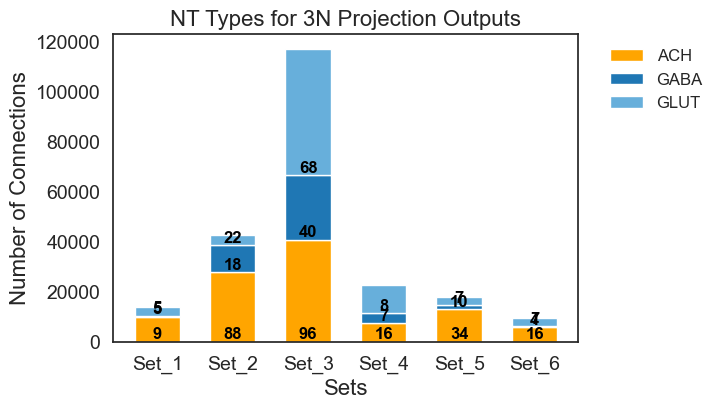

In [186]:
# Now do projection neurons/outputs

NTs = ['ACH', 'GABA', 'GLUT']
categories = ['Set_1', 'Set_2', 'Set_3', 'Set_4', 'Set_5', 'Set_6']

datasets = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs, set_4_3N_outputs, set_5_3N_outputs, set_6_3N_outputs]

# Run the functions defined in the 2N section
variables = count_NTs_proj(datasets, categories)  # Neurotransmitter synapse counts
neurons = count_neurons_proj(datasets, categories)  # Number of neurons per NT type

# Make plot
fig = plt.figure(figsize=(6, 4))  # Adjusted figure size for six sets
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 7)  # Adjusted for six sets
bar_width = 0.6
tick_pos = [i for i in bar_l]

# Stacked bar plot for neurotransmitter types
ax1 = ax.bar(bar_l, variables[0], width=bar_width, color='orange', label=NTs[0])
ax2 = ax.bar(bar_l, variables[1], bottom=variables[0], width=bar_width, color='#1f77b4', label=NTs[1])
ax3 = ax.bar(bar_l, variables[2], bottom=variables[0] + variables[1], width=bar_width, color='#67afdb', label=NTs[2])

# Titles and axis labels
ax.set_ylabel('Number of Connections', fontsize=16)
ax.set_xlabel('Sets', fontsize=16)
ax.set_title('NT Types for 3N Projection Outputs', fontsize=16)

# Adjust x and y ticks
plt.xticks(tick_pos, categories, fontsize=14)
plt.yticks(fontsize=14)

# Add legend
plt.legend(NTs, frameon=False, fontsize=12, bbox_to_anchor=(1.3, 1))

# Add text labels for neuron counts
for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2, n3, ha="center", va="bottom", color="black", fontweight="bold")

# Show plot
plt.show()


In [187]:
# Show numbers of outputs for each NT type
variables

[array([10091, 27835, 40765,  7396, 13079,  5951]),
 array([  400, 10699, 25837,  4133,  1497,   374]),
 array([ 3460,  4007, 50522, 11235,  3380,  3301])]

# Same figure as above but without labels
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.6
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('# Outputs', fontsize=18)
ax.set_title('NT Types for 3N Projection Outputs')
#ax.legend(NTs, frameon=False, loc = 'upper right')
ax.set_ylim([0, 5500])
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

### Quantify ipsilateral vs. contralateral 3N outputs

In [188]:
# Classify ipsi vs contra side for each output using the function defined in the 2N section
set_1_3N_outputs['hemisphere'] = set_1_3N_outputs['neuropil'].apply(bilateral)
set_2_3N_outputs['hemisphere'] = set_2_3N_outputs['neuropil'].apply(bilateral)
set_3_3N_outputs['hemisphere'] = set_3_3N_outputs['neuropil'].apply(bilateral)
set_4_3N_outputs['hemisphere'] = set_4_3N_outputs['neuropil'].apply(bilateral)
set_5_3N_outputs['hemisphere'] = set_5_3N_outputs['neuropil'].apply(bilateral)
set_6_3N_outputs['hemisphere'] = set_6_3N_outputs['neuropil'].apply(bilateral)


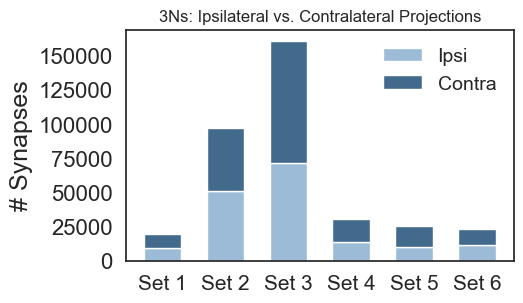

In [189]:
# Plot number of ipsilateral vs. contralateral output synapses for 3Ns
third_order_outputs = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs,
                       set_4_3N_outputs, set_5_3N_outputs, set_6_3N_outputs]

ipsilateral = []
contralateral = []

for entry in third_order_outputs:
    ipsilateral.append(entry.query("hemisphere == 'ipsilateral'")['syn_count'].sum())
    contralateral.append(entry.query("hemisphere == 'contralateral'")['syn_count'].sum())

categories = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
brain_hemisphere = ['Ipsi', 'Contra']

bar_width = 0.6
plt.figure(figsize=(5,3))  # Adjusted for 6 sets
plt.bar(categories, ipsilateral, color = '#9cbbd6', width = bar_width)
plt.bar(categories, contralateral, bottom = ipsilateral, color = '#426a8c', width = bar_width)
ax = plt.gca()
#ax.set_ylim([0, max(ipsilateral) + max(contralateral) * 0.1])  # Adjust y-limit dynamically
plt.title('3Ns: Ipsilateral vs. Contralateral Projections')
plt.ylabel('# Synapses', fontsize=18)
plt.legend(brain_hemisphere, frameon=False, fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=16)
plt.show()


In [190]:
# Show numbers of ipsi vs. contra synapses
print(ipsilateral)
print(contralateral)

[np.int64(9670), np.int64(50831), np.int64(71412), np.int64(13833), np.int64(10360), np.int64(11671)]
[np.int64(9926), np.int64(46061), np.int64(89393), np.int64(16574), np.int64(14849), np.int64(11461)]


### Quantify 3N projections to each brain region
### Start by consolidating bilateral brain regions for second order outputs

In [191]:
# Apply region remapping for all six sets
set_1_3N_outputs['neuropil_remap'] = set_1_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_2_3N_outputs['neuropil_remap'] = set_2_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_3_3N_outputs['neuropil_remap'] = set_3_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_4_3N_outputs['neuropil_remap'] = set_4_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_5_3N_outputs['neuropil_remap'] = set_5_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_6_3N_outputs['neuropil_remap'] = set_6_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))


### Make bar graphs of brain regions with 3N output synapses

In [192]:
# Determine the top 12 non-SEZ brain regions for 3N outputs for each set
set_1_3N_top12 = get_top12_regions(set_1_3N_outputs)
set_2_3N_top12 = get_top12_regions(set_2_3N_outputs)
set_3_3N_top12 = get_top12_regions(set_3_3N_outputs)
set_4_3N_top12 = get_top12_regions(set_4_3N_outputs)
set_5_3N_top12 = get_top12_regions(set_5_3N_outputs)
set_6_3N_top12 = get_top12_regions(set_6_3N_outputs)

# Print results for each set
print("Set 1 Top 12 Regions:", set_1_3N_top12)
print("Set 2 Top 12 Regions:", set_2_3N_top12)
print("Set 3 Top 12 Regions:", set_3_3N_top12)
print("Set 4 Top 12 Regions:", set_4_3N_top12)
print("Set 5 Top 12 Regions:", set_5_3N_top12)
print("Set 6 Top 12 Regions:", set_6_3N_top12)


Set 1 Top 12 Regions: ['AL', 'SCL', 'MB_VL', 'MB_ML', 'SLP', 'LAL', 'LH', 'SIP', 'CRE', 'SMP']
Set 2 Top 12 Regions: ['WED', 'CRE', 'ICL', 'AL', 'SPS', 'IB', 'SIP', 'FB', 'SLP', 'LAL', 'VES', 'SMP']
Set 3 Top 12 Regions: ['AOTU', 'ICL', 'IB', 'IPS', 'SIP', 'AL', 'CRE', 'SLP', 'LH', 'LAL', 'VES', 'SMP']
Set 4 Top 12 Regions: ['GOR', 'IPS', 'CRE', 'LAL', 'AL', 'SIP', 'FB', 'LH', 'SPS', 'SLP', 'VES', 'SMP']
Set 5 Top 12 Regions: ['PLP', 'GOR', 'IPS', 'ICL', 'AVLP', 'SLP', 'WED', 'SMP', 'IB', 'AL', 'SPS', 'VES']
Set 6 Top 12 Regions: ['FB', 'VES', 'LAL', 'AL', 'MB_ML', 'SIP', 'CRE', 'SLP', 'SMP']


In [193]:
# Create a combined list of top 12 regions appearing in any set
all_regions_3Ns = list(
    set(set_1_3N_top12) |
    set(set_2_3N_top12) |
    set(set_3_3N_top12) |
    set(set_4_3N_top12) |
    set(set_5_3N_top12) |
    set(set_6_3N_top12)
)

# Print the list of unique regions across all sets
print("All Unique Top 12 Brain Regions Across Sets:", all_regions_3Ns)


All Unique Top 12 Brain Regions Across Sets: ['MB_VL', 'SPS', 'LAL', 'ICL', 'IB', 'SIP', 'SCL', 'SMP', 'PLP', 'WED', 'SLP', 'VES', 'AOTU', 'CRE', 'AVLP', 'MB_ML', 'FB', 'IPS', 'AL', 'LH', 'GOR']


In [194]:
# Define the custom order of brain regions from the unique top 12 regions
categories = ['SMP', 'SIP', 'SPS', 'SCL', 'SLP', 'PLP', 'EPA', 'AVLP', 'AOTU',
              'ICL', 'LAL', 'WED', 'VES', 'LH', 'AL', 'IB', 'CRE', 'FB',
              'MB_ML', 'MB_VL', 'IPS']  # Ordered based on your unique set

# Define neurotransmitter types (NTs)
NTs = ['ACH', 'GABA', 'GLUT', 'DA', 'SER']

# Print to verify
print("Custom Brain Region Order:", categories)
print("Defined Neurotransmitters:", NTs)


Custom Brain Region Order: ['SMP', 'SIP', 'SPS', 'SCL', 'SLP', 'PLP', 'EPA', 'AVLP', 'AOTU', 'ICL', 'LAL', 'WED', 'VES', 'LH', 'AL', 'IB', 'CRE', 'FB', 'MB_ML', 'MB_VL', 'IPS']
Defined Neurotransmitters: ['ACH', 'GABA', 'GLUT', 'DA', 'SER']


In [195]:
def count_NTs_brainregions(datasets, categories):
    ach = np.zeros(len(categories), dtype=int)
    gaba = np.zeros(len(categories), dtype=int)
    glut = np.zeros(len(categories), dtype=int)

    for i, cat in enumerate(categories):
        df = datasets[i]  # datasets should be aligned with categories
        if not df.empty:
            # Use the correct column name 'nt_type'
            ach[i] = (df['nt_type'] == 'ACH').sum()
            gaba[i] = (df['nt_type'] == 'GABA').sum()
            glut[i] = (df['nt_type'] == 'GLUT').sum()

    return ach, gaba, glut


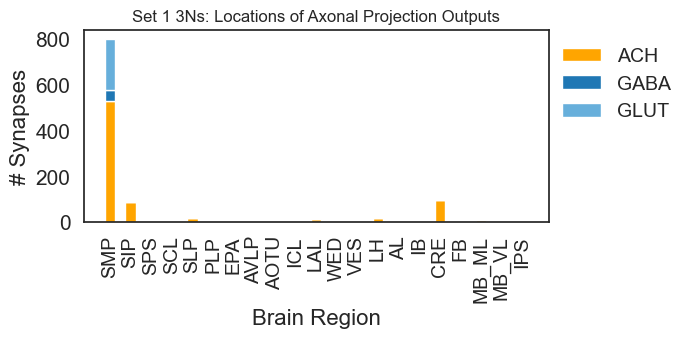

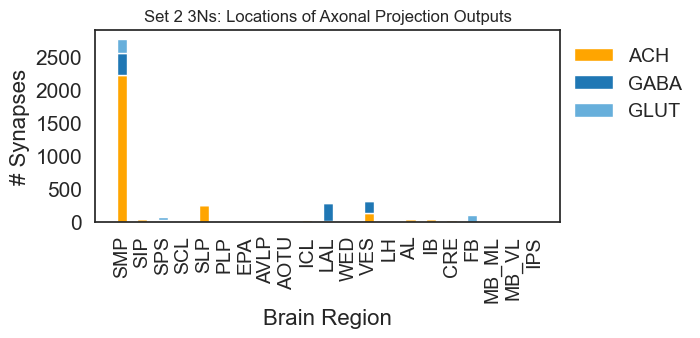

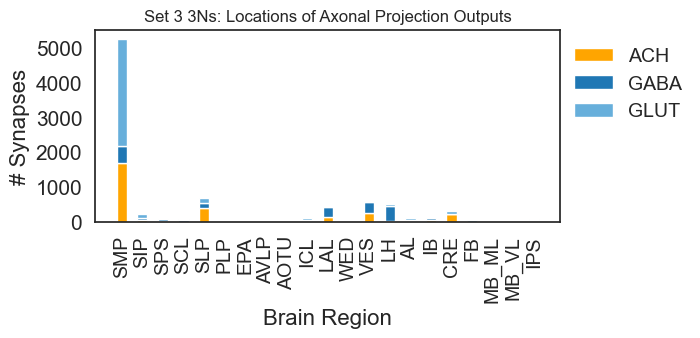

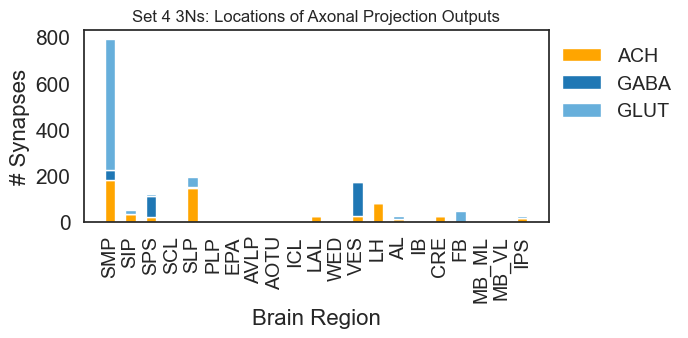

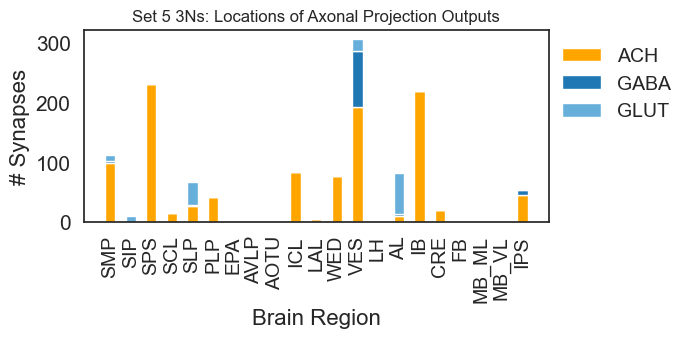

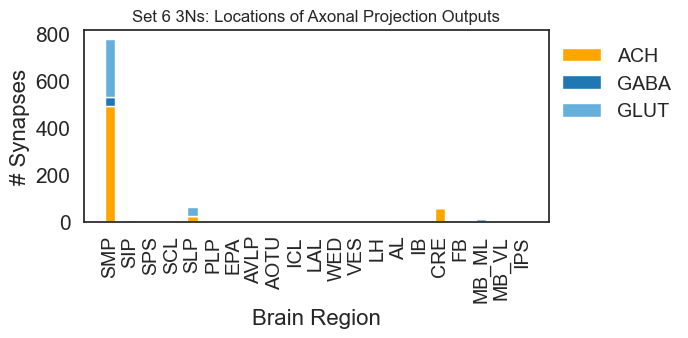

In [196]:
# Create bar graphs for each set's 3N outputs, colored by NT type

# List of datasets for each set
sets_3N_outputs = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs,
                   set_4_3N_outputs, set_5_3N_outputs, set_6_3N_outputs]

set_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']

# Define neurotransmitter colors
NT_colors = ['orange', '#1f77b4', '#67afdb']  # ACH, GABA, GLUT

# Loop through each set and generate a bar plot
for set_idx, (set_3N_outputs, label) in enumerate(zip(sets_3N_outputs, set_labels)):

    # Create datasets by filtering for brain regions in 'categories'
    datasets = []
    for category in categories:
        counts = pd.DataFrame(set_3N_outputs[set_3N_outputs['neuropil_remap'] == category])
        datasets.append(counts)

    # Count NT distribution per brain region
    variables = count_NTs_brainregions(datasets, categories)

    # Plot results
    plt.figure(figsize=(6, 2.5))
    plt.bar(categories, variables[0], color=NT_colors[0], width=0.5, label='ACH')  # Acetylcholine
    plt.bar(categories, variables[1], bottom=variables[0], color=NT_colors[1], width=0.5, label='GABA')  # GABA
    plt.bar(categories, variables[2], bottom=variables[0]+variables[1], color=NT_colors[2], width=0.5, label='GLUT')  # Glutamate

    plt.xlabel('Brain Region', fontsize=16)
    plt.ylabel('# Synapses', fontsize=16)
    plt.title(f'{label} 3Ns: Locations of Axonal Projection Outputs')
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=15)
    plt.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.3, 1))
    plt.show()


In [197]:
# List of datasets for each set
sets_3N_outputs = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs,
                   set_4_3N_outputs, set_5_3N_outputs, set_6_3N_outputs]

set_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']

# Initialize dictionary to store results
projection_synapse_capture = {}

# Loop through each set to calculate captured projection synapses
for set_idx, (set_3N_outputs, label) in enumerate(zip(sets_3N_outputs, set_labels)):

    # Create datasets by filtering for brain regions in 'categories'
    datasets = []
    for category in categories:
        counts = pd.DataFrame(set_3N_outputs[set_3N_outputs['neuropil_remap'] == category])
        datasets.append(counts)

    # Count NT distribution per brain region
    variables = count_NTs_brainregions(datasets, categories)

    # Compute captured projection synapses
    captured_projection_synapses = sum(sum(variables)) / set_3N_outputs[
        set_3N_outputs['location_of_connection'] == 'outside_SEZ'
        ]['syn_count'].sum()

    # Store in dictionary
    projection_synapse_capture[label] = captured_projection_synapses

# Display results
for label, capture_rate in projection_synapse_capture.items():
    print(f"{label}: {capture_rate:.2%} of projection synapses captured")


Set 1: 7.56% of projection synapses captured
Set 2: 9.23% of projection synapses captured
Set 3: 7.41% of projection synapses captured
Set 4: 7.02% of projection synapses captured
Set 5: 6.95% of projection synapses captured
Set 6: 7.76% of projection synapses captured


## 3g. Plotting net excitation onto each 3N

### We are quantifying net excitation onto each 3N from an individual modality
- Net excitation was already calculated above as the difference in the # of excitatory vs. inhibitory input synapses.
- In the plots, we are only including 3Ns that receive input from multiple 2Ns.

In [ ]:
# Define number of bins and bin edges
num_bins = 40
bins = np.linspace(-300, 301, num_bins + 1)

# Dictionary mapping set labels to their 3N DataFrames
sets_3Ns = {
    'Set 1': set_1_3Ns,
    'Set 2': set_2_3Ns,
    'Set 3': set_3_3Ns,
    'Set 4': set_4_3Ns,
    'Set 5': set_5_3Ns,
    'Set 6': set_6_3Ns
}

# Define colors for each set
colors = ['red', 'orange', '#3489eb', 'purple', 'green', 'gray']

# Create subplots (2 rows x 3 columns) for the six sets
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Loop over each set and plot the histogram of net excitation
for idx, (set_label, df) in enumerate(sets_3Ns.items()):
    # Construct the column name for upstream 2Ns for this set, assuming column naming convention:
    # "upstream_set_1_2Ns", "upstream_set_2_2Ns", etc.
    upstream_col = 'upstream_' + set_label.lower().replace(' ', '_') + '_2Ns'

    # Exclude neurons receiving only one 2N input
    neurons_to_analyze = df[df[upstream_col] != 1]

    # Get net excitation values (assumed column name same across sets)
    net_excitation = neurons_to_analyze['excitatory - inhibitory_number_input_synapse']

    # Clip the data to the defined bin range
    data = np.clip(net_excitation, bins[0], bins[-1])

    # Compute histogram
    frequencies, _ = np.histogram(data, bins)
    # Compute bin centers for plotting
    bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

    # Plot histogram as a bar chart using the corresponding color
    axs[idx].bar(bin_centers, frequencies, width=15, align='center', color=colors[idx])
    axs[idx].axvline(0, color='black', linestyle='--')
    axs[idx].set_title(f'Net Excitation onto {set_label} 3Ns', fontsize=14)
    axs[idx].set_xlabel('Net Excitatory Synapses', fontsize=12)
    axs[idx].set_ylabel('# Cells', fontsize=12)
    axs[idx].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()


### Now plot net excitation onto excitatory vs. inhibitory 3Ns separately

### For these analyses, we are including all 3Ns, not just the ones receiving input from multiple 2Ns.

The goal is to compare the distribution of the sign of input onto 3Ns that are excitatory or inhibitory. E.g. do inhibitory 3Ns tend to receive net inhibition, suggesting that their function is actually to disinhibit downstream circuits.

In [ ]:
# Define a helper function to plot net excitation histogram
def plot_net_excitation_histogram(df, set_label, nt_condition, title,
                                  bin_range=(-300, 300), num_bins=40,
                                  bar_color='red', bar_width=10, figsize=(4,3)):
    """
    Plot a histogram of net excitation onto 3Ns filtered by nt_condition.
    """
    # Filter the data according to the neurotransmitter condition
    neurons_to_analyze = df.query(nt_condition)
    net_excitation = neurons_to_analyze['excitatory - inhibitory_number_input_synapse']

    # Define bins and clip data
    bins = np.linspace(bin_range[0], bin_range[1], num_bins + 1)
    data = np.clip(net_excitation, bins[0], bins[-1])

    # Compute histogram
    frequencies, _ = np.histogram(data, bins)
    bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

    # Plot histogram
    plt.figure(figsize=figsize)
    plt.bar(bin_centers, frequencies, width=bar_width, align='center', color=bar_color)
    plt.axvline(0, color='black', linestyle='--')

    # Setup x-ticks using a fixed interval
    tick_interval = 100
    xticks = np.arange(bin_range[0], bin_range[1] + tick_interval, tick_interval)
    xlabels = [f"{x}" for x in xticks]
    if xticks[0] == bin_range[0]:
        xlabels[0] = f"<{bin_range[0]}"
    if xticks[-1] == bin_range[1]:
        xlabels[-1] = f">{bin_range[1]}"

    plt.xticks(ticks=xticks, labels=xlabels, fontsize=13)
    plt.yticks(fontsize=16)
    plt.xlabel('Net Excitatory Synapses', fontsize=18)
    plt.ylabel('# Cells', fontsize=18)
    plt.title(title, fontsize=16)
    plt.show()

# Define dictionary mapping set labels to their 3N DataFrames
sets_3Ns = {
    'Set 1': set_1_3Ns,
    'Set 2': set_2_3Ns,
    'Set 3': set_3_3Ns,
    'Set 4': set_4_3Ns,
    'Set 5': set_5_3Ns,
    'Set 6': set_6_3Ns
}

# Define color mappings (the same mapping is used for excitatory and inhibitory; adjust if needed)
color_mapping = {
    'Set 1': '#cf4848',   # red
    'Set 2': 'orange',
    'Set 3': '#3489eb',
    'Set 4': 'purple',
    'Set 5': 'green',
    'Set 6': 'gray'
}

# Plot histograms for excitatory 3Ns (nt_type == 'ACH')
for set_label, df in sets_3Ns.items():
    plot_net_excitation_histogram(
        df, set_label,
        "nt_type == 'ACH'",
        f'Net Excitation onto Excitatory {set_label} 3Ns',
        bin_range=(-300, 300),
        bar_color=color_mapping[set_label]
    )

# Plot histograms for inhibitory 3Ns (nt_type in ['GLUT', 'GABA'])
# Here, we use a slightly narrower bin range as in your original scripts
for set_label, df in sets_3Ns.items():
    plot_net_excitation_histogram(
        df, set_label,
        "nt_type in ['GLUT', 'GABA']",
        f'Net Excitation onto Inhibitory {set_label} 3Ns',
        bin_range=(-200, 200),
        bar_color=color_mapping[set_label]
    )


## 3h. Proportion of excitatory vs. inhibitory 2N inputs onto excitatory vs. inhibitory 3Ns

Similar to the analyses above, this gives us an idea of whether PhN-SA-2N-3N circuits promote excitation or inhibition of downstream pathways (e.g. 2N inhibition onto inhibitory 3Ns should disinhibit downstream circuits, corresponding to excitation)

In [ ]:
# Define the six sets
categories = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
datasets = [set_1_3Ns, set_2_3Ns, set_3_3Ns, set_4_3Ns, set_5_3Ns, set_6_3Ns]

# Function to count excitatory and inhibitory input synapses to excitatory 3Ns
def count_NTs_excitatory(datasets_array):
    NTs = ['ACH', 'GABA', 'GLUT']
    excitatory_synapses = []
    inhibitory_synapses = []

    for dataset in datasets_array:
        # Find excitatory 3Ns and sum up their inhibitory 2N inputs
        inhibitory_synapses.append(dataset.query("nt_type == @NTs[0]")['inhibitory_number_input_synapse'].sum())

        # Find excitatory 3Ns and sum up their excitatory 2N inputs
        excitatory_synapses.append(dataset.query("nt_type == @NTs[0]")['excitatory_number_input_synapse'].sum())

    return np.array(excitatory_synapses), np.array(inhibitory_synapses)

# Run function to get excitatory and inhibitory synapse counts
E_connections, I_connections = count_NTs_excitatory(datasets)

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_l = np.arange(len(categories))
bar_width = 0.8
tick_pos = [i for i in bar_l]

# Bar plots for excitatory and inhibitory synapse inputs
ax1 = ax.bar(bar_l, E_connections, width=bar_width, color='orange', label="Excitatory synapses")
ax2 = ax.bar(bar_l, I_connections, bottom=E_connections, width=bar_width, color='#1f77b4', label="Inhibitory synapses")

# Labels and Formatting
ax.set_ylabel('Number of Input Synapses', fontsize=14)
ax.set_xlabel('Set', fontsize=14)
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.5, 1))
ax.set_title('Number of Synapses onto Excitatory 3Ns', fontsize=16)
plt.xticks(tick_pos, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add count labels to the bars
for r1, r2, n1, n2 in zip(ax1, ax2, E_connections, I_connections):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, int(n1), ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, int(n2), ha="center", va="bottom", color="black", fontweight="bold")

plt.show()


In [ ]:
# Define categories (sets)
categories = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
datasets = [set_1_3Ns, set_2_3Ns, set_3_3Ns, set_4_3Ns, set_5_3Ns, set_6_3Ns]

# Function to count excitatory and inhibitory input synapses to excitatory 3Ns
def count_NTs_excitatory(datasets_array):
    NTs = ['ACH', 'GABA', 'GLUT']
    excitatory_synapses = []
    inhibitory_synapses = []

    for dataset in datasets_array:
        # Find excitatory 3Ns and sum up their inhibitory 2N inputs
        inhibitory_synapses.append(dataset.query("nt_type == @NTs[0]")['inhibitory_number_input_synapse'].sum())

        # Find excitatory 3Ns and sum up their excitatory 2N inputs
        excitatory_synapses.append(dataset.query("nt_type == @NTs[0]")['excitatory_number_input_synapse'].sum())

    return np.array(excitatory_synapses), np.array(inhibitory_synapses)

# Run function to get excitatory and inhibitory synapse counts
E_connections, I_connections = count_NTs_excitatory(datasets)

# Plot without labels inside the bars
fig, ax = plt.subplots(figsize=(4, 3))
bar_l = np.arange(len(categories))
bar_width = 0.6
tick_pos = [i for i in bar_l]

# Stacked Bar Chart
ax1 = ax.bar(bar_l, E_connections, width=bar_width, color='orange', label="Excitatory inputs")
ax2 = ax.bar(bar_l, I_connections, bottom=E_connections, width=bar_width, color='#1f77b4', label="Inhibitory inputs")

# Formatting
ax.set_ylabel('# 2N Inputs', fontsize=18)
ax.legend(frameon=False, fontsize=13, bbox_to_anchor=(1.7, 1))
ax.set_title('2N Input Types onto Excitatory 3Ns', fontsize=14)
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

plt.show()


In [ ]:
# Define categories (sets)
categories = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
datasets = [set_1_3Ns, set_2_3Ns, set_3_3Ns, set_4_3Ns, set_5_3Ns, set_6_3Ns]

# Function to count excitatory and inhibitory 2N inputs onto inhibitory 3Ns
def count_NTs_inhibitory(datasets_array):
    excitatory_synapses = []
    inhibitory_synapses = []

    for dataset in datasets_array:
        # Find all inhibitory 3Ns (GABA or GLUT) and sum up their inhibitory 2N inputs
        inhibitory_synapses.append(
            dataset.query("nt_type == 'GABA' or nt_type == 'GLUT'")['inhibitory_number_input_synapse'].sum()
        )

        # Find all inhibitory 3Ns (GABA or GLUT) and sum up their excitatory 2N inputs
        excitatory_synapses.append(
            dataset.query("nt_type == 'GABA' or nt_type == 'GLUT'")['excitatory_number_input_synapse'].sum()
        )

    return np.array(excitatory_synapses), np.array(inhibitory_synapses)

# Run function to get excitatory and inhibitory synapse counts
E_connections, I_connections = count_NTs_inhibitory(datasets)

# Plot
fig, ax = plt.subplots(figsize=(4, 3))
bar_l = np.arange(len(categories))
bar_width = 0.6
tick_pos = [i for i in bar_l]

# Stacked Bar Chart
ax1 = ax.bar(bar_l, E_connections, width=bar_width, color='orange', label="Excitatory inputs")
ax2 = ax.bar(bar_l, I_connections, bottom=E_connections, width=bar_width, color='#1f77b4', label="Inhibitory inputs")

# Formatting
ax.set_ylabel('# 2N Inputs', fontsize=18)
ax.legend(frameon=False, fontsize=13, bbox_to_anchor=(1.7, 1))
ax.set_title('2N Input Types onto Inhibitory 3Ns', fontsize=14)
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

plt.show()


In [ ]:
# Make the same figure but without labels
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(len(categories))  # Adjusting based on the length of categories
bar_width = 0.6
tick_pos = [i for i in bar_l]

# Create stacked bars
ax1 = ax.bar(bar_l, E_connections, width=bar_width, color='orange')
ax2 = ax.bar(bar_l, I_connections, bottom=E_connections, width=bar_width, color='#1f77b4')

# Remove all labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.legend([],[], frameon=False)  # Hide legend

plt.show()


## 3i. Net excitation onto 3Ns from 2Ns of different modalities

### For 3Ns receiving input from 2Ns of different modalities, analyze whether the sign of that input is correlated.

We will do this by making a scatter plot plotting net excitation from each modality and determining if there is a significant correlation.

Note that 2Ns that receive input from multiple modalities will be counted as 3N inputs for both modalities, so any positive correlations in net excitation from different modalities may partially reflect 2Ns belonging to multiple modalities, as well as correlated inputs from different 2Ns.

In [ ]:
#### 'Taste' variable names should be PhN-SA set names
def net_excitation_scatter_3Ns(taste_3Ns_1, taste_3Ns_2, taste_names, color, title):
    # Use the exact column name as it appears in your DataFrame.
    # (If your column name is different, please adjust the string below accordingly.)
    col_name = 'excitatory - inhibitory_number_input_synapse'

    # Get the common set of 3Ns (by their 'root_id') present in both DataFrames.
    common_neurons = set(taste_3Ns_1['root_id']).intersection(set(taste_3Ns_2['root_id']))

    # Extract net excitation values for these common neurons from both DataFrames.
    net_exc_taste1 = taste_3Ns_1[taste_3Ns_1['root_id'].isin(common_neurons)][['root_id', col_name]]
    net_exc_taste2 = taste_3Ns_2[taste_3Ns_2['root_id'].isin(common_neurons)][['root_id', col_name]]

    # Ensure that the ordering of neurons matches across the two DataFrames.
    net_exc_taste1_ordered = net_exc_taste1.set_index('root_id').reindex(net_exc_taste2['root_id']).reset_index()
    if not np.array_equal(net_exc_taste1_ordered['root_id'].values, net_exc_taste2['root_id'].values):
        print('ERROR: Reordering failed!')

    # Define x and y data based on the common neurons.
    x = net_exc_taste1_ordered[col_name].values
    y = net_exc_taste2[col_name].values

    # Filter out NaN or infinite values.
    valid_idx = ~np.isnan(x) & ~np.isnan(y) & np.isfinite(x) & np.isfinite(y)
    x = x[valid_idx]
    y = y[valid_idx]

    # Define a simple linear model for curve fitting.
    def objective(x, a, b):
        return a * x + b

    if len(x) > 1 and len(y) > 1:
        popt, _ = curve_fit(objective, x, y)
        a, b = popt
    else:
        a, b = np.nan, np.nan

    # Create scatter plot.
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(x, y, c=color, alpha=0.3)

    # Plot the fitted line if the fit was successful.
    if not np.isnan(a):
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = objective(x_line, a, b)
        ax.plot(x_line, y_line, '--', color='black')

    # Label the axes and set title.
    ax.set_xlabel('Net excitation from ' + taste_names[0], fontsize=15)
    # Special handling for 'lowsalt'
    y_label = taste_names[1] if taste_names[1] != 'lowsalt' else 'IR94e'
    ax.set_ylabel('Net excitation from ' + y_label, fontsize=15)
    ax.set_title(title, fontsize=15)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # Print fitted equation and median values.
    print(f'Equation: y = {a:.5f} * x + {b:.5f}')
    print(f'Median net excitation from {taste_names[0]}: {np.median(x):.2f}')
    print(f'Median net excitation from {taste_names[1]}: {np.median(y):.2f}')

    # Perform OLS regression to obtain p-values and summary statistics.
    # Using sm.add_constant to add an intercept.
    df_ols = net_exc_taste2.copy()
    df_ols = sm.add_constant(df_ols[[col_name]])
    model = sm.OLS(x, df_ols).fit()
    print('p value: ', model.pvalues[1])
    print(model.summary())


In [ ]:
import itertools

In [ ]:


# List of 3N DataFrames for all six sets and their labels.
sets = [set_1_3Ns, set_2_3Ns, set_3_3Ns, set_4_3Ns, set_5_3Ns, set_6_3Ns]
labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']

# Define a list of colors to use for plotting (this list will be cycled through if needed).
plot_colors = ['#fe420f', '#a9561e', '#7172db', '#bada55', '#123456', '#abcdef']

# Loop over all unique pair combinations of the six sets (15 pairs)
for (i, j) in itertools.combinations(range(len(sets)), 2):
    # Select the two datasets and corresponding labels
    df1 = sets[i]
    df2 = sets[j]
    pair_labels = [labels[i].lower(), labels[j].lower()]  # use lower case if desired for the function
    title = f'{labels[i]} - {labels[j]} convergence'

    # Choose a color from the list (cycle if more than available colors)
    color = plot_colors[(i*len(sets) + j) % len(plot_colors)]

    # Call the net_excitation_scatter_3Ns function for this pair
    net_excitation_scatter_3Ns(df1, df2, pair_labels, color, title)


In [ ]:
net_excitation_scatter_3Ns(set_1_3Ns, set_2_3Ns, ['Set 1', 'Set 2'], '#fe420f', 'Set 1 - Set 2 Convergence')


In [ ]:
net_excitation_scatter_3Ns(set_1_3Ns, set_3_3Ns, ['Set 1', 'Set 3'], '#a9561e', 'Set 1 - Set 3 Convergence')


In [ ]:
net_excitation_scatter_3Ns(set_1_3Ns, set_4_3Ns, ['Set 1', 'Set 4'], '#a9561e', 'Set 1 - Set 4 Convergence')


In [ ]:
net_excitation_scatter_3Ns(set_2_3Ns, set_3_3Ns, ['Set 2', 'Set 3'], '#a9561e', 'Set 2 - Set 3 Convergence')


In [ ]:
net_excitation_scatter_3Ns(set_2_3Ns, set_4_3Ns, ['Set 2', 'Set 4'], '#a9561e', 'Set 2 - Set 4 Convergence')


In [ ]:
net_excitation_scatter_3Ns(set_3_3Ns, set_4_3Ns, ['Set 3', 'Set 4'], '#7172db', 'Set 3 - Set 4 Convergence')


In [ ]:
net_excitation_scatter_3Ns(set_5_3Ns, set_6_3Ns, ['Set 5', 'Set 6'], '#7172db', 'Set 5 - Set 6 Convergence')


## 3j. Analyze recurrent connections from 3Ns to 2Ns or GRNs

### Make heatmaps for 3N-2N synapses

Will make 3 plots corresponding to all connections, excitatory connections, and inhibitory connections

In [ ]:
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns, set_4_2Ns, set_5_2Ns, set_6_2Ns]  # List of 2N dataframes

heatmap_3Ns_all_2N = [_2N_heatmap(set_1_3N_outputs, df), _2N_heatmap(set_2_3N_outputs, df),
                      _2N_heatmap(set_3_3N_outputs, df), _2N_heatmap(set_4_3N_outputs, df),
                      _2N_heatmap(set_5_3N_outputs, df), _2N_heatmap(set_6_3N_outputs, df)]

row_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
col_labels = row_labels

sns.heatmap(heatmap_3Ns_all_2N, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("3N to 2N Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


In [ ]:
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns, set_4_2Ns, set_5_2Ns, set_6_2Ns]

heatmap_3Ns_exc_2N = [_2N_heatmap(set_1_3N_outputs.query("nt_type == 'ACH'"), df),
                      _2N_heatmap(set_2_3N_outputs.query("nt_type == 'ACH'"), df),
                      _2N_heatmap(set_3_3N_outputs.query("nt_type == 'ACH'"), df),
                      _2N_heatmap(set_4_3N_outputs.query("nt_type == 'ACH'"), df),
                      _2N_heatmap(set_5_3N_outputs.query("nt_type == 'ACH'"), df),
                      _2N_heatmap(set_6_3N_outputs.query("nt_type == 'ACH'"), df)]

sns.heatmap(heatmap_3Ns_exc_2N, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Excitatory 3N to 2N Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


In [ ]:
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns, set_4_2Ns, set_5_2Ns, set_6_2Ns]

heatmap_3Ns_inh_2N = [_2N_heatmap(set_1_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
                      _2N_heatmap(set_2_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
                      _2N_heatmap(set_3_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
                      _2N_heatmap(set_4_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
                      _2N_heatmap(set_5_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
                      _2N_heatmap(set_6_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df)]

sns.heatmap(heatmap_3Ns_inh_2N, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Inhibitory 3N to 2N Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


### Make heatmaps for 3N-PhN-SAs synapses

Will make 3 plots corresponding to all connections, excitatory connections, and inhibitory connections

In [ ]:
print(globals().keys())  # This will print all defined variable names


In [ ]:
df = [set_1, set_2, set_3, set_4, set_5, set_6]

heatmap_3Ns_exc_PhN_SA = [_2N_heatmap(set_1_3N_outputs.query("nt_type == 'ACH'"), df),
                          _2N_heatmap(set_2_3N_outputs.query("nt_type == 'ACH'"), df),
                          _2N_heatmap(set_3_3N_outputs.query("nt_type == 'ACH'"), df),
                          _2N_heatmap(set_4_3N_outputs.query("nt_type == 'ACH'"), df),
                          _2N_heatmap(set_5_3N_outputs.query("nt_type == 'ACH'"), df),
                          _2N_heatmap(set_6_3N_outputs.query("nt_type == 'ACH'"), df)]

sns.heatmap(heatmap_3Ns_exc_PhN_SA, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Excitatory 3N to PhN-SA Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream PhN-SAs")
plt.show()


In [ ]:
# Prepare the data frames you want to use in the heatmap
df = [set_1, set_2, set_3, set_4, set_5, set_6]

# Generate a list (heatmap) of excitatory synapses for each upstream 3N set
heatmap_3Ns_exc_PhN_SA = [
    _2N_heatmap(set_1_3N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_2_3N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_3_3N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_4_3N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_5_3N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_6_3N_outputs.query("nt_type == 'ACH'"), df)
]

# Define the labels for your heatmap axes (one for rows, one for columns)
row_labels = ["Set 1", "Set 2", "Set 3", "Set 4", "Set 5", "Set 6"]
col_labels = ["Set 1", "Set 2", "Set 3", "Set 4", "Set 5", "Set 6"]

# Create the heatmap
sns.heatmap(
    heatmap_3Ns_exc_PhN_SA,
    cmap="viridis",
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("Excitatory 3N to Set Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream PhN-SAs")
plt.show()


In [ ]:
# Prepare the six sets
df = [set_1, set_2, set_3, set_4, set_5, set_6]

# Compute the heatmap data for each upstream 3N set (inhibitory synapses)
heatmap_3Ns_inh_PhN_SA = [
    _2N_heatmap(set_1_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_2_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_3_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_4_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_5_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_6_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df)
]

# Define row and column labels for your heatmap
row_labels = ["Set 1", "Set 2", "Set 3", "Set 4", "Set 5", "Set 6"]
col_labels = ["Set 1", "Set 2", "Set 3", "Set 4", "Set 5", "Set 6"]

# Plot the heatmap
sns.heatmap(
    heatmap_3Ns_inh_PhN_SA,
    cmap="viridis",
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("Inhibitory 3N to Set Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream PhN-SAs")
plt.show()


## 4. ANALYZING TASTE VS. NON-TASTE INPUTS TO 2Ns AND 3Ns

The goal of these analyses is to determine how much of the input onto 2Ns and 3Ns are PhN-SAs inputs versus other types of input, and what those other inputs are.

We will quantify the % of total synaptic input to 2Ns and 3Ns that are PhN-SAs inputs, 2N inputs, or any taste inputs (PhN-SA, 2N, 3N) considering PhN-SAs of any set.

## 4a. 2Ns: Percent input from GRNs

Quantify the % of total synaptic input to 2Ns and 3Ns that are PhN-SAs inputs, defined as PhN-SAs, 2Ns, or 3Ns of any set.

In [ ]:
def neuronal_inputs(neurons_of_interest, connections_df, min_syn=5):
    """
    Returns rows from `connections_df` where the postsynaptic neuron is in `neurons_of_interest`
    and the number of synapses is at least `min_syn`.

    Parameters:
    -----------
    neurons_of_interest : pandas.DataFrame
        A DataFrame containing a column 'root_id' that identifies the neurons of interest.
    connections_df : pandas.DataFrame
        A DataFrame with columns ['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type'].
    min_syn : int, optional
        Minimum synapse count required to be included in the output. Default is 5.

    Returns:
    --------
    connectivity : pandas.DataFrame
        A DataFrame containing all connections that meet the minimum synapse threshold.
    """
    # Merge on 'root_id' of the postsynaptic neuron
    connectivity = pd.merge(
        neurons_of_interest[['root_id']],
        connections_df[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id',
        right_on='post_root_id',
        how='inner'
    ).query("syn_count >= @min_syn")

    # Remove the redundant 'root_id' column from neurons_of_interest
    connectivity.drop(columns='root_id', inplace=True)

    return connectivity


In [ ]:
# Get inputs for 2Ns of each set
set_1_2Ns_inputs = neuronal_inputs(set_1_2Ns, connections)
set_2_2Ns_inputs = neuronal_inputs(set_2_2Ns, connections)
set_3_2Ns_inputs = neuronal_inputs(set_3_2Ns, connections)
set_4_2Ns_inputs = neuronal_inputs(set_4_2Ns, connections)
set_5_2Ns_inputs = neuronal_inputs(set_5_2Ns, connections)
set_6_2Ns_inputs = neuronal_inputs(set_6_2Ns, connections)


In [ ]:
# Function to calculate the % of inputs coming from any set
def set_input_perc(_2Ns_inputs, _2Ns, input_sets):

    """
    Calculates the percentage of synaptic inputs to each 2N that come from neurons in `input_sets`.

    Parameters:
    -----------
    _2Ns_inputs : pandas.DataFrame
        DataFrame of input synapses for the 2Ns (output from `neuronal_inputs`).
    _2Ns : pandas.DataFrame
        DataFrame containing 2N neurons, must have a 'root_id' column.
    input_sets : list of pandas.DataFrames
        List of DataFrames, each containing a column 'root_id' representing neurons of interest.

    Returns:
    --------
    list
        A list containing the percentage of input from the specified `input_sets` for each 2N.
    """

    # Combine all input sets into a single DataFrame
    all_inputs = pd.concat(input_sets)

    _2Ns_input_perc = []  # Store percent input from input sets

    for i in _2Ns.root_id.values:  # Loop through all 2Ns

        # Get all inputs to each 2N
        df = _2Ns_inputs[_2Ns_inputs['post_root_id'] == i]

        # Get inputs from specified sets
        connectivity_set_2N_i = pd.merge(
            all_inputs[['root_id']],
            df[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
            left_on='root_id',
            right_on='pre_root_id',
            how='inner'
        ).query("syn_count >= 5")

        # Calculate % of inputs from the specified sets
        if np.sum(df['syn_count'].values) > 0:
            perc = np.sum(connectivity_set_2N_i['syn_count'].values) / np.sum(df['syn_count'].values)
        else:
            perc = 0  # Avoid division by zero

        _2Ns_input_perc.append(perc)

    return _2Ns_input_perc


In [ ]:
# Quantify % input from any set for each type of 2Ns
set_1_2Ns_input_perc = set_input_perc(set_1_2Ns_inputs, set_1_2Ns, [set_1, set_2, set_3, set_4, set_5, set_6])
set_2_2Ns_input_perc = set_input_perc(set_2_2Ns_inputs, set_2_2Ns, [set_1, set_2, set_3, set_4, set_5, set_6])
set_3_2Ns_input_perc = set_input_perc(set_3_2Ns_inputs, set_3_2Ns, [set_1, set_2, set_3, set_4, set_5, set_6])
set_4_2Ns_input_perc = set_input_perc(set_4_2Ns_inputs, set_4_2Ns, [set_1, set_2, set_3, set_4, set_5, set_6])
set_5_2Ns_input_perc = set_input_perc(set_5_2Ns_inputs, set_5_2Ns, [set_1, set_2, set_3, set_4, set_5, set_6])
set_6_2Ns_input_perc = set_input_perc(set_6_2Ns_inputs, set_6_2Ns, [set_1, set_2, set_3, set_4, set_5, set_6])


In [ ]:
# Define function to get the distribution of % input from a given set
bins = np.linspace(0, 1, 15)

def input_distrib(input_perc):
    frequencies, bin_edges = np.histogram(input_perc, bins)
    bin_labels = bins[1:]
    df = pd.DataFrame({'labels': bin_labels, 'frequencies': frequencies})
    return df

# Calculate distribution for each set
set_1_2N_input_distrib = input_distrib(set_1_2Ns_input_perc)
set_2_2N_input_distrib = input_distrib(set_2_2Ns_input_perc)
set_3_2N_input_distrib = input_distrib(set_3_2Ns_input_perc)
set_4_2N_input_distrib = input_distrib(set_4_2Ns_input_perc)
set_5_2N_input_distrib = input_distrib(set_5_2Ns_input_perc)
set_6_2N_input_distrib = input_distrib(set_6_2Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_2N_input_distrib, set_2_2N_input_distrib, set_3_2N_input_distrib,
              set_4_2N_input_distrib, set_5_2N_input_distrib, set_6_2N_input_distrib]

labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']
plt.xticks(xticks, xlabels, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Fraction of Input from Other Sets', fontsize=14)
plt.ylabel('Number of 2Ns', fontsize=14)
plt.title('Distribution of % Input to 2Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Get median values for each set
print('Set 1: ', np.median(set_1_2Ns_input_perc))
print('Set 2: ', np.median(set_2_2Ns_input_perc))
print('Set 3: ', np.median(set_3_2Ns_input_perc))
print('Set 4: ', np.median(set_4_2Ns_input_perc))
print('Set 5: ', np.median(set_5_2Ns_input_perc))
print('Set 6: ', np.median(set_6_2Ns_input_perc))


## 4b. 2Ns: Percent input from any taste neurons

Quantify the % of total synaptic input to 2Ns that are taste inputs, defined as PhN-SAs, 2Ns, or 3Ns of any sets.

In [ ]:
def set_input_percentage(set_inputs, target_set):
    """
    Calculates the percentage of synaptic inputs to each neuron in `target_set` that come from neurons in any of the six sets.

    Parameters:
    -----------
    set_inputs : pandas.DataFrame
        DataFrame of input synapses for the neurons in `target_set` (output from `neuronal_inputs`).
    target_set : pandas.DataFrame
        DataFrame containing neurons to analyze, must have a 'root_id' column.

    Returns:
    --------
    list
        A list containing the percentage of input from the six sets for each neuron in `target_set`.
    """

    # Combine all six sets into a single DataFrame
    all_sets = pd.concat([set_1, set_2, set_3, set_4, set_5, set_6]).drop_duplicates(subset=['root_id'])

    set_input_perc = []  # Store percent input from all sets

    for neuron_id in target_set.root_id.values:  # Loop through all neurons

        # Get all inputs to the neuron
        df = set_inputs[set_inputs['post_root_id'] == neuron_id]

        # Get inputs from the six sets
        connectivity_set_i = pd.merge(
            all_sets[['root_id']],
            df[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
            left_on='root_id',
            right_on='pre_root_id',
            how='inner'
        ).query("syn_count >= 5")

        # Calculate % of inputs from the six sets
        if np.sum(df['syn_count'].values) > 0:
            perc = np.sum(connectivity_set_i['syn_count'].values) / np.sum(df['syn_count'].values)
        else:
            perc = 0  # Avoid division by zero

        set_input_perc.append(perc)

    return set_input_perc


In [ ]:
# Quantify % input from any set for each type of 2Ns
set_1_2Ns_input_perc = set_input_percentage(set_1_2Ns_inputs, set_1_2Ns)
set_2_2Ns_input_perc = set_input_percentage(set_2_2Ns_inputs, set_2_2Ns)
set_3_2Ns_input_perc = set_input_percentage(set_3_2Ns_inputs, set_3_2Ns)
set_4_2Ns_input_perc = set_input_percentage(set_4_2Ns_inputs, set_4_2Ns)
set_5_2Ns_input_perc = set_input_percentage(set_5_2Ns_inputs, set_5_2Ns)
set_6_2Ns_input_perc = set_input_percentage(set_6_2Ns_inputs, set_6_2Ns)


In [ ]:
# Calculate distribution for each set using the same function
bins = np.linspace(0, 1, 15)
set_1_2N_input_distrib = input_distrib(set_1_2Ns_input_perc)
set_2_2N_input_distrib = input_distrib(set_2_2Ns_input_perc)
set_3_2N_input_distrib = input_distrib(set_3_2Ns_input_perc)
set_4_2N_input_distrib = input_distrib(set_4_2Ns_input_perc)
set_5_2N_input_distrib = input_distrib(set_5_2Ns_input_perc)
set_6_2N_input_distrib = input_distrib(set_6_2Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_2N_input_distrib, set_2_2N_input_distrib, set_3_2N_input_distrib,
              set_4_2N_input_distrib, set_5_2N_input_distrib, set_6_2N_input_distrib]

labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']
plt.xticks(xticks, xlabels)
plt.xlabel('Fraction of Input from Other Sets', fontsize=12)
plt.ylabel('Number of 2Ns', fontsize=12)
plt.title('Distribution of % Input to 2Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Define different number of bins
bins = np.linspace(0, 1, 10)

# Calculate distribution for each set using the same function
set_1_2N_input_distrib = input_distrib(set_1_2Ns_input_perc)
set_2_2N_input_distrib = input_distrib(set_2_2Ns_input_perc)
set_3_2N_input_distrib = input_distrib(set_3_2Ns_input_perc)
set_4_2N_input_distrib = input_distrib(set_4_2Ns_input_perc)
set_5_2N_input_distrib = input_distrib(set_5_2Ns_input_perc)
set_6_2N_input_distrib = input_distrib(set_6_2Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_2N_input_distrib, set_2_2N_input_distrib, set_3_2N_input_distrib,
              set_4_2N_input_distrib, set_5_2N_input_distrib, set_6_2N_input_distrib]

labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

# Set axis ticks and labels
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']

plt.xticks(xticks, xlabels, fontsize=14)


# Labels and title
plt.xlabel('Fraction of Input from Other Sets', fontsize=14)
plt.ylabel('Number of 2Ns', fontsize=14)
plt.title('Distribution of % Input to 2Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Get median values for each set
print('Set 1: ', np.median(set_1_2Ns_input_perc))
print('Set 2: ', np.median(set_2_2Ns_input_perc))
print('Set 3: ', np.median(set_3_2Ns_input_perc))
print('Set 4: ', np.median(set_4_2Ns_input_perc))
print('Set 5: ', np.median(set_5_2Ns_input_perc))
print('Set 6: ', np.median(set_6_2Ns_input_perc))


## 4c. 3Ns: Percent input from any PhN-SAs sets

Quantify the % of total synaptic input to 3Ns that are set inputs, defined as PhN-SAs, 2Ns, or 3Ns of any modality.

In [ ]:
# Get inputs for 3Ns of each set
set_1_3Ns_inputs = neuronal_inputs(set_1_3Ns, connections)
set_2_3Ns_inputs = neuronal_inputs(set_2_3Ns, connections)
set_3_3Ns_inputs = neuronal_inputs(set_3_3Ns, connections)
set_4_3Ns_inputs = neuronal_inputs(set_4_3Ns, connections)
set_5_3Ns_inputs = neuronal_inputs(set_5_3Ns, connections)
set_6_3Ns_inputs = neuronal_inputs(set_6_3Ns, connections)

# Quantify % input for each type of 3Ns
set_1_3Ns_input_perc = set_input_percentage(set_1_3Ns_inputs, set_1_3Ns)
set_2_3Ns_input_perc = set_input_percentage(set_2_3Ns_inputs, set_2_3Ns)
set_3_3Ns_input_perc = set_input_percentage(set_3_3Ns_inputs, set_3_3Ns)
set_4_3Ns_input_perc = set_input_percentage(set_4_3Ns_inputs, set_4_3Ns)
set_5_3Ns_input_perc = set_input_percentage(set_5_3Ns_inputs, set_5_3Ns)
set_6_3Ns_input_perc = set_input_percentage(set_6_3Ns_inputs, set_6_3Ns)


In [ ]:
# Calculate distribution for each set using the same function
bins = np.linspace(0, 1, 15)

set_1_3N_input_distrib = input_distrib(set_1_3Ns_input_perc)
set_2_3N_input_distrib = input_distrib(set_2_3Ns_input_perc)
set_3_3N_input_distrib = input_distrib(set_3_3Ns_input_perc)
set_4_3N_input_distrib = input_distrib(set_4_3Ns_input_perc)
set_5_3N_input_distrib = input_distrib(set_5_3Ns_input_perc)
set_6_3N_input_distrib = input_distrib(set_6_3Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_3N_input_distrib, set_2_3N_input_distrib, set_3_3N_input_distrib,
              set_4_3N_input_distrib, set_5_3N_input_distrib, set_6_3N_input_distrib]

labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

# Set axis ticks and labels
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']
plt.xticks(xticks, xlabels, fontsize=12)
plt.xlabel('Fraction of Input from Other Sets', fontsize=12)
plt.ylabel('Number of 3Ns', fontsize=12)
plt.title('Distribution of % Input to 3Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Define different number of bins
bins = np.linspace(0, 1, 10)

# Calculate distribution for each set using the same function
set_1_3N_input_distrib = input_distrib(set_1_3Ns_input_perc)
set_2_3N_input_distrib = input_distrib(set_2_3Ns_input_perc)
set_3_3N_input_distrib = input_distrib(set_3_3Ns_input_perc)
set_4_3N_input_distrib = input_distrib(set_4_3Ns_input_perc)
set_5_3N_input_distrib = input_distrib(set_5_3Ns_input_perc)
set_6_3N_input_distrib = input_distrib(set_6_3Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_3N_input_distrib, set_2_3N_input_distrib, set_3_3N_input_distrib,
              set_4_3N_input_distrib, set_5_3N_input_distrib, set_6_3N_input_distrib]

labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

# Set axis ticks and labels
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']
yticks = [0, 20, 40, 60, 80, 100, 120]
#ylabels = ['0', '20', '40', '60', '80', '100', '120']
plt.xticks(xticks, xlabels, fontsize=14)
#plt.yticks(yticks, ylabels, fontsize=14)

# Labels and title
plt.xlabel('Fraction of Input from Other Sets', fontsize=14)
plt.ylabel('Number of 3Ns', fontsize=14)
plt.title('Distribution of % Input to 3Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Get median values for each set
print('Set 1: ', np.median(set_1_3Ns_input_perc))
print('Set 2: ', np.median(set_2_3Ns_input_perc))
print('Set 3: ', np.median(set_3_3Ns_input_perc))
print('Set 4: ', np.median(set_4_3Ns_input_perc))
print('Set 5: ', np.median(set_5_3Ns_input_perc))
print('Set 6: ', np.median(set_6_3Ns_input_perc))


## 4d. Classifying non-taste inputs to 2Ns and 3Ns

### Use connectome annotations of superclass and class to get an idea of what the non-taste inputs are.

In [ ]:
# Get class and superclass for each 2N and 3N input using the "classification_other" dataset

# 2N inputs
set_1_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_1_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_2_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_2_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_3_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_3_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_4_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_4_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_5_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_5_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_6_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_6_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')

# 3N inputs
set_1_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_1_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_2_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_2_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_3_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_3_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_4_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_4_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_5_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_5_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_6_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_6_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')


### Categorize input superclasses

In [ ]:
# reorder the superclasses in desired order (same as used above for 2Ns and 3Ns)
categories = ['sensory', 'ascending', 'central',
              'descending', 'motor', 'endocrine',
              'optic', 'visual_projection', 'visual_centrifugal']
categories

In [ ]:
# Plot graph of input neuron superclasses for 2Ns

# Concatenate data for each set and count superclasses for each
datasets = [set_1_2N_input_classified, set_2_2N_input_classified, set_3_2N_input_classified,
            set_4_2N_input_classified, set_5_2N_input_classified, set_6_2N_input_classified]
datasets_counts = [datasets[i]['super_class'].dropna().value_counts() for i in range(len(datasets))]

# Organize data for plotting - need to add zeroes when categories have no neurons in them
array_plot = []
for i in range(len(categories)):  # Go through each superclass
    variable = []
    for j in range(len(datasets_counts)):  # Go through each of the 6 sets
        try:
            variable.append(datasets_counts[j].loc[categories[i]])  # Find count value for that superclass
        except KeyError:
            variable.append(0)  # Add a zero if superclass is not found
    array_plot.append(np.array(variable))

# Make plot
sets_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 7)  # Adjusted for 6 sets
bar_width = 0.6
tick_pos = [i for i in bar_l]

palette = ['#dc143c','#ffa500','green','#069af3','#0000ff','#9a0eea','#c79fef','#ffc0cb','#ff81c0']  # Colors

ax1 = ax.bar(bar_l, array_plot[0], width=bar_width, color=palette[0])  # Plot first category
tot = array_plot[0]  # Keep track of total inputs plotted so far

# Plot all the other categories, each stacked on top of last
for w in range(len(categories) - 1):
    ax_i = ax.bar(bar_l, array_plot[w+1], bottom=tot, width=bar_width, color=palette[w+1])
    tot = array_plot[w+1] + tot

ax.set_title('Superclasses of 2N Input Neurons', fontsize=14)
ax.set_ylabel('# of Input Neurons', fontsize=14)
categories_legend = ['Sensory', 'Ascending', 'Central',
                     'Descending', 'Motor', 'Endocrine',
                     'Optic', 'Visual Projection', 'Visual Centrifugal']
ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.1), frameon=False, fontsize=12)
plt.xticks(tick_pos, sets_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 2100)
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

In [ ]:
# Plot graph of input neuron superclasses for 3Ns

# Concatenate data for each set and count superclasses for each
datasets = [set_1_3N_input_classified, set_2_3N_input_classified, set_3_3N_input_classified,
            set_4_3N_input_classified, set_5_3N_input_classified, set_6_3N_input_classified]
datasets_counts = [datasets[i]['super_class'].dropna().value_counts() for i in range(len(datasets))]

# Organize data for plotting - need to add zeroes when categories have no neurons in them
array_plot = []
for i in range(len(categories)):  # Go through each superclass
    variable = []
    for j in range(len(datasets_counts)):  # Go through each of the 6 sets
        try:
            variable.append(datasets_counts[j].loc[categories[i]])  # Find count value for that superclass
        except KeyError:
            variable.append(0)  # Add a zero if superclass is not found
    array_plot.append(np.array(variable))

# Make plot
sets_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 7)  # Adjusted for 6 sets
bar_width = 0.6
tick_pos = [i for i in bar_l]

palette = ['#dc143c', '#ffa500', 'green', '#069af3', '#0000ff', '#9a0eea', '#c79fef', '#ffc0cb', '#ff81c0']  # Colors

ax1 = ax.bar(bar_l, array_plot[0], width=bar_width, color=palette[0])  # Plot first category
tot = array_plot[0]  # Keep track of total inputs plotted so far

# Plot all the other categories, each stacked on top of last
for w in range(len(categories) - 1):
    ax_i = ax.bar(bar_l, array_plot[w+1], bottom=tot, width=bar_width, color=palette[w+1])
    tot = array_plot[w+1] + tot

ax.set_title('Superclasses of 3N Input Neurons', fontsize=16)
ax.set_ylabel('# of Input Neurons', fontsize=16)

categories_legend = ['Sensory', 'Ascending', 'Central',
                     'Descending', 'Motor', 'Endocrine',
                     'Optic', 'Visual Projection', 'Visual Centrifugal']
ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.1), frameon=False, fontsize=13)
plt.xticks(tick_pos, sets_labels, fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0, 8500)
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

### Categorize input neuron classes

In [ ]:
# Prepare for plotting graph of input neuron superclasses for 2Ns

# Get a list of all classes represented in 2N inputs
categories = np.unique([list(set_1_2N_input_classified['class'].dropna().unique()) +
                        list(set_2_2N_input_classified['class'].dropna().unique()) +
                        list(set_3_2N_input_classified['class'].dropna().unique()) +
                        list(set_4_2N_input_classified['class'].dropna().unique()) +
                        list(set_5_2N_input_classified['class'].dropna().unique()) +
                        list(set_6_2N_input_classified['class'].dropna().unique())])

# Concatenate data for each set and count superclasses for each
datasets = [set_1_2N_input_classified, set_2_2N_input_classified, set_3_2N_input_classified,
            set_4_2N_input_classified, set_5_2N_input_classified, set_6_2N_input_classified]
datasets_counts = [datasets[i]['class'].dropna().value_counts() for i in range(len(datasets))]

# Compile data - need to add zeroes when categories have no neurons in them
array_plot = []
for i in range(len(categories)):  # Go through each class
    variable = []
    for j in range(len(datasets_counts)):  # Go through each set
        try:
            variable.append(datasets_counts[j].loc[categories[i]])  # Find count value for that class
        except KeyError:
            variable.append(0)  # Add a zero if class is not found
    array_plot.append(np.array(variable))

# Filter out classes that have very small numbers of neurons
thresh = 8  # Minimum number of neurons that need to be in that class
array_plot_2 = [i for i in array_plot if i[i > thresh].size >= 1]
categories_2 = [categories[i] for i in range(len(array_plot)) if array_plot[i][array_plot[i] > thresh].size >= 1]

# Check what classes we have after filtering and what % of inputs this covers
print('Number of classes: ', len(categories_2))
print('Fraction of inputs covered (total): ', np.concatenate(array_plot_2).sum() / np.concatenate(array_plot).sum())
print('Fraction of inputs covered by set:', np.sum(array_plot_2, axis=0) / np.sum(array_plot, axis=0))
print('Classes: ', categories_2)


In [ ]:
# Reorder the categories as desired
categories_sorted = ['gustatory', 'mechanosensory', 'unknown_sensory',
                     'AN', 'DN', 'ALPN', 'mAL', 'LHCENT']

# Rearrange data based on sorted categories
array_plot_sorted = []
for i in range(len(categories_sorted)):  # Go through each class
    variable = []
    for j in range(len(datasets_counts)):  # Go through each set
        try:
            variable.append(datasets_counts[j].loc[categories_sorted[i]])  # Find count value for that class
        except KeyError:
            variable.append(0)  # Add a zero if class is not found
    array_plot_sorted.append(np.array(variable))

# Quantify number of neurons without a class and add as a separate category
num_2N_inputs = [len(set_1_2N_input_classified), len(set_2_2N_input_classified),
                 len(set_3_2N_input_classified), len(set_4_2N_input_classified),
                 len(set_5_2N_input_classified), len(set_6_2N_input_classified)]

num_unknown = num_2N_inputs - np.sum(array_plot_sorted, axis=0)
array_plot_sorted.append(num_unknown)

# Check array
array_plot_sorted


In [ ]:
# Make plot of 2N input classes

sets_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 7)  # Adjusted for 6 sets
bar_width = 0.6
tick_pos = [i for i in bar_l]

palette = ['#8c000f', '#dc143c', '#f97306', '#ffd700', '#069af3', '#9a0eea', '#c20078', '#ffc0cb', '#91928E']  # Colors

ax1 = ax.bar(bar_l, array_plot_sorted[0], width=bar_width, color=palette[0])  # Plot first category
tot = array_plot_sorted[0]  # Keep track of total inputs plotted so far

# Plot all the other categories, each stacked on top of last
for w in range(len(categories_sorted)):
    ax_i = ax.bar(bar_l, array_plot_sorted[w+1], bottom=tot, width=bar_width, color=palette[w+1])
    tot = array_plot_sorted[w+1] + tot

ax.set_ylabel('# of Input Neurons', fontsize=16)
categories_legend = ['Gustatory', 'Mechanosensory', 'Unknown Sensory',
                     'AN (Ascending)', 'DN (Descending)', 'ALPN', 'mAL', 'LHCENT', 'Unknown']
ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.1), frameon=False, fontsize=13)
plt.xticks(tick_pos, sets_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 2100)
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot_sorted/np.sum(array_plot_sorted, axis=0)

In [ ]:
# Prepare for plotting graph of input neuron superclasses for 3Ns

# Get a list of all classes represented in 3N inputs
categories = np.unique([list(set_1_3N_input_classified['class'].dropna().unique()) +
                        list(set_2_3N_input_classified['class'].dropna().unique()) +
                        list(set_3_3N_input_classified['class'].dropna().unique()) +
                        list(set_4_3N_input_classified['class'].dropna().unique()) +
                        list(set_5_3N_input_classified['class'].dropna().unique()) +
                        list(set_6_3N_input_classified['class'].dropna().unique())])

# Concatenate data for each set and count superclasses for each
datasets = [set_1_3N_input_classified, set_2_3N_input_classified, set_3_3N_input_classified,
            set_4_3N_input_classified, set_5_3N_input_classified, set_6_3N_input_classified]
datasets_counts = [datasets[i]['class'].dropna().value_counts() for i in range(len(datasets))]

# Compile data - need to add zeroes when categories have no neurons in them
array_plot = []
for i in range(len(categories)):  # Go through each class
    variable = []
    for j in range(len(datasets_counts)):  # Go through each set
        try:
            variable.append(datasets_counts[j].loc[categories[i]])  # Find count value for that class
        except KeyError:
            variable.append(0)  # Add a zero if class is not found
    array_plot.append(np.array(variable))

# Filter out classes that have very small numbers of neurons
thresh = 20  # Minimum number of neurons that need to be in that class
array_plot_2 = [i for i in array_plot if i[i > thresh].size >= 1]
categories_2 = [categories[i] for i in range(len(array_plot)) if array_plot[i][array_plot[i] > thresh].size >= 1]

# Check what classes we have after filtering and what % of inputs this covers
print('Number of classes: ', len(categories_2))
print('Fraction of inputs covered (total): ', np.concatenate(array_plot_2).sum() / np.concatenate(array_plot).sum())
print('Fraction of inputs covered by set:', np.sum(array_plot_2, axis=0) / np.sum(array_plot, axis=0))
print('Classes: ', categories_2)


In [ ]:
# Reorder the categories as desired
categories_sorted = ['gustatory', 'mechanosensory', 'unknown_sensory',
                     'AN', 'DN', 'motor',
                     'ALPN', 'ALLN', 'mAL', 'LHCENT', 'LHLN', 'MBON']

# Rearrange data based on sorted categories
array_plot_sorted = []
for i in range(len(categories_sorted)):  # Go through each class
    variable = []
    for j in range(len(datasets_counts)):  # Go through each set
        try:
            variable.append(datasets_counts[j].loc[categories_sorted[i]])  # Find count value for that class
        except KeyError:
            variable.append(0)  # Add a zero if class is not found
    array_plot_sorted.append(np.array(variable))

# Quantify number of neurons without a class and add as a separate category
num_3N_inputs = [len(set_1_3N_input_classified), len(set_2_3N_input_classified),
                 len(set_3_3N_input_classified), len(set_4_3N_input_classified),
                 len(set_5_3N_input_classified), len(set_6_3N_input_classified)]

num_unknown = num_3N_inputs - np.sum(array_plot_sorted, axis=0)
array_plot_sorted.append(num_unknown)

# Check array
array_plot_sorted


In [ ]:
# Make plot of 3N input classes

sets_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 7)  # Adjusted for 6 sets
bar_width = 0.6
tick_pos = [i for i in bar_l]

palette = ['#8c000f', '#dc143c', '#f97306', '#ffd700', '#069af3', '#0000ff', '#9a0eea', '#c79fef',
           '#c20078', '#ffc0cb', '#ff81c0', 'g', '#91928E']  # Colors

ax1 = ax.bar(bar_l, array_plot_sorted[0], width=bar_width, color=palette[0])  # Plot first category
tot = array_plot_sorted[0]  # Keep track of total inputs plotted so far

# Plot all the other categories, each stacked on top of last
for w in range(len(categories_sorted)):
    ax_i = ax.bar(bar_l, array_plot_sorted[w+1], bottom=tot, width=bar_width, color=palette[w+1])
    tot = array_plot_sorted[w+1] + tot

# Labels and formatting
ax.set_ylabel('# of Input Neurons', fontsize=16)
categories_legend = ['Gustatory', 'Mechanosensory', 'Unknown Sensory',
                     'AN (Ascending)', 'DN (Descending)', 'Motor',
                     'ALPN', 'ALLN', 'mAL', 'LHCENT', 'LHLN', 'MBON', 'Unknown']
ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
plt.xticks(tick_pos, sets_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 8500)
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot_sorted/np.sum(array_plot_sorted, axis=0)

### Export lists of specific types of input to visualize in Flywire

In [ ]:
# Extract and save mechanosensory, AN, and DN inputs for each set
#for i, set_input_classified in enumerate([set_1_2N_input_classified, set_2_2N_input_classified,
                                          set_3_2N_input_classified, set_4_2N_input_classified,
                                          set_5_2N_input_classified, set_6_2N_input_classified], start=1):
    mechano_input = set_input_classified.loc[set_input_classified['class'] == 'mechanosensory']
    mechano_input.to_csv(f'set_{i}_2N_mechano_input.csv')

    AN_input = set_input_classified.loc[set_input_classified['class'] == 'AN']
    AN_input.to_csv(f'set_{i}_2N_AN_input.csv')

    DN_input = set_input_classified.loc[set_input_classified['class'] == 'DN']
    DN_input.to_csv(f'set_{i}_2N_DN_input.csv')

In [ ]:
# Extract and save ALPN, LHLN, MBON, and mAL inputs for each set
#for i, set_input_classified in enumerate([set_1_3N_input_classified, set_2_3N_input_classified,
                                          set_3_3N_input_classified, set_4_3N_input_classified,
                                          set_5_3N_input_classified, set_6_3N_input_classified], start=1):
    ALPN_input = set_input_classified.loc[set_input_classified['class'] == 'ALPN']
    ALPN_input.to_csv(f'set_{i}_3N_ALPN_input.csv')

    LHLN_input = set_input_classified.loc[set_input_classified['class'] == 'LHLN']
    LHLN_input.to_csv(f'set_{i}_3N_LHLN_input.csv')

    MBON_input = set_input_classified.loc[set_input_classified['class'] == 'MBON']
    MBON_input.to_csv(f'set_{i}_3N_MBON_input.csv')

    mAL_input = set_input_classified.loc[set_input_classified['class'] == 'mAL']
    mAL_input.to_csv(f'set_{i}_3N_mAL_input.csv')

################ End of walkers scripts/workflow

In [ ]:
def get_synapse_counts_for_set(set_df):
    """
    For a given set (which contains a column 'root_id'), aggregate the connections
    (with syn_count>=5) to compute total output and input synapses.
    Output synapses are computed from connections where the neuron appears as the presynaptic cell (pre_root_id),
    and input synapses where it appears as the postsynaptic cell (post_root_id).
    """
    # Filter connections to only include those with syn_count >= 5
    conn = connections.query("syn_count >= 0")

    # Aggregate output synapses (using pre_root_id)
    outputs = conn.groupby("pre_root_id")["syn_count"].sum().reset_index()
    outputs.rename(columns={"pre_root_id": "root_id", "syn_count": "output_synapses"}, inplace=True)

    # Aggregate input synapses (using post_root_id)
    inputs = conn.groupby("post_root_id")["syn_count"].sum().reset_index()
    inputs.rename(columns={"post_root_id": "root_id", "syn_count": "input_synapses"}, inplace=True)

    # Merge with the set (which contains the original root_ids)
    syn_df = pd.merge(set_df[['root_id']], outputs, on="root_id", how="left")
    syn_df = pd.merge(syn_df, inputs, on="root_id", how="left")

    # Fill missing values with 0
    syn_df.fillna(0, inplace=True)
    return syn_df

# Assume your original sets have been loaded as set_1, set_2, ..., set_6
sets = [set_1, set_2, set_3, set_4, set_5, set_6]
set_labels = ['Set_1', 'Set_2', 'Set_3', 'Set_4', 'Set_5', 'Set_6']

# Define a list of colors for each set (adjust as desired)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']

plt.figure(figsize=(8,6))
for set_df, label, color in zip(sets, set_labels, colors):
    # Get input/output synapse counts for the neurons in this set.
    syn_df = get_synapse_counts_for_set(set_df)
    plt.scatter(syn_df['input_synapses'], syn_df['output_synapses'],
                label=label, color=color, alpha=0.7)

plt.xlabel('Total Input Synapses', fontsize=14)
plt.ylabel('Total Output Synapses', fontsize=14)
plt.title('Synapse Counts for Original PhN-SA Root IDs', fontsize=16)
plt.legend(title='Set', loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
